In [1]:
import random
import numpy as np
import os
from os import path
import time
import copy
import torch
from torch import nn
from gan_training.utils4nb import return_data_test
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from gan_training import utils
from gan_training.train import Trainer, update_average
from gan_training.logger import Logger
from gan_training.checkpoints import CheckpointIO
from gan_training.inputs import get_dataset
from gan_training.distributions import get_ydist, get_zdist
from gan_training.eval_test import DisentEvaluator, Evaluator
from gan_training.config4nb import (
    load_config, build_models, build_optimizers, build_lr_scheduler,
)


In [3]:

# Arguments

#args.config_dir='./configs'
config='cells_650.yaml'
VAEname= 'FactorVAE3'
#VAEname='BetaVAE_H'
config_dir='./configs'
output_dir= './outputs/'
Model_dir='./Models'
dset_dir='./ProcessedData/'
TrainDataset='CCy' 
TestDataset='CCy'

#dvae_name= None
                   


In [4]:
#LC-141
#CellCycle-
#CPA-178-
#EMT-161-
#LiveCell - 157

VAE_name='VAE' 
GAN_name='GAN'

config_path = os.path.join(config_dir, config)
config = load_config(config_path)

nf=-1 #Base number of filters

bs=1 #'Batch size'
reg_param=-1 #'R1 regularization parameter'
w_info =-1#'weighting constant on ID Loss')
mi=max_iter=-1 #'Max training iteration')
num_workers=0 #'dataloader num_workers'
#batch_size=32 # help='batch size'
image_size= 256         # Generator Image size
datatype='rgb'
nc= 3

c_dim= 10 #Latent synthesis size'
z_dim=256 #type=int, help='Image synthesis size')

no_cuda=False #help='Do not use cuda')
seed=1 #type=int, help='Random Seed')
infodistil_mode=True #'Infodistill')
#args = parser.parse_args()
TrainDataset='CCy' 
TestDataset='CCy'
VAE_name='VAE' 
GAN_name='GAN'

is_cuda = (torch.cuda.is_available() and not no_cuda)


In [5]:
VAE_chkptname='last'
GAN_chkptname='model.pt'
data_dir=os.path.join(dset_dir,TestDataset)
#out_dir = os.path.join(output_dir, name)
fvae_ckpt_path = os.path.join(Model_dir, TrainDataset, VAE_name,'chkpts',VAE_chkptname)
gan_ckpt_path = os.path.join(Model_dir, TrainDataset, GAN_name,'chkpts', GAN_chkptname)
     


In [6]:
device = torch.device("cuda:0" if is_cuda else "cpu")
device

device(type='cuda', index=0)

In [7]:

# Logger
checkpoint_io = CheckpointIO(
    checkpoint_dir=fvae_ckpt_path
)

device = torch.device("cuda:0" if is_cuda else "cpu")

train_dataset = get_dataset(
    name='image',
    data_dir=data_dir,
    size=image_size,
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=bs,
        num_workers=3,
        shuffle=True, pin_memory=True, sampler=None, drop_last=True
)



In [8]:

#Create models
fvae, generator, discriminator = build_models(image_size, c_dim, nc, z_dim)
data_loader = return_data_test(TestDataset, datatype, dset_dir, bs, image_size)



In [11]:
selectVAE='fvae'

if selectVAE=='dvae':
    dvae_ckpt_path =  os.path.join(Model_dir, dataset, VAE_name,'chkpts', chkptname)

    dvae_ckpt = torch.load(dvae_ckpt_path)
    #for key in list(dvae_ckpt_path.keys()):
    #    dvae_ckpt_path[key.replace('decoder.', 'module.decoder.'). replace('encoder.', 'module.encoder.')] = dvae_ckpt_path.pop(key)

    dvae.load_state_dict(dvae_ckpt_path)
else:


    fvae_ckpt = torch.load(fvae_ckpt_path, weights_only=True)

    for key in list(fvae_ckpt['model_states']['VAE'].keys()):
        fvae_ckpt['model_states']['VAE'][key.replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.')] = fvae_ckpt['model_states']['VAE'].pop(key)


    fvae.load_state_dict(fvae_ckpt['model_states']['VAE'])

    dvae=fvae


In [12]:
# Put models on gpu if needed
dvae = dvae.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

#g_optimizer, d_optimizer = build_optimizers(
#    generator, discriminator, dvae, config
#)

# Use multiple GPUs if possible
dvae = nn.DataParallel(dvae)
generator = nn.DataParallel(generator)
discriminator = nn.DataParallel(discriminator)

In [13]:

# Register modules to checkpoint
checkpoint_io.register_modules(
    generator=generator,
    discriminator=discriminator,
)
'''
# Logger
logger = Logger(
    log_dir=path.join(out_dir, 'logs'),
    img_dir=path.join(out_dir, 'imgs'),
    #monitoring=config['training']['monitoring'],
    #monitoring_dir=path.join(out_dir, 'monitoring')
)
'''

# Distributions
cdist = get_zdist('gauss',c_dim, device=device)
zdist = get_zdist('gauss', z_dim,
                  device=device)

 
# Save for tests
ntest = bs
#x_real, ytest = utils.get_nsamples(train_loader, ntest)
ztest = zdist.sample((ntest,))
ctest = cdist.sample((ntest,))
ztest_ = torch.cat([ztest, ctest], 1)

In [14]:

generator_test = generator

# Evaluator
dis_evaluator = DisentEvaluator(generator=generator_test, zdist=zdist, cdist=cdist,
                                batch_size=bs, device=device, dvae=dvae)
#data_loader = return_data_test()

# Train
tstart = t0 = time.time()
it = epoch_idx = -1

In [17]:
# Load checkpoint if existant
it=checkpoint_io.load(os.getcwd()+gan_ckpt_path)

# Training loop


=> Loading checkpoint...


In [18]:

mu_real_Dump=[]
mu_gen_Dump=[]
mu_real_All=[]
mu_gen_All=[]
label1=[]
label2=[]
travN_MainDir='./outputs/TraversalLoop/'
device

device(type='cuda', index=0)

In [19]:
label1

[]

tensor([[-5.5629, -6.5178, -6.2927, -7.8252, -6.7664, -7.2641, -5.7889, -6.6955,
         -6.0101, -5.6786]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4910, -6.4461, -6.1823, -7.9177, -6.6291, -7.2744, -5.6679, -6.6397,
         -5.9119, -5.4819]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1141, -5.9720, -5.9567, -7.5052, -6.0805, -6.8420, -5.2960, -6.3610,
         -5.5655, -5.0599]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2108, -6.1318, -6.0493, -7.7865, -5.9692, -6.8321, -5.4034, -6.4291,
         -5.5791, -5.1656]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9847, -5.6008, -6.0099, -7.2929, -5.4070, -5.8428, -5.3634, -5.9558,
         -5.4582, -5.0414]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9890, -5.9349, -5.8567, -7.5024, -5.4724, -6.3609, -5.1765, -6.1960,
         -5.2363, -4.9183]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1706, -5.9579, -5.7082, -7.5077, -5.9249, -6.6894, -5.3240, -6.3066,
 

C:\Users\Rashmi\MorphoGenie-main\gan_training\eval_test.py:276: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,24))


tensor([[-5.1925, -6.0840, -6.0148, -7.7846, -5.9292, -6.6033, -5.4035, -6.4785,
         -5.6406, -5.1687]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1707, -6.1540, -5.9523, -7.6242, -6.3045, -6.9671, -5.4384, -6.3275,
         -5.6413, -5.2349]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1515, -6.1160, -5.9356, -7.7261, -6.2345, -7.0253, -5.3704, -6.3716,
         -5.7025, -5.1298]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0770, -6.0572, -5.8857, -7.5762, -6.1266, -6.8463, -5.2879, -6.2797,
         -5.5751, -5.1380]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1307, -5.8565, -5.7029, -7.3922, -5.7522, -6.5382, -5.2827, -6.2307,
         -5.4134, -4.9007]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4623, -6.2681, -5.9980, -7.7341, -6.4911, -7.2564, -5.5935, -6.5085,
         -5.9022, -5.3394]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3481, -6.1524, -5.9953, -7.8666, -6.2868, -7.0324, -5.4306, -6.4448,
 

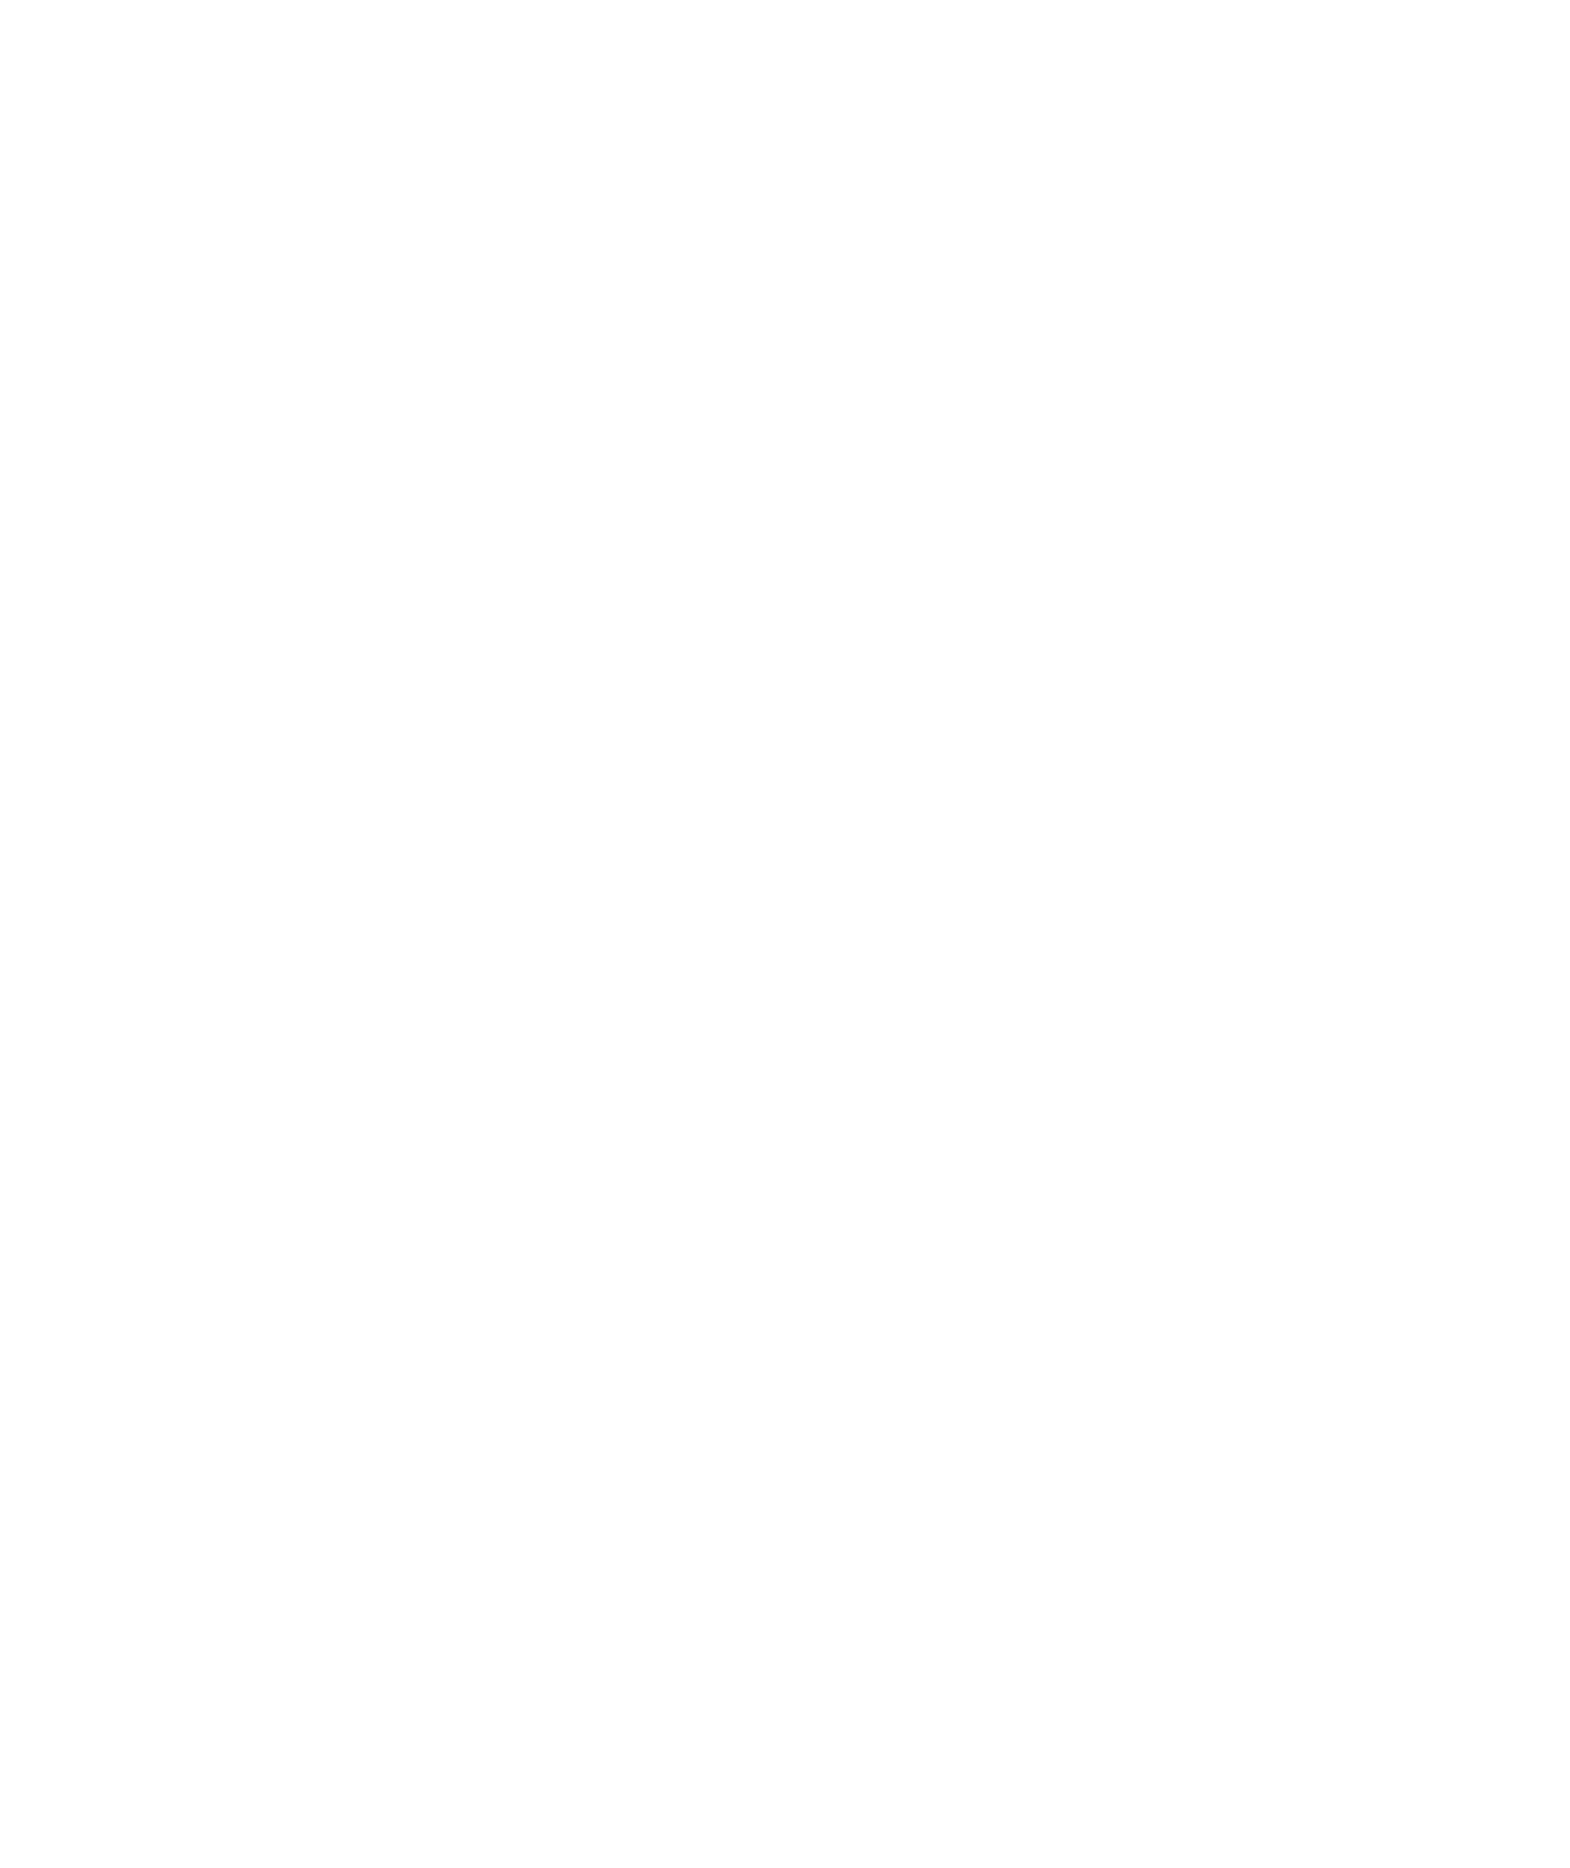

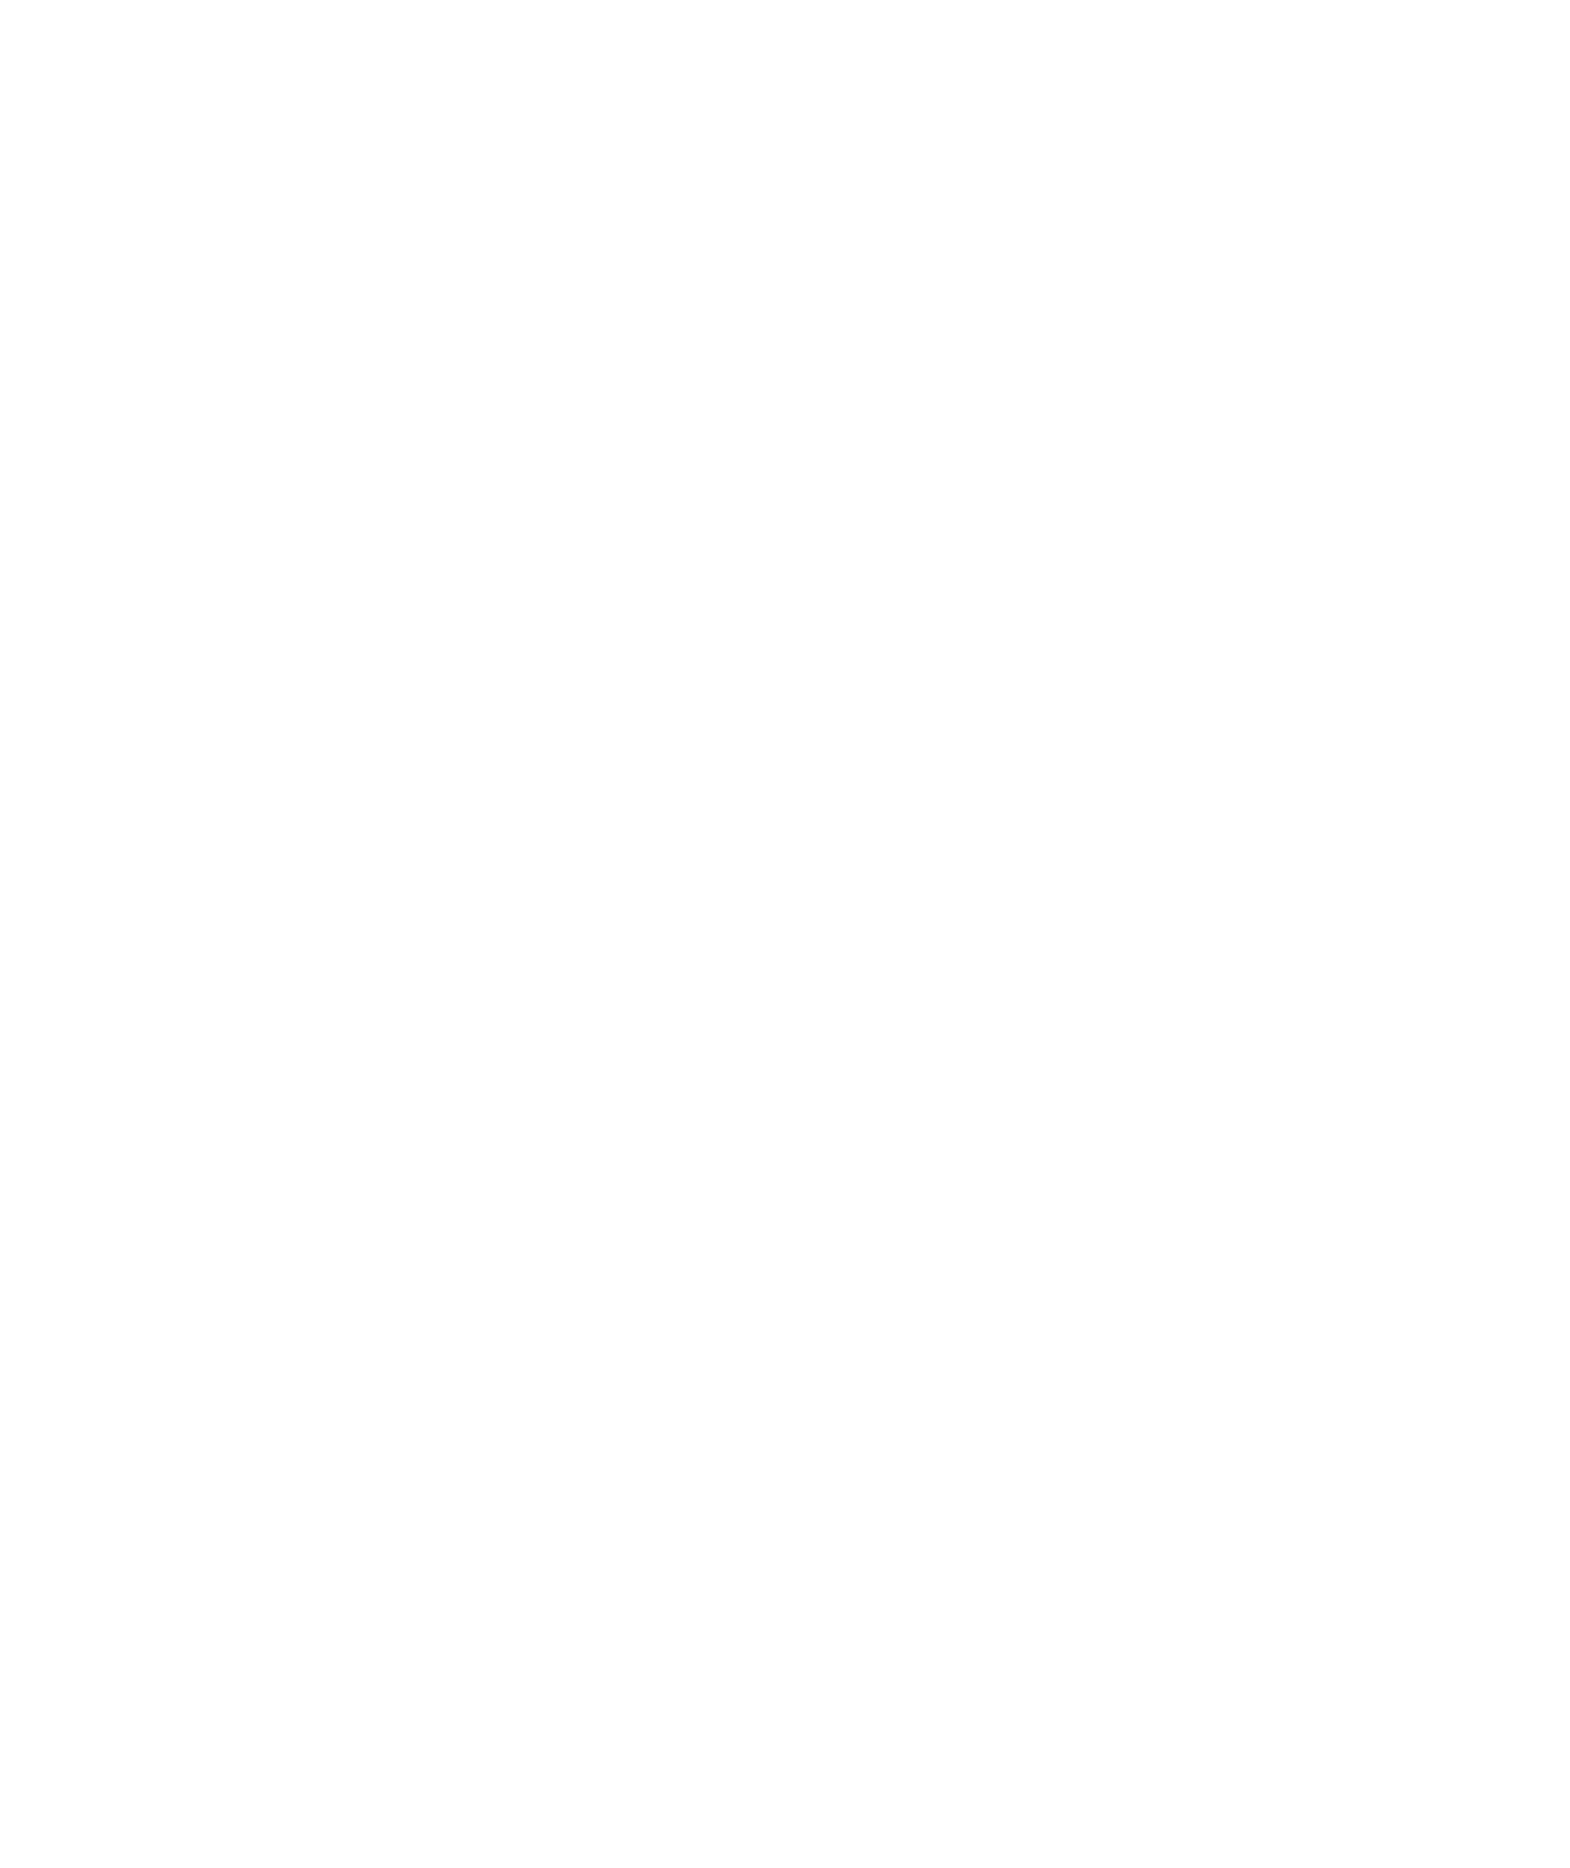

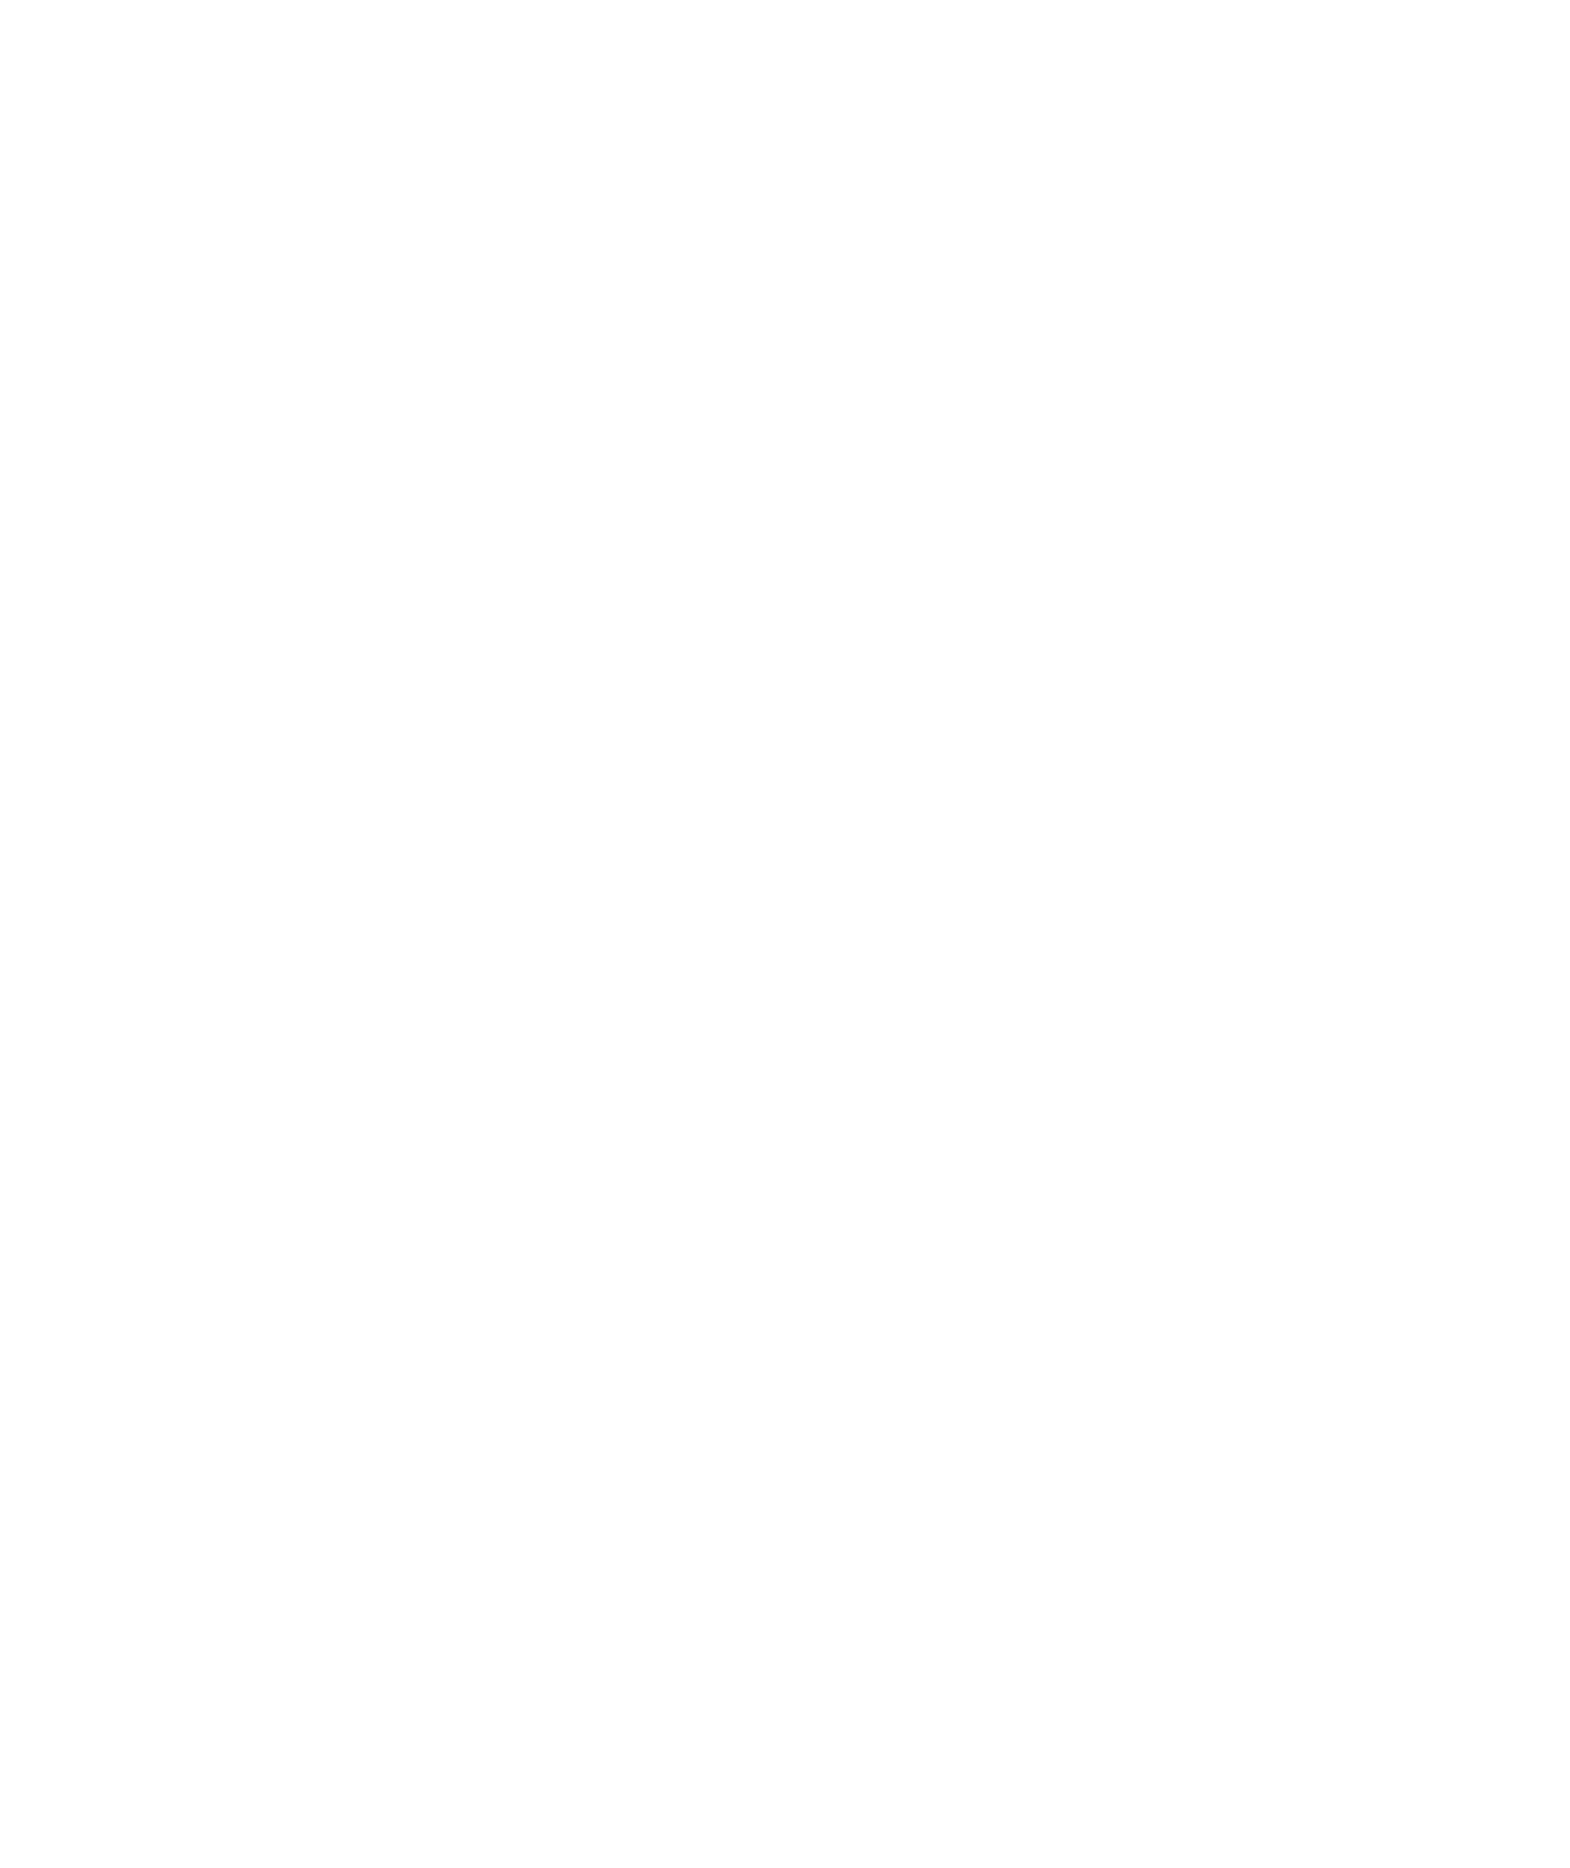

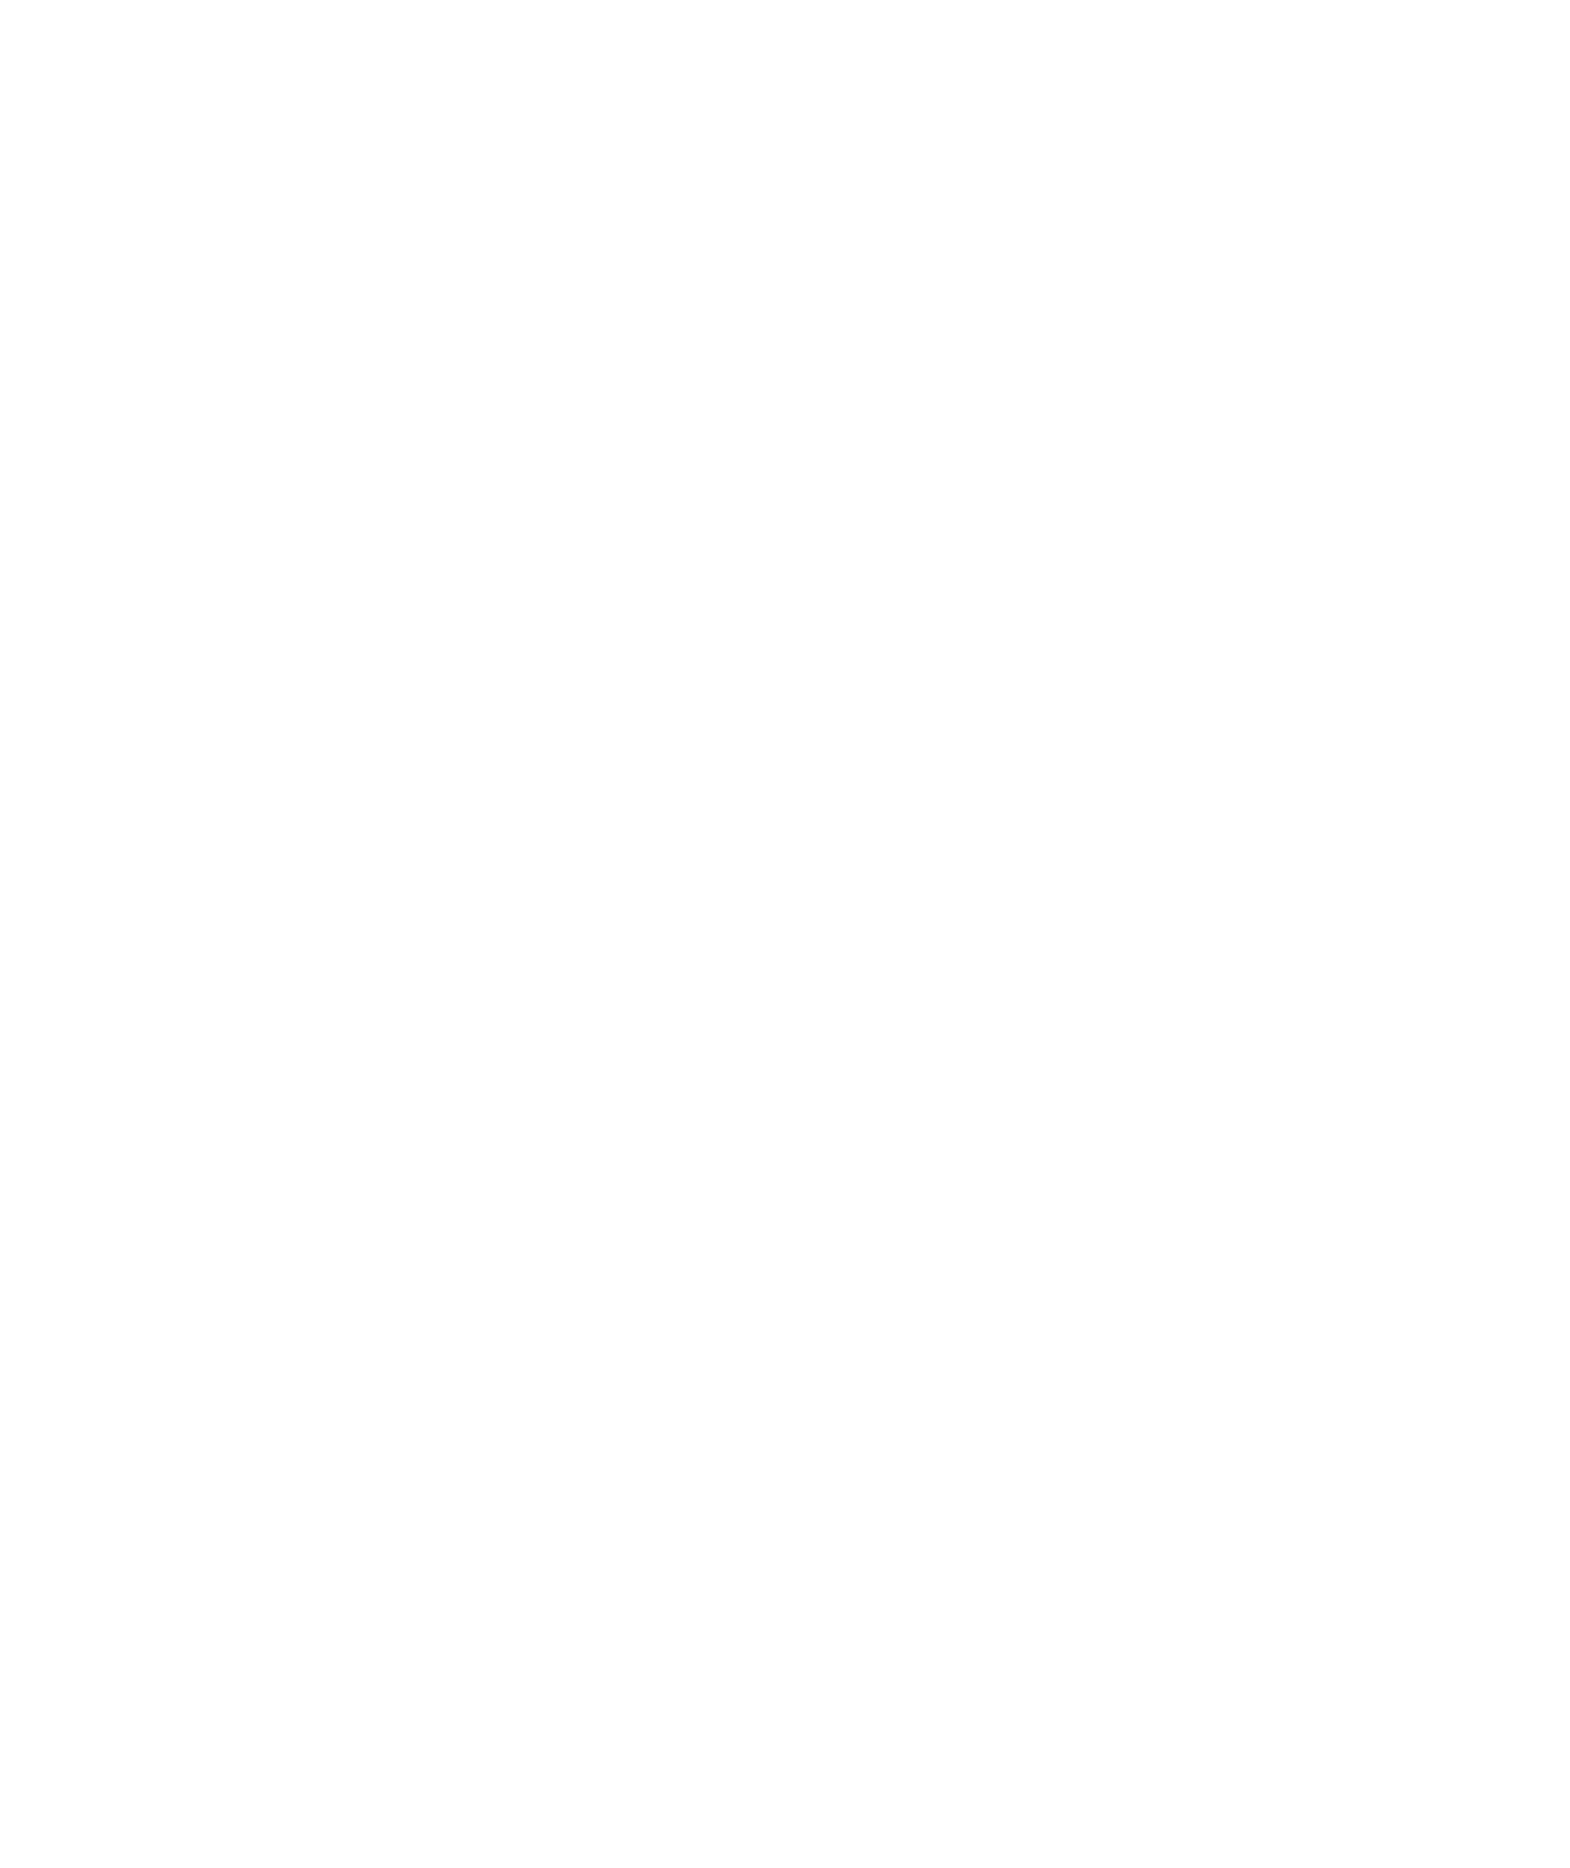

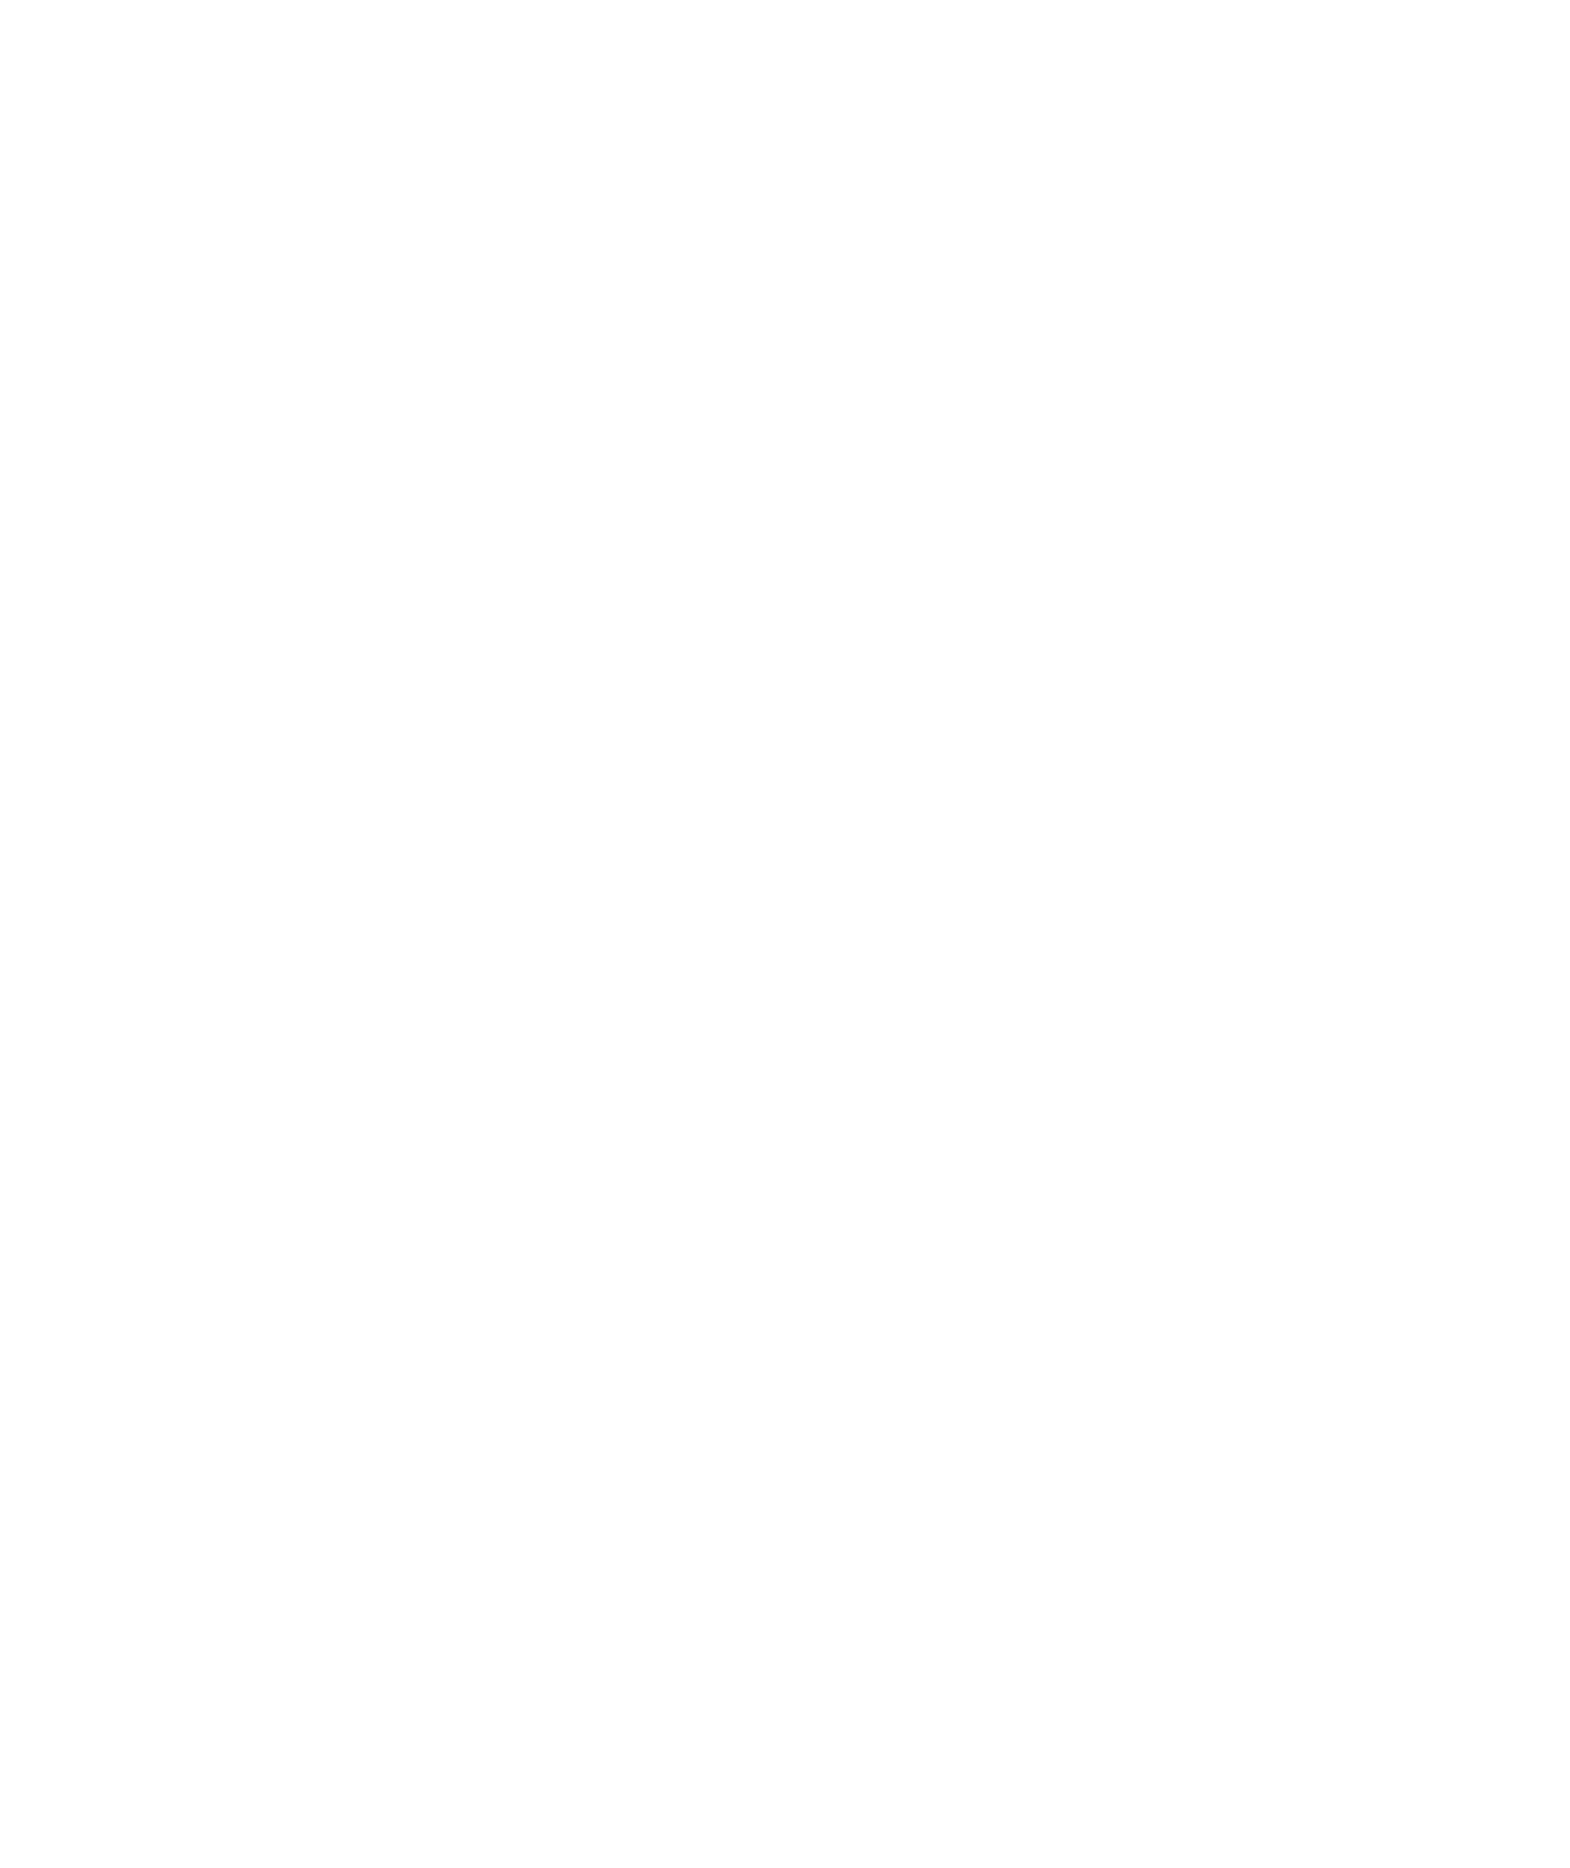

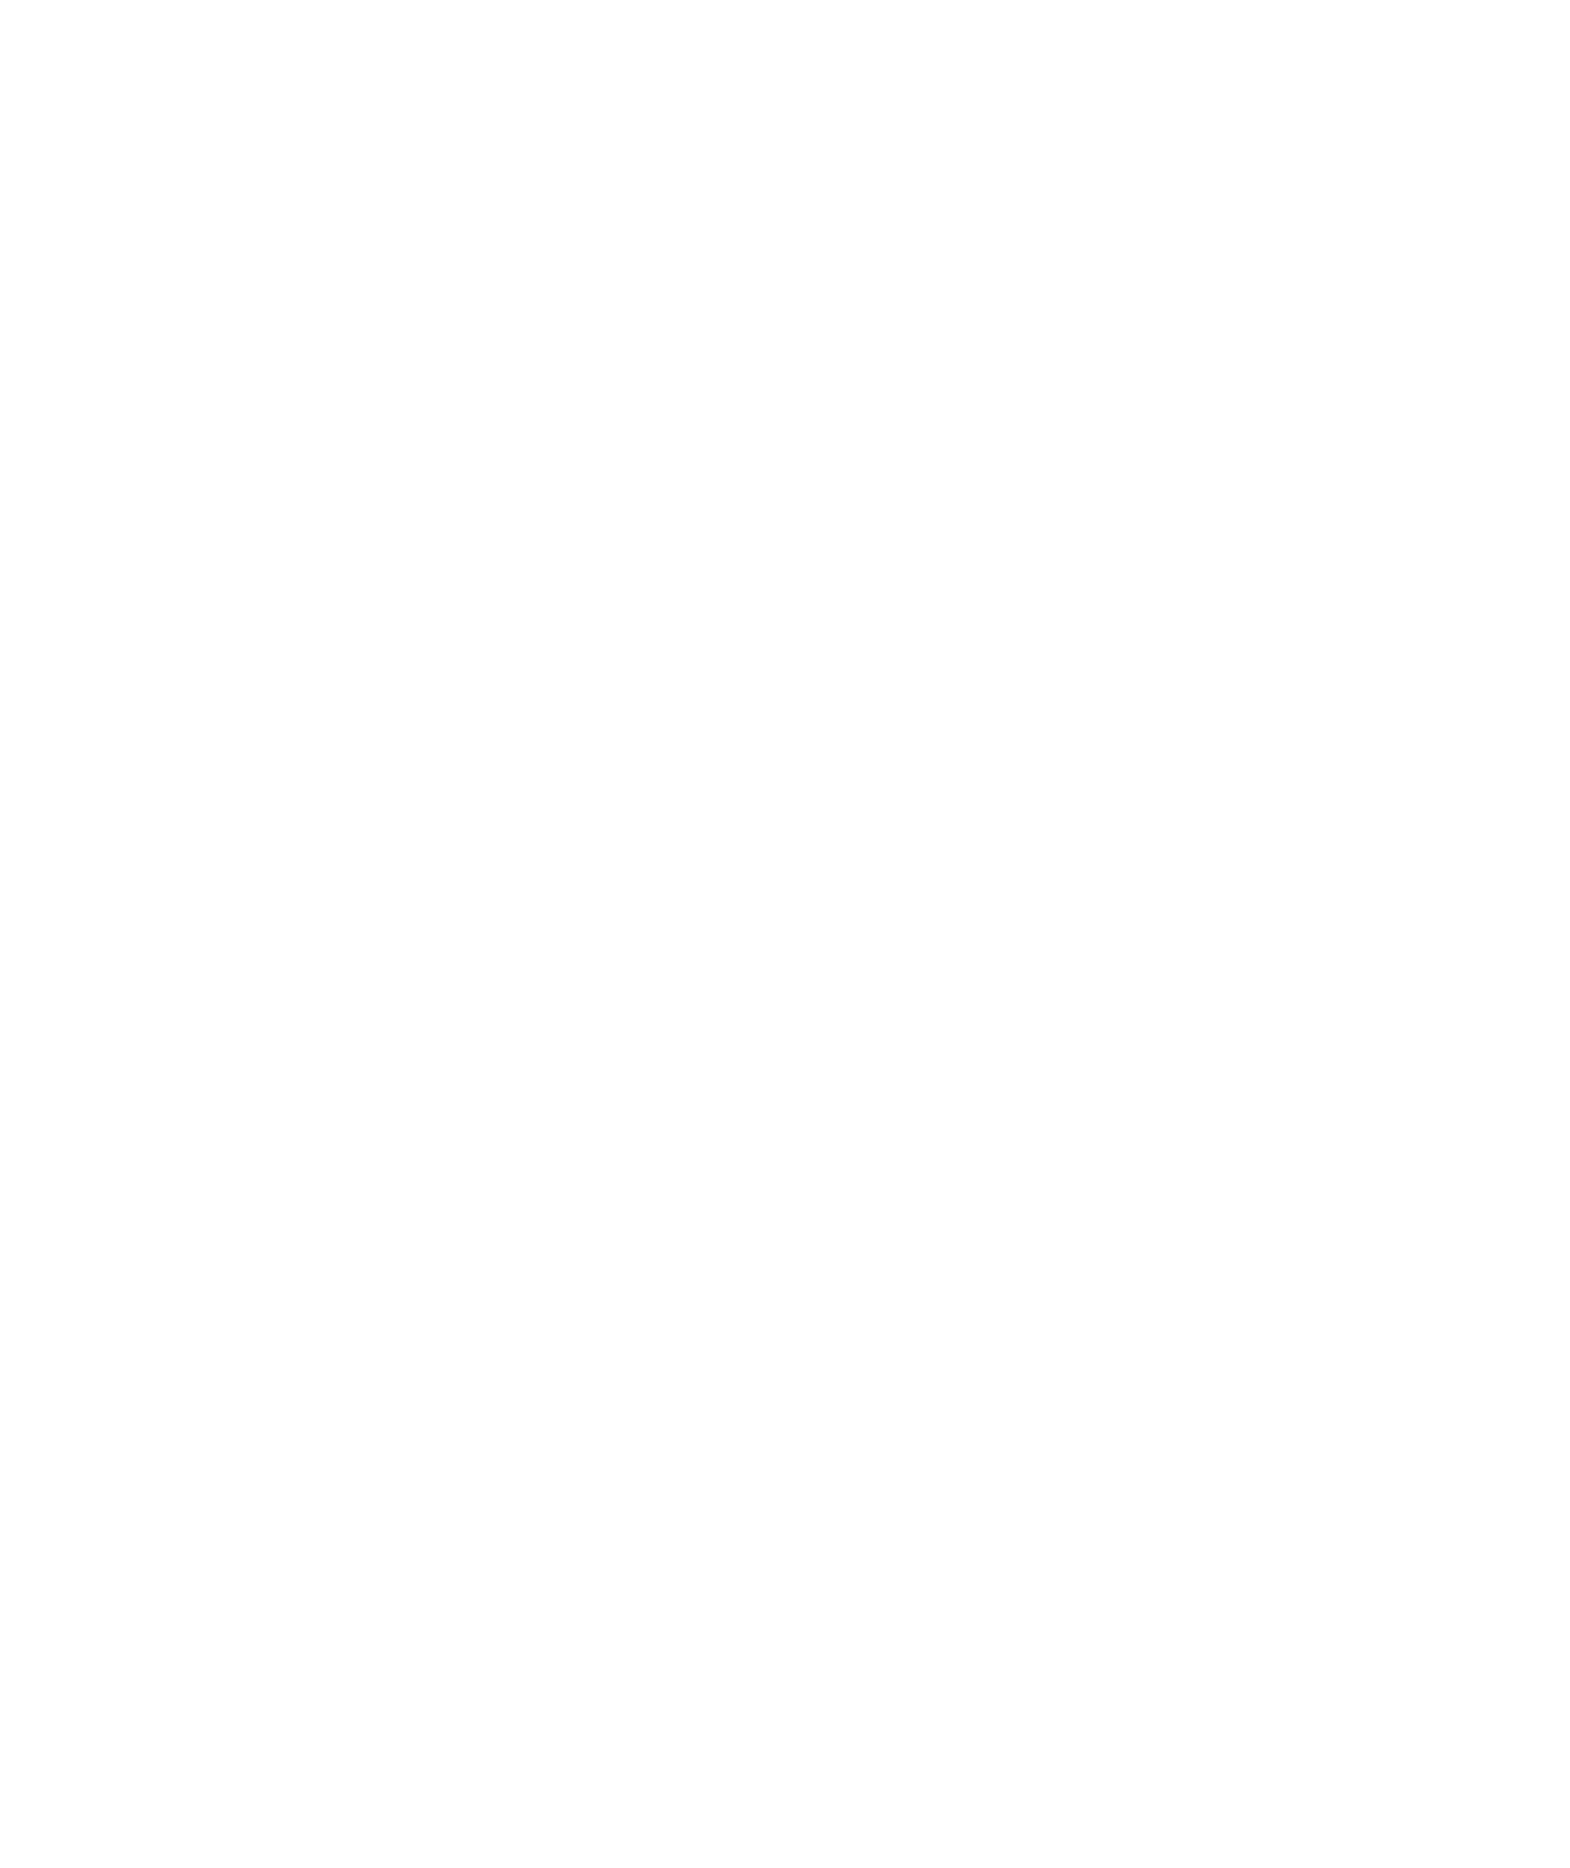

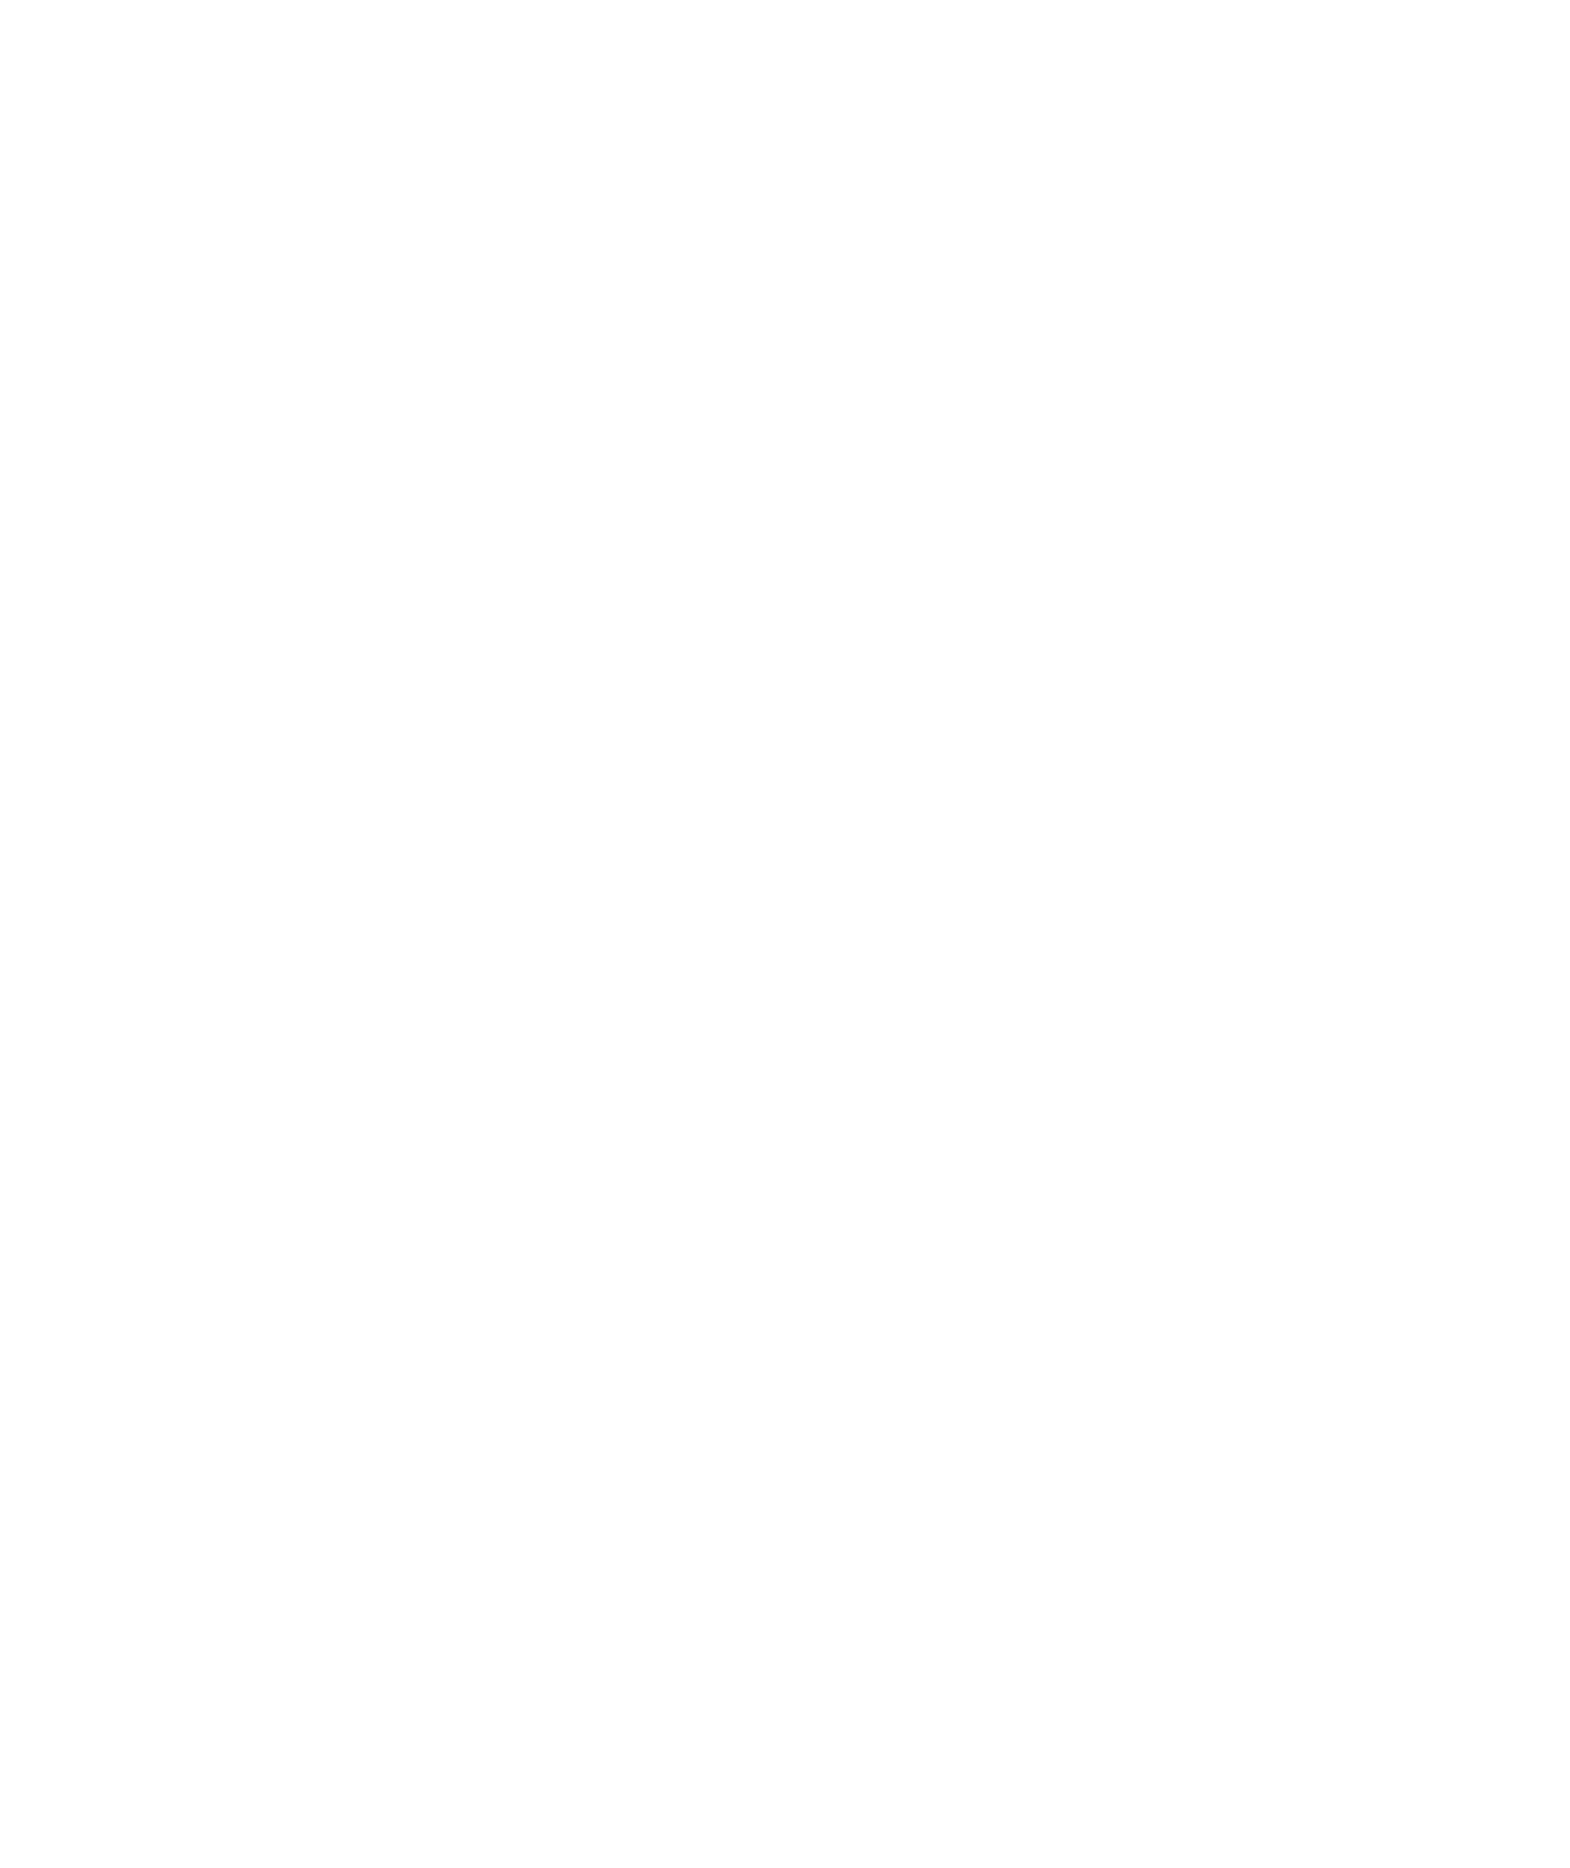

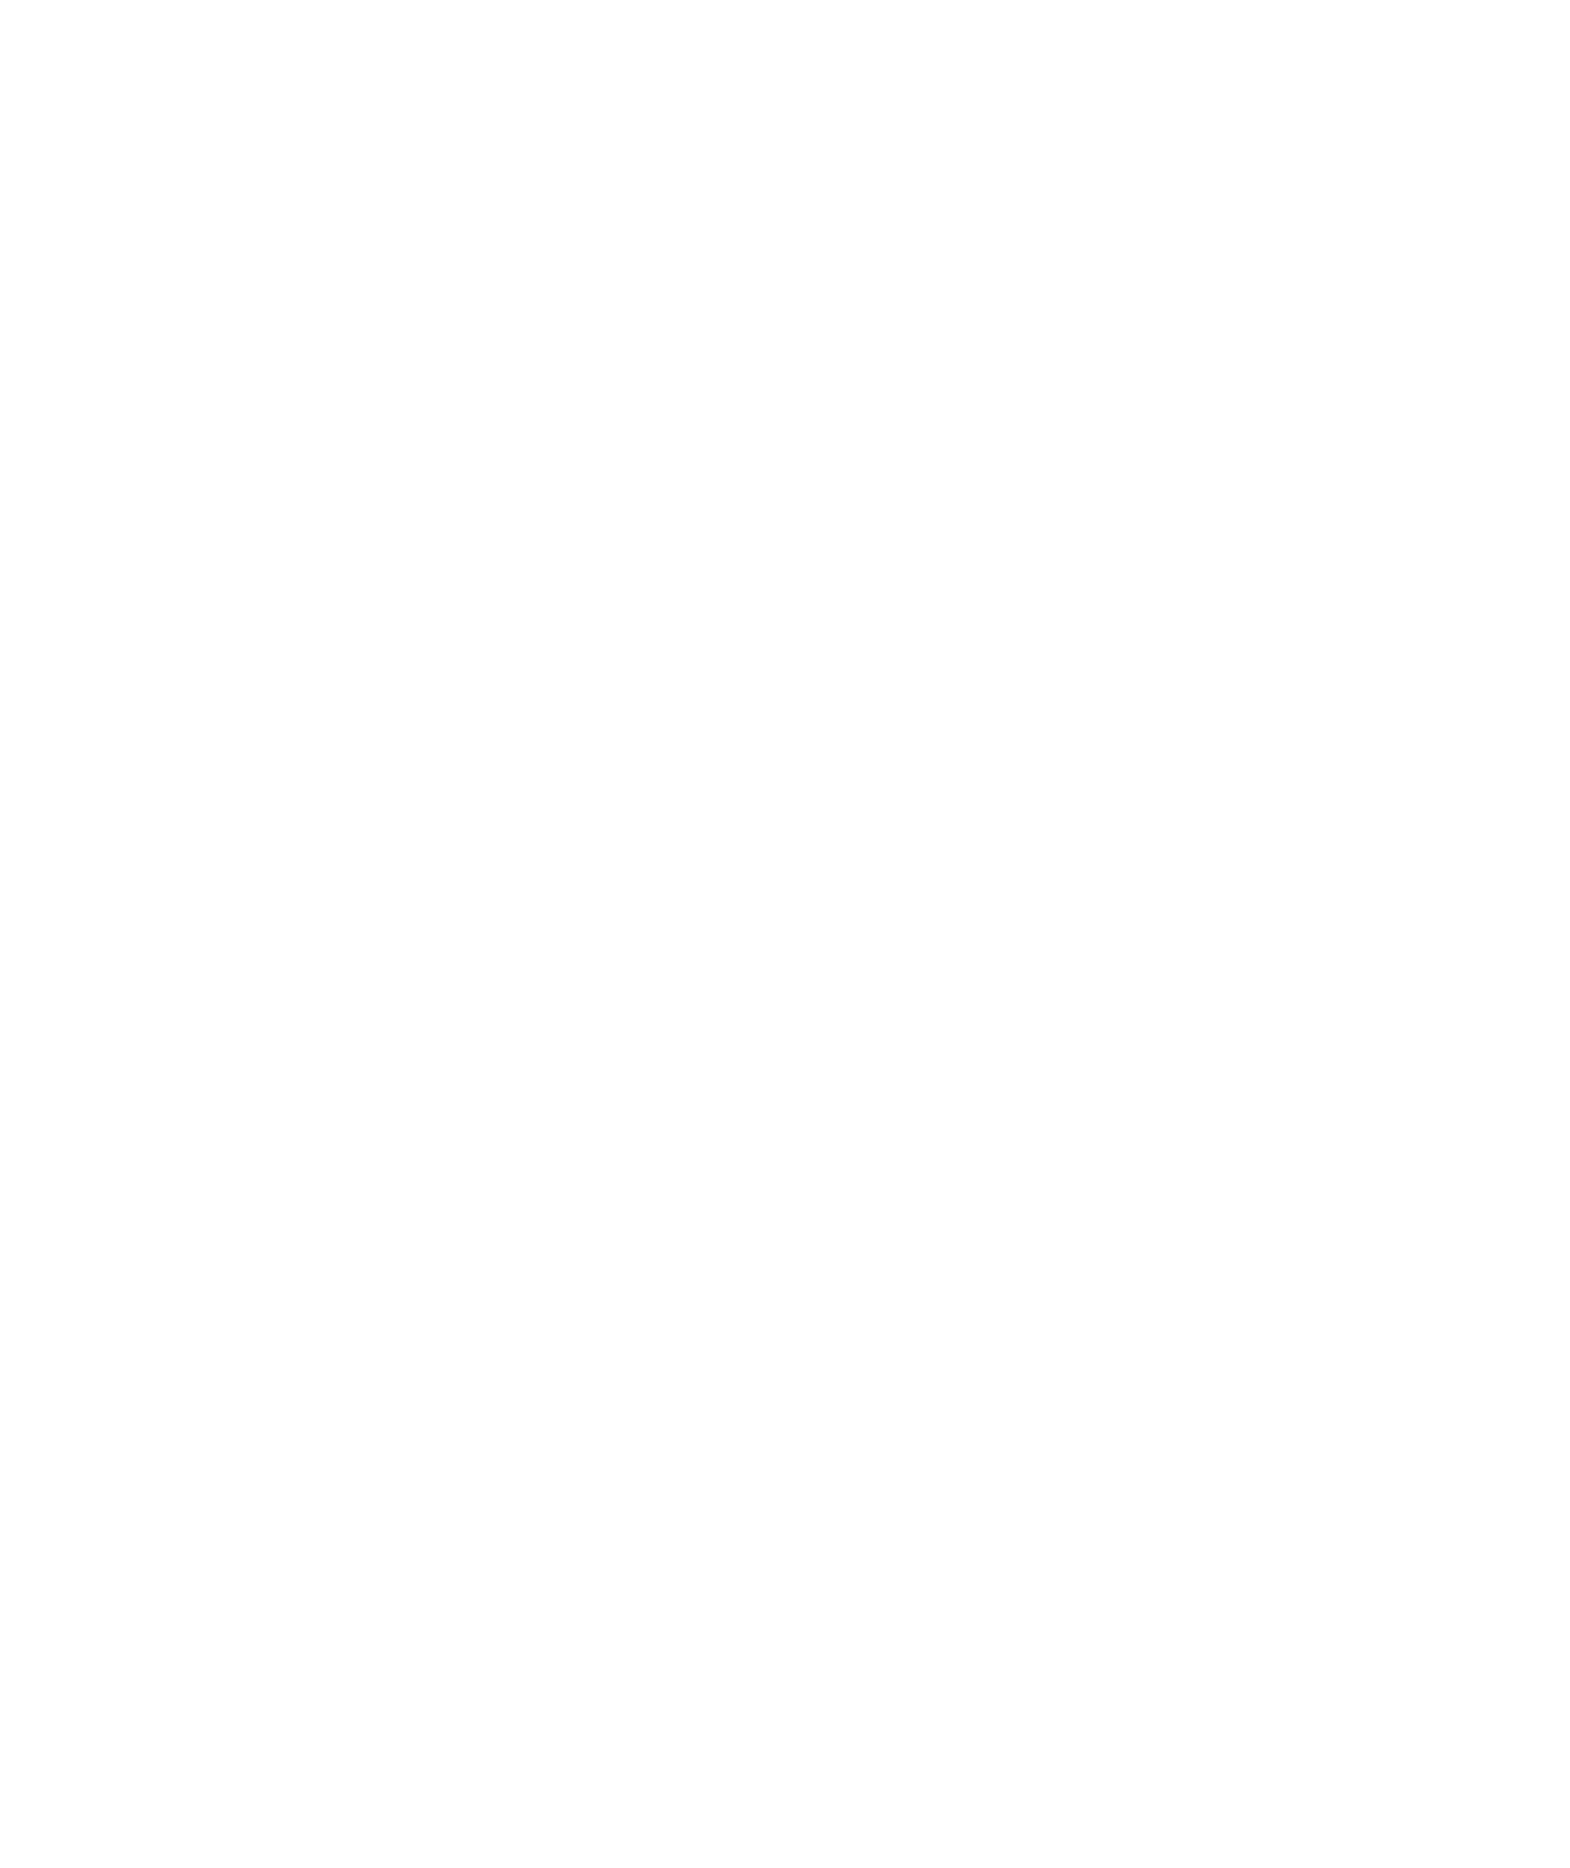

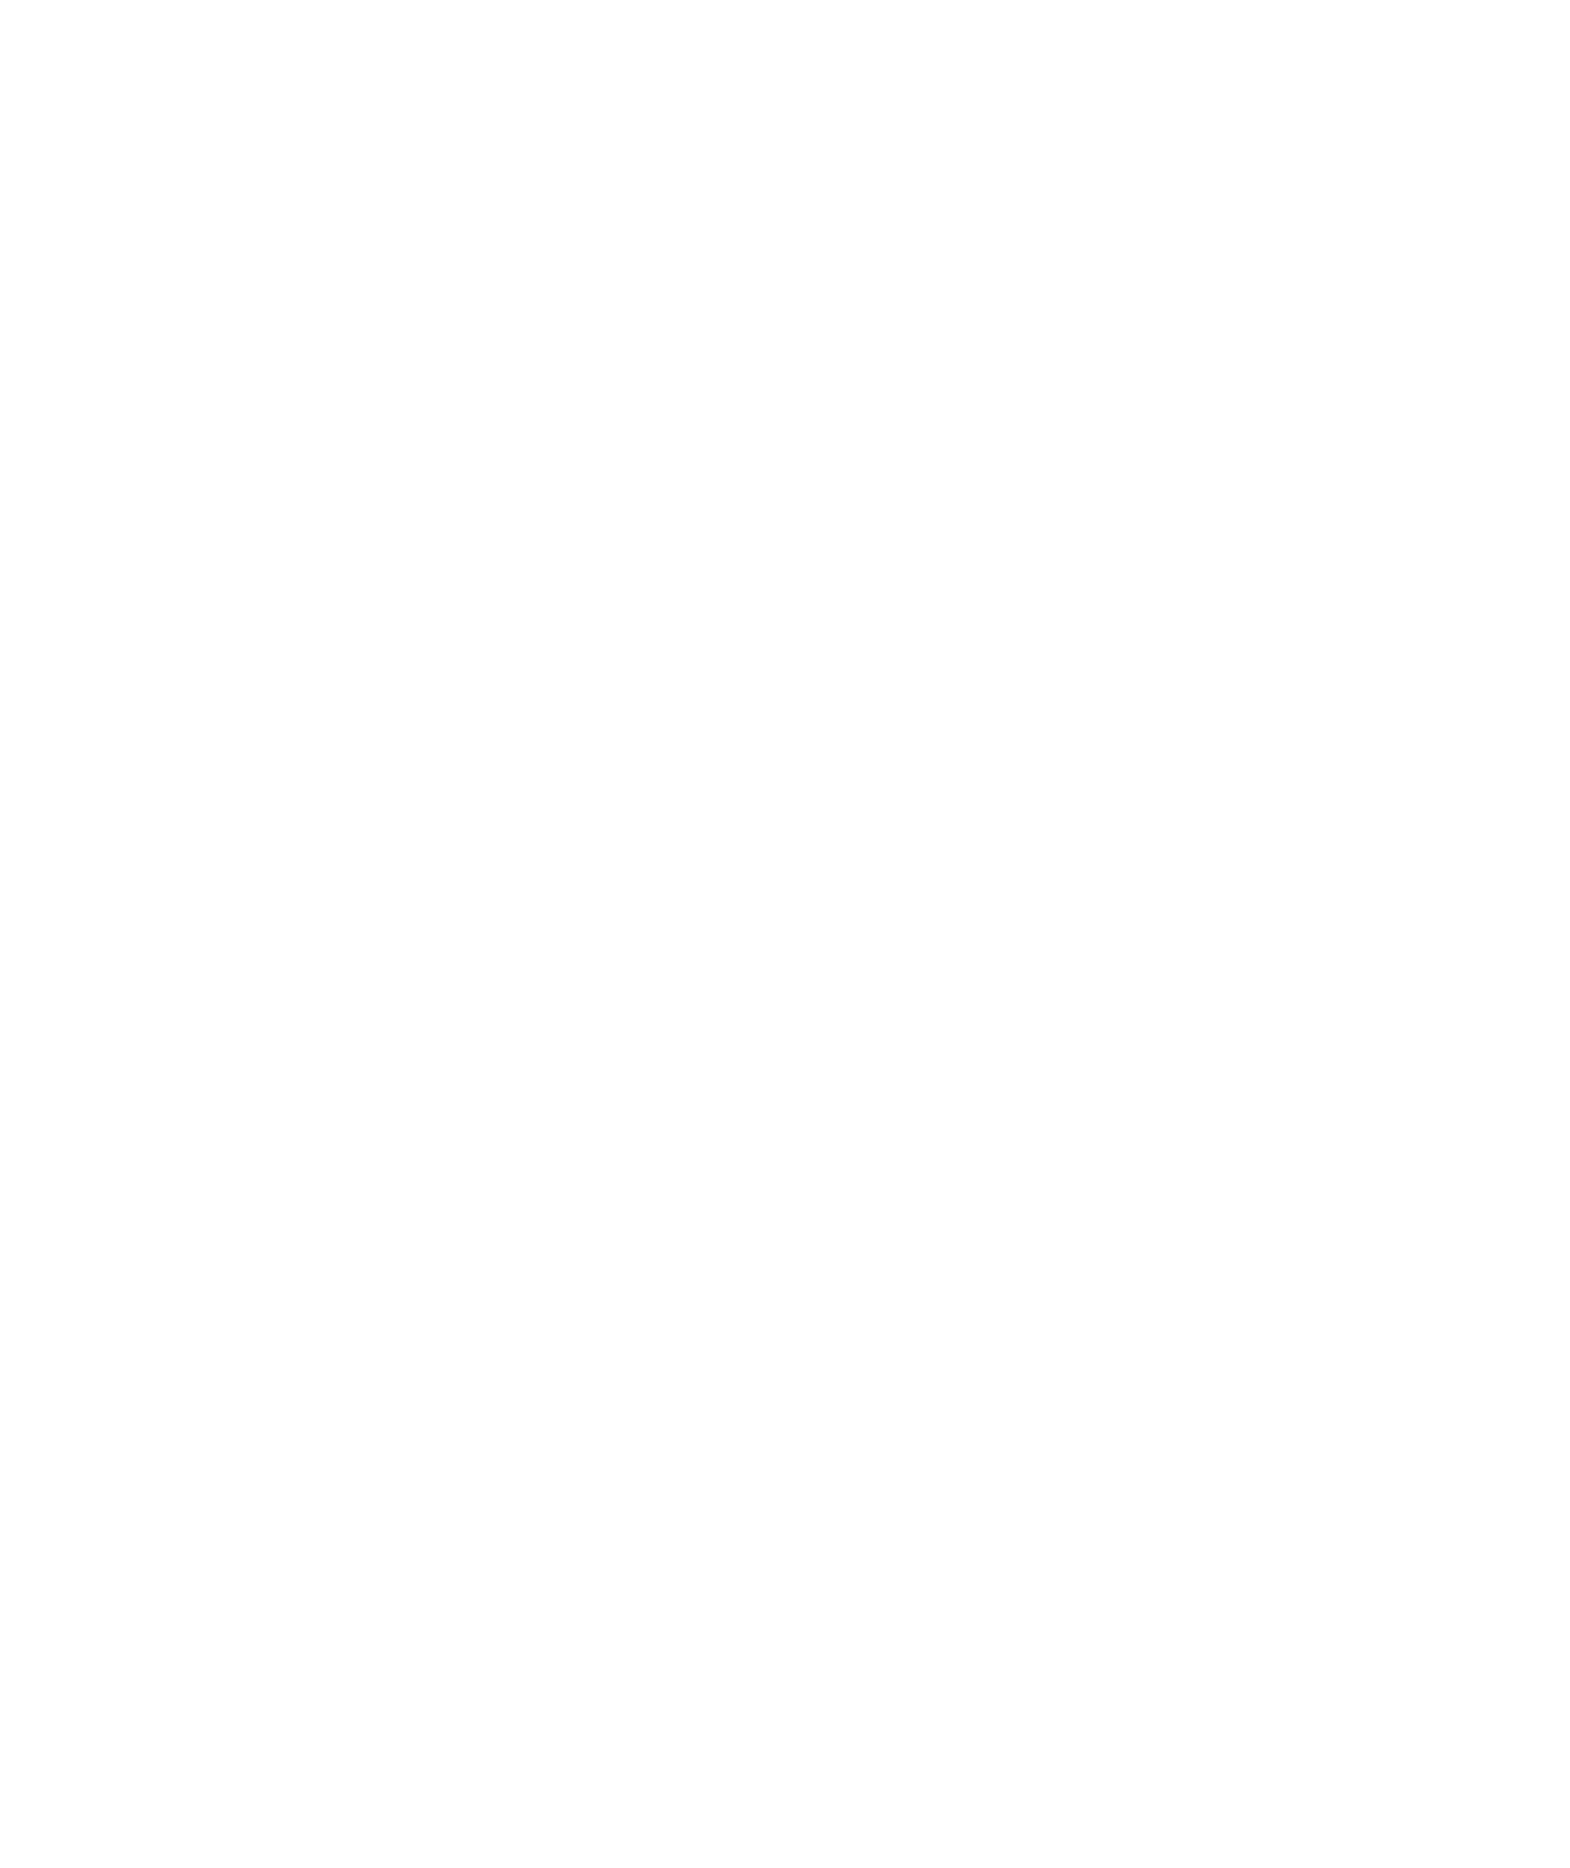

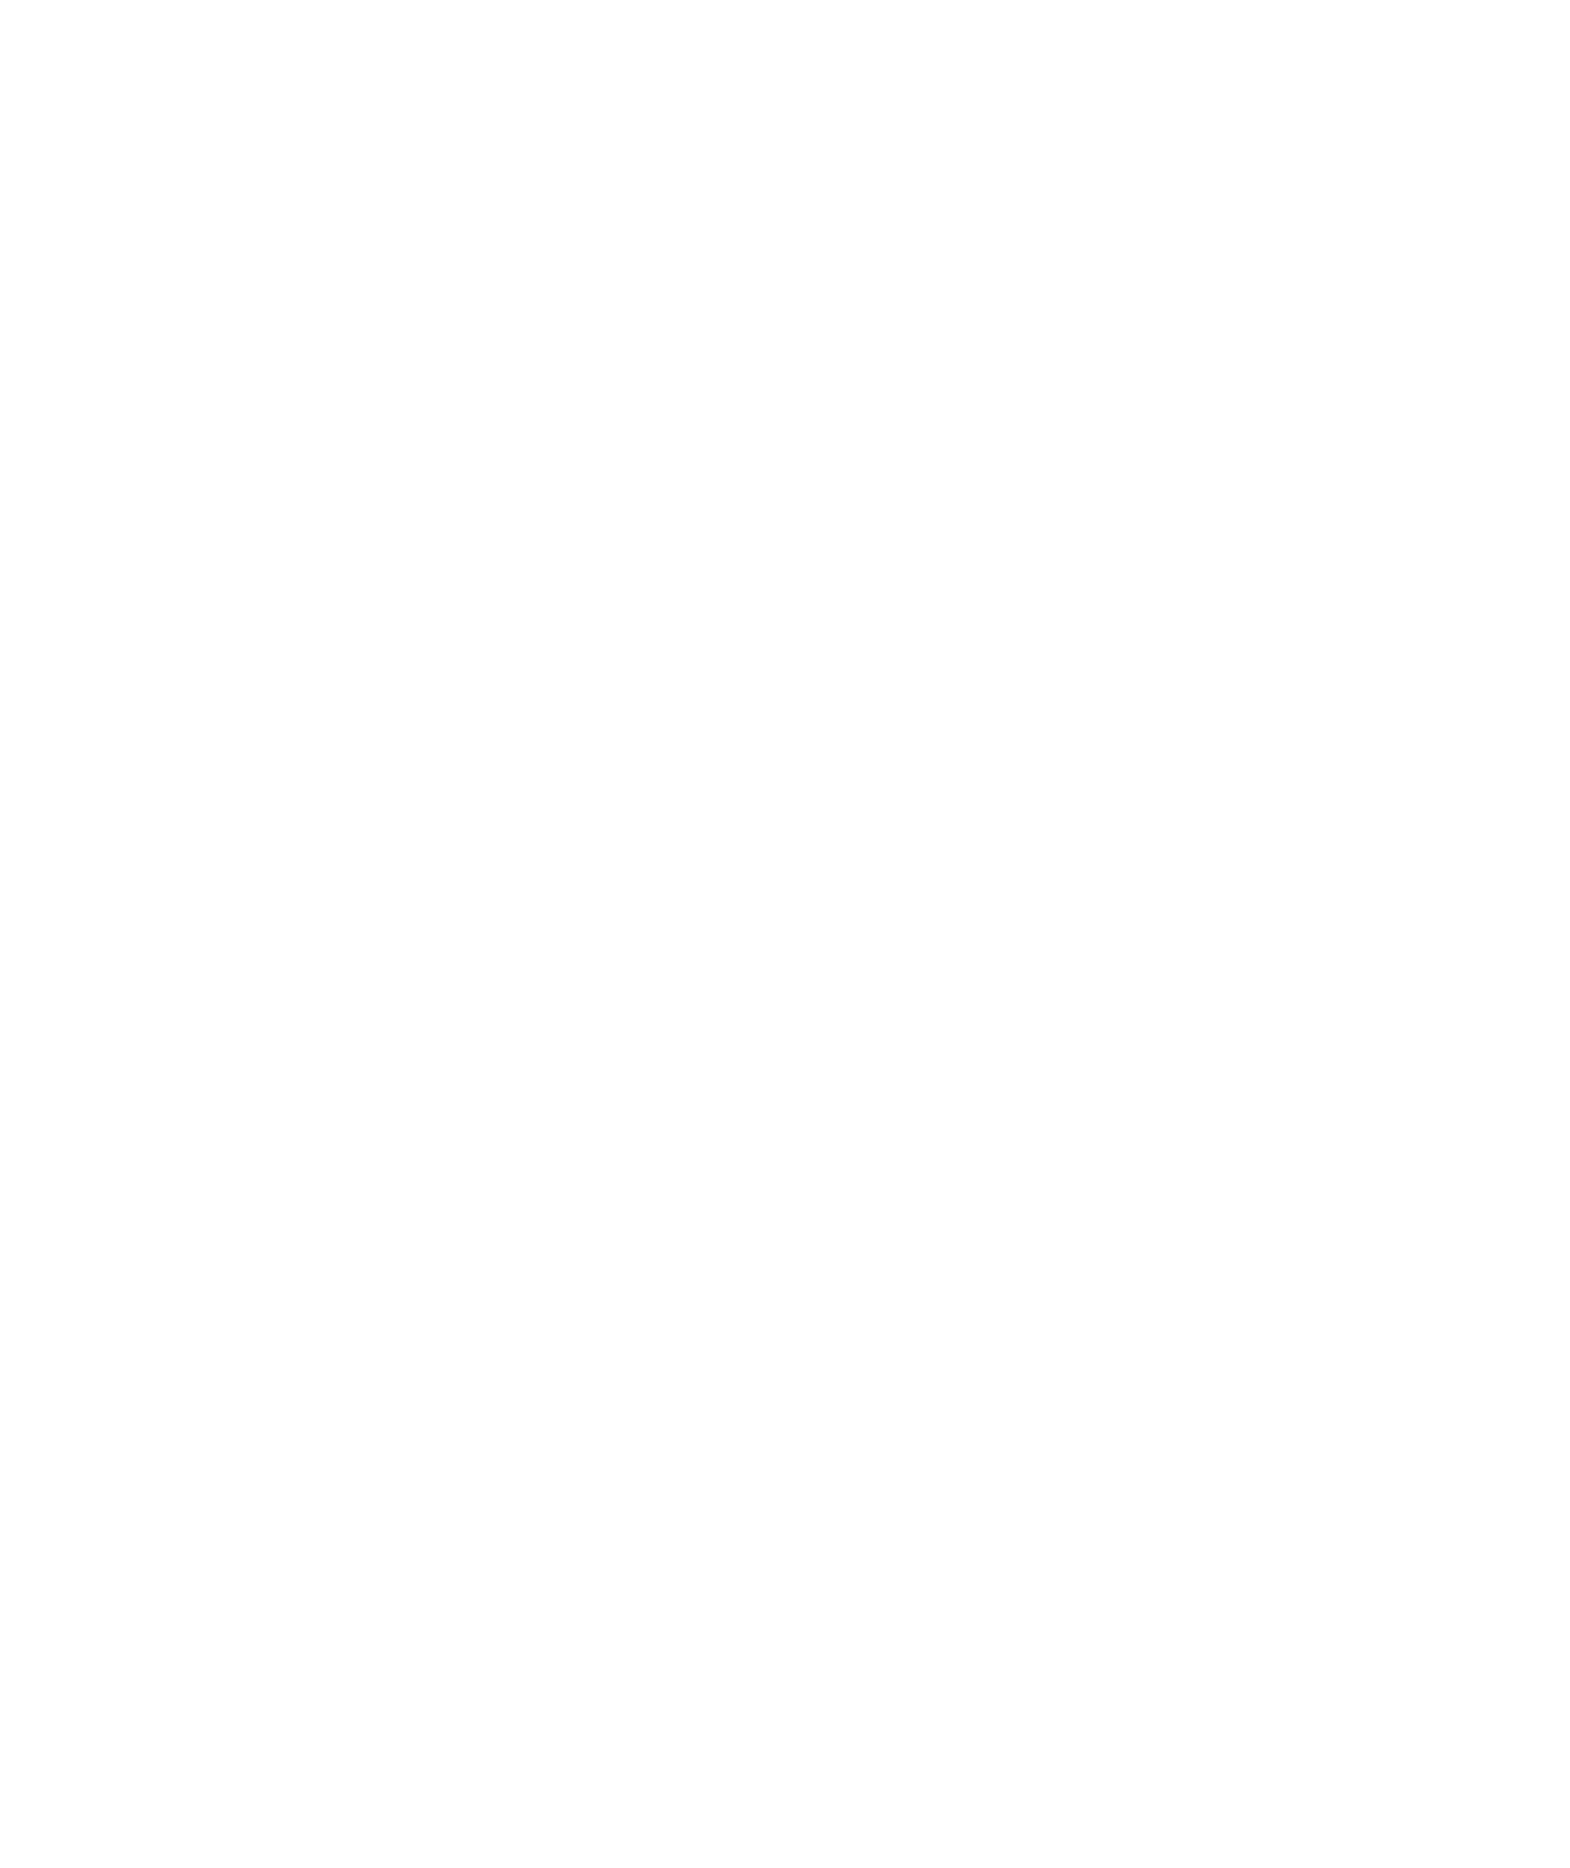

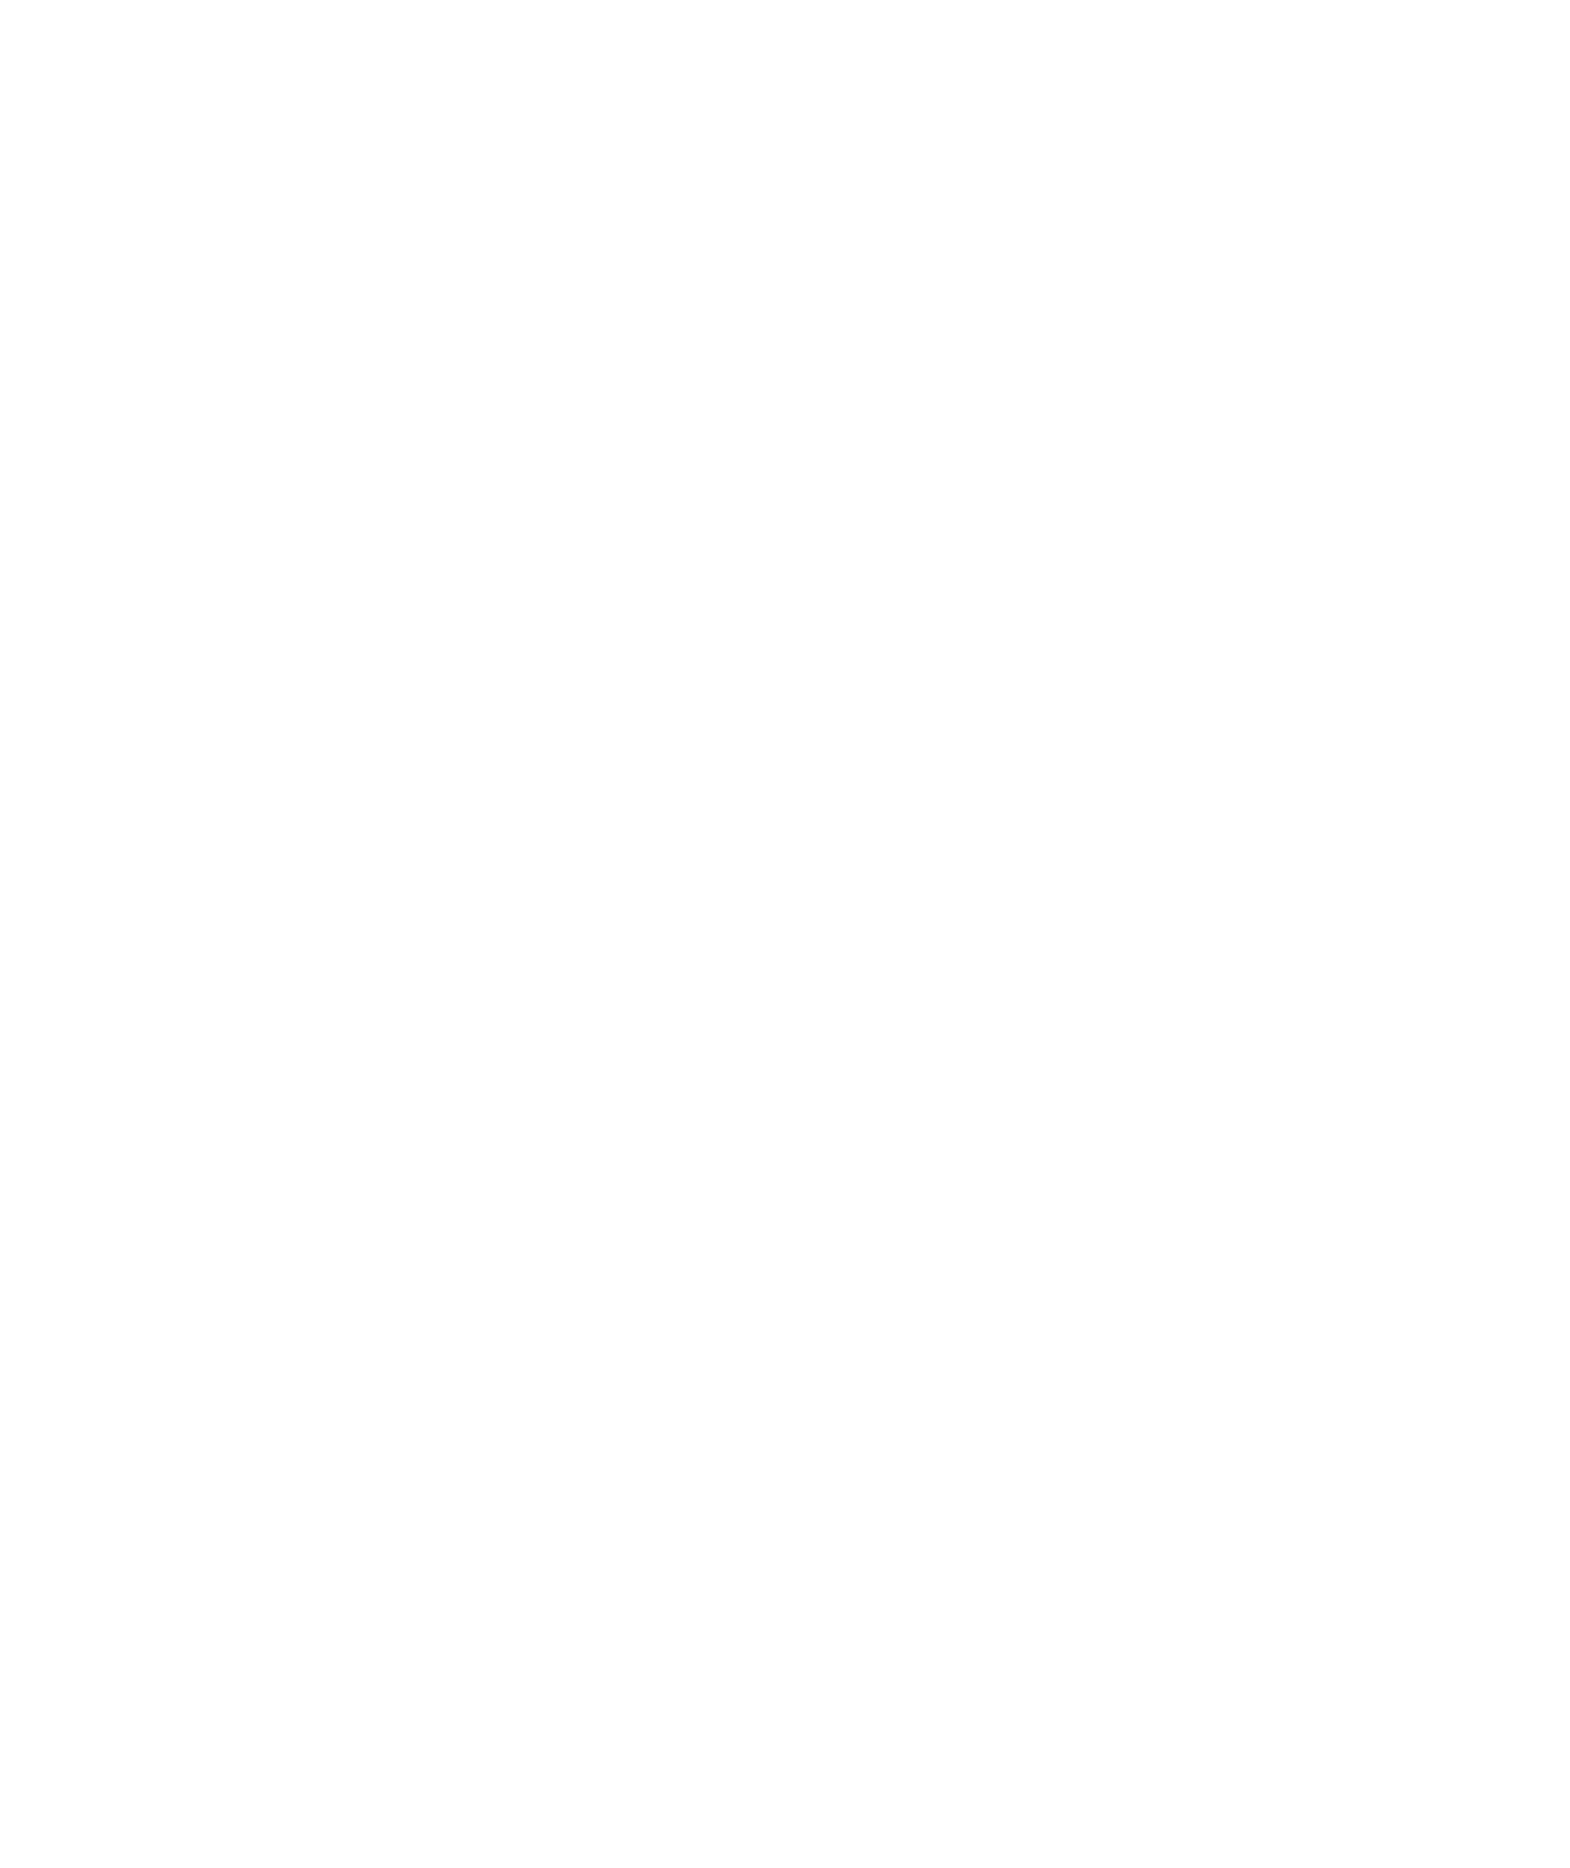

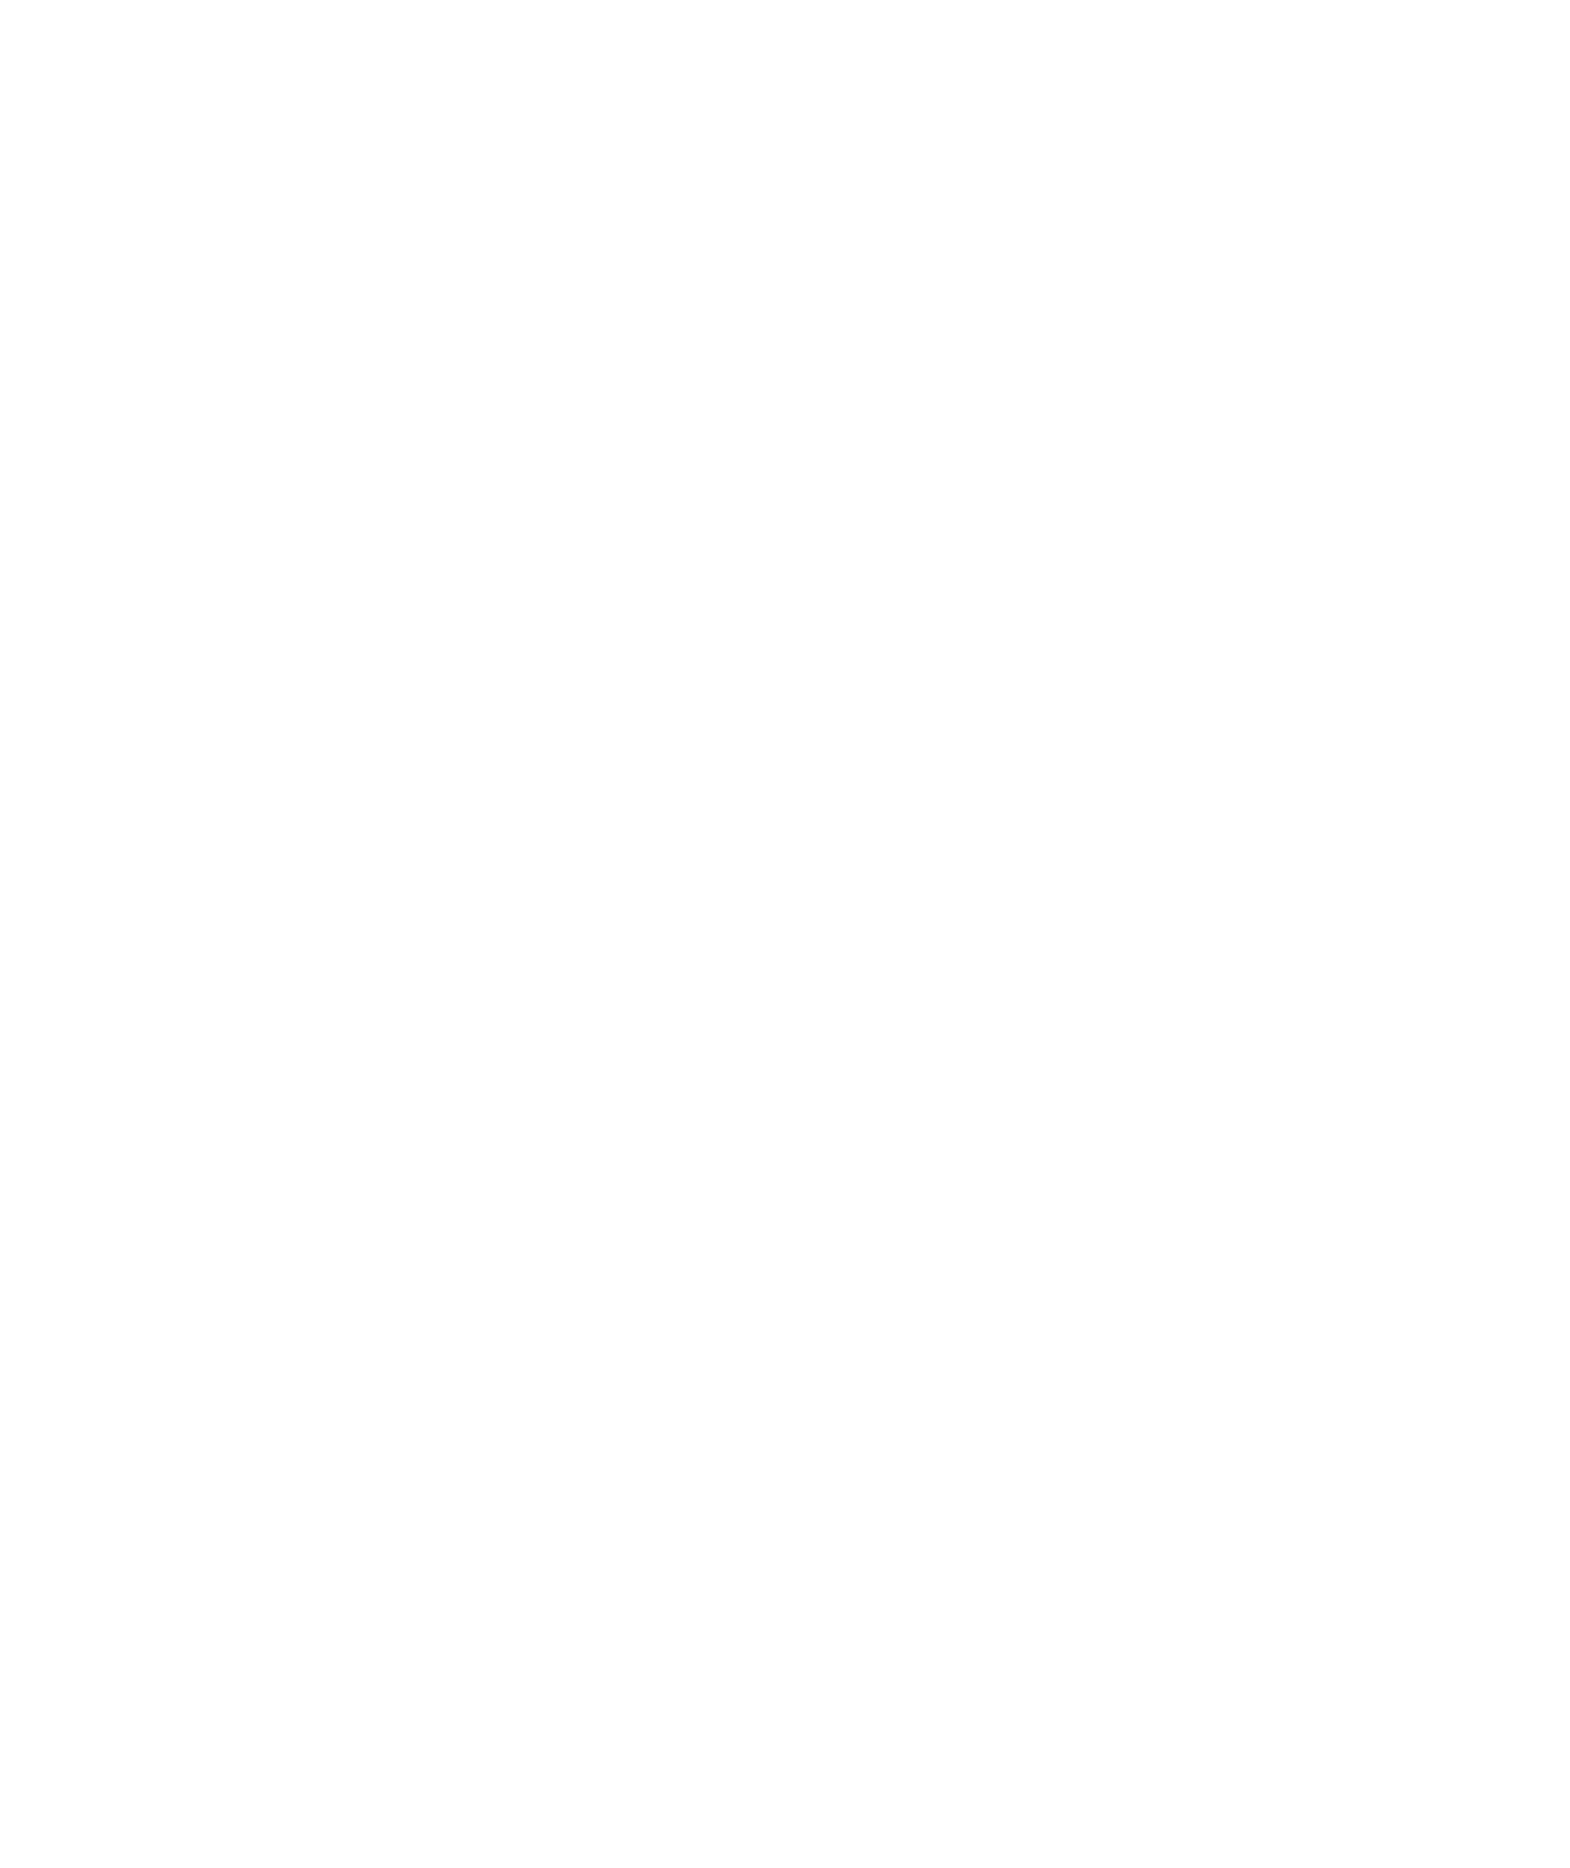

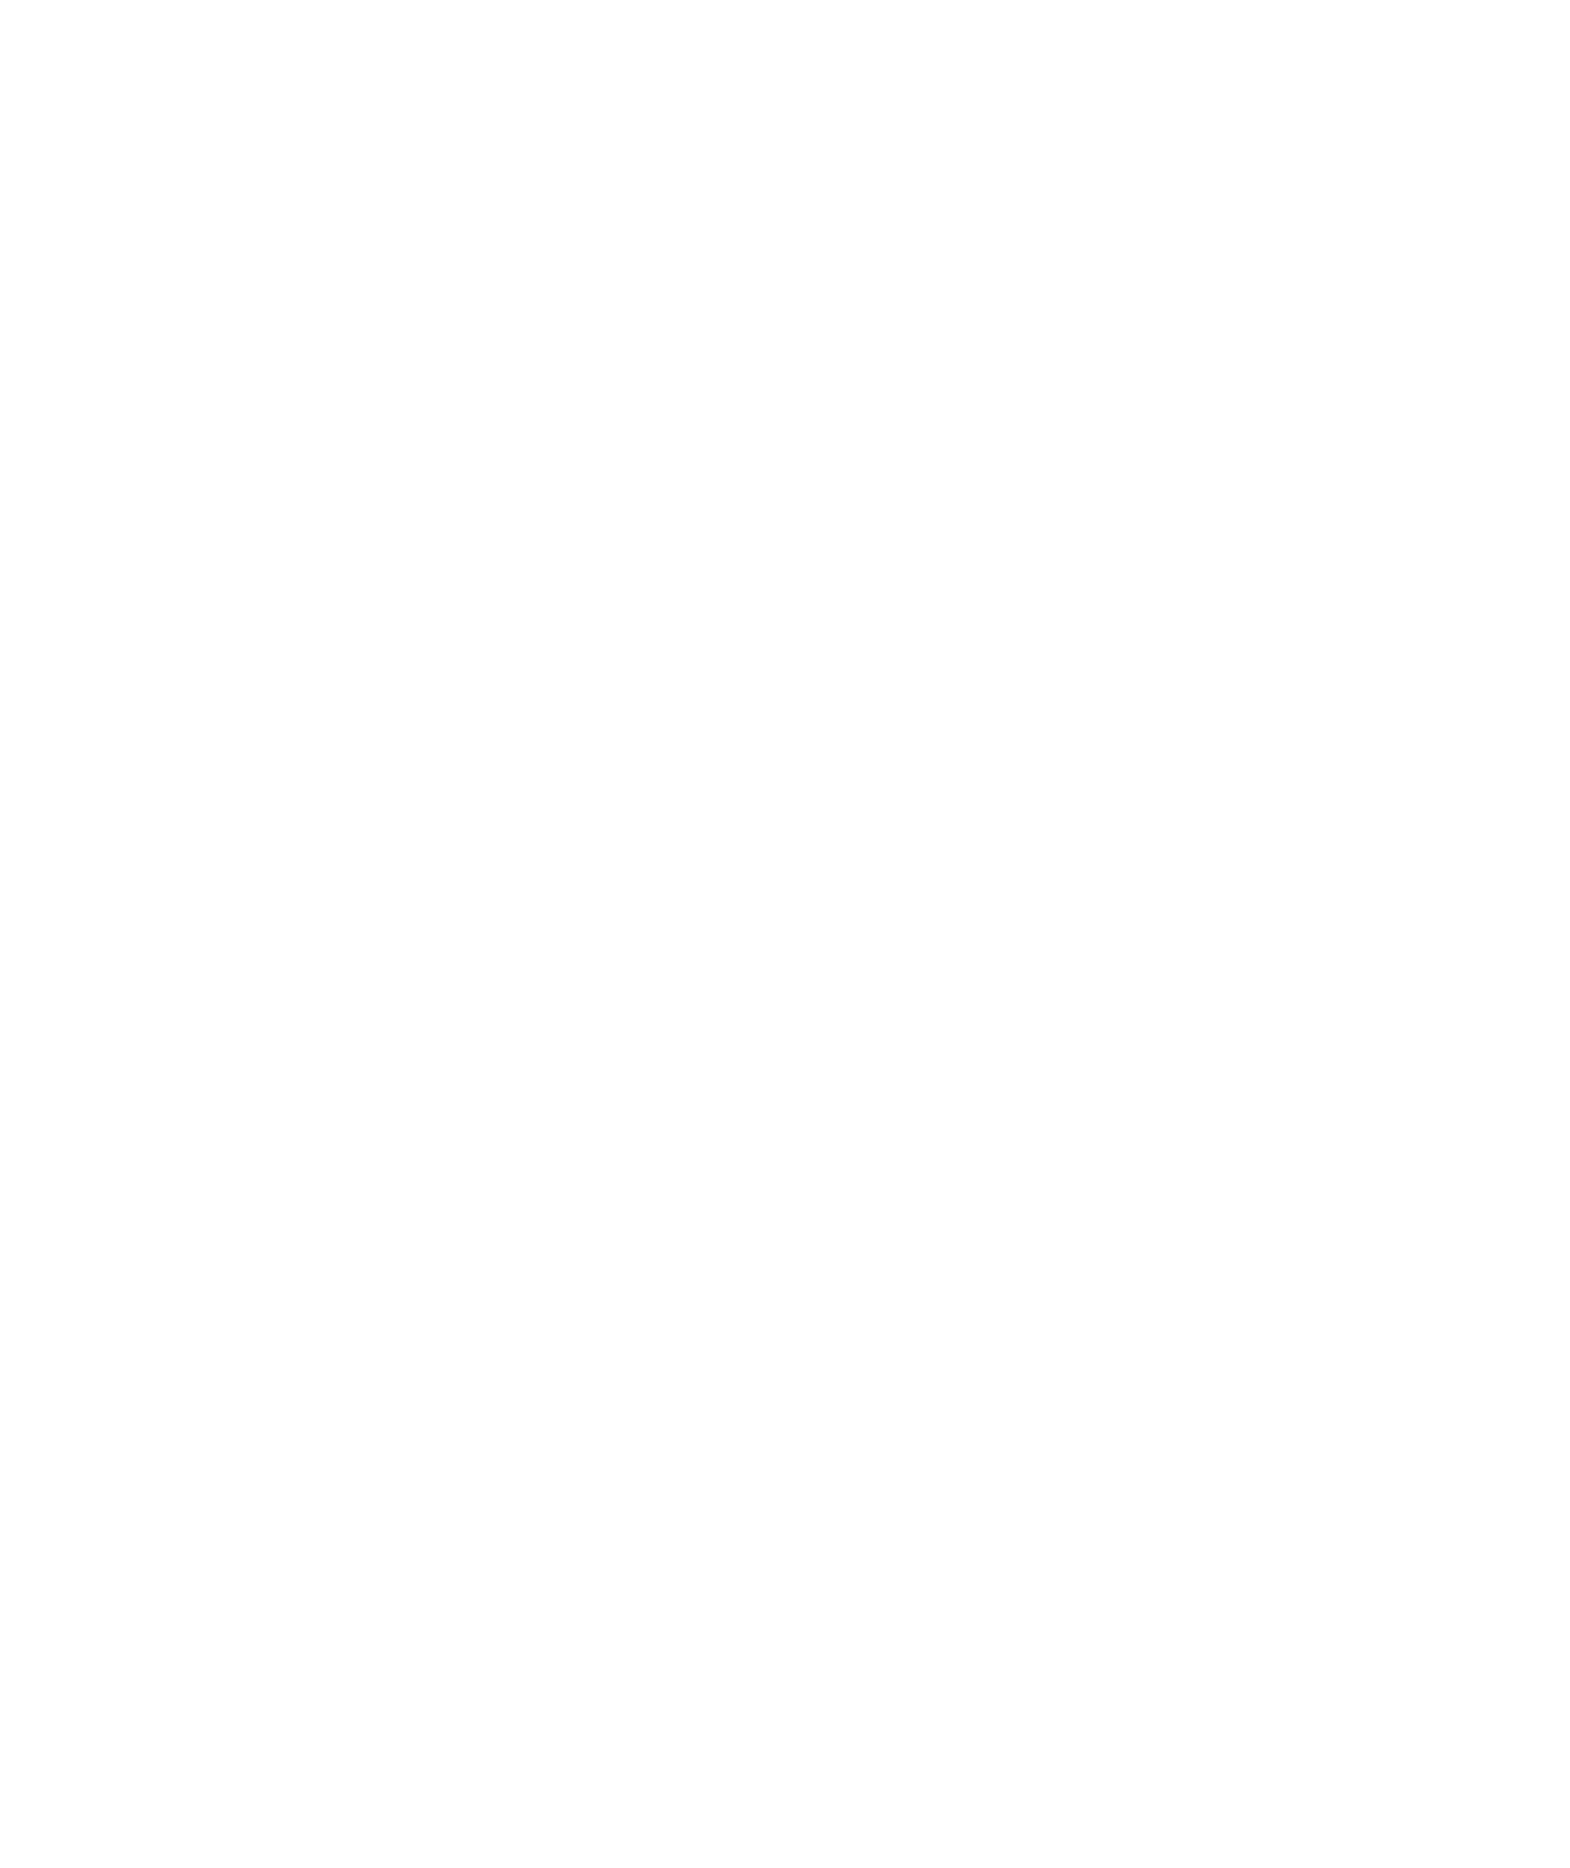

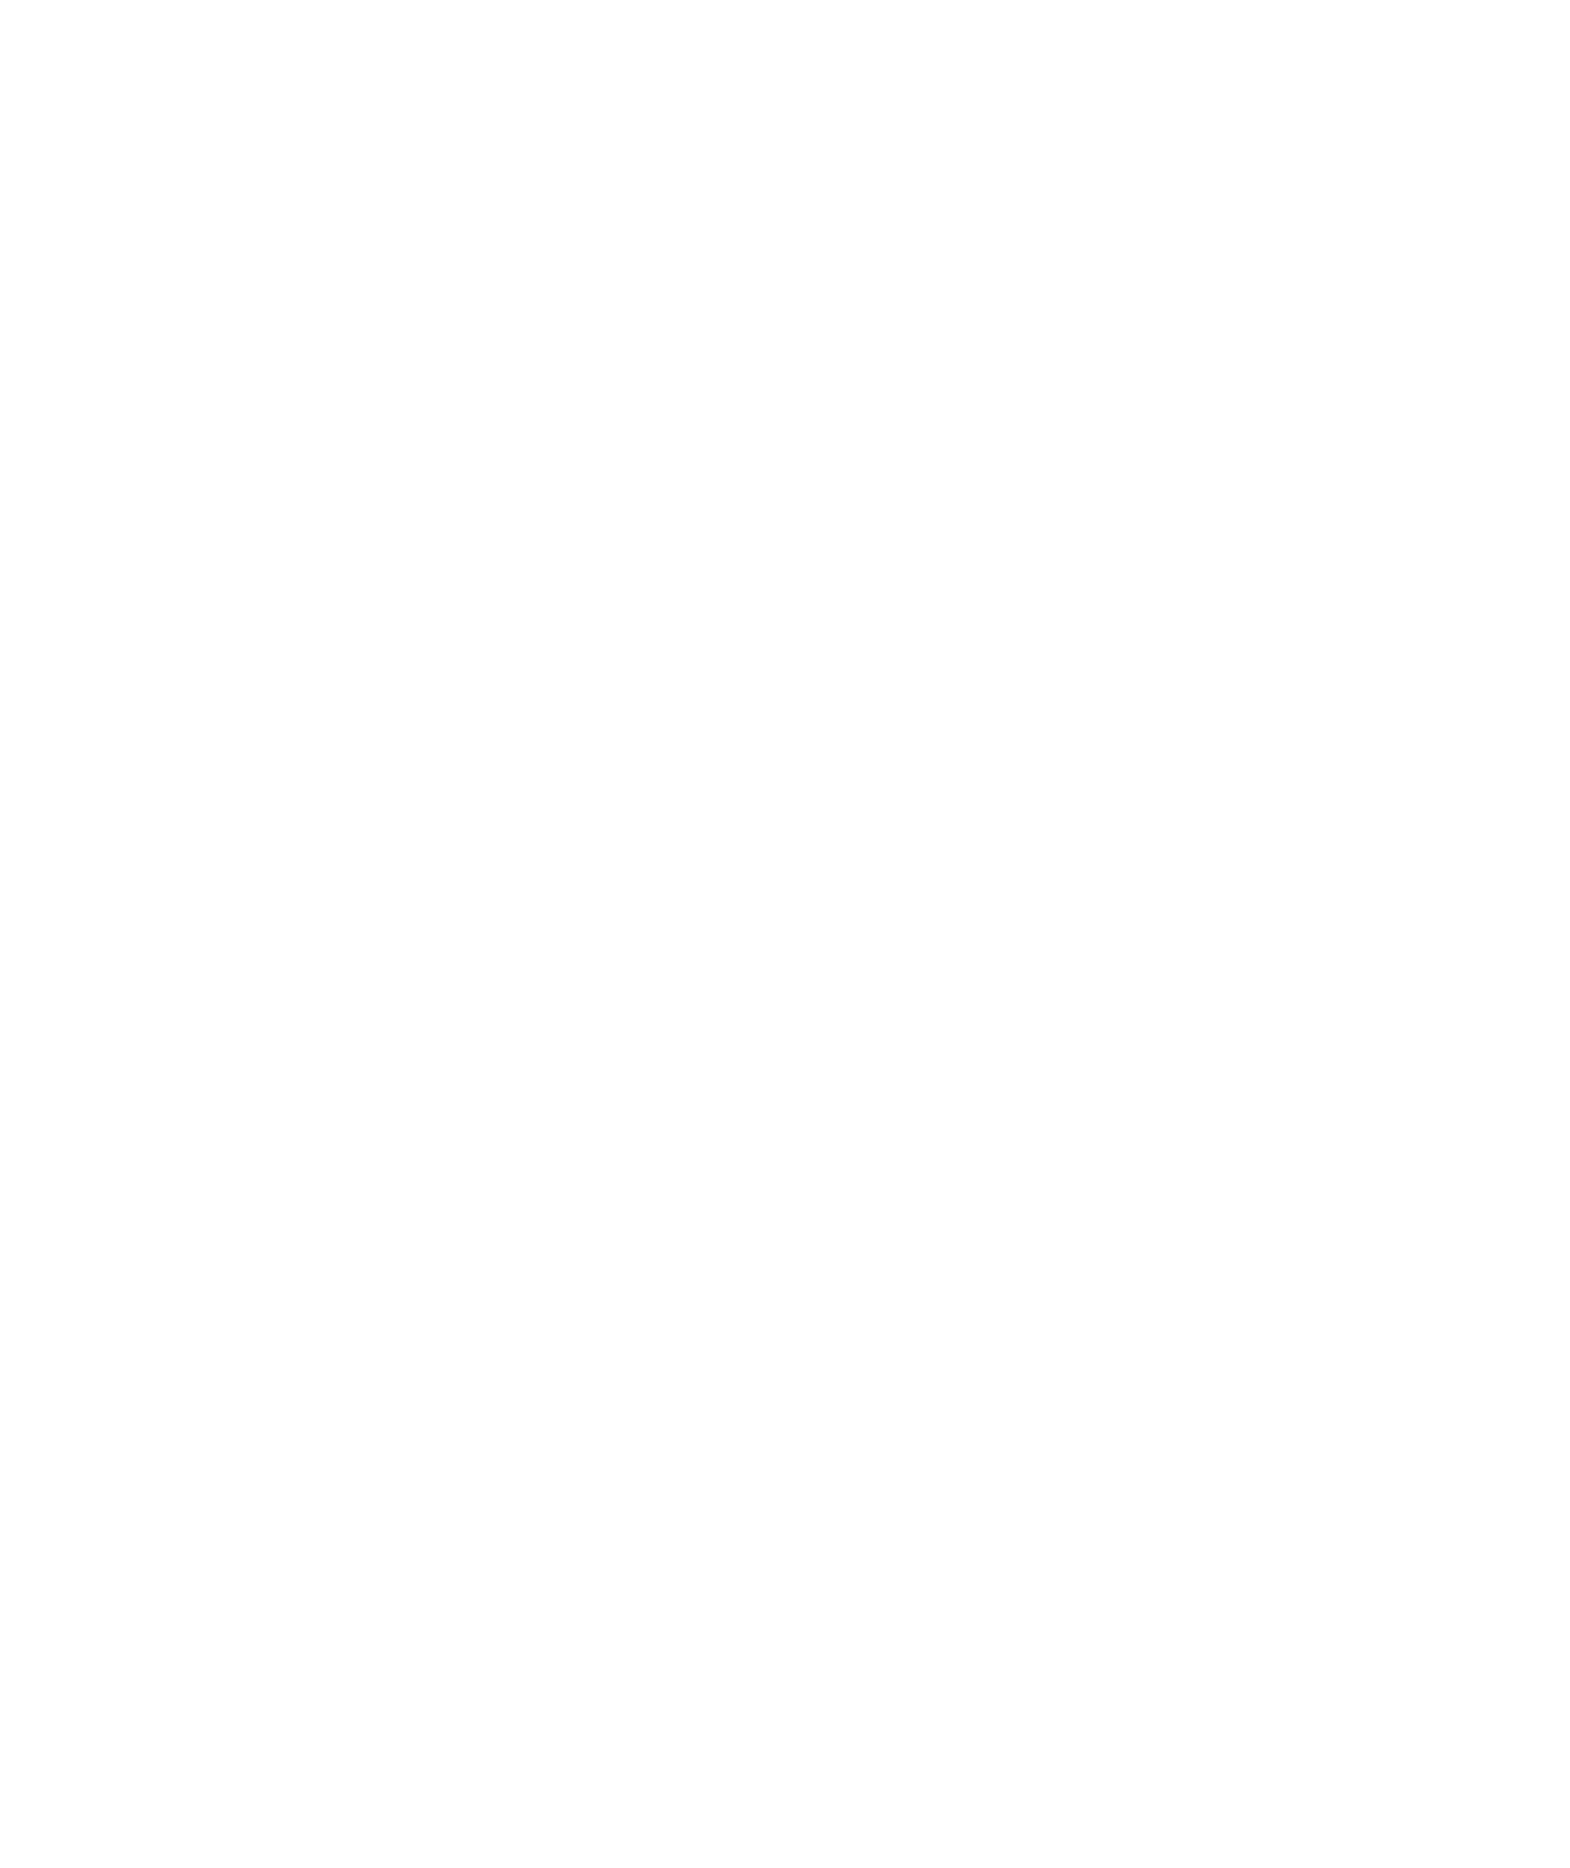

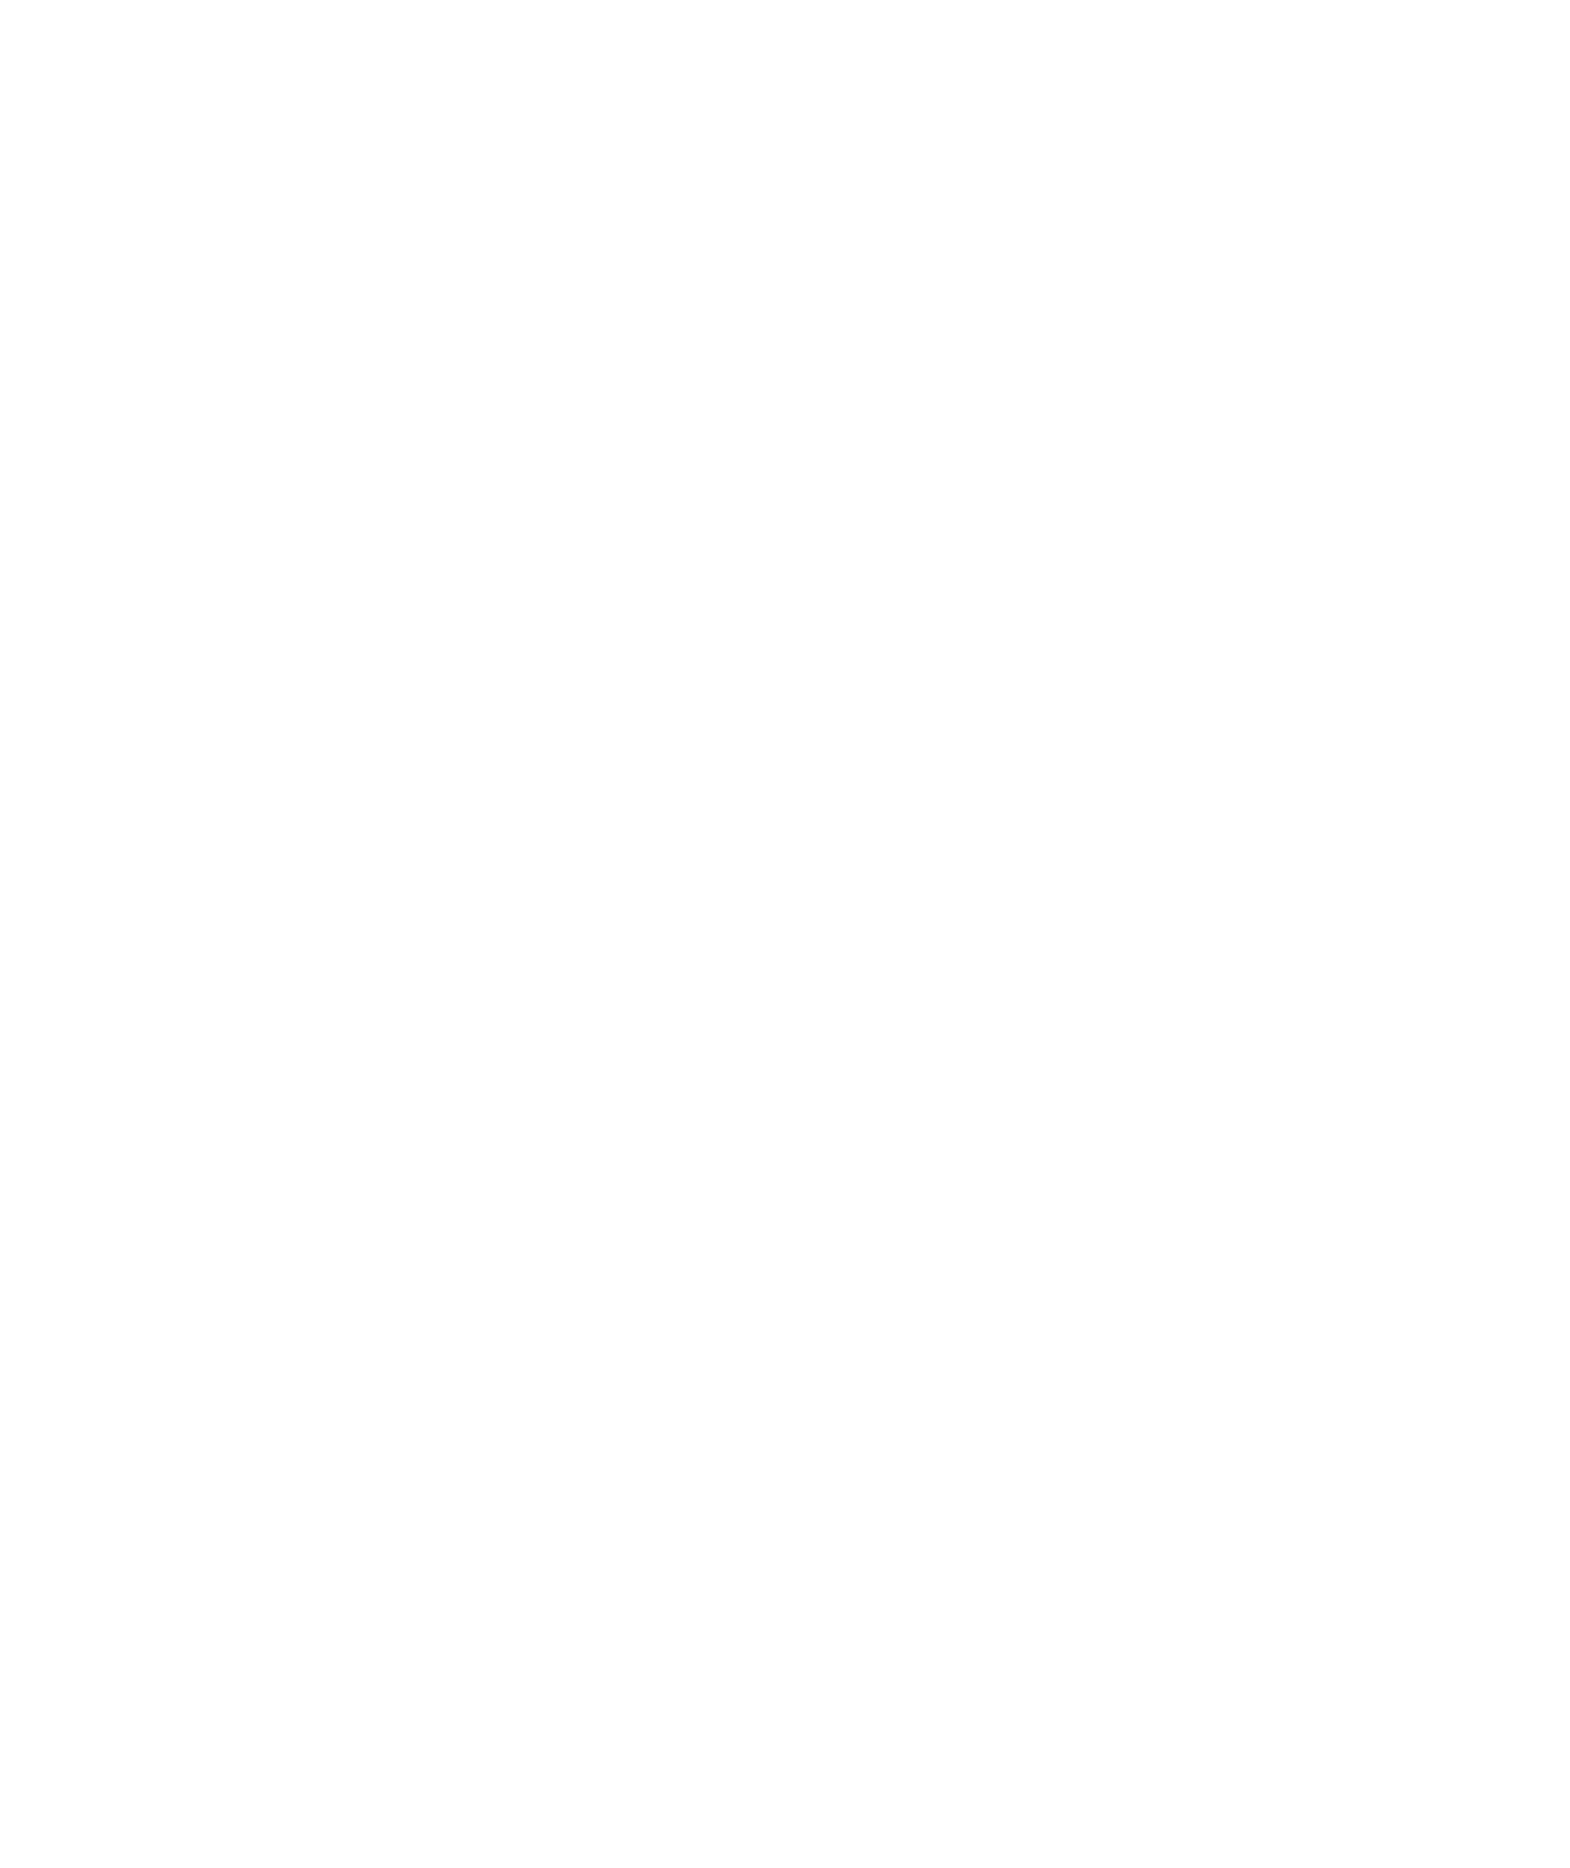

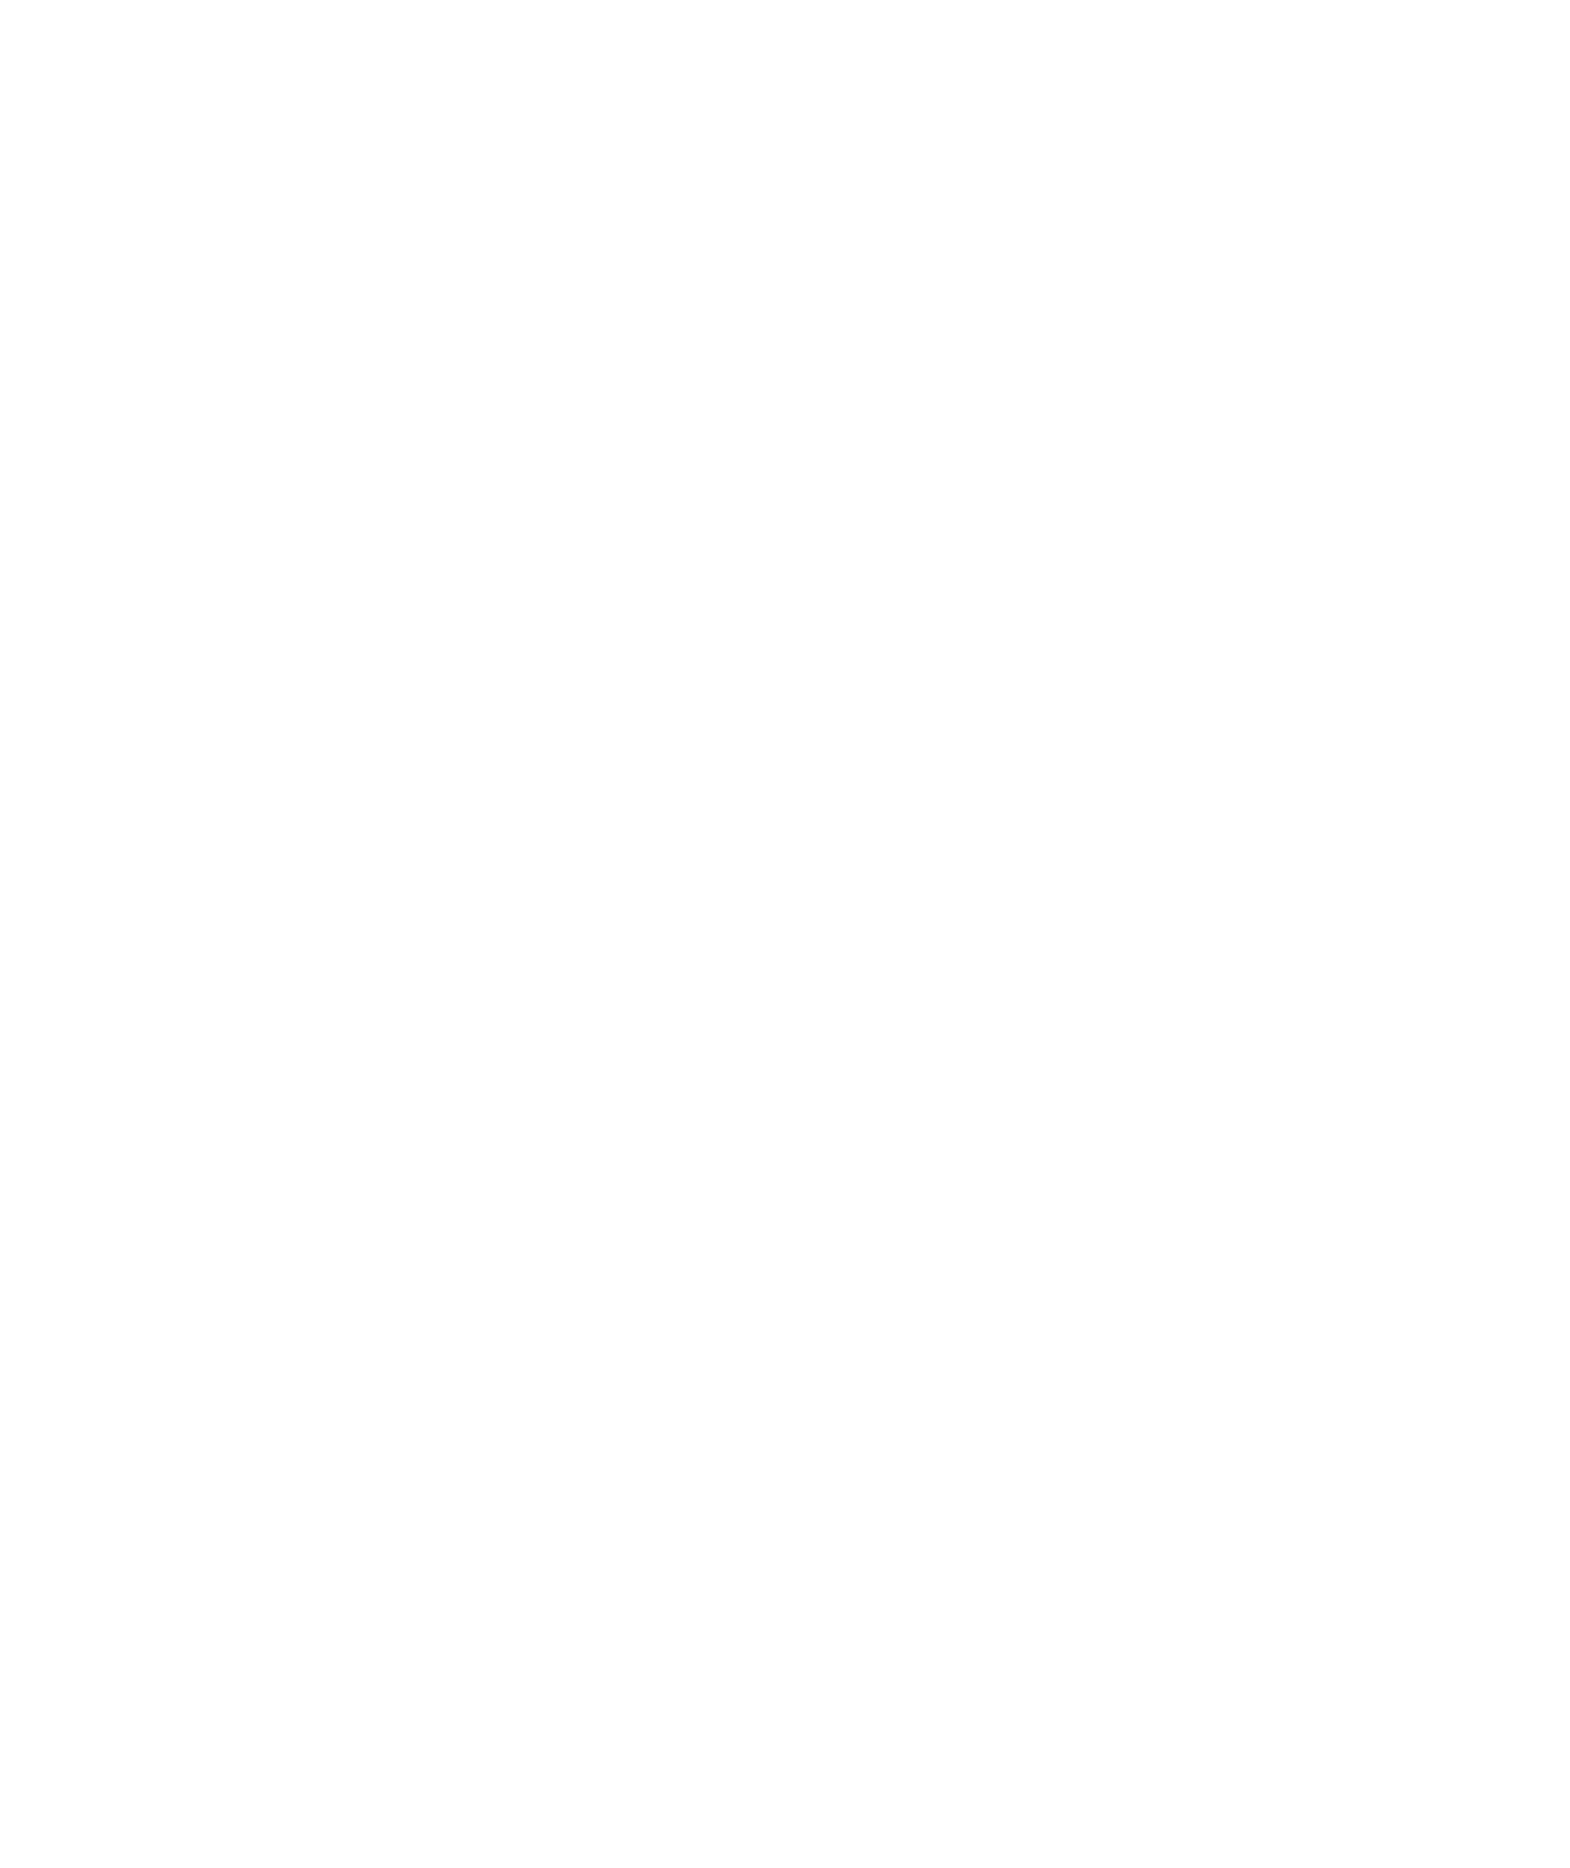

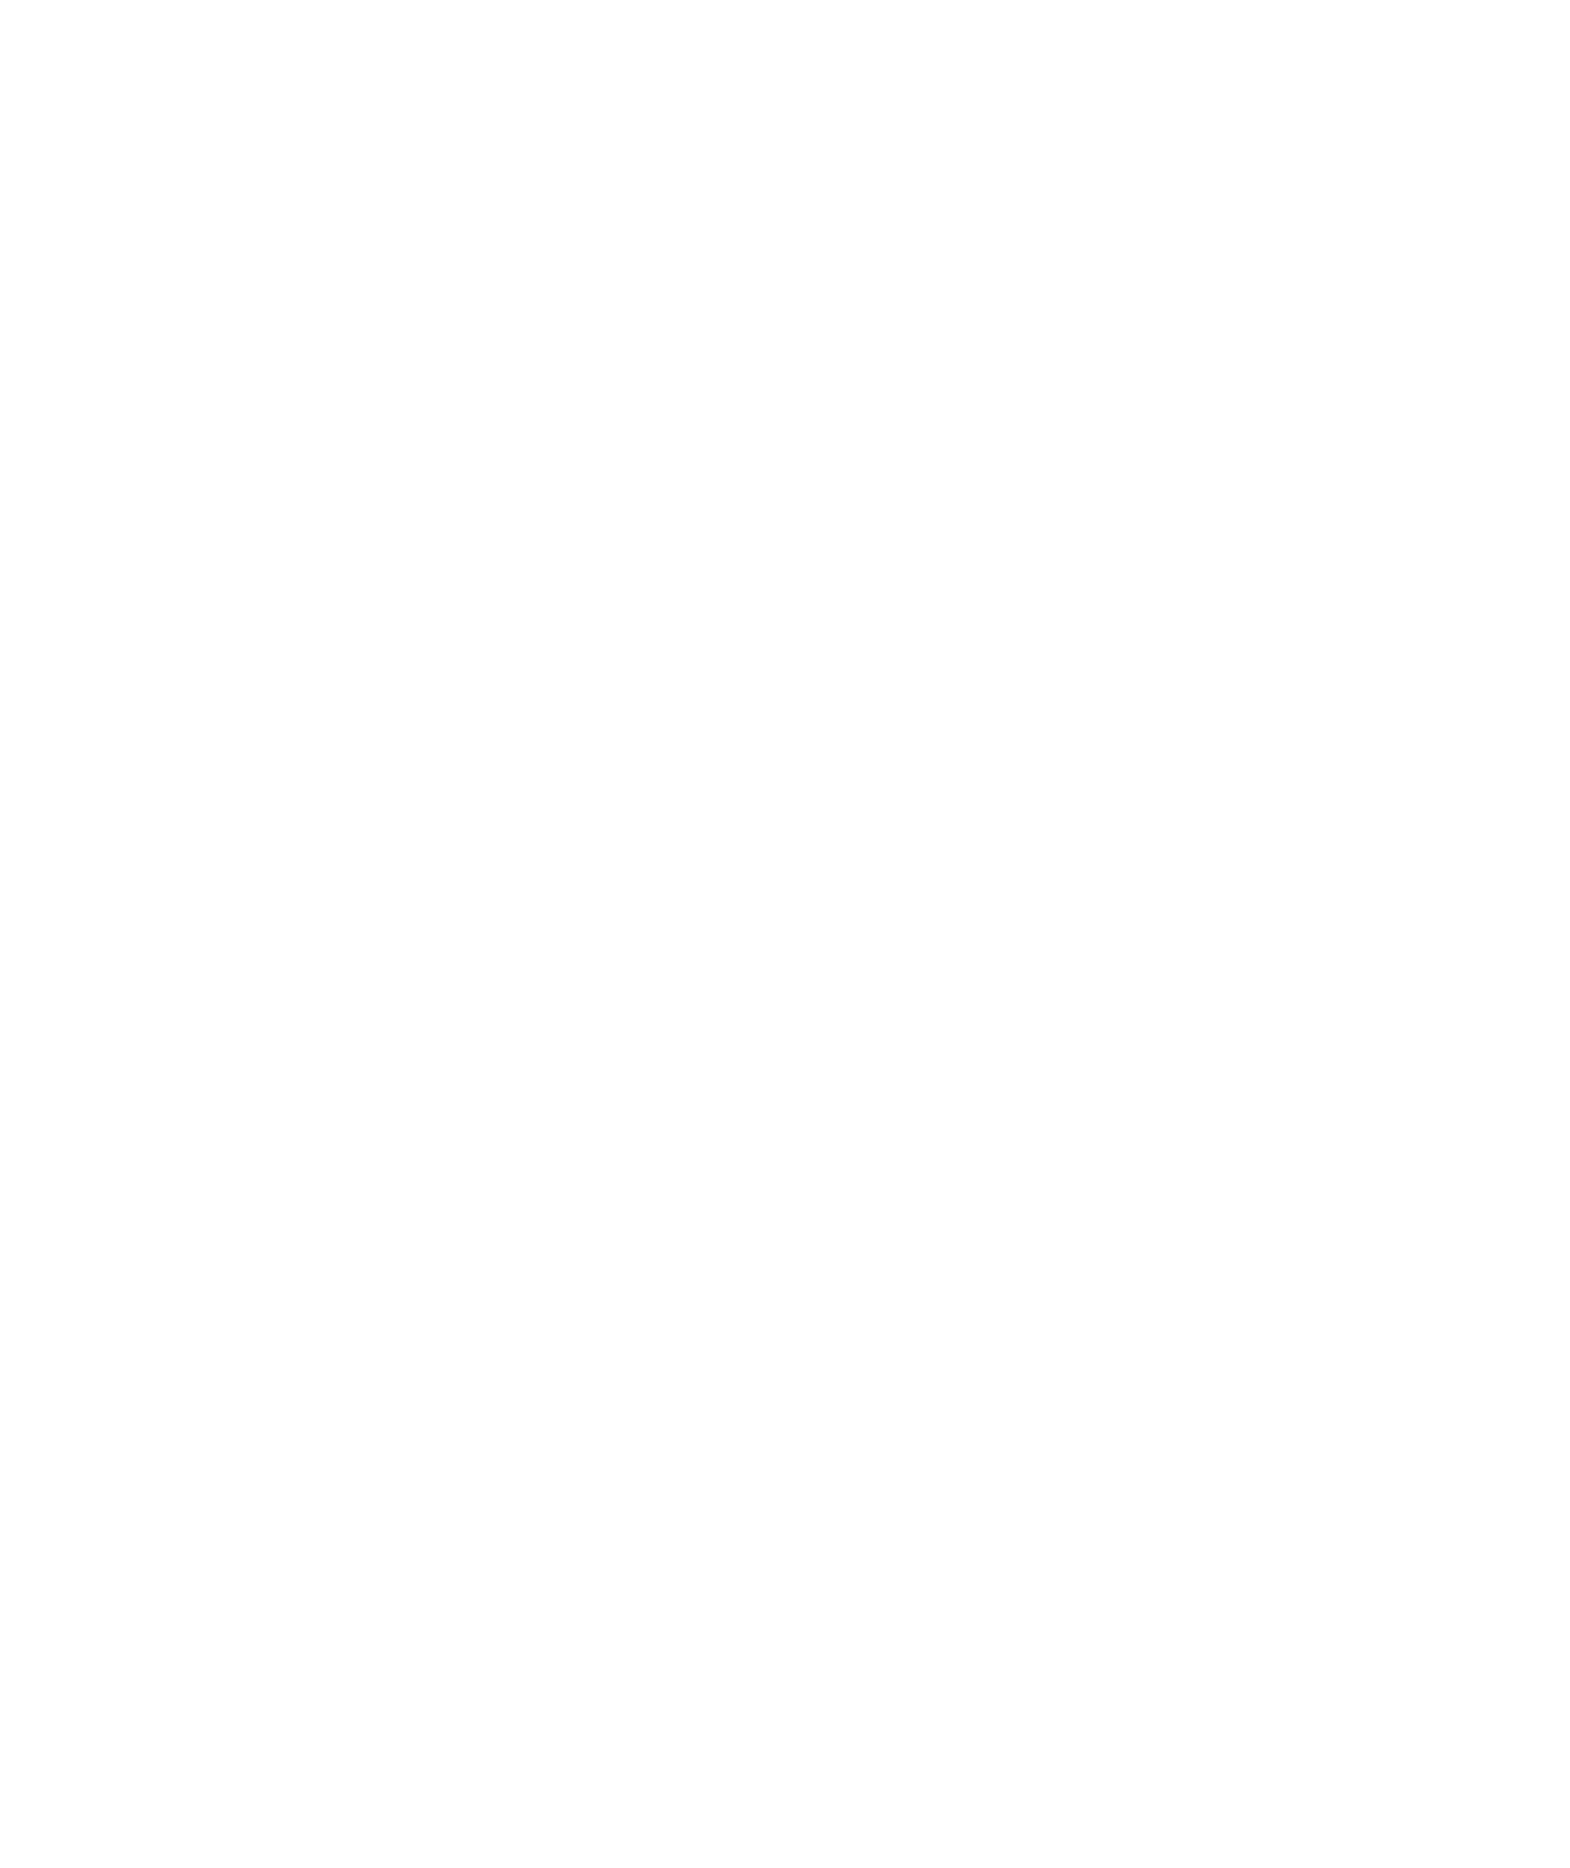

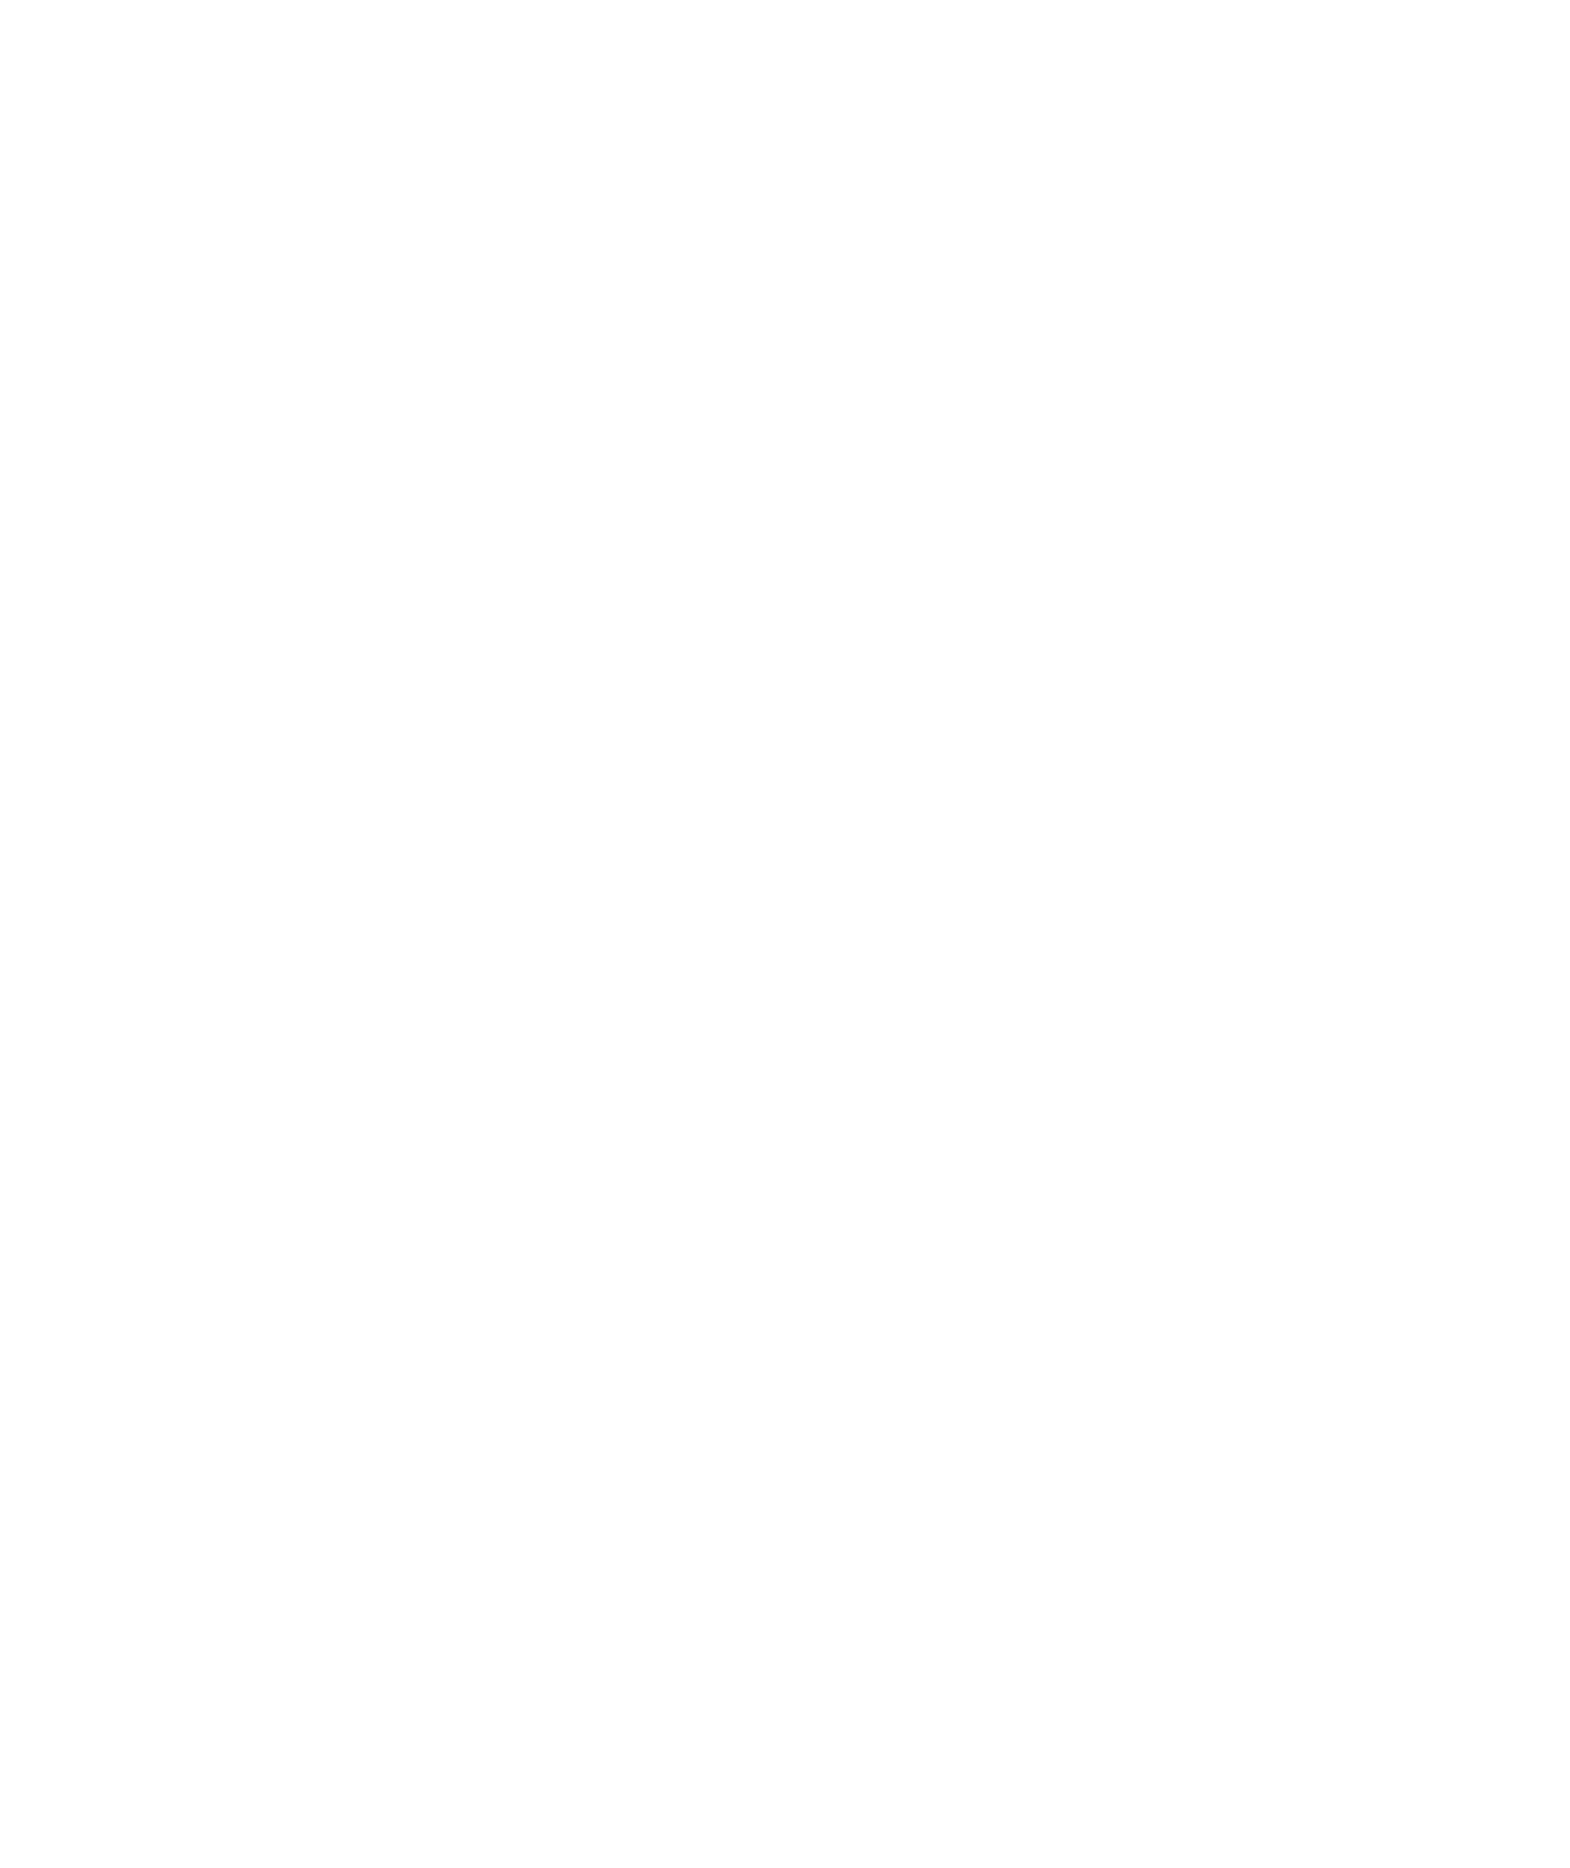

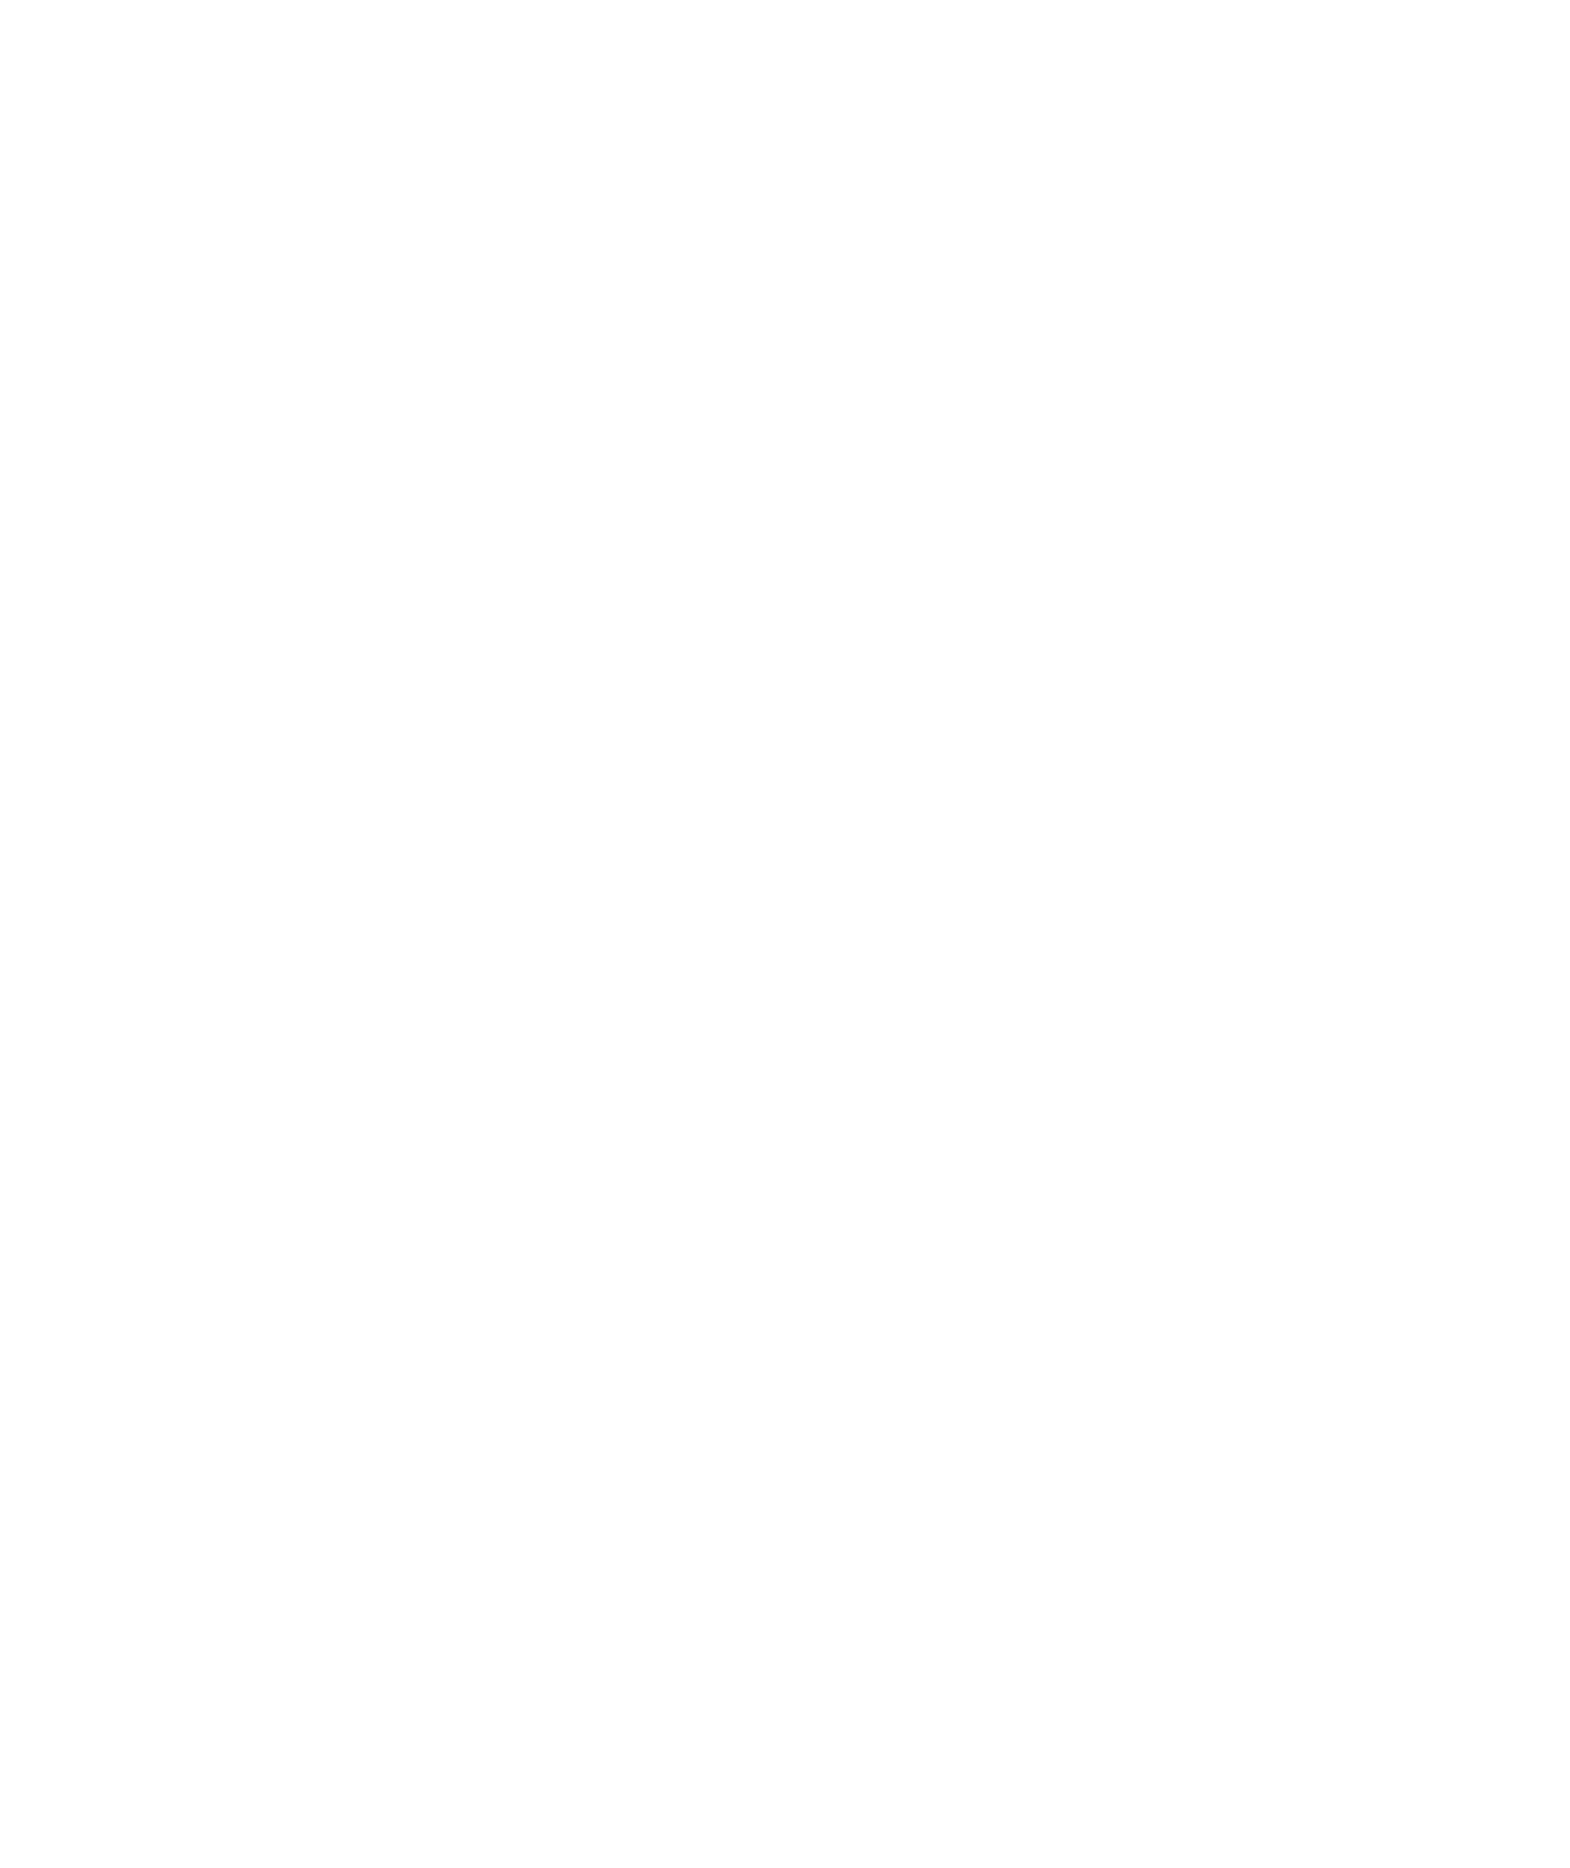

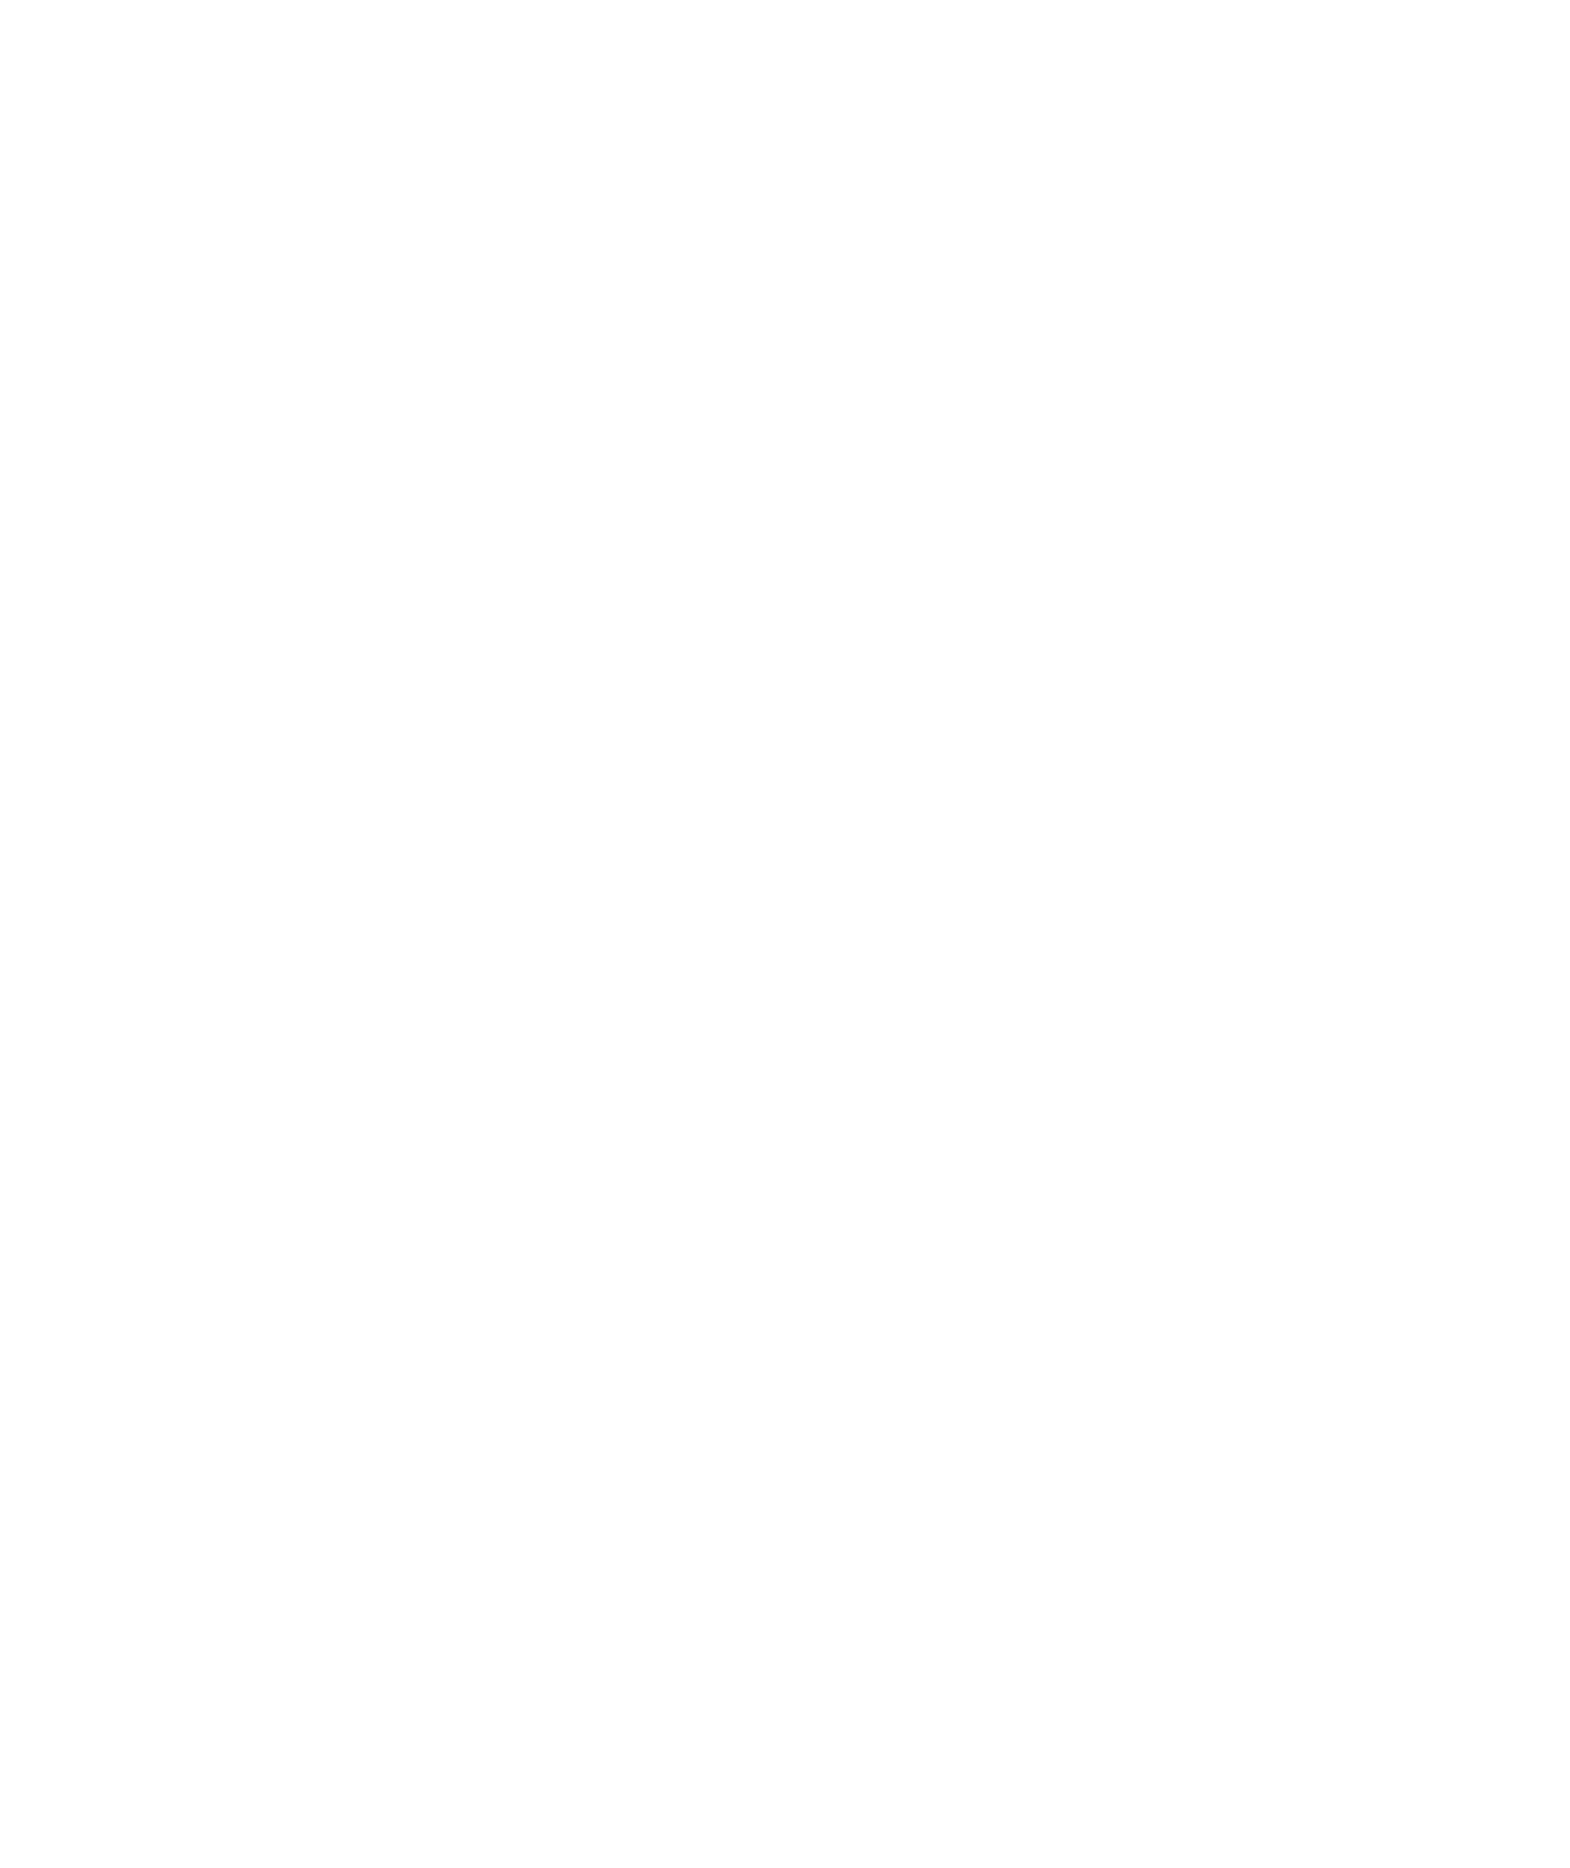

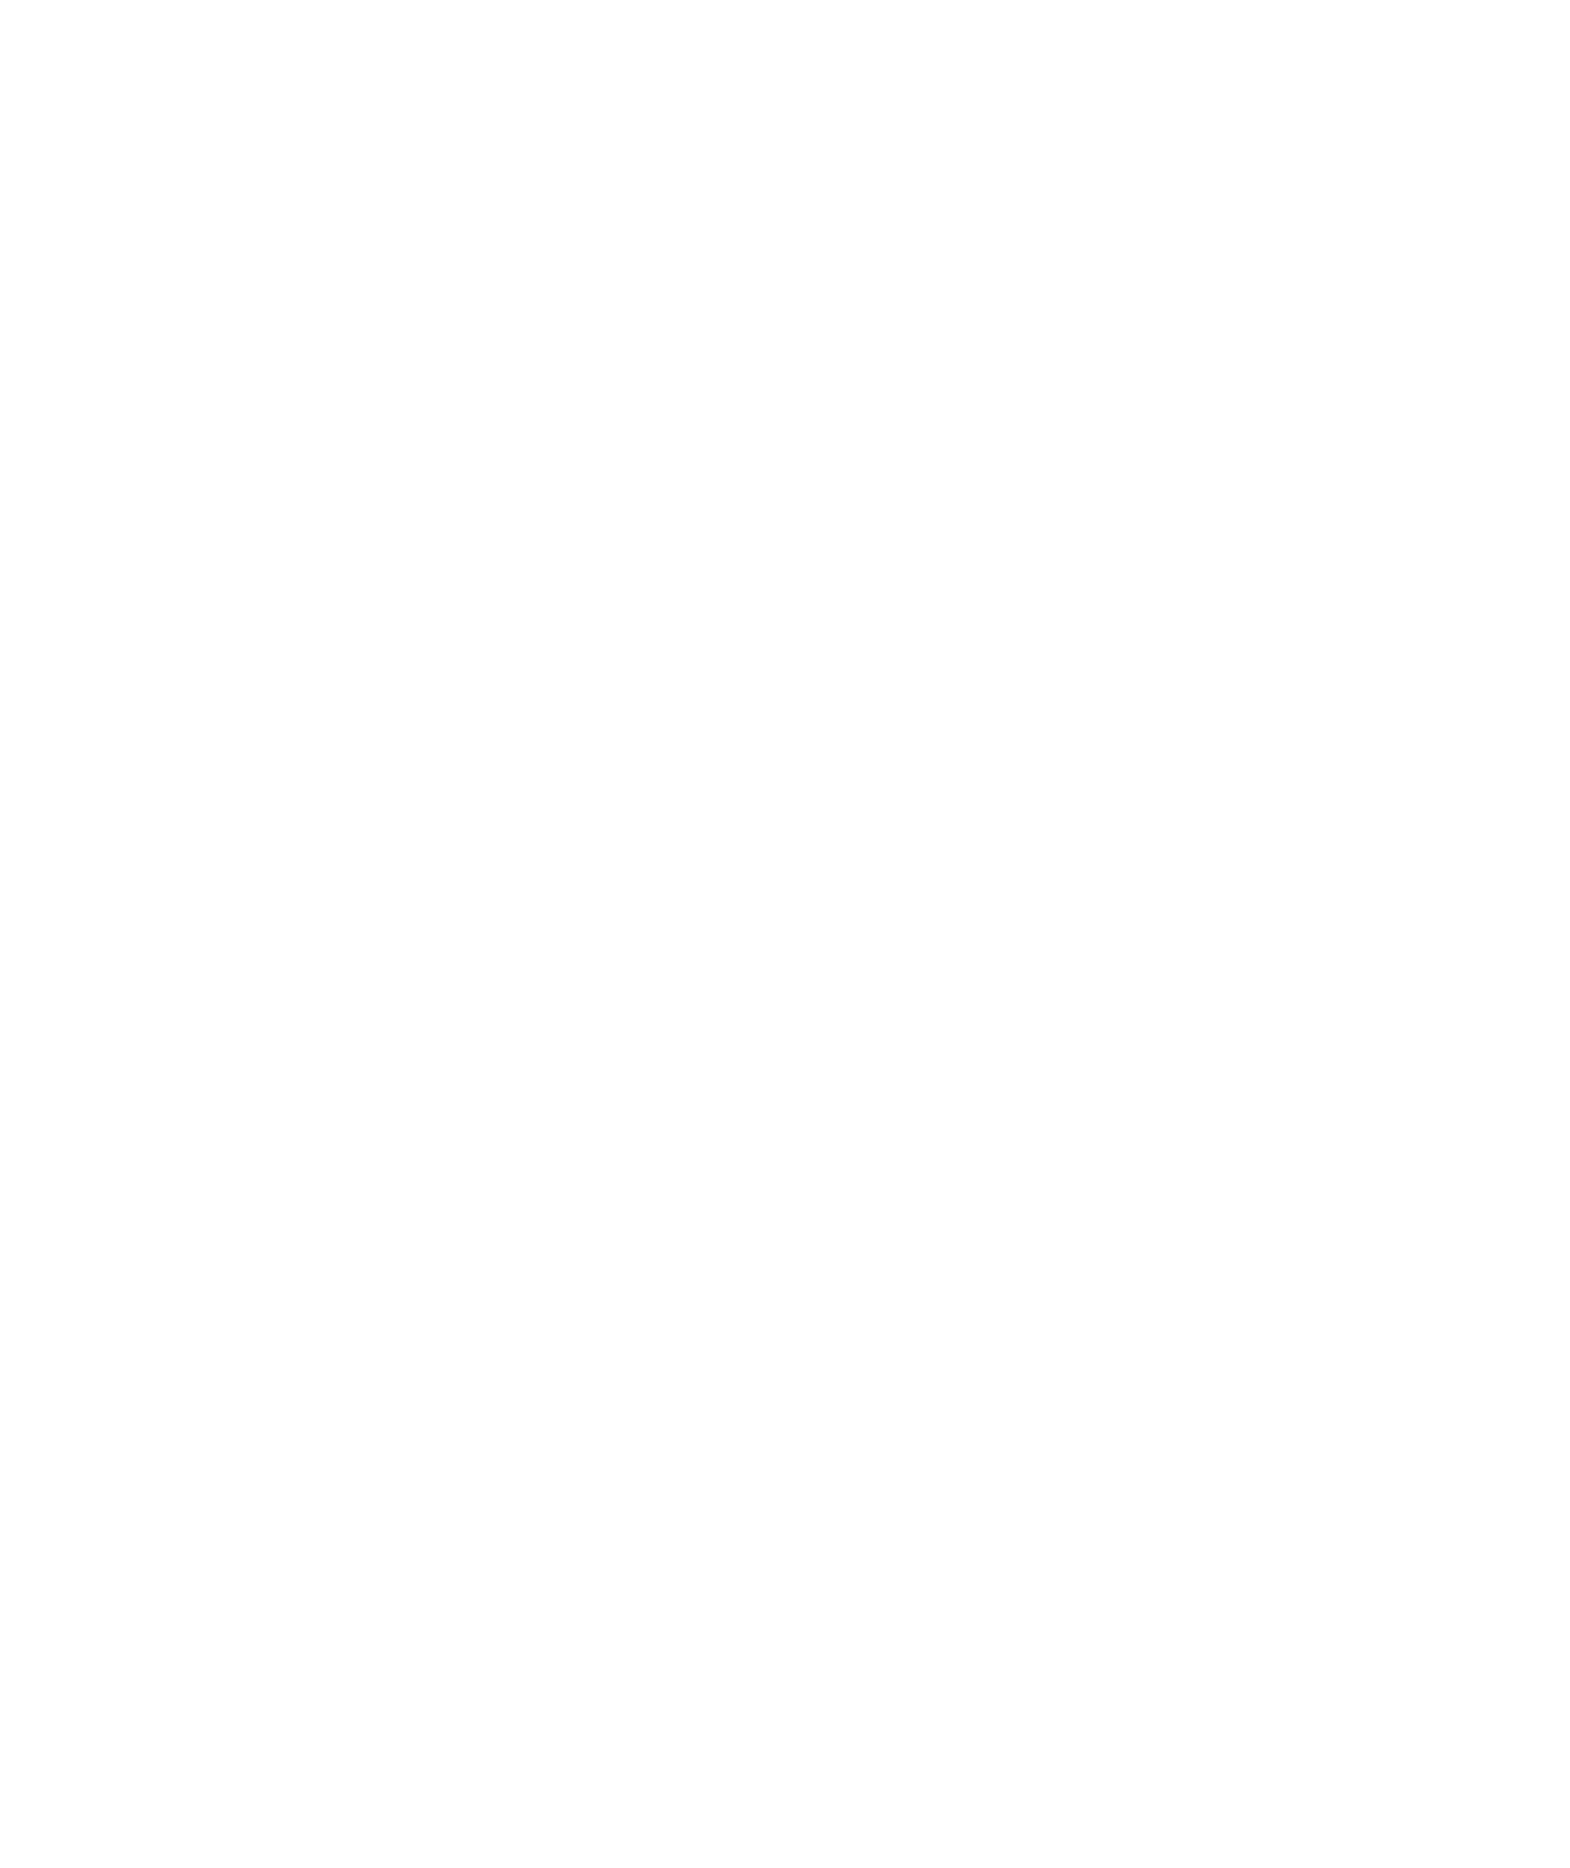

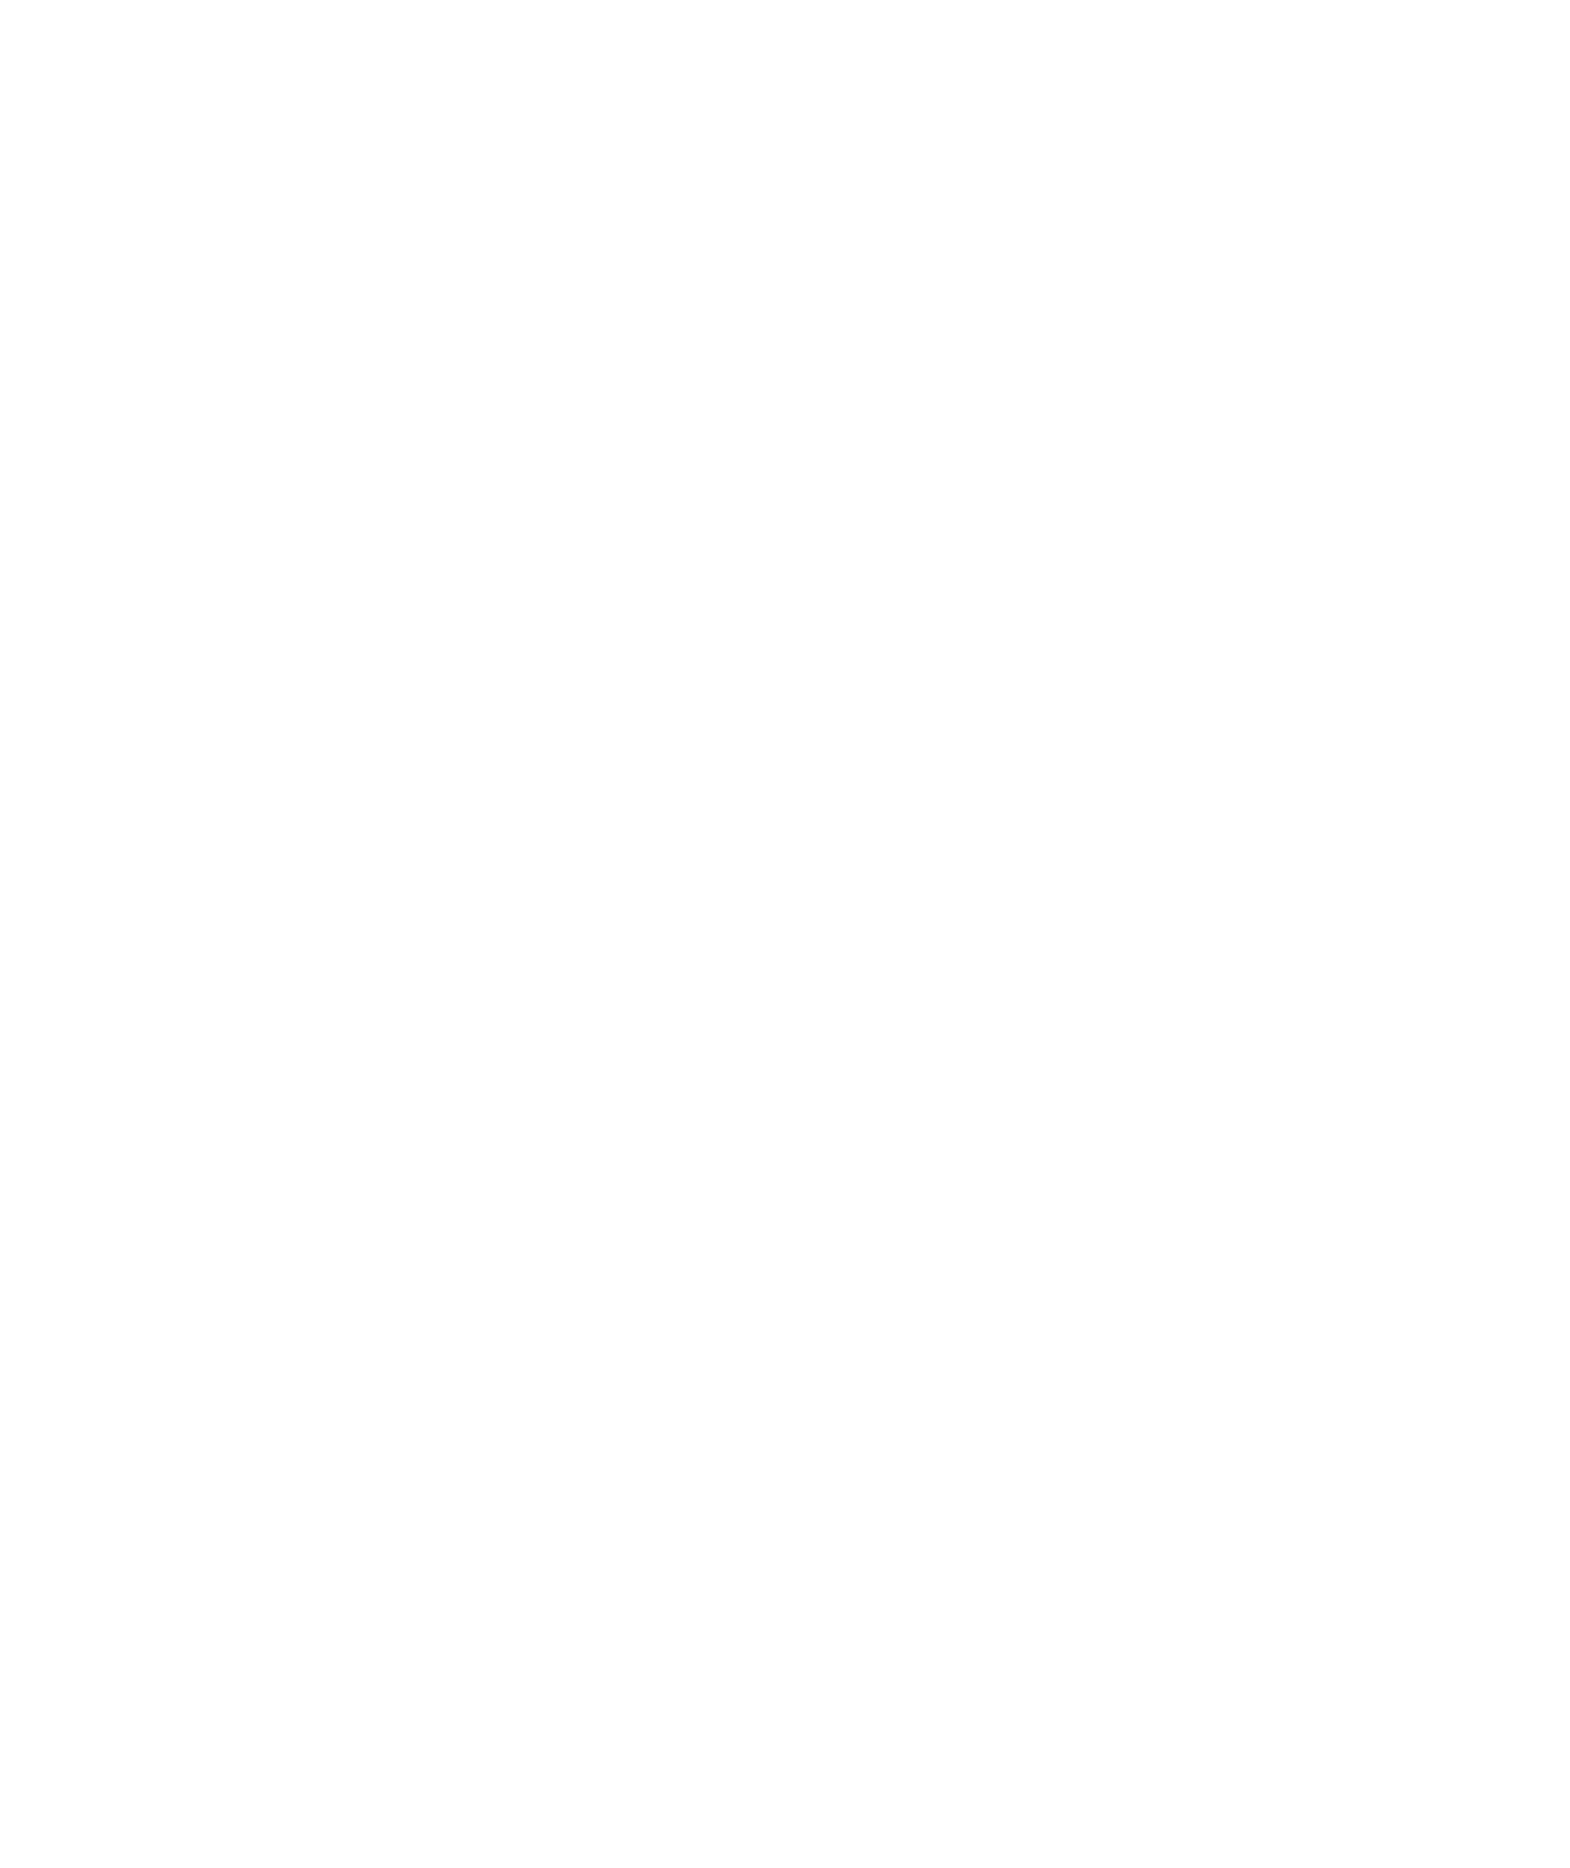

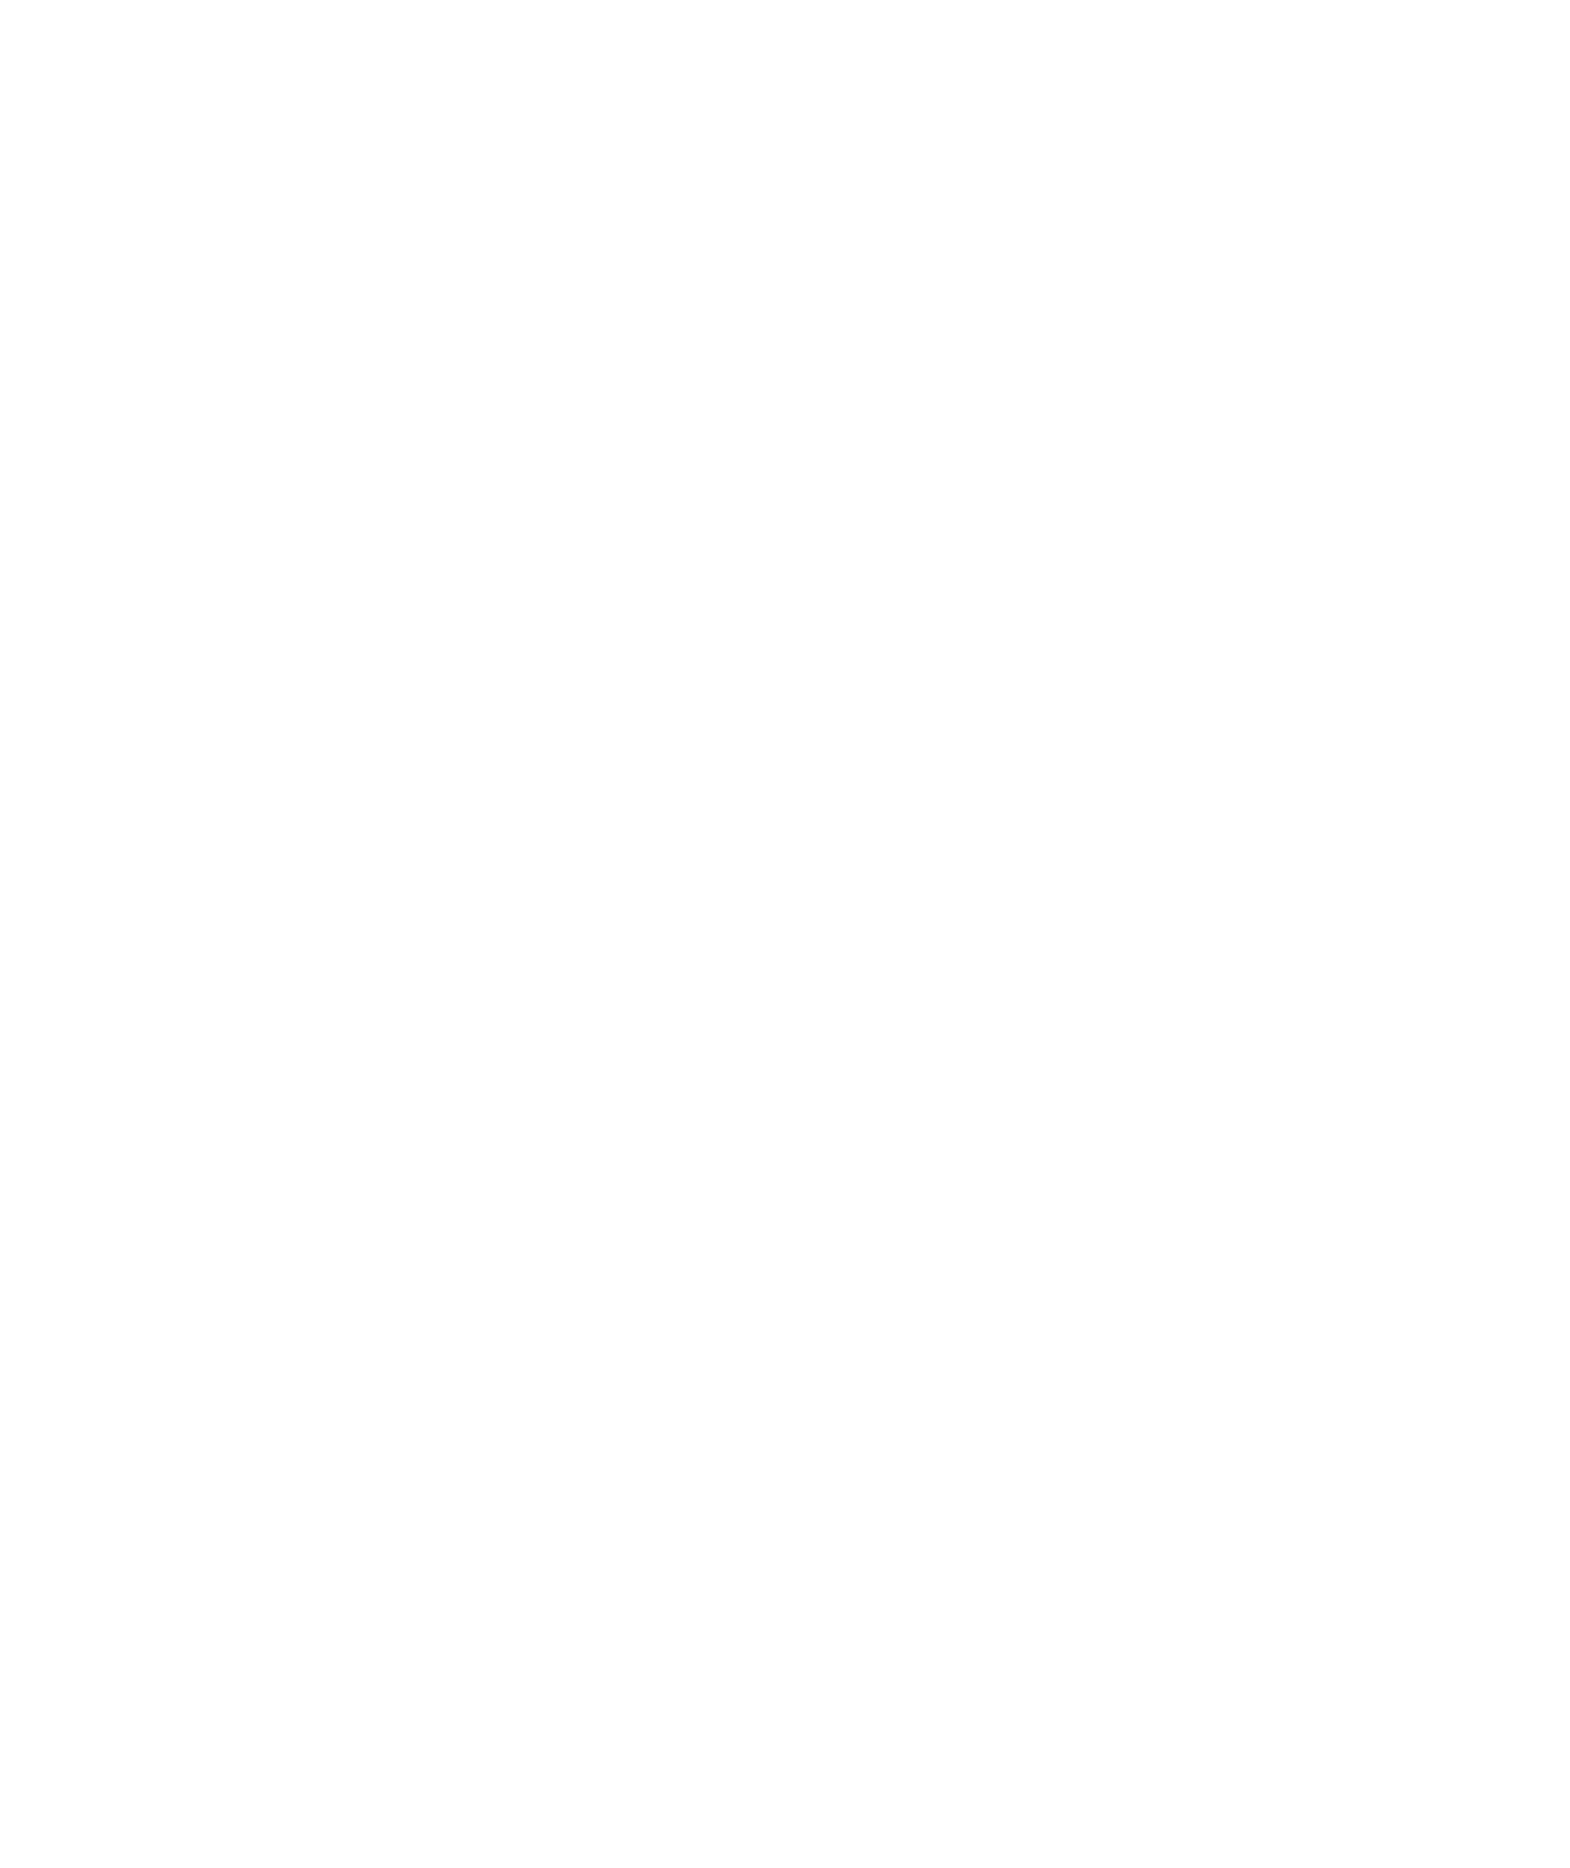

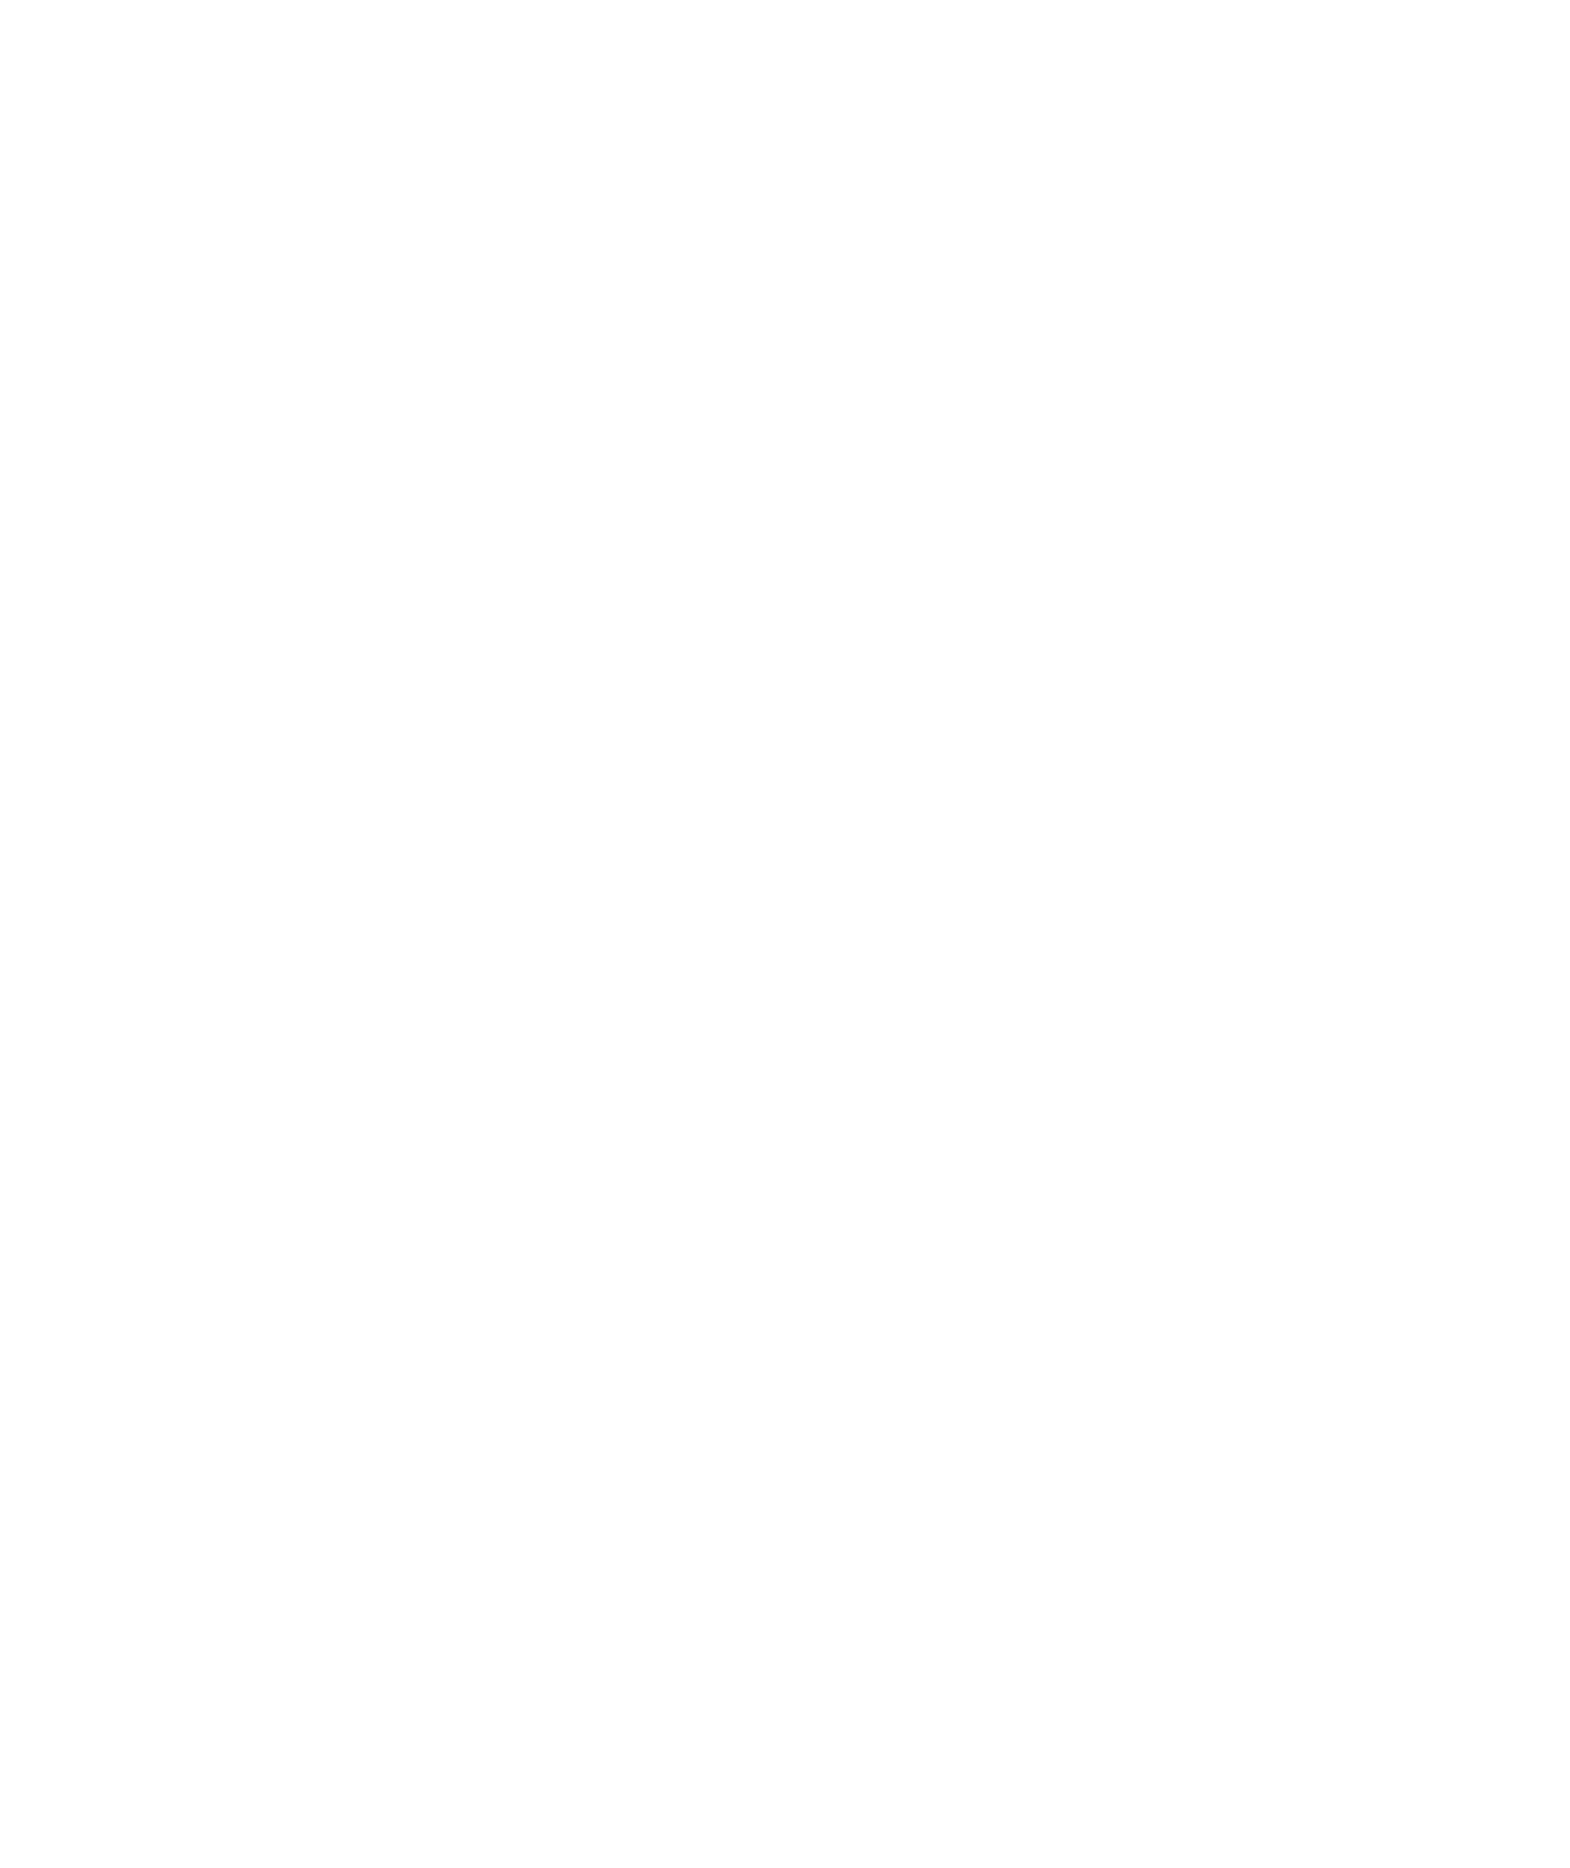

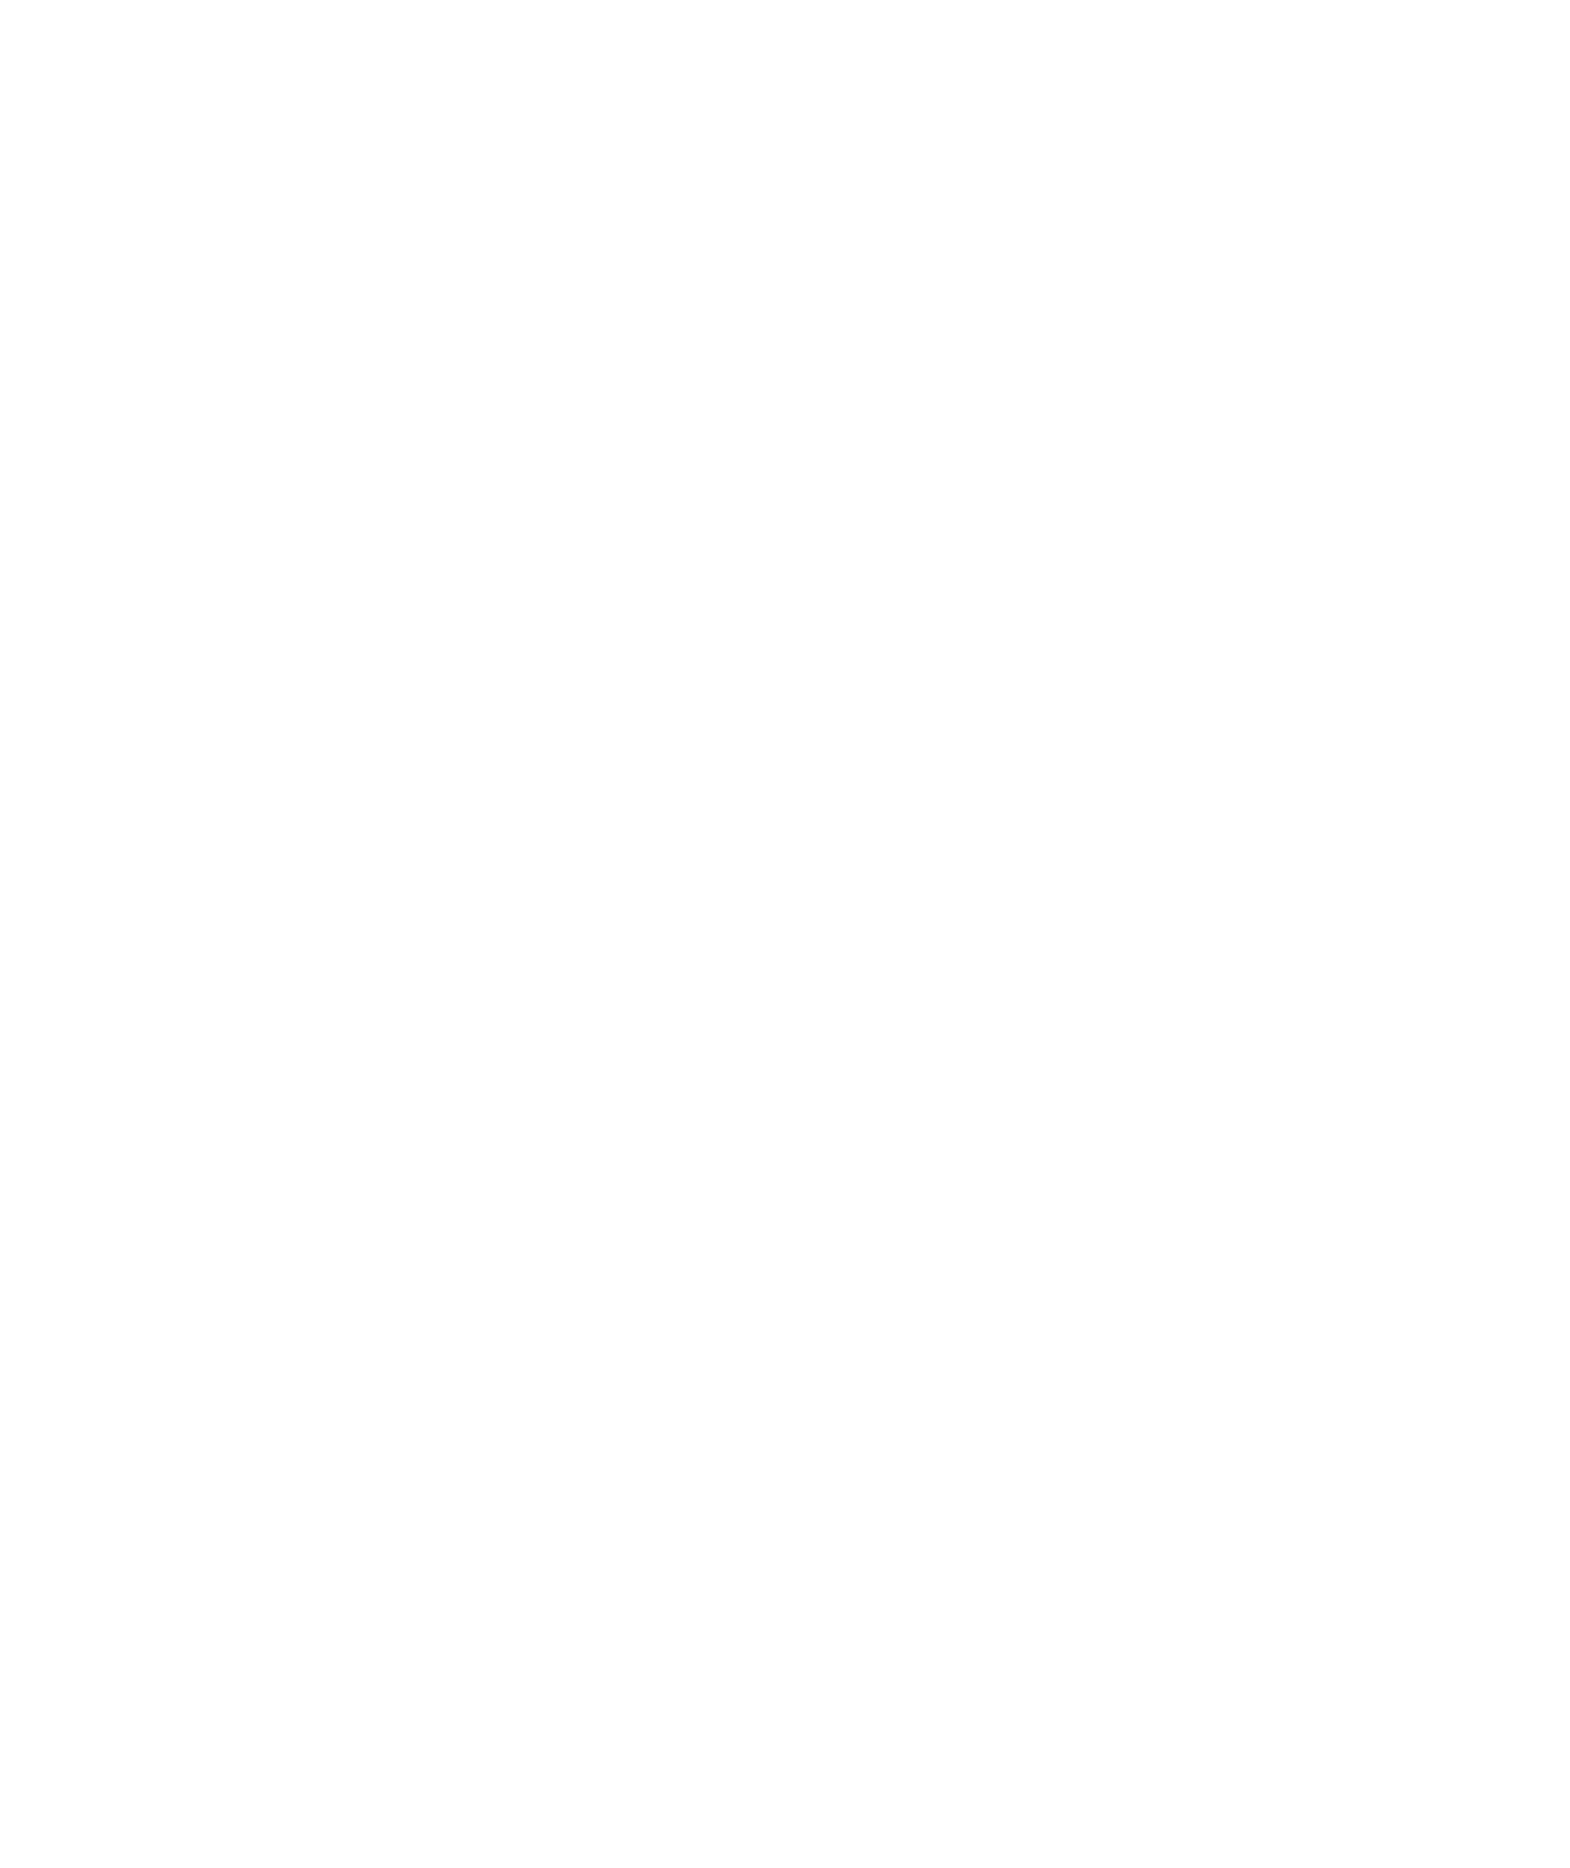

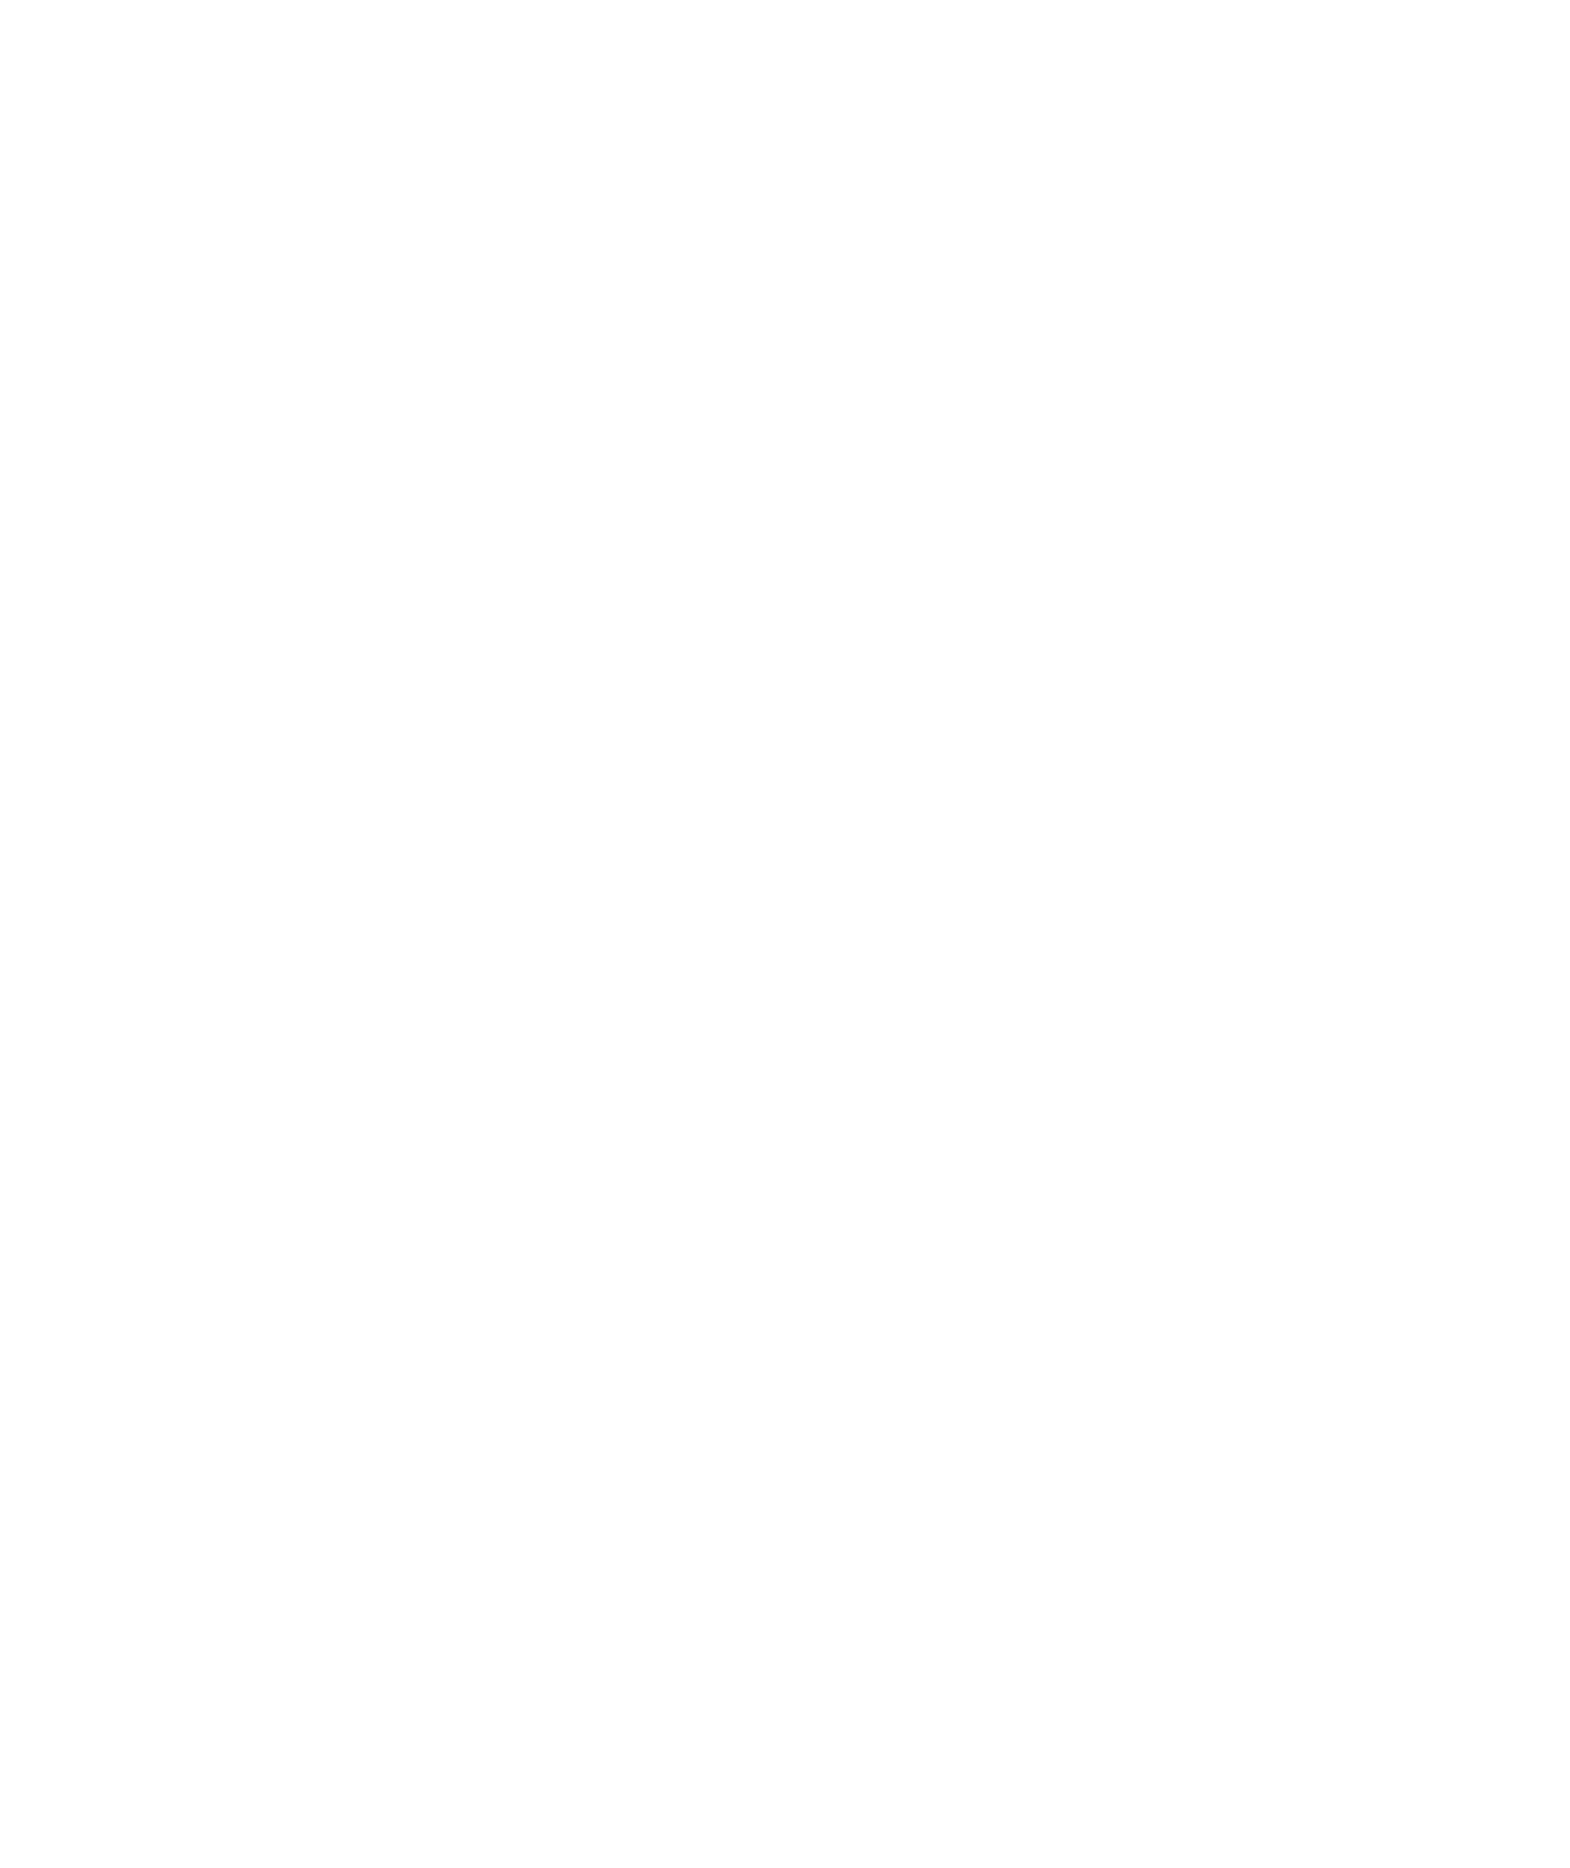

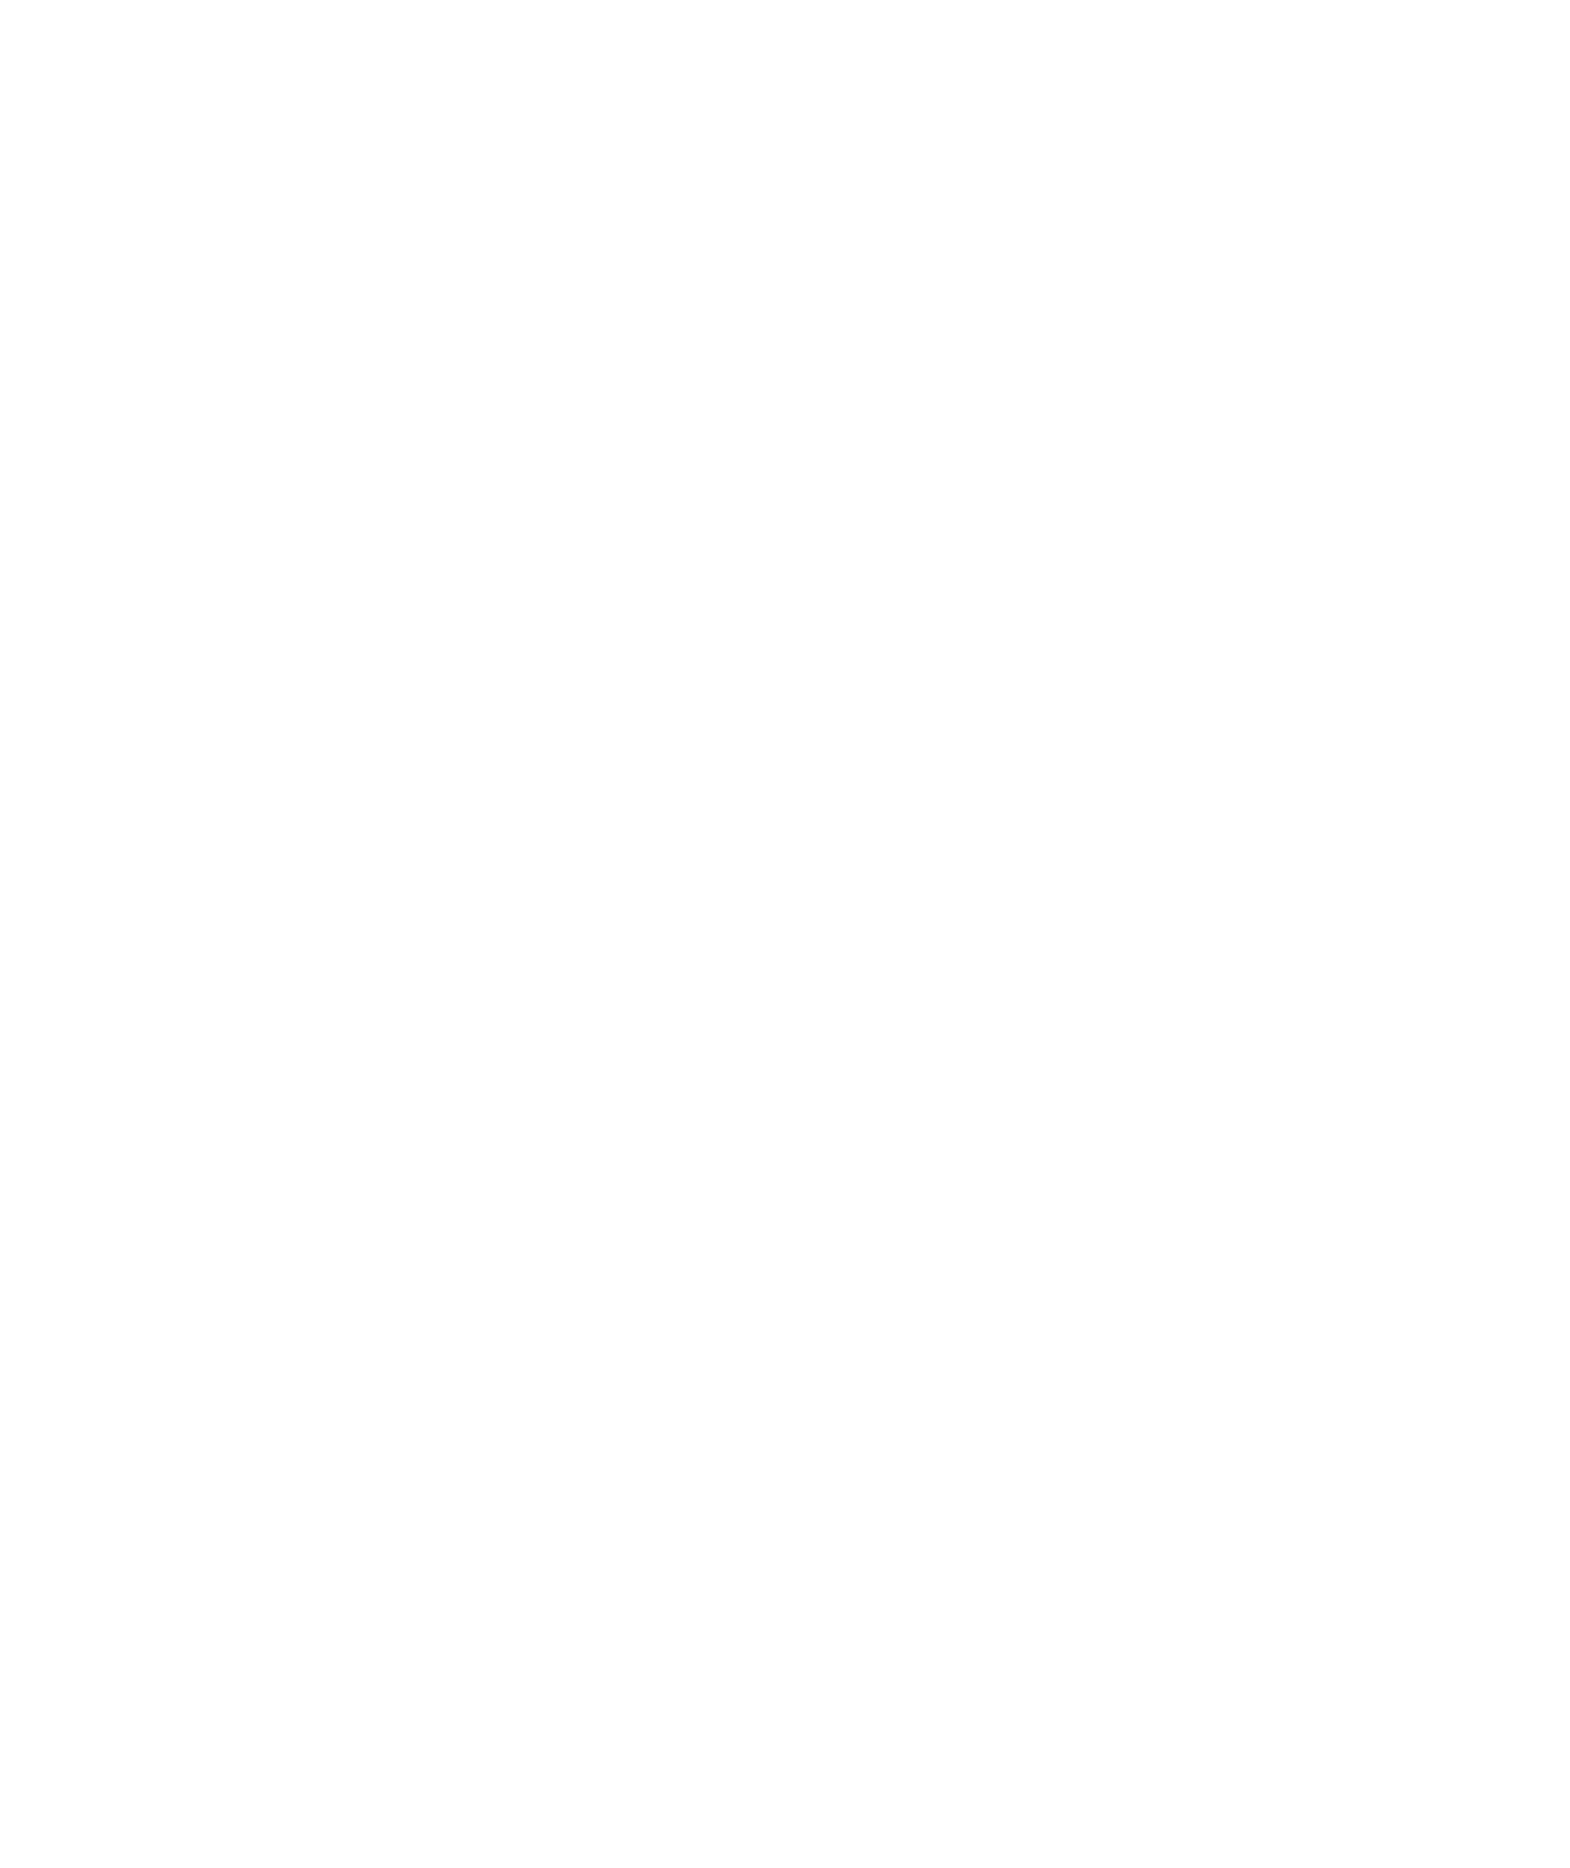

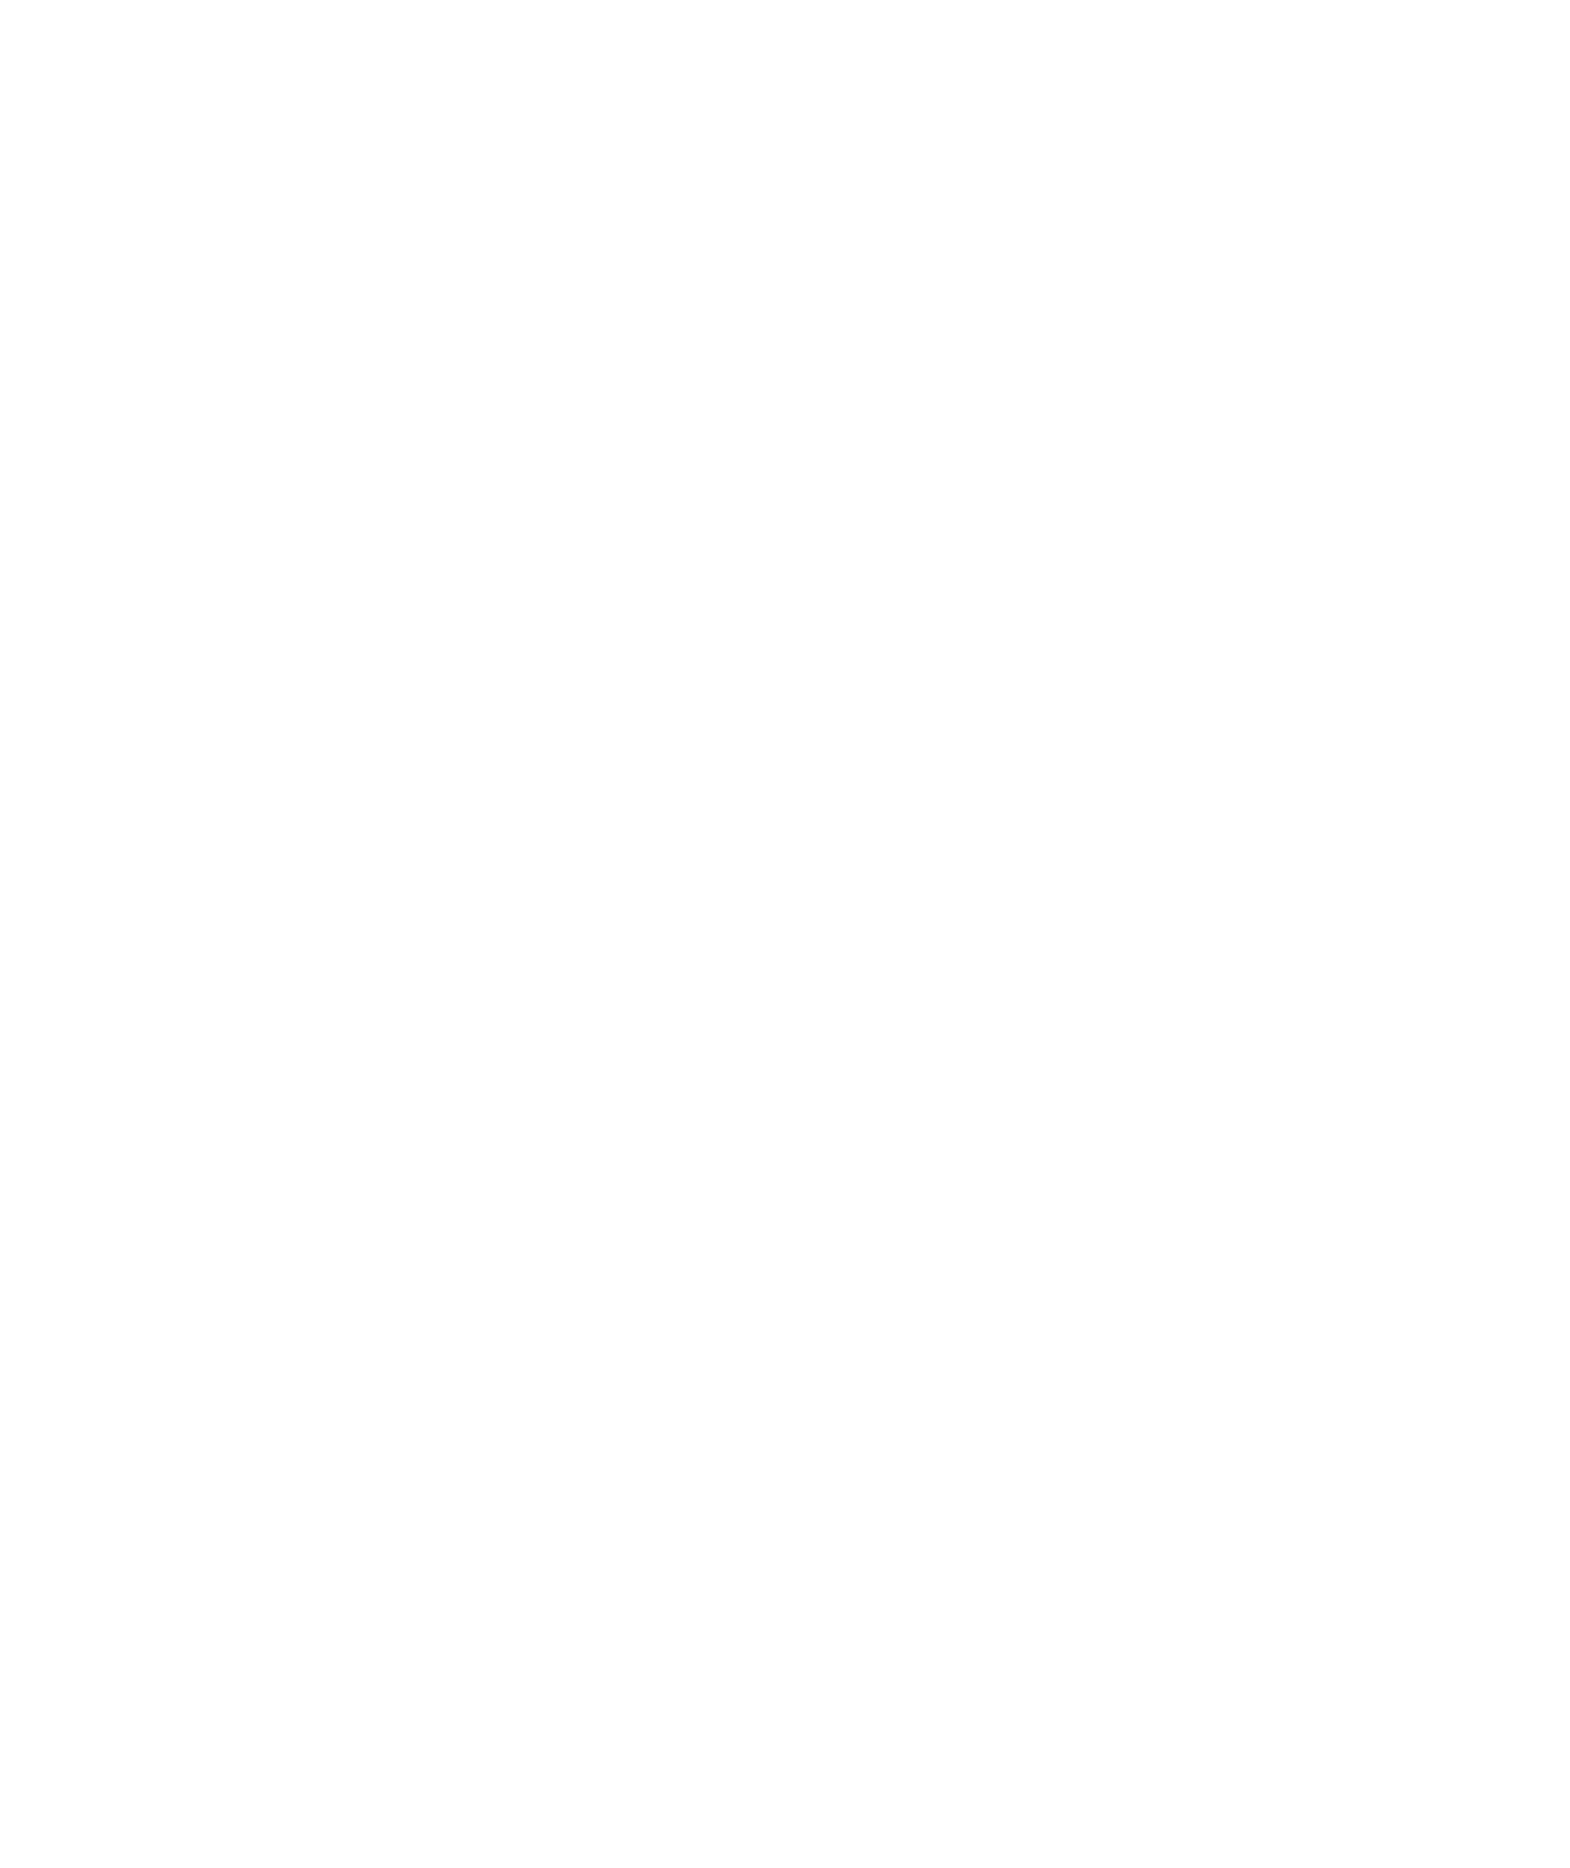

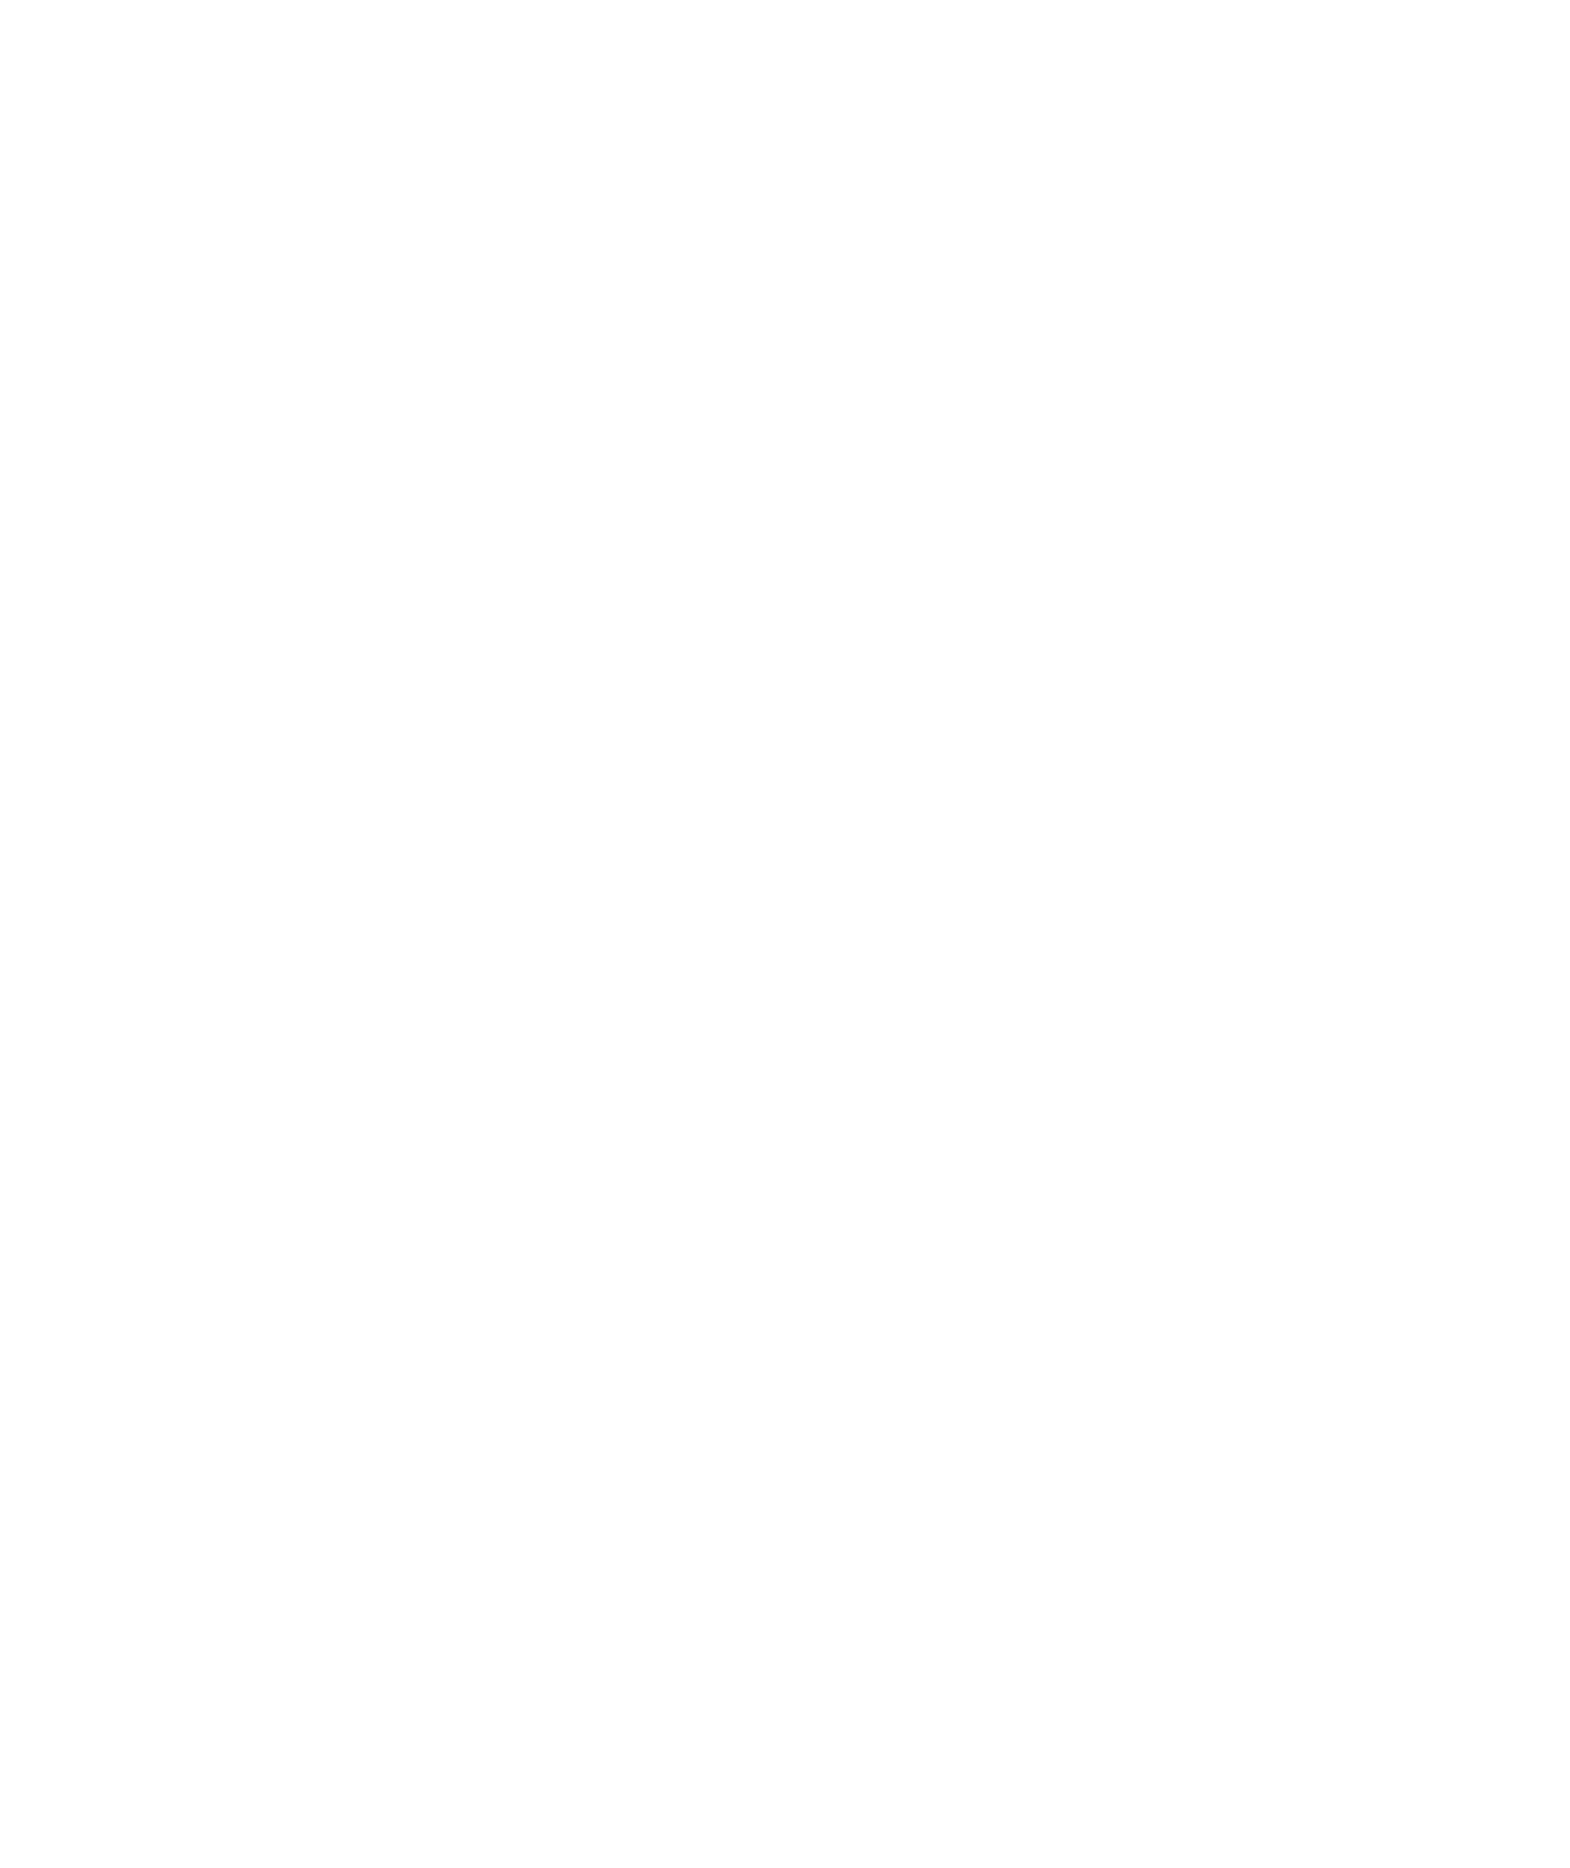

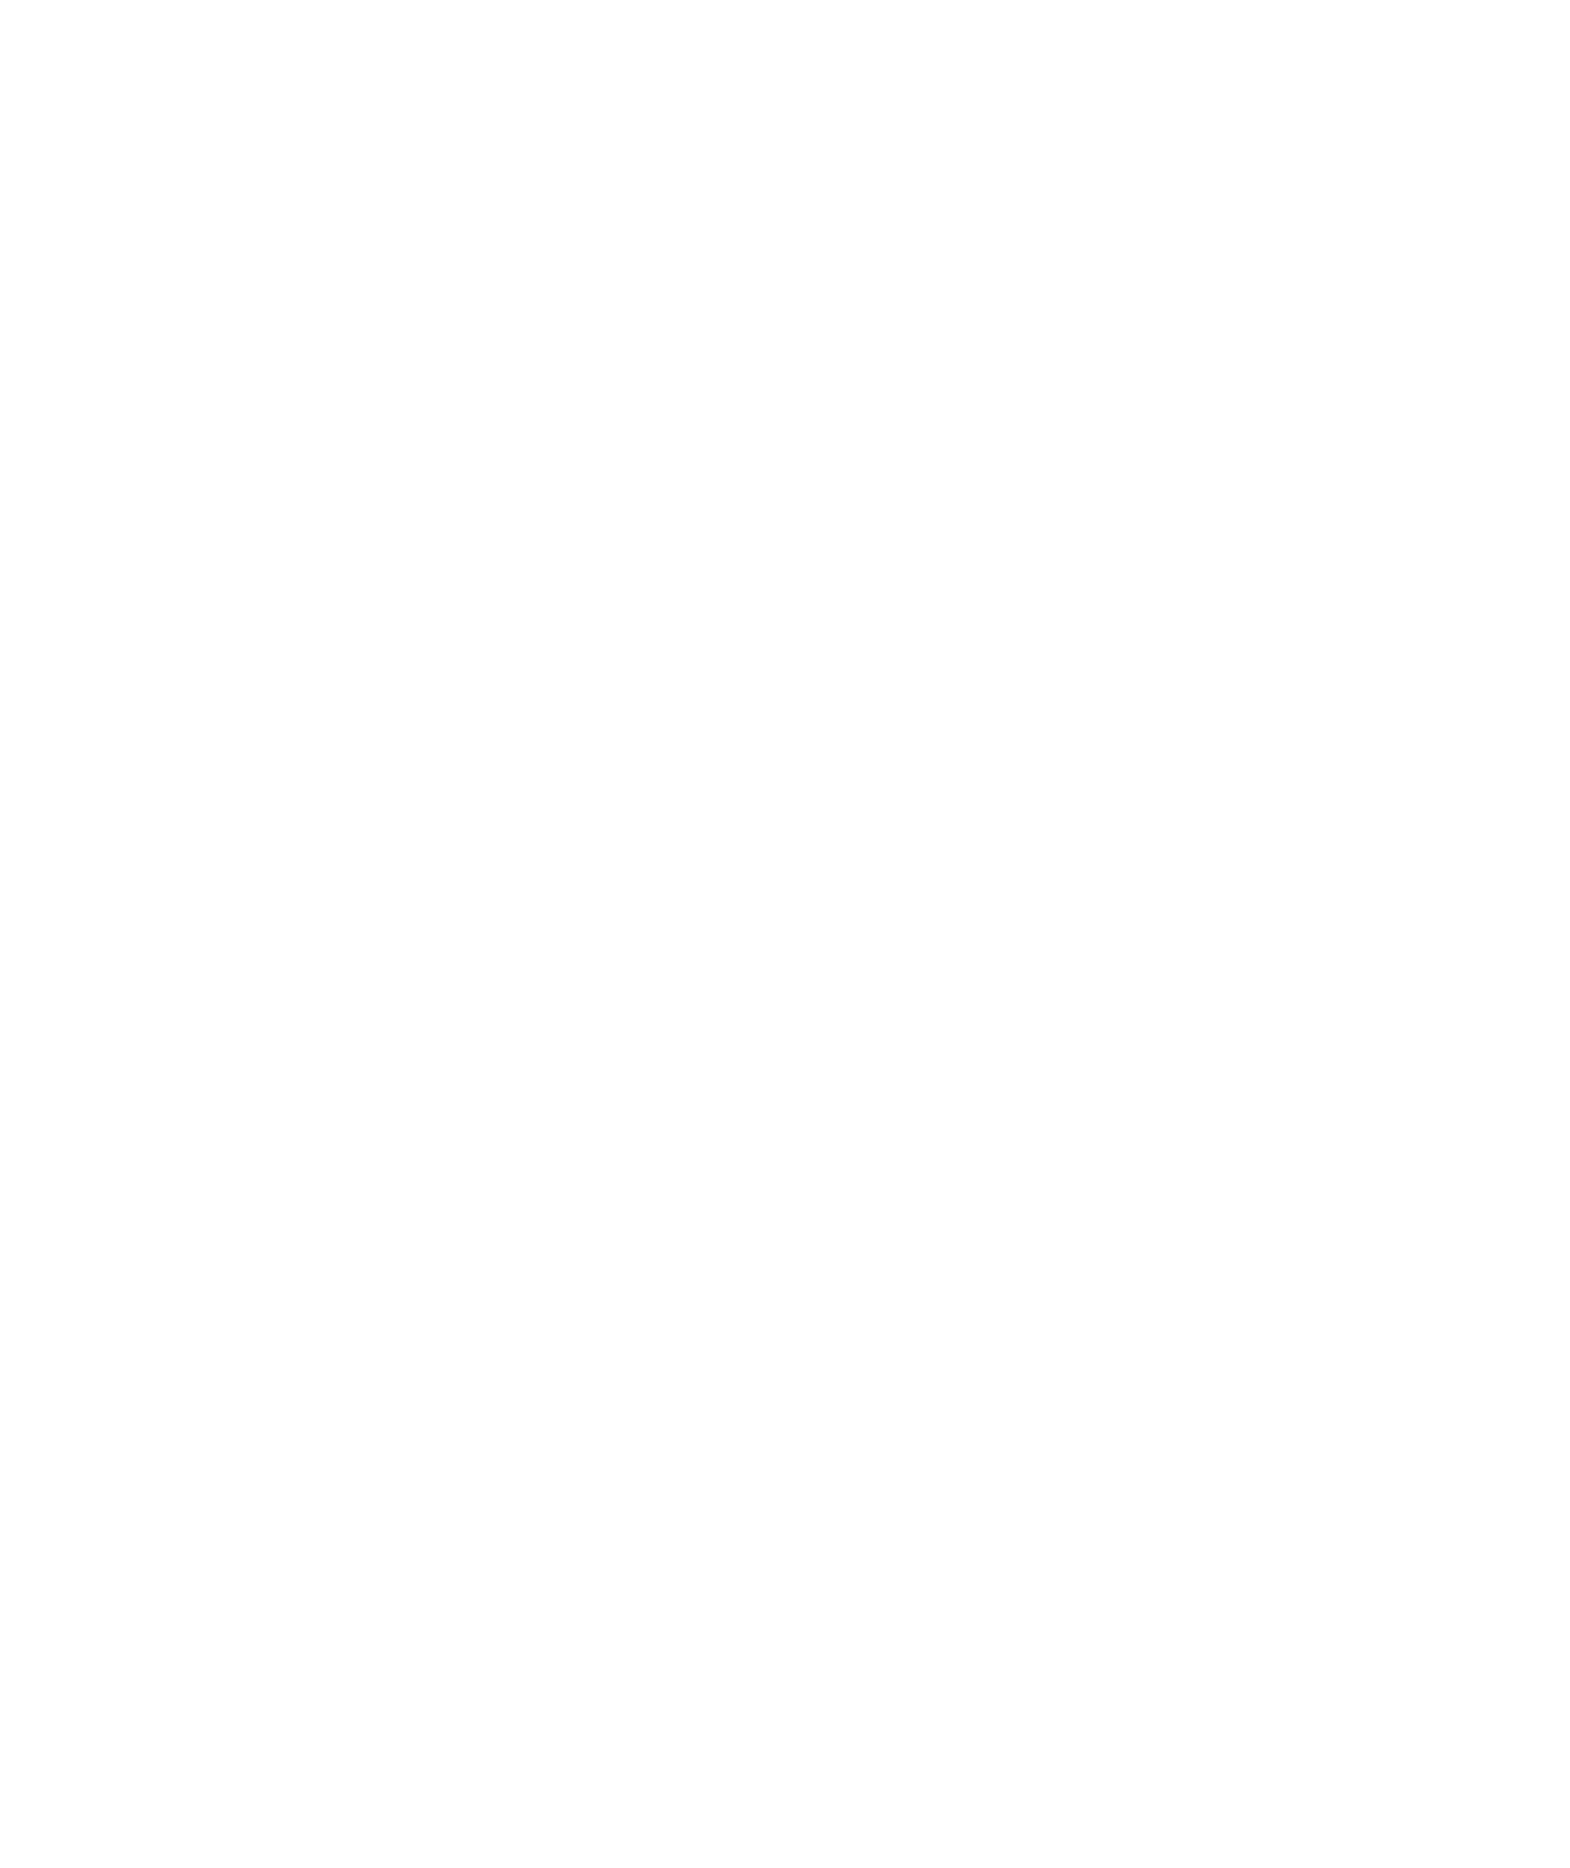

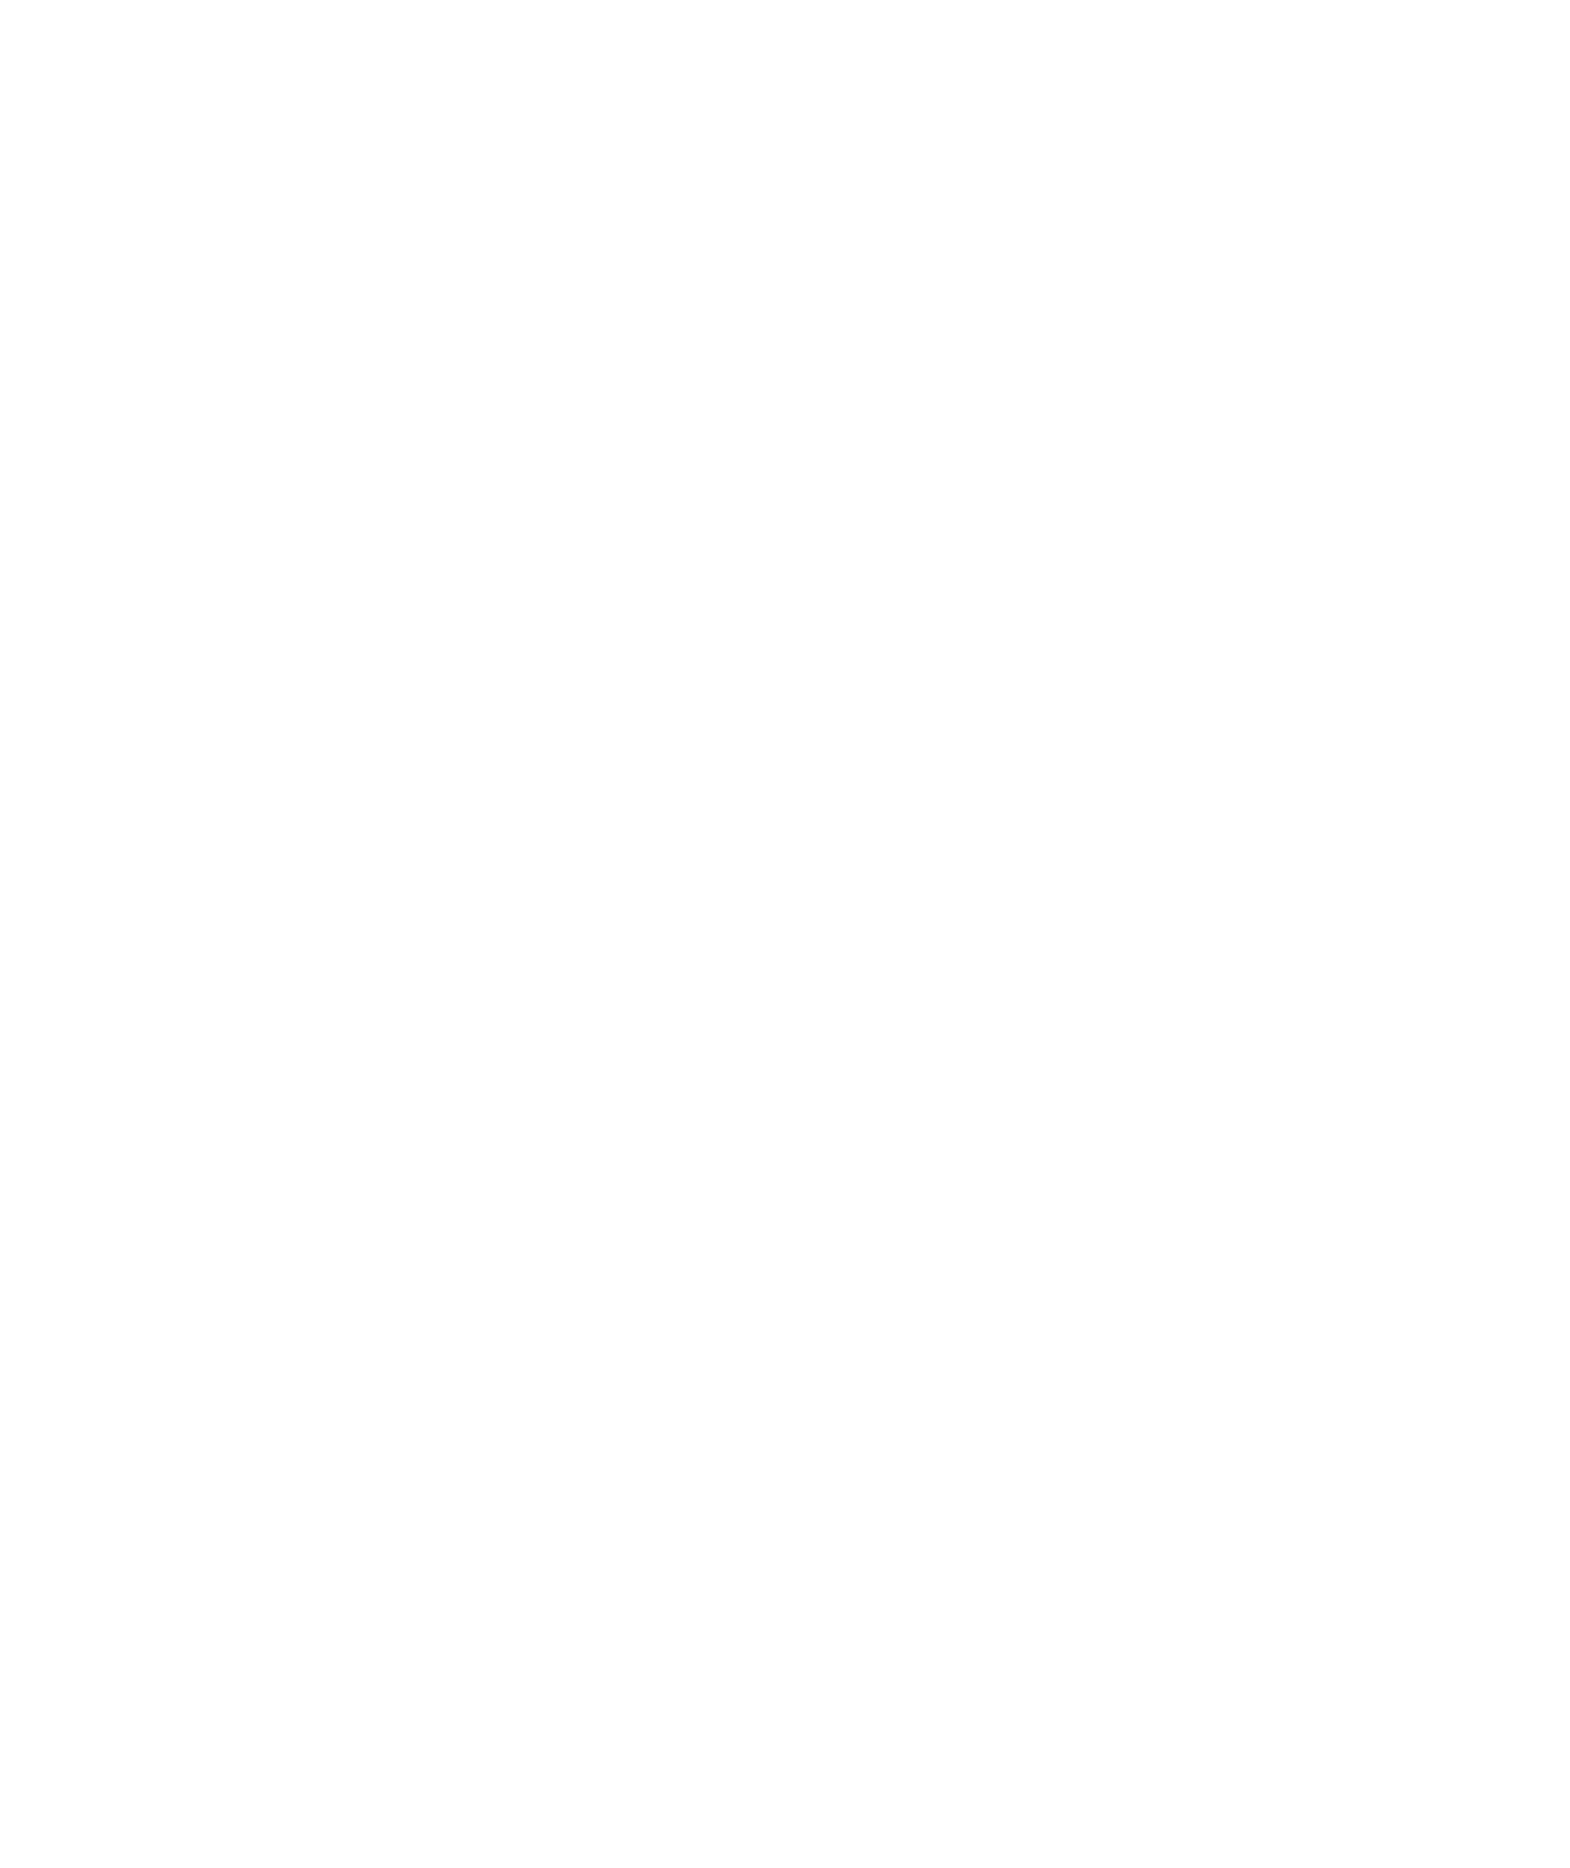

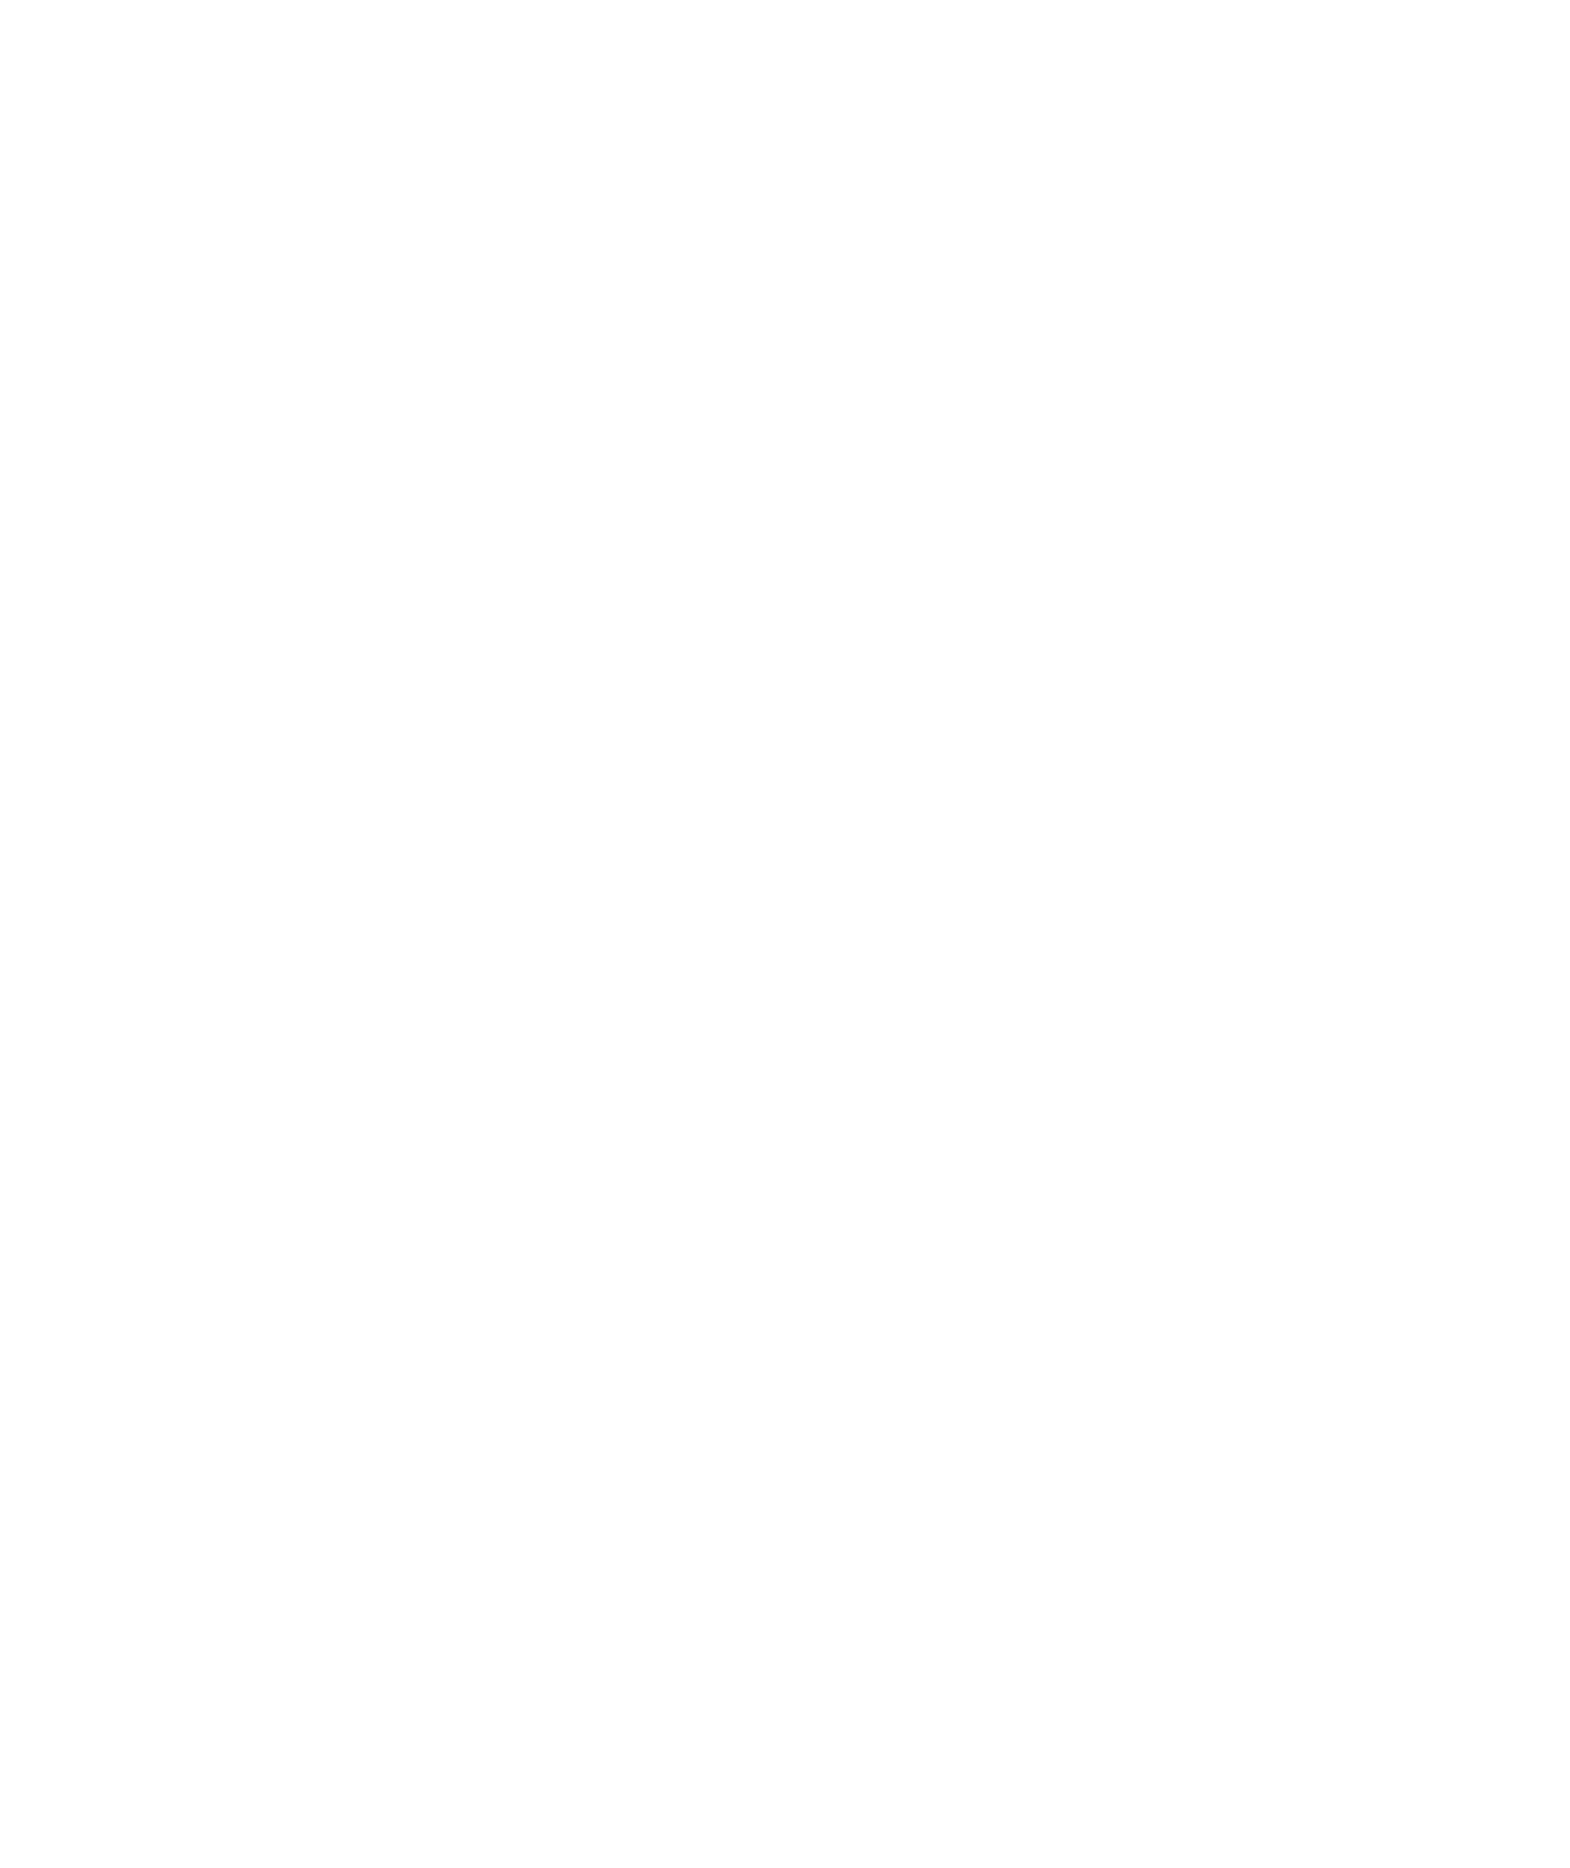

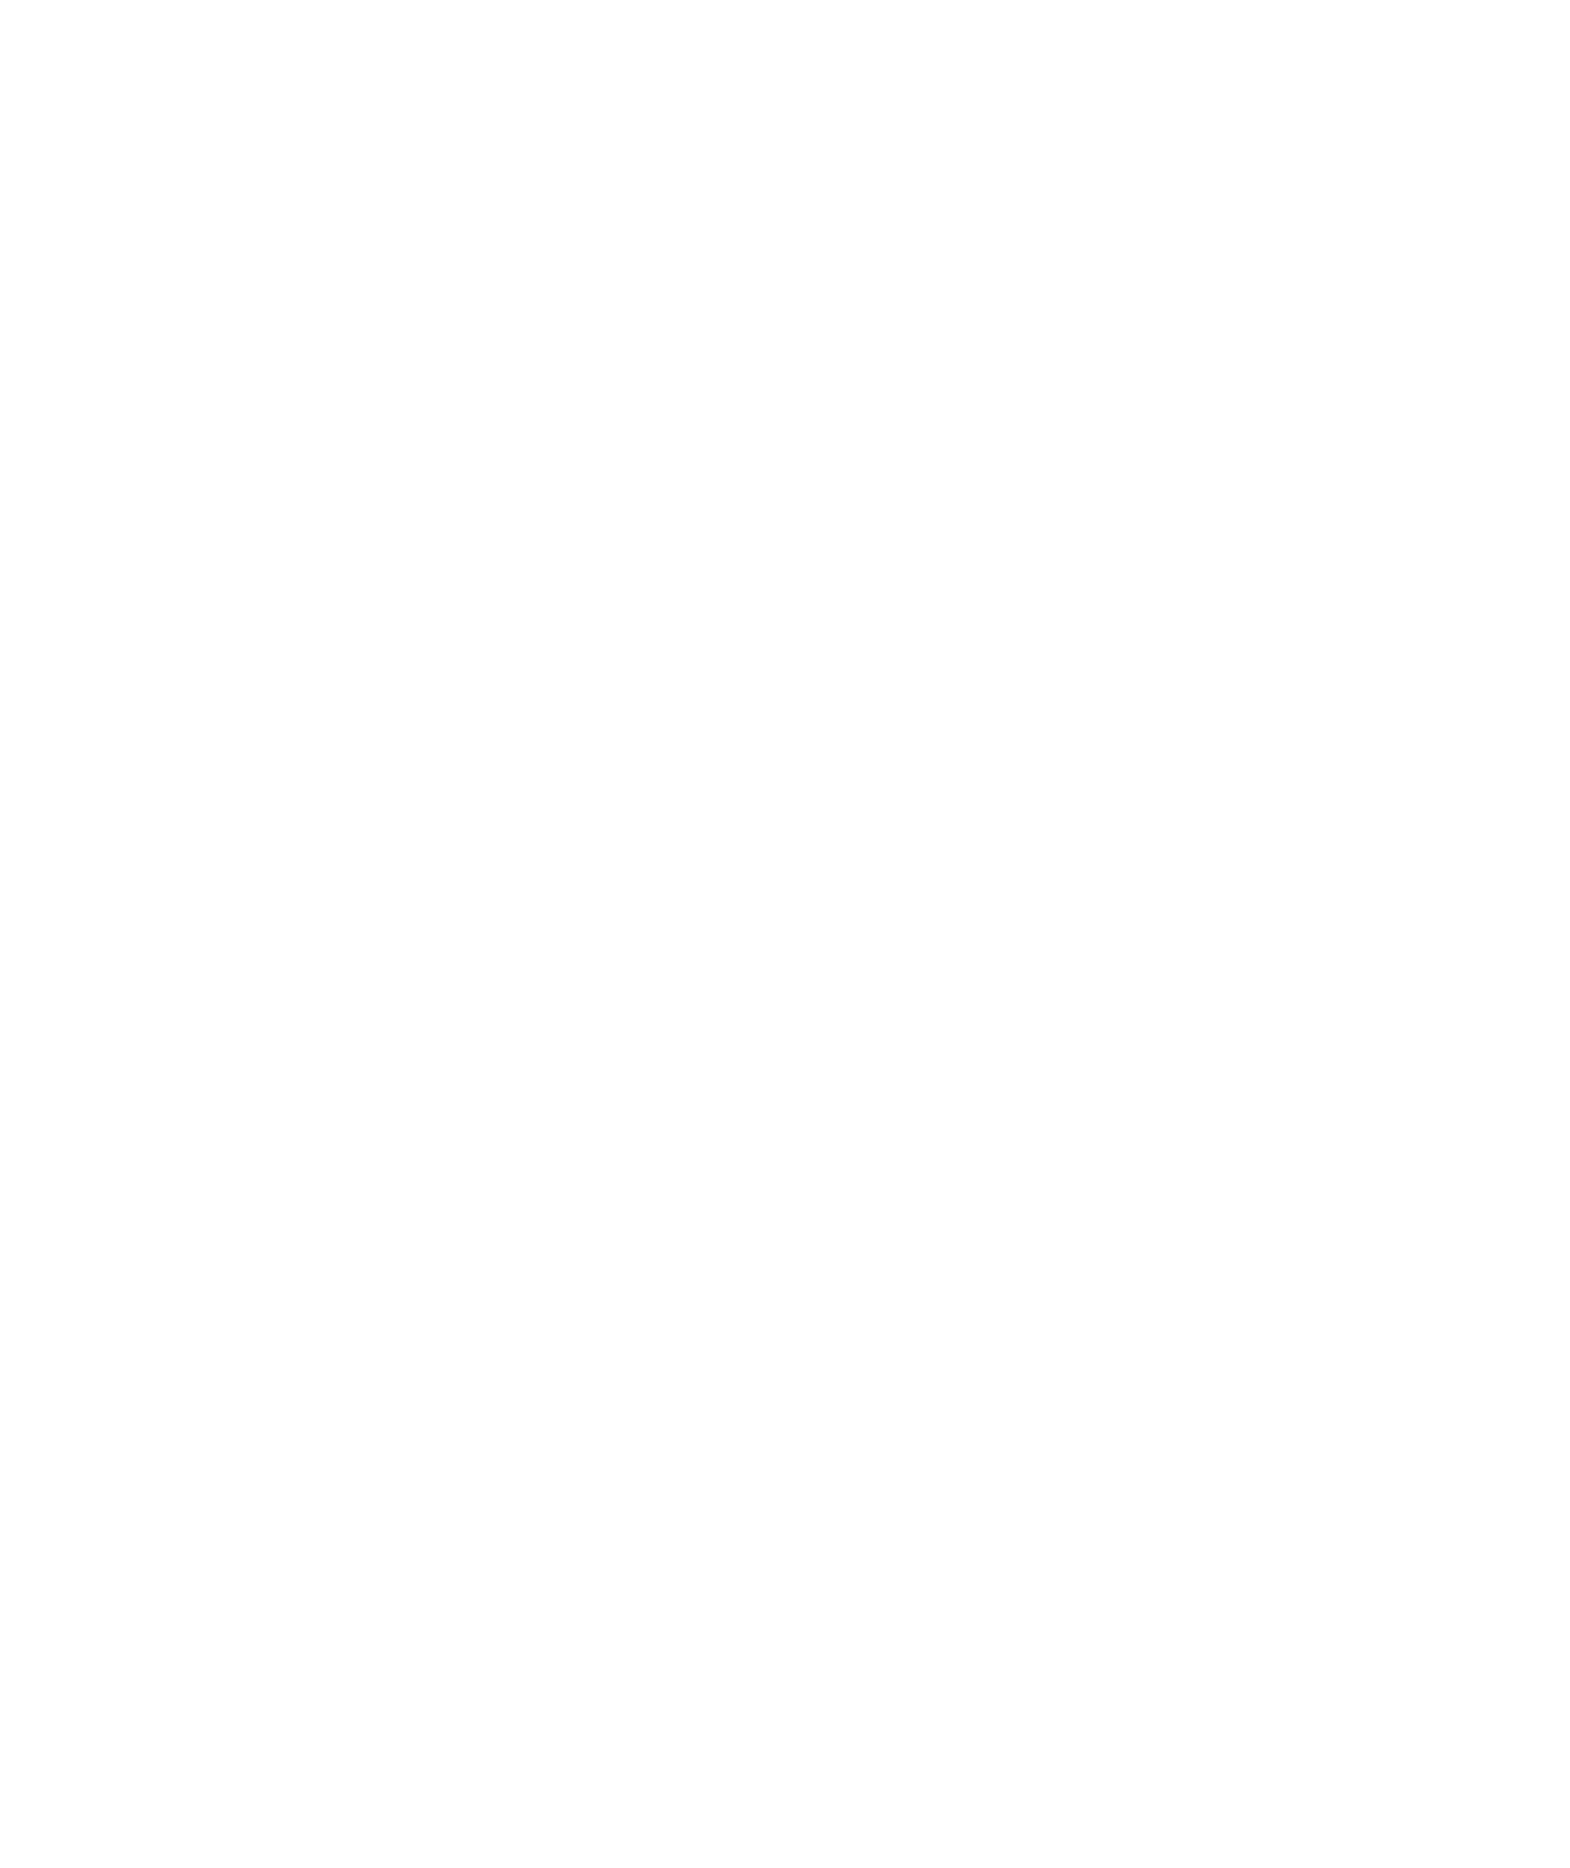

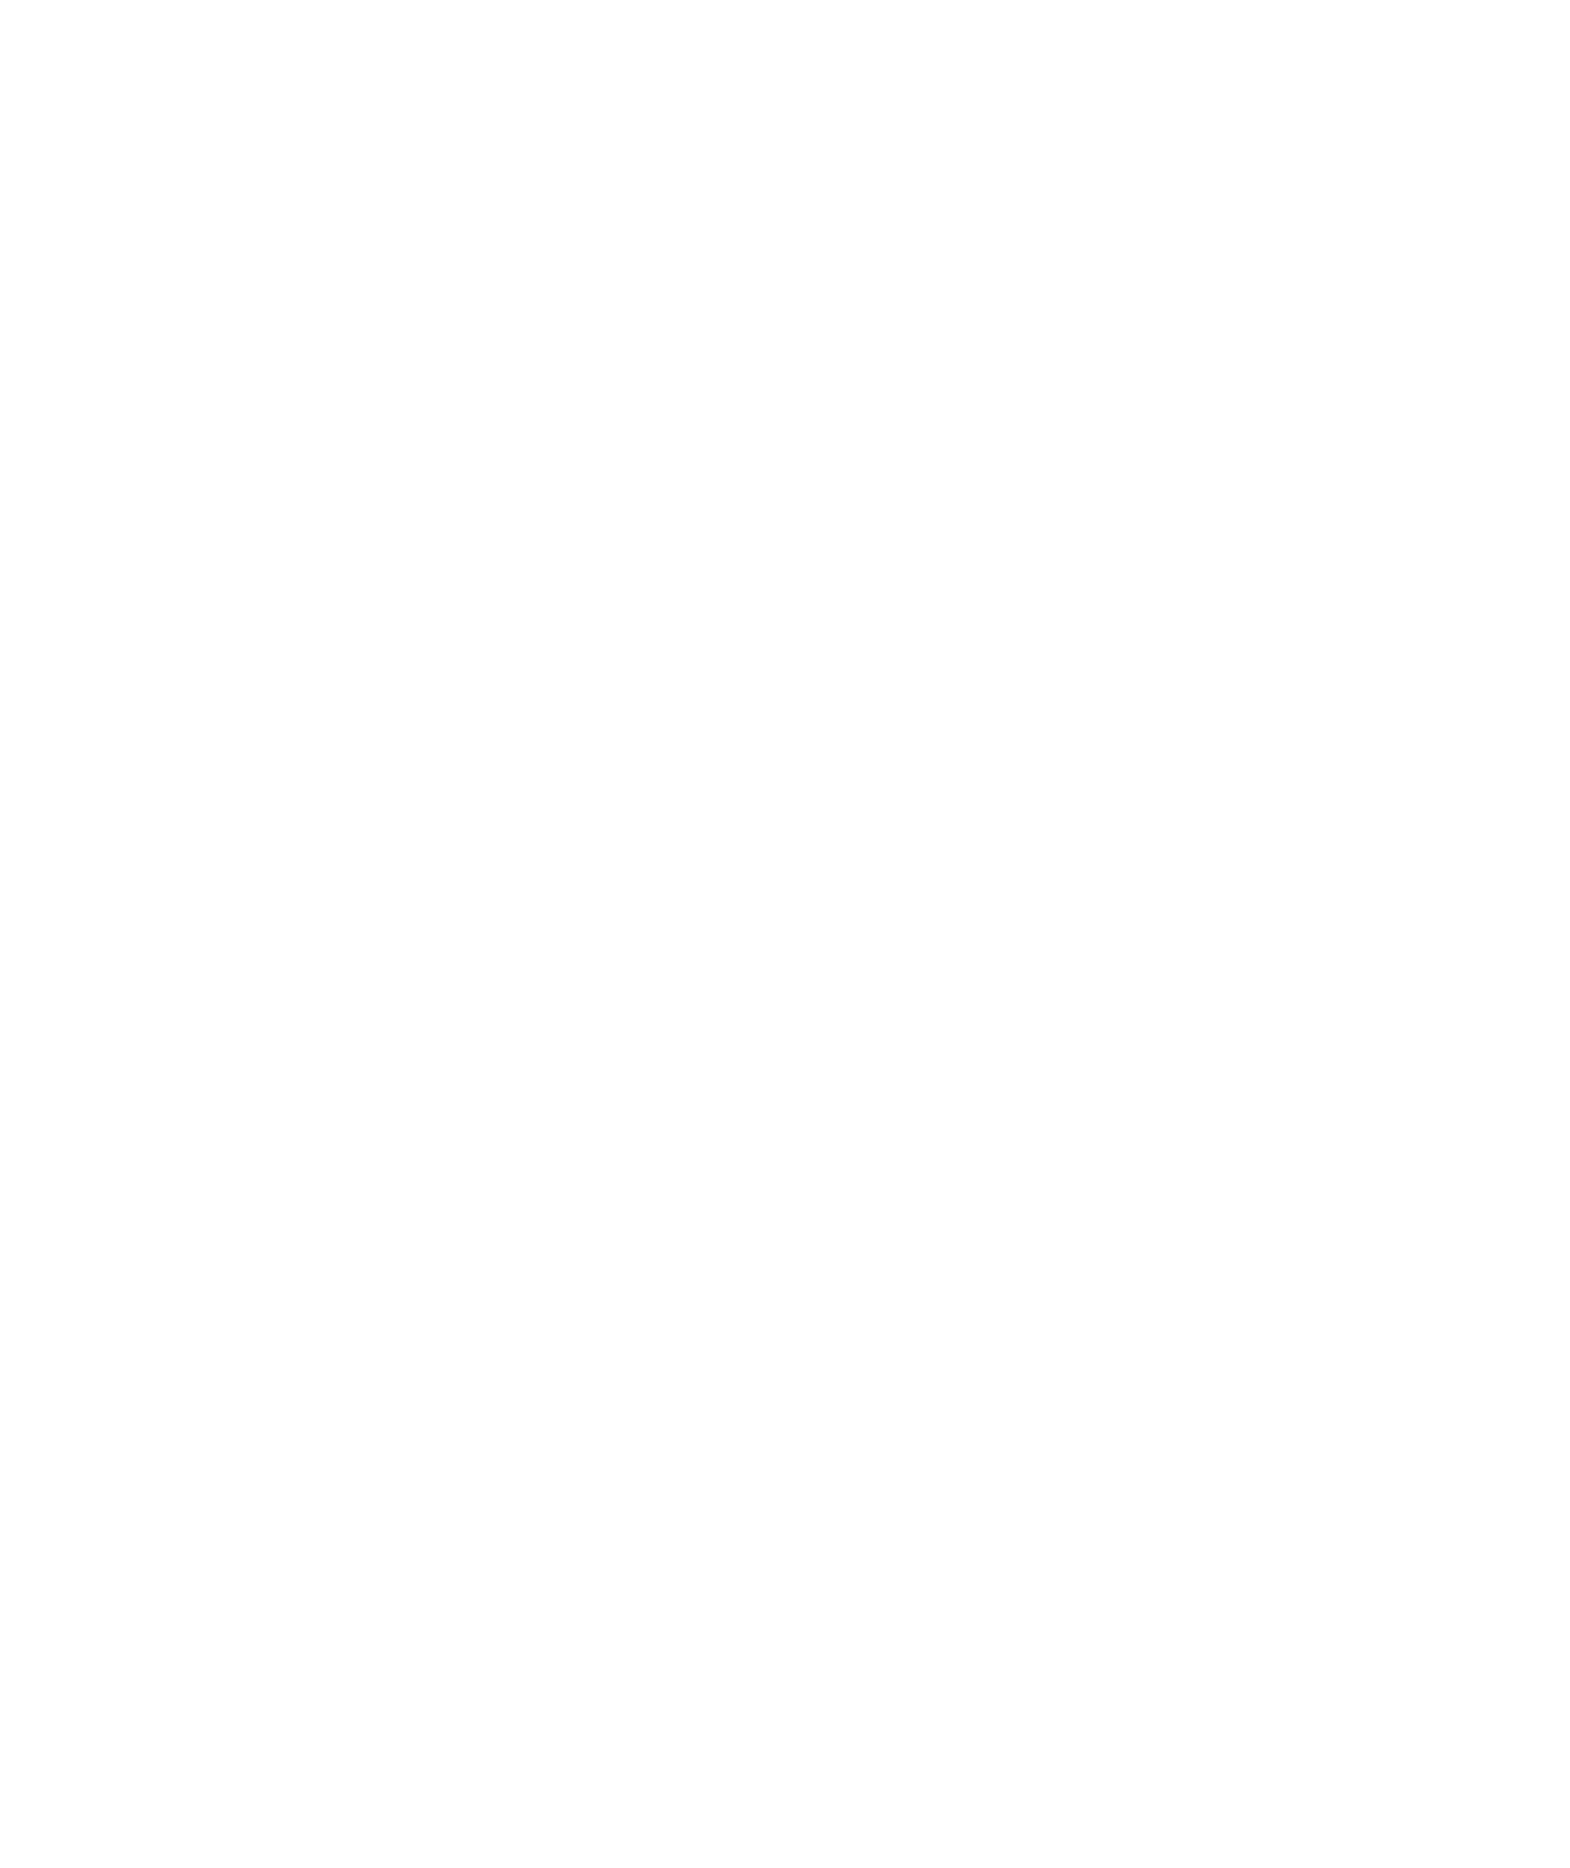

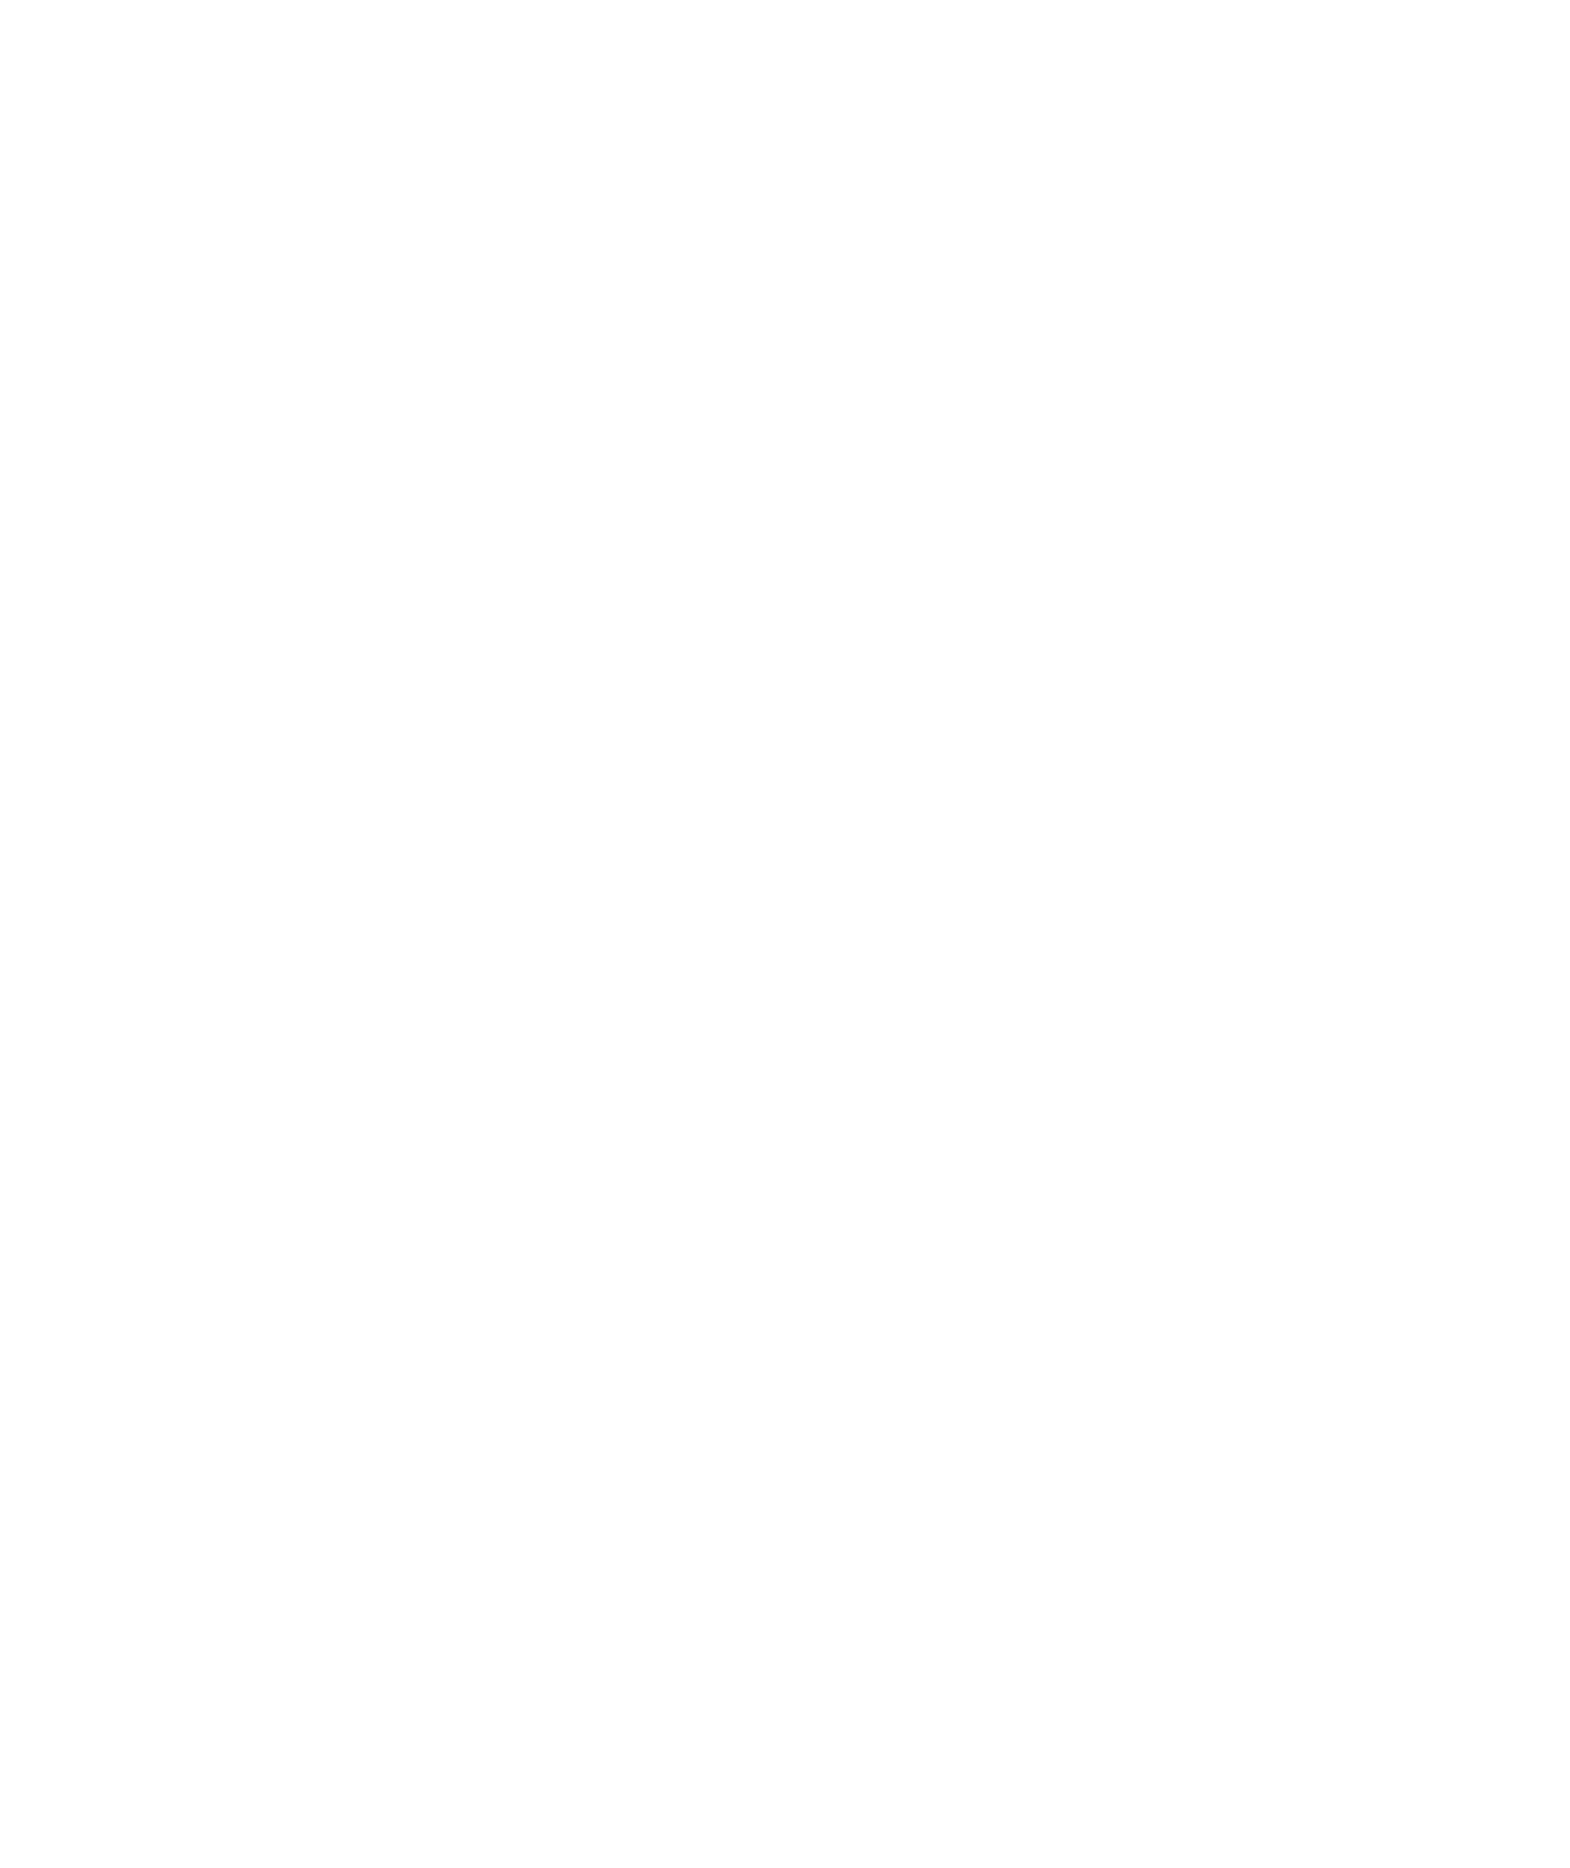

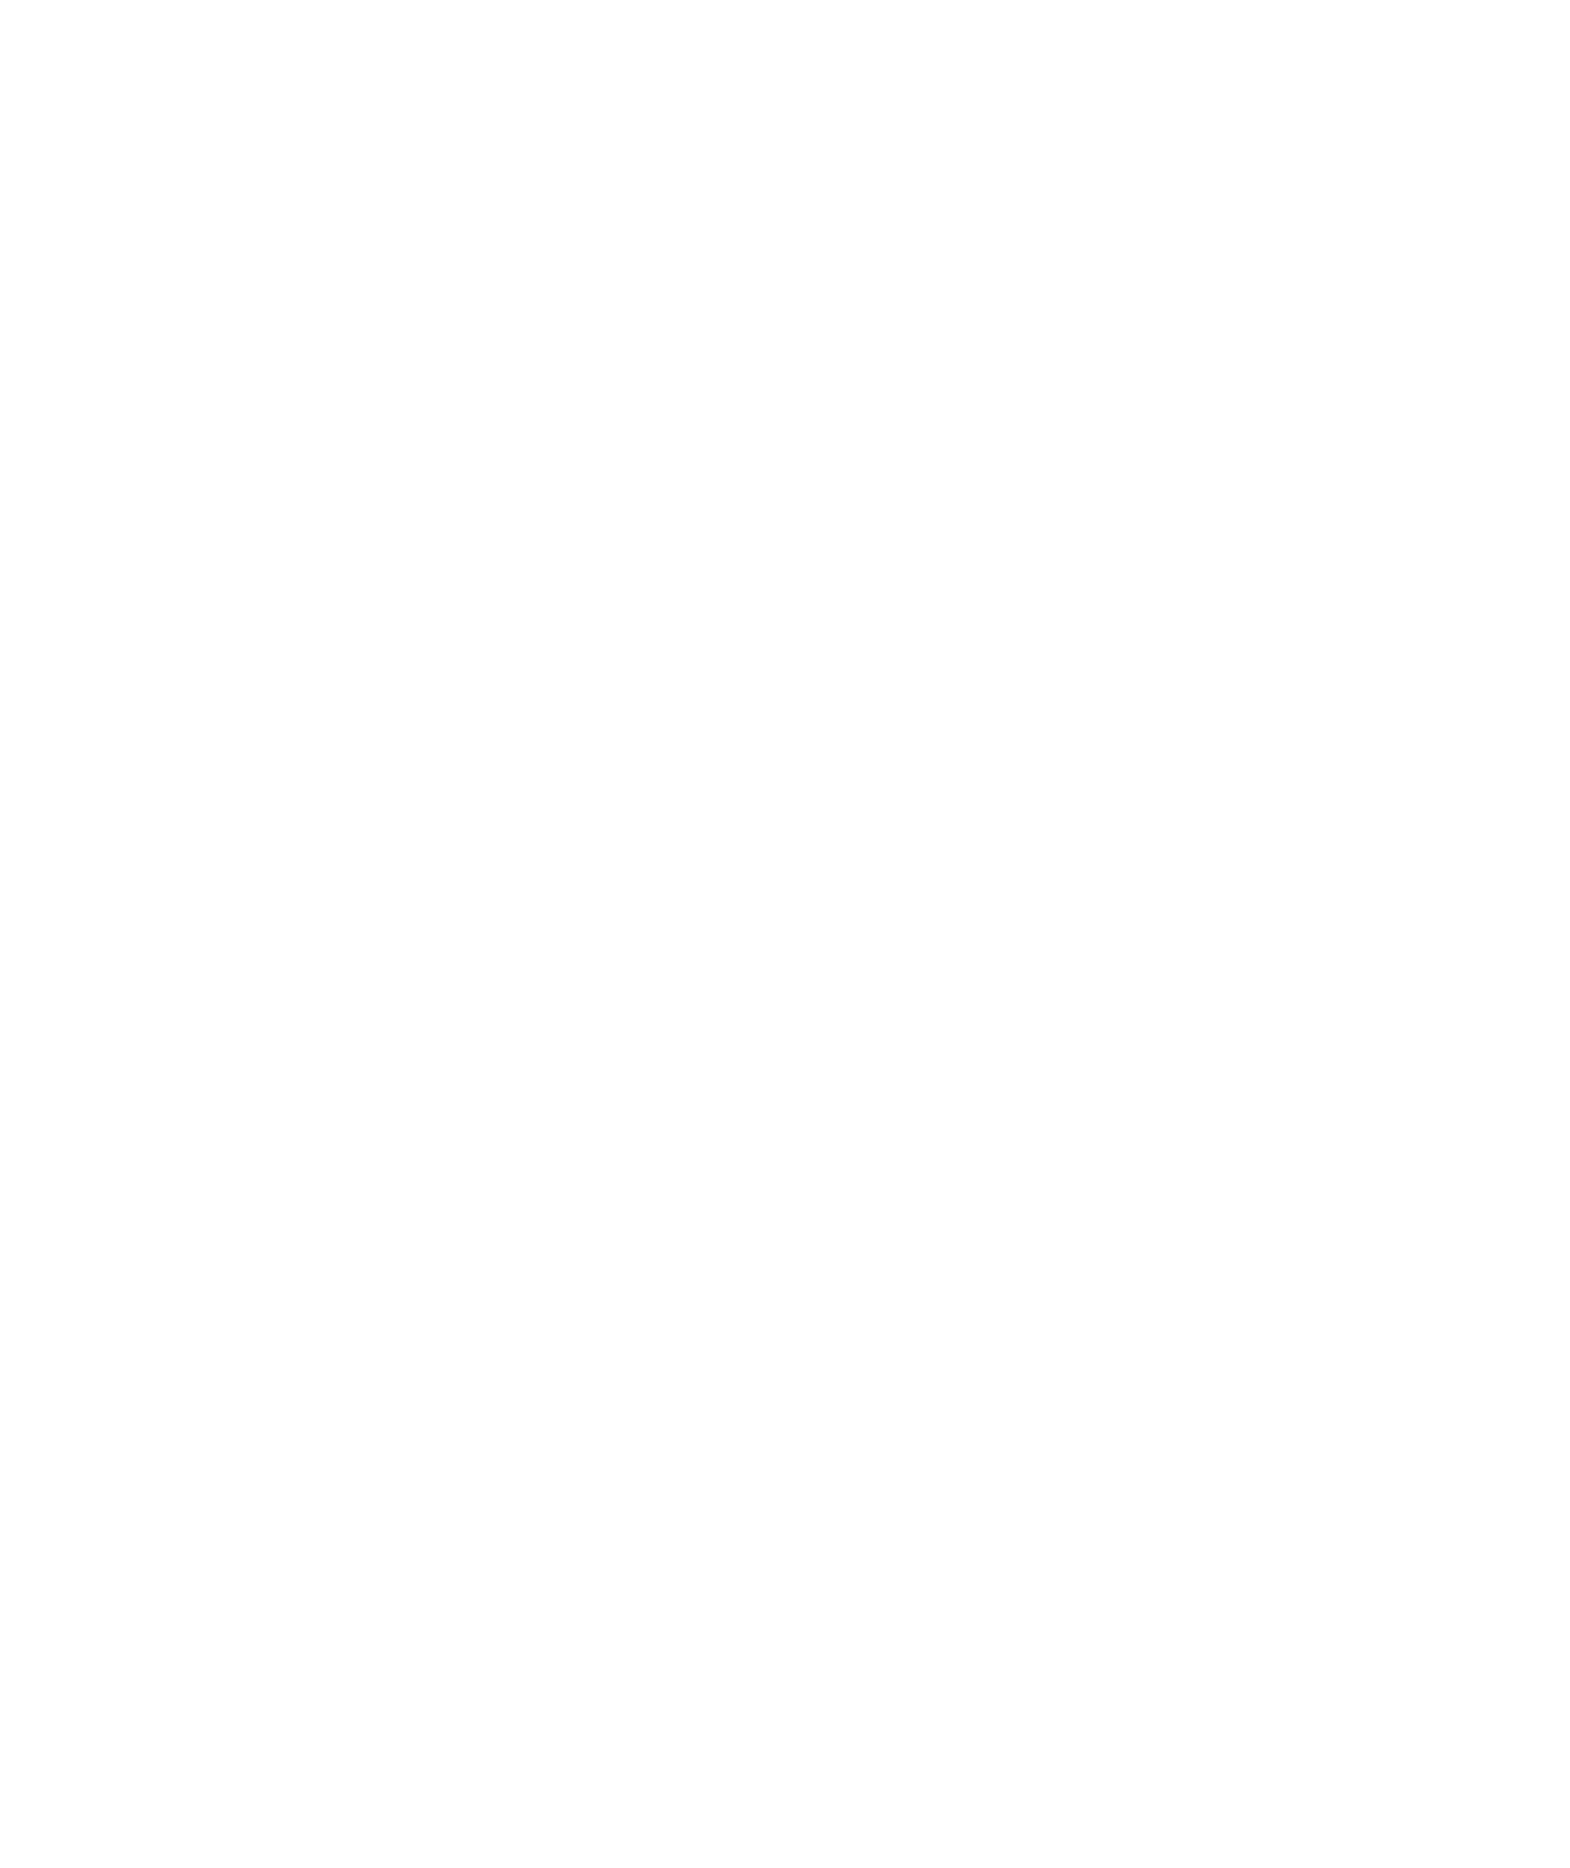

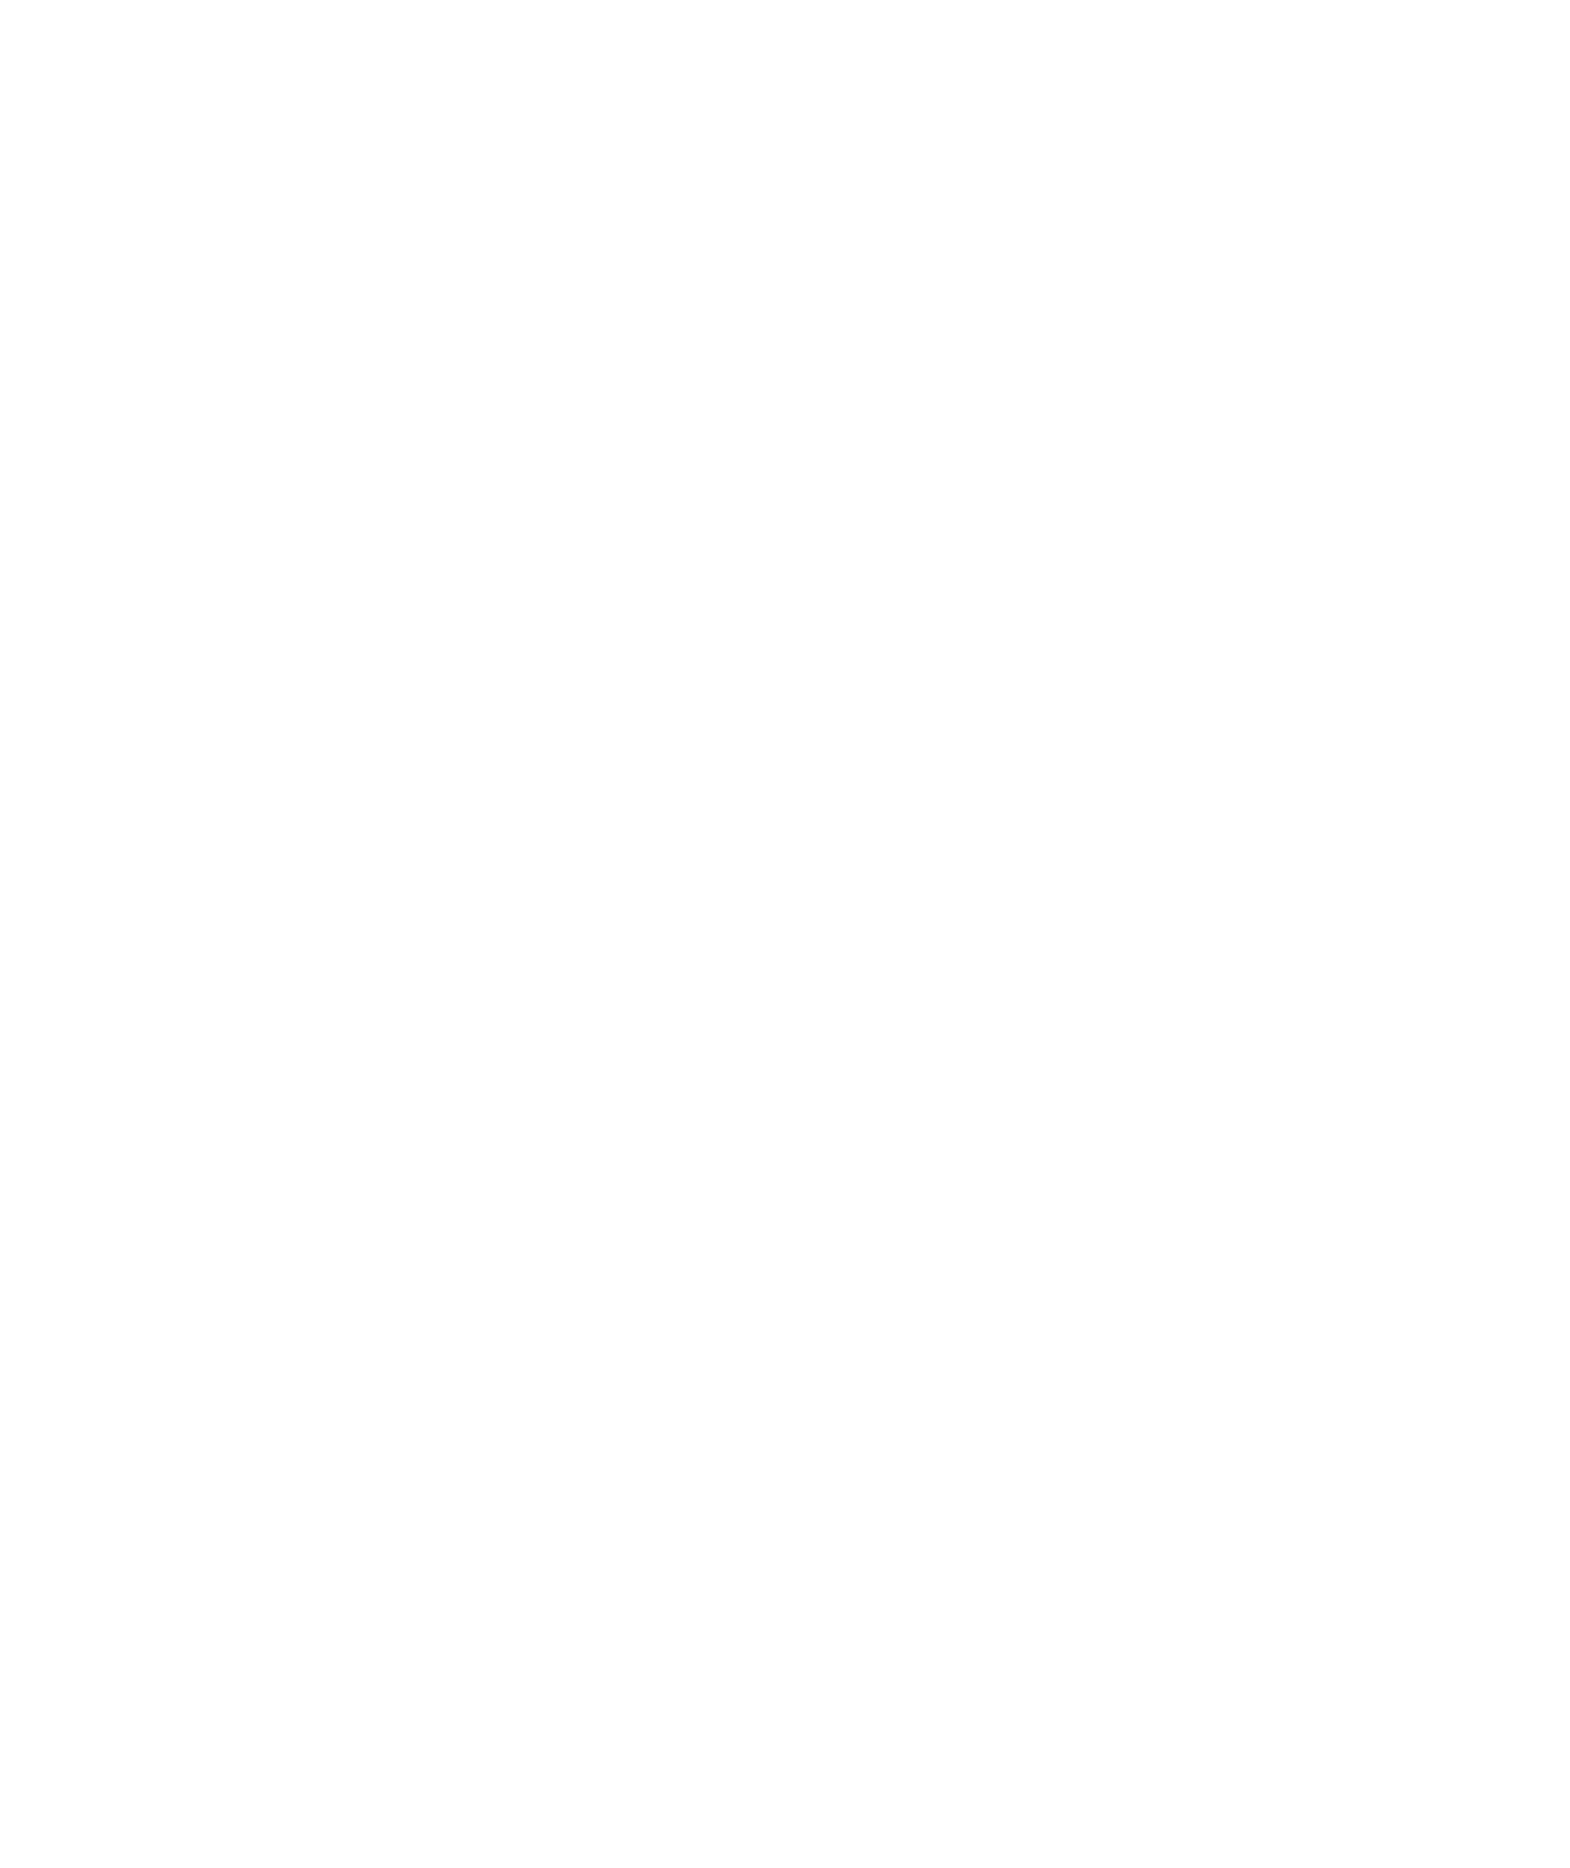

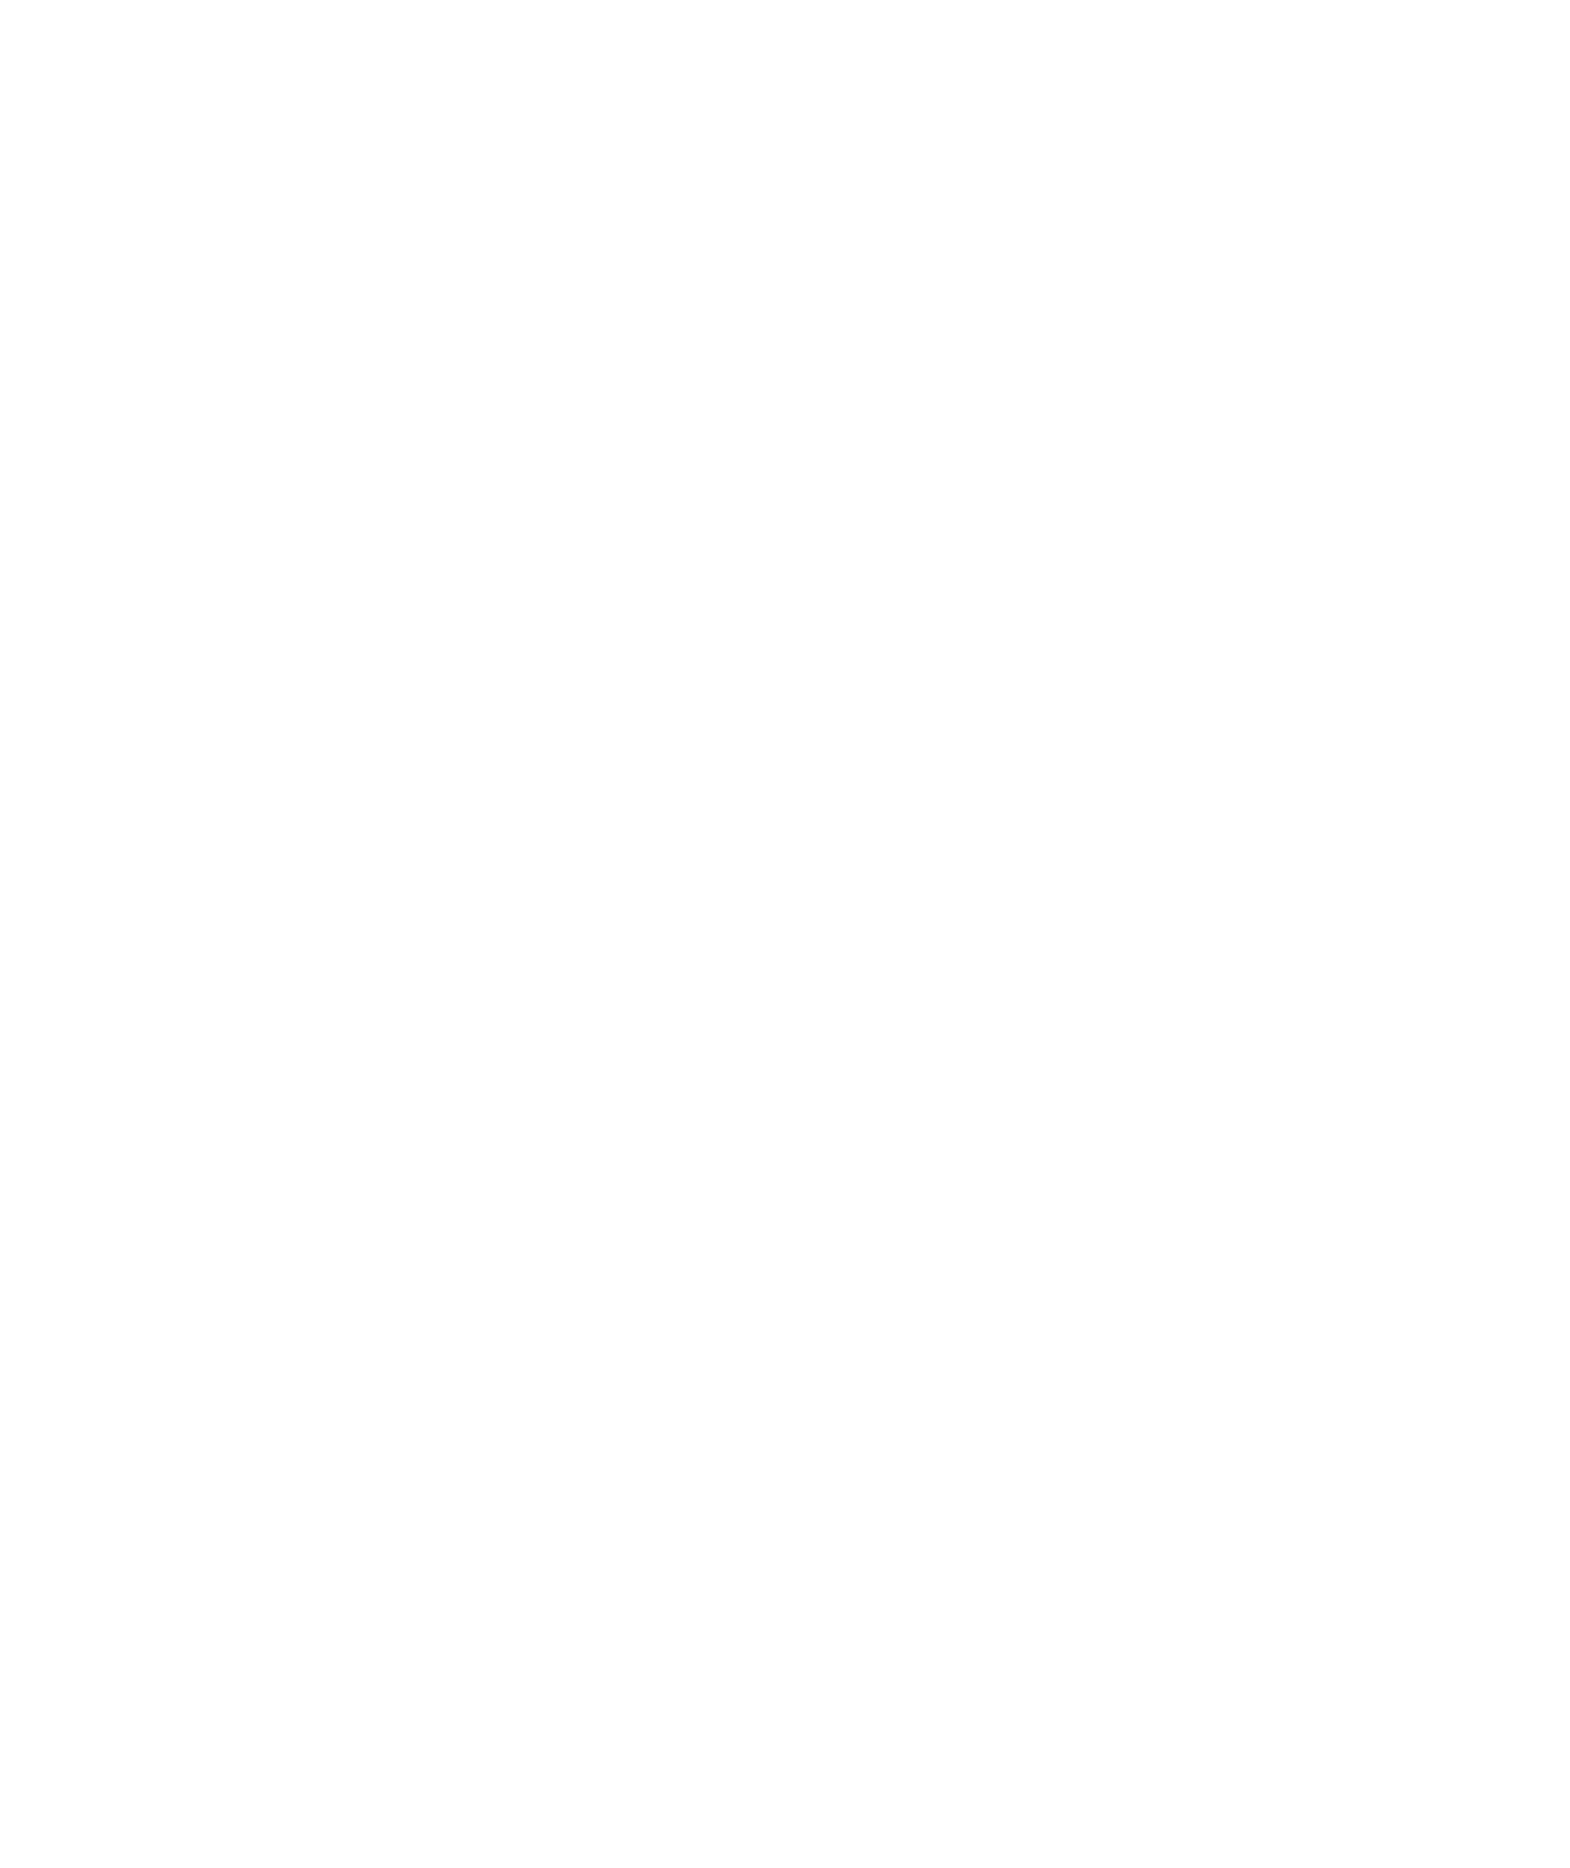

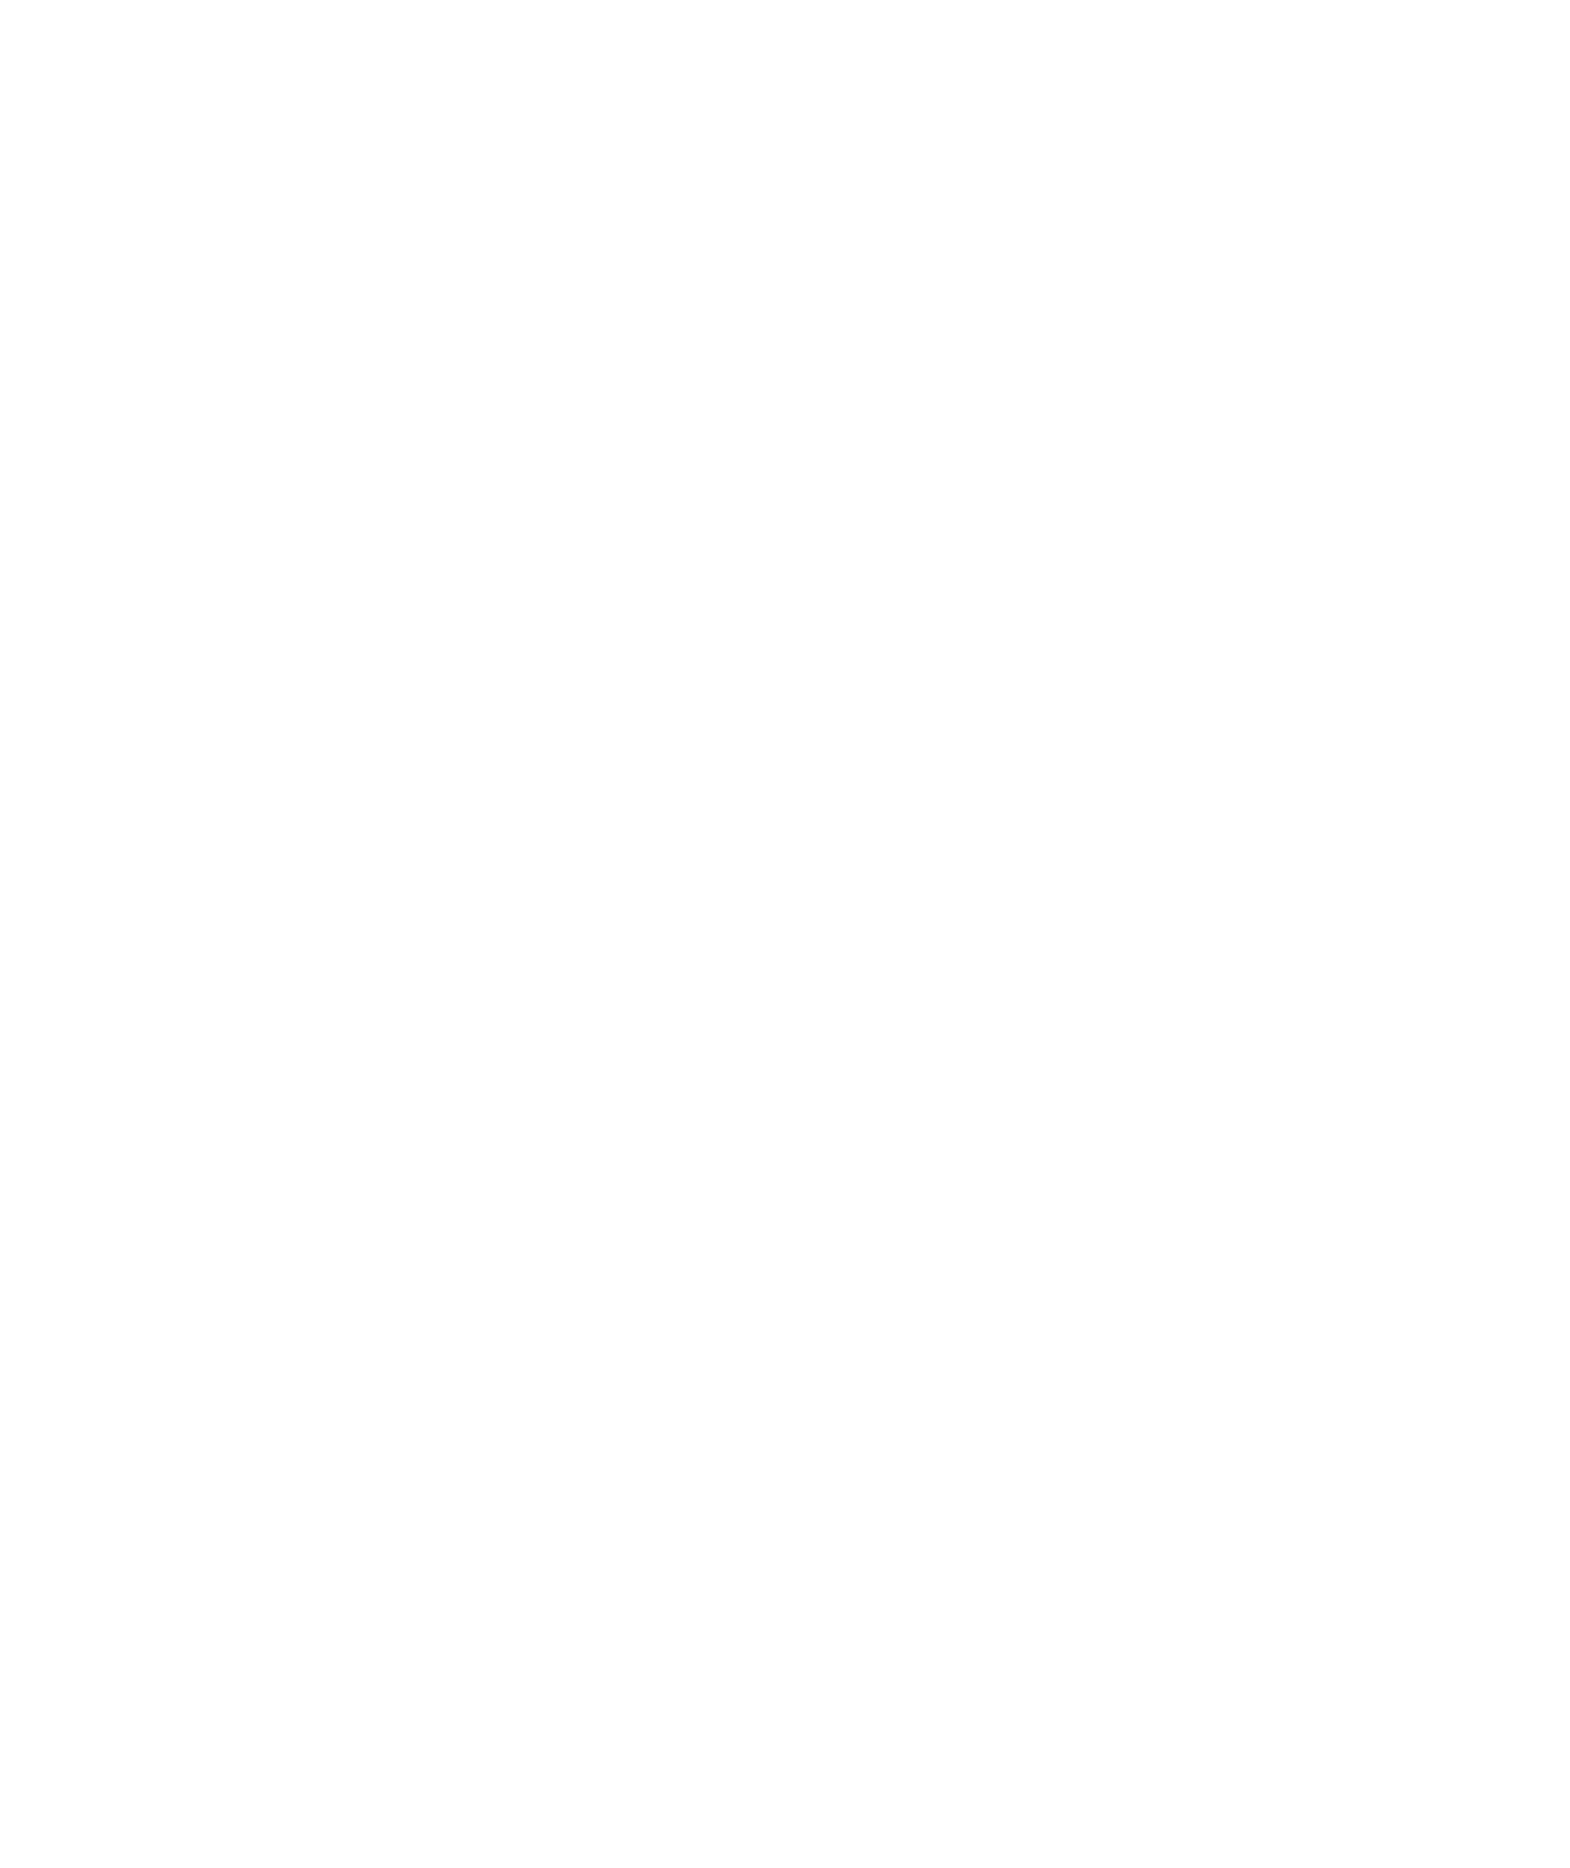

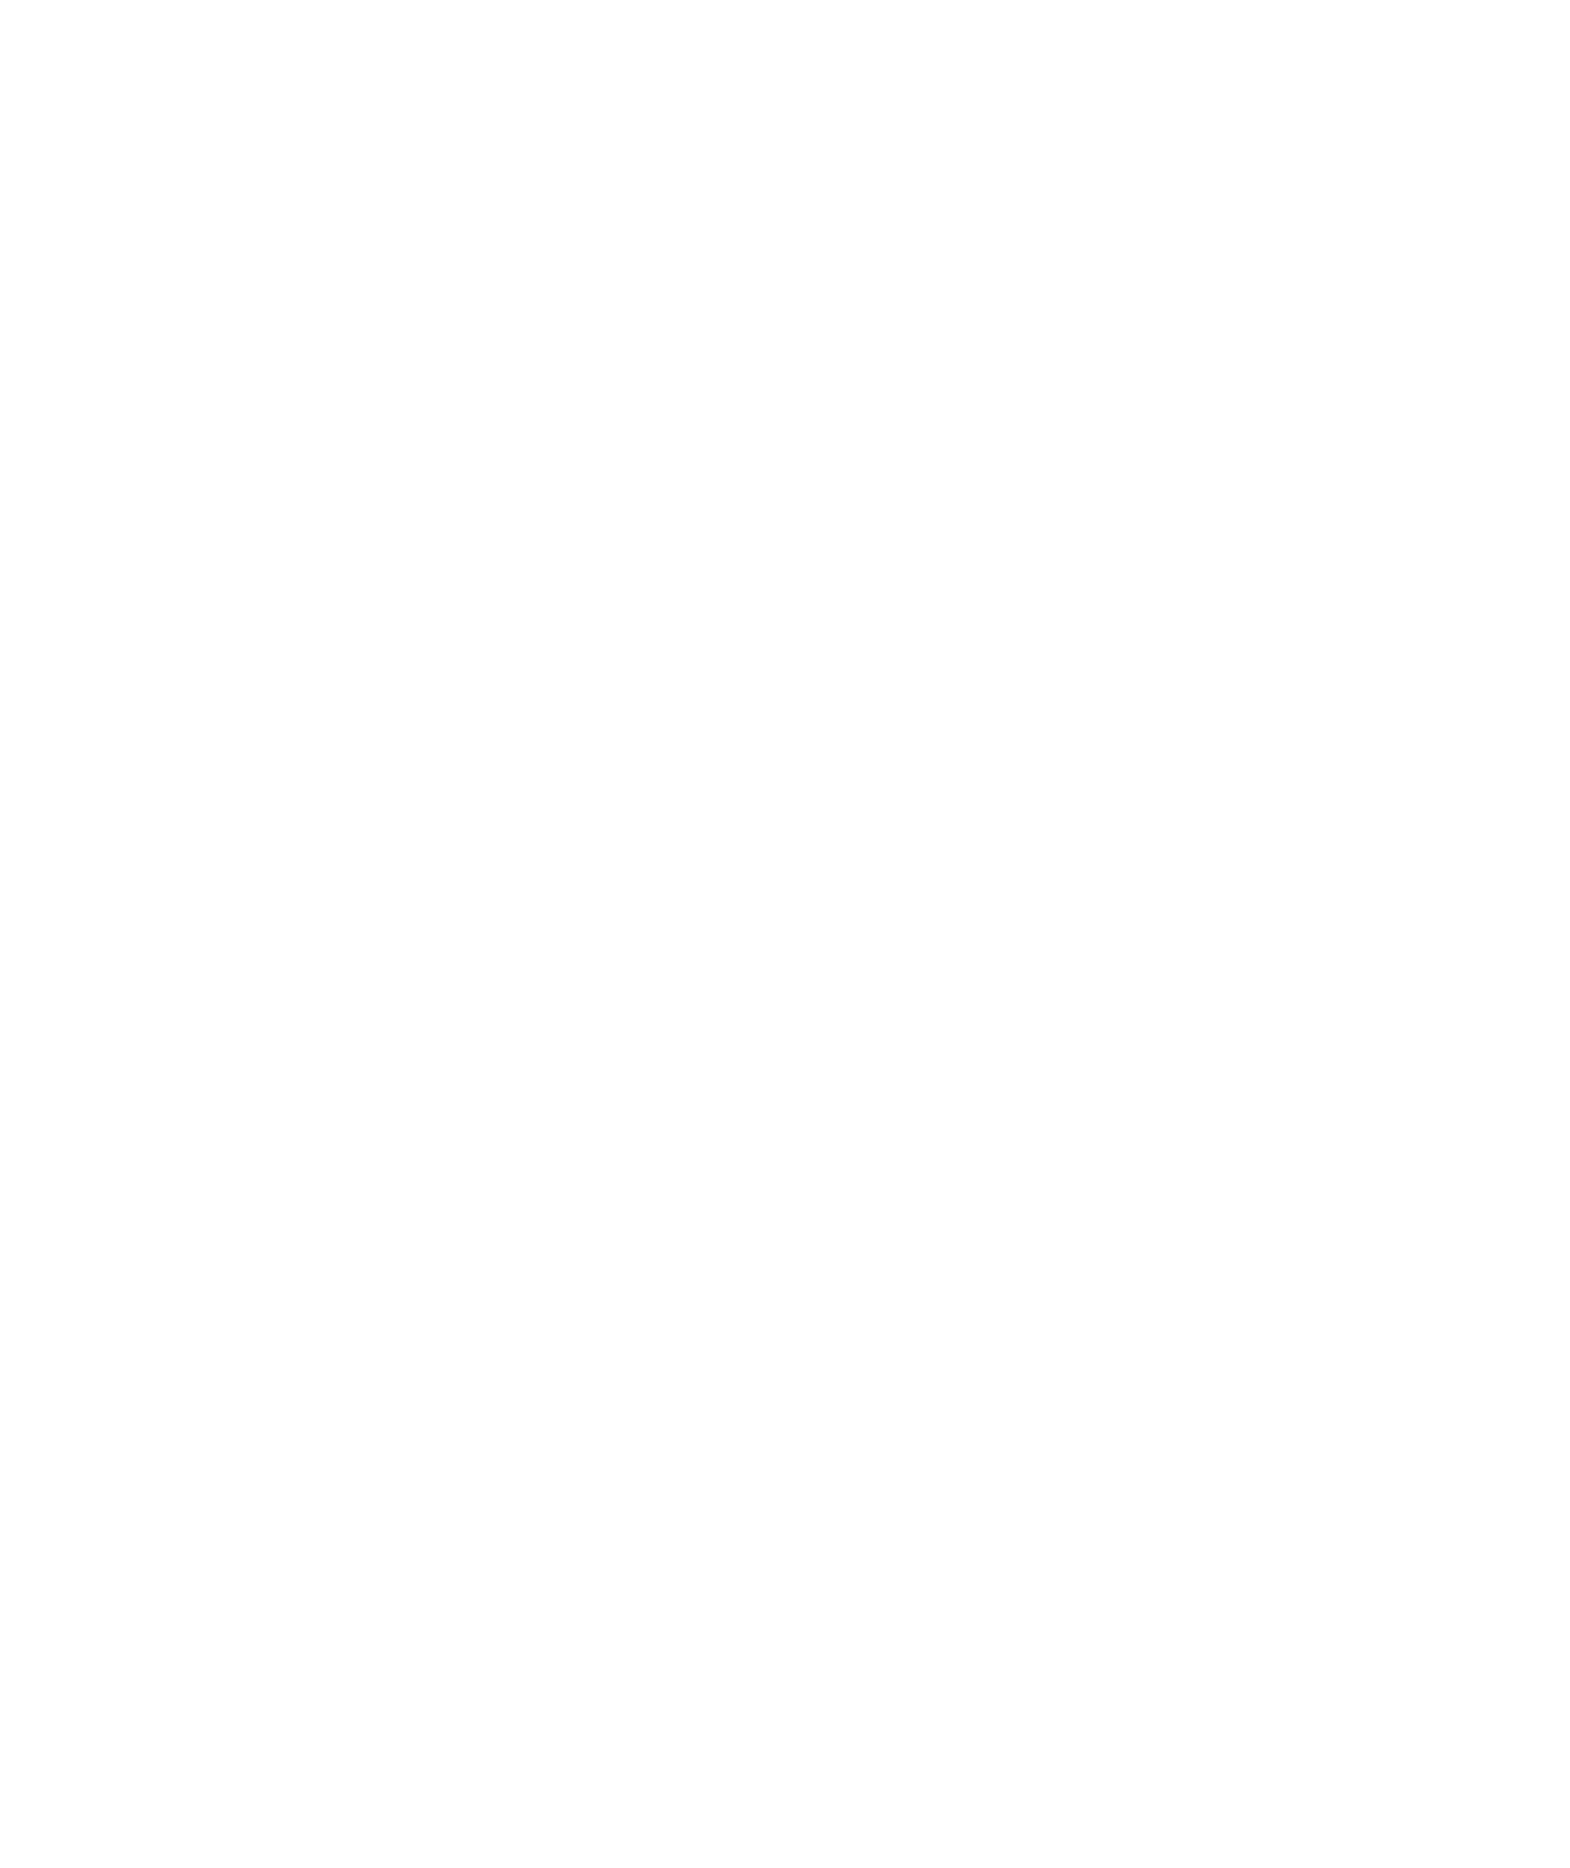

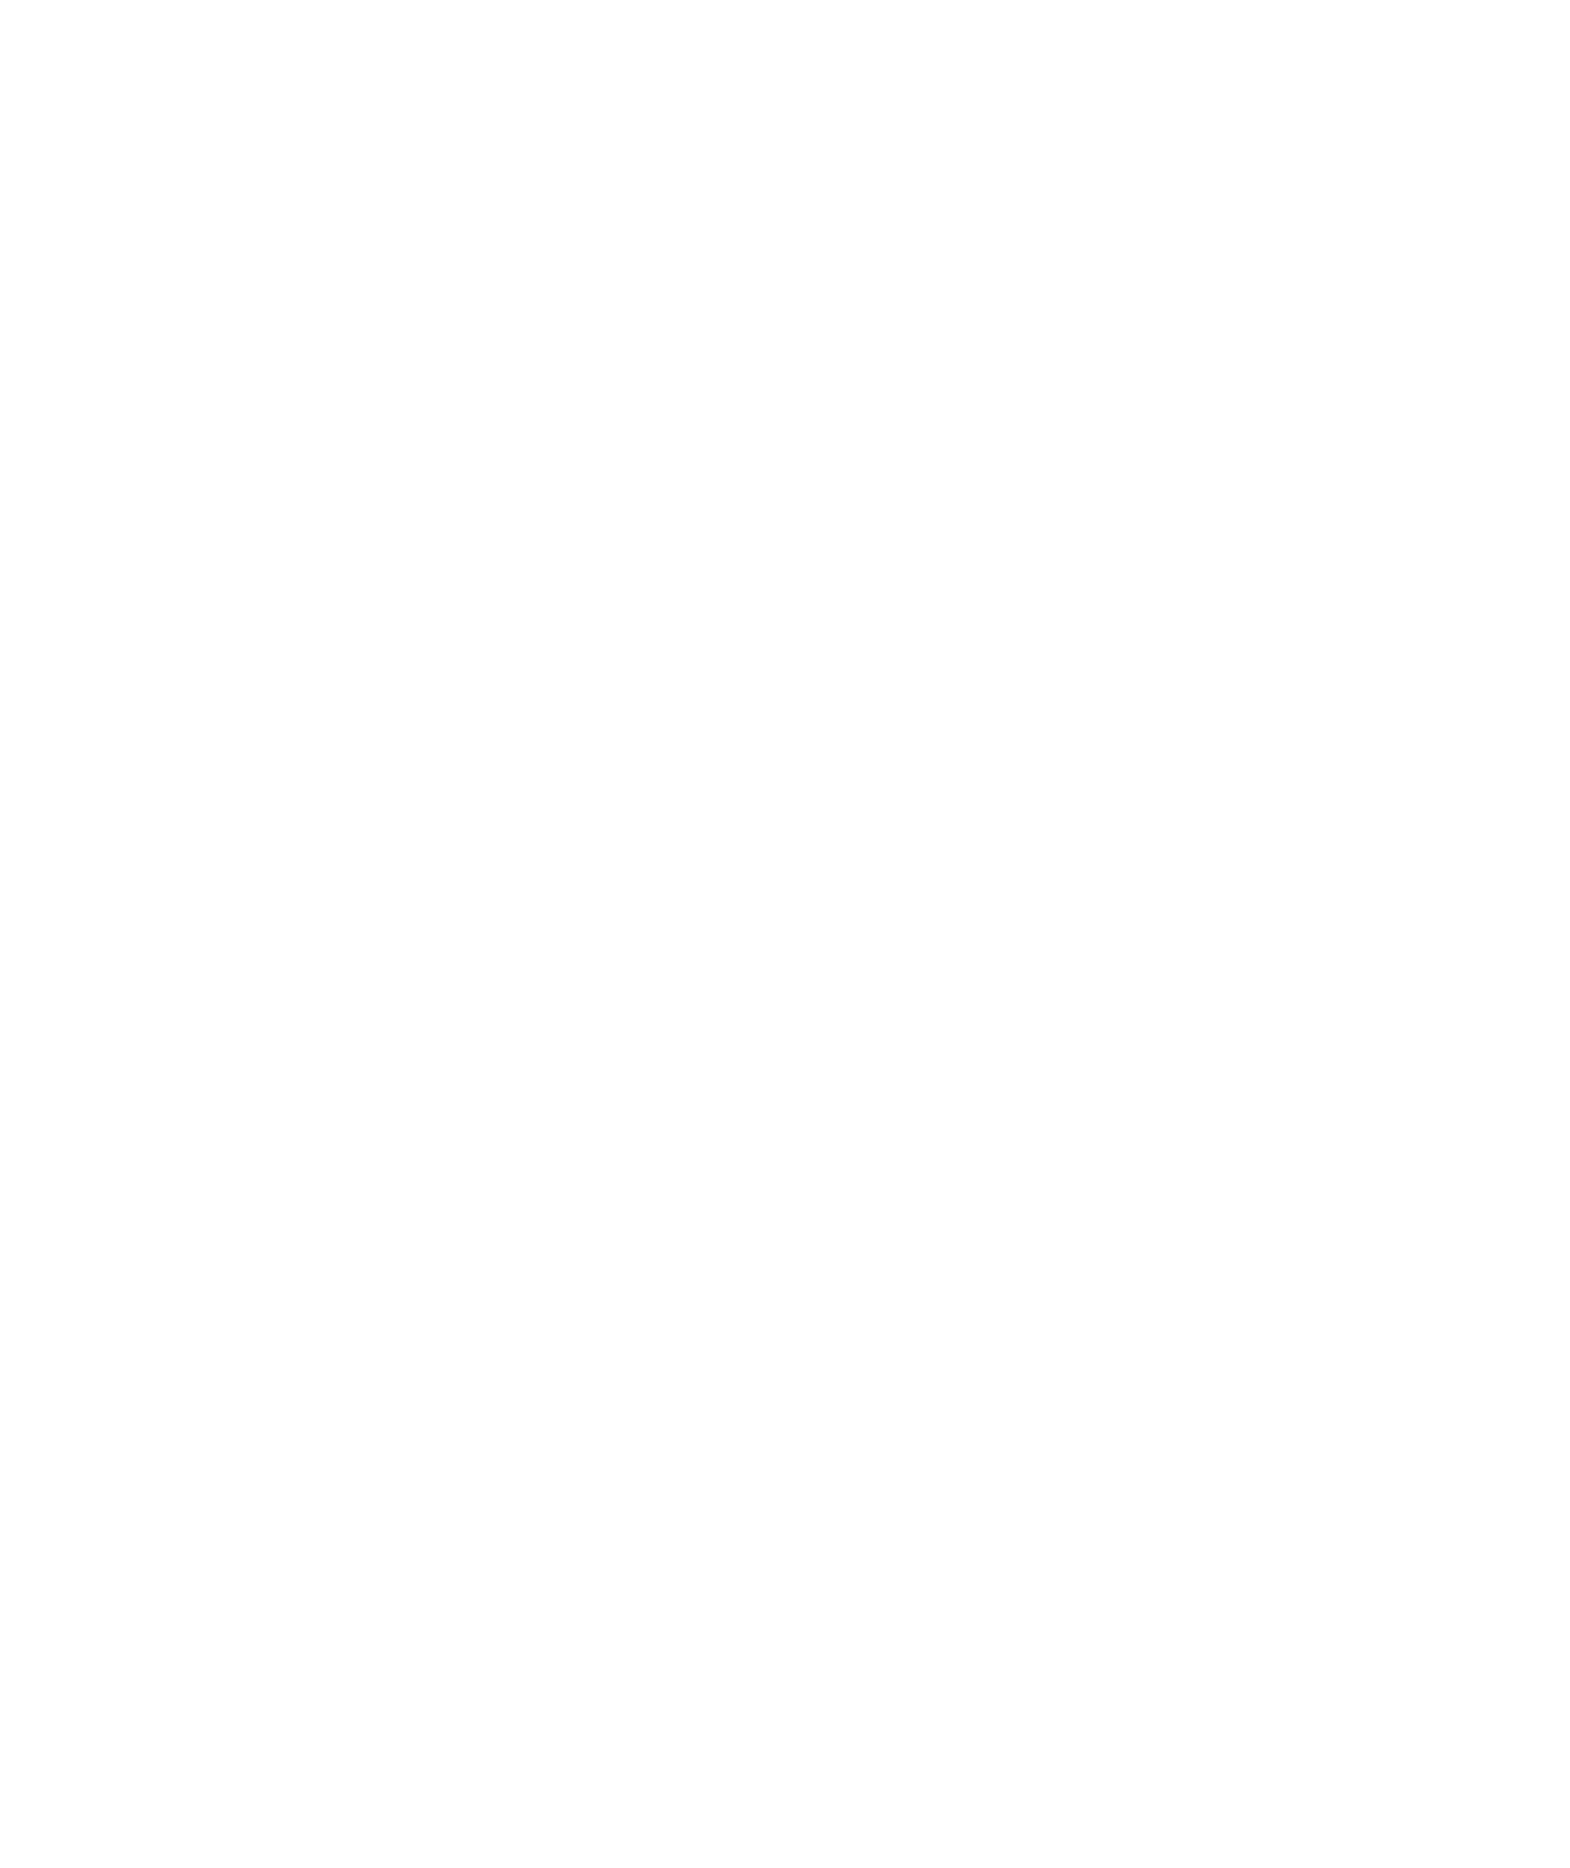

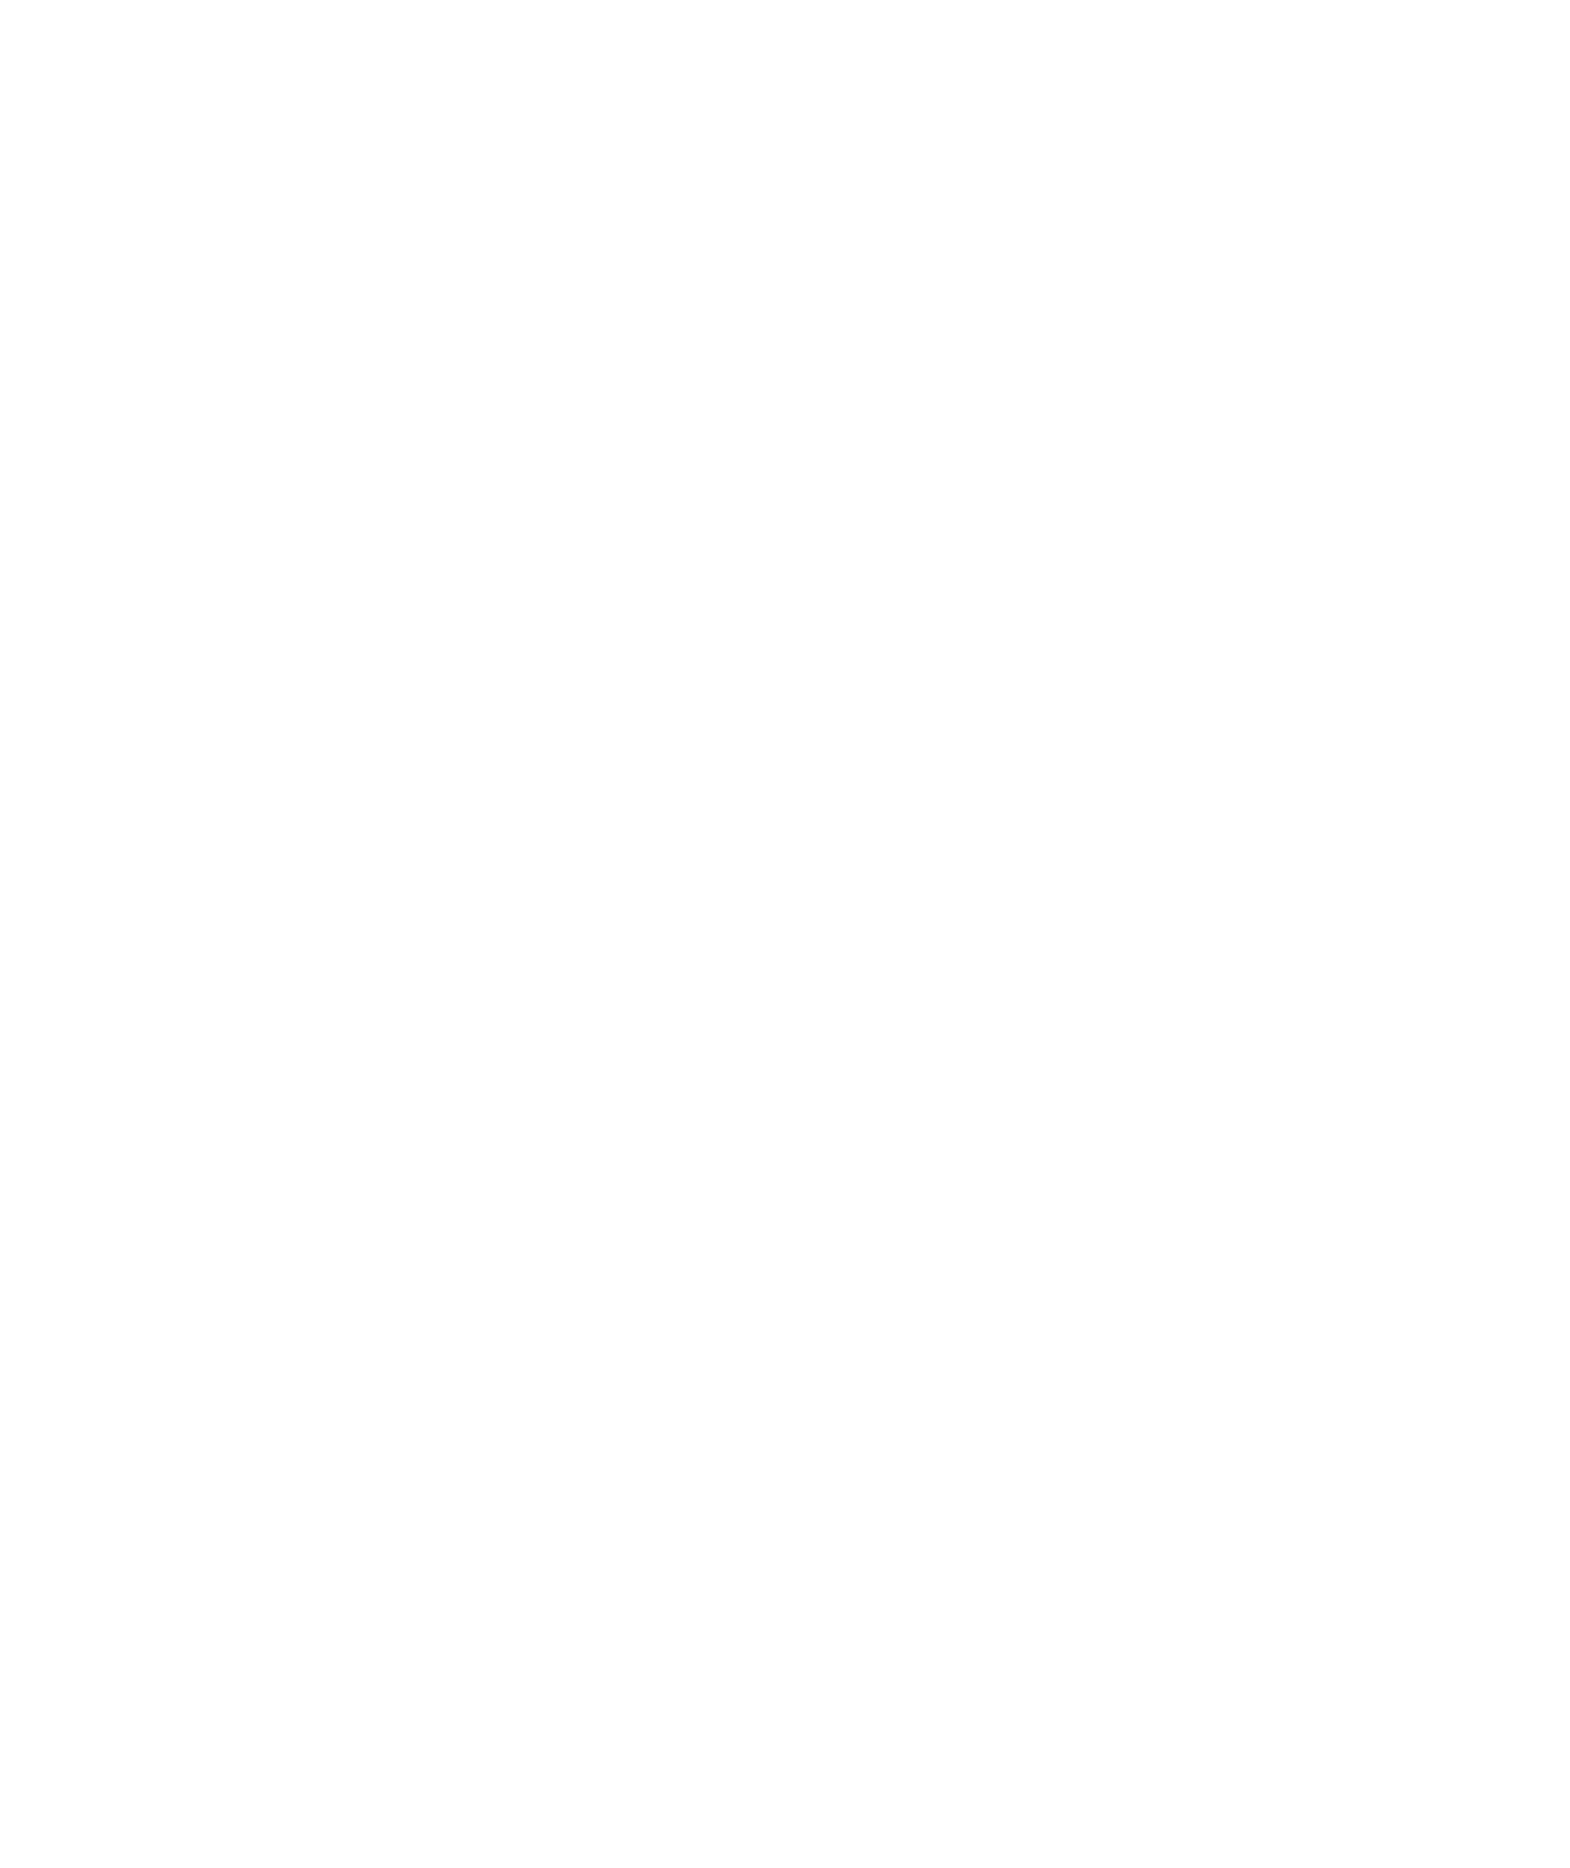

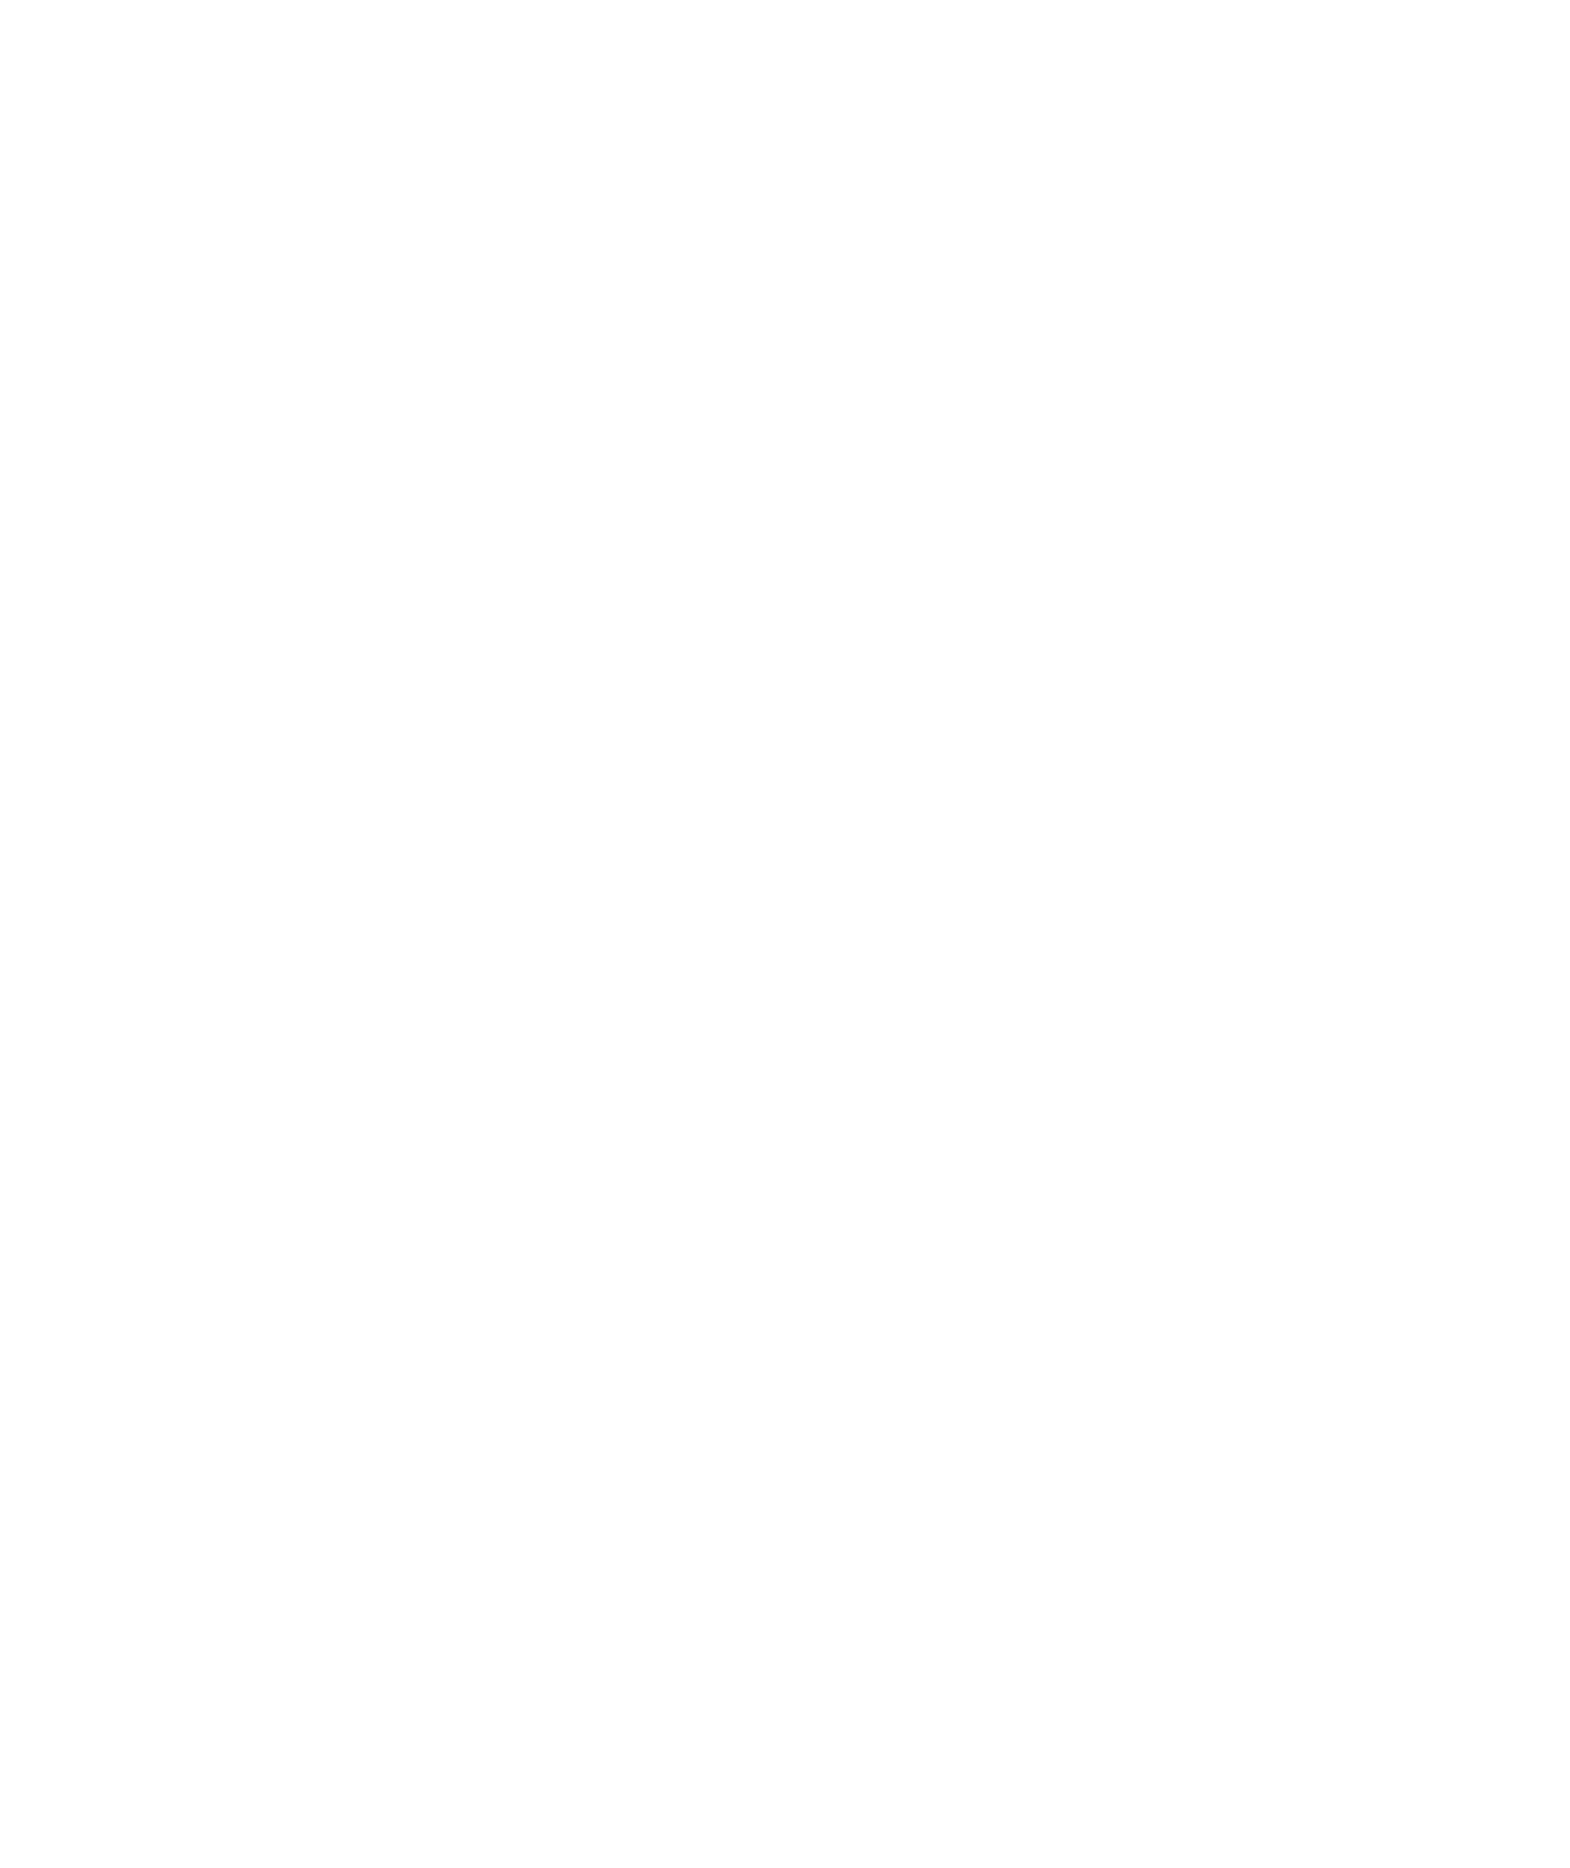

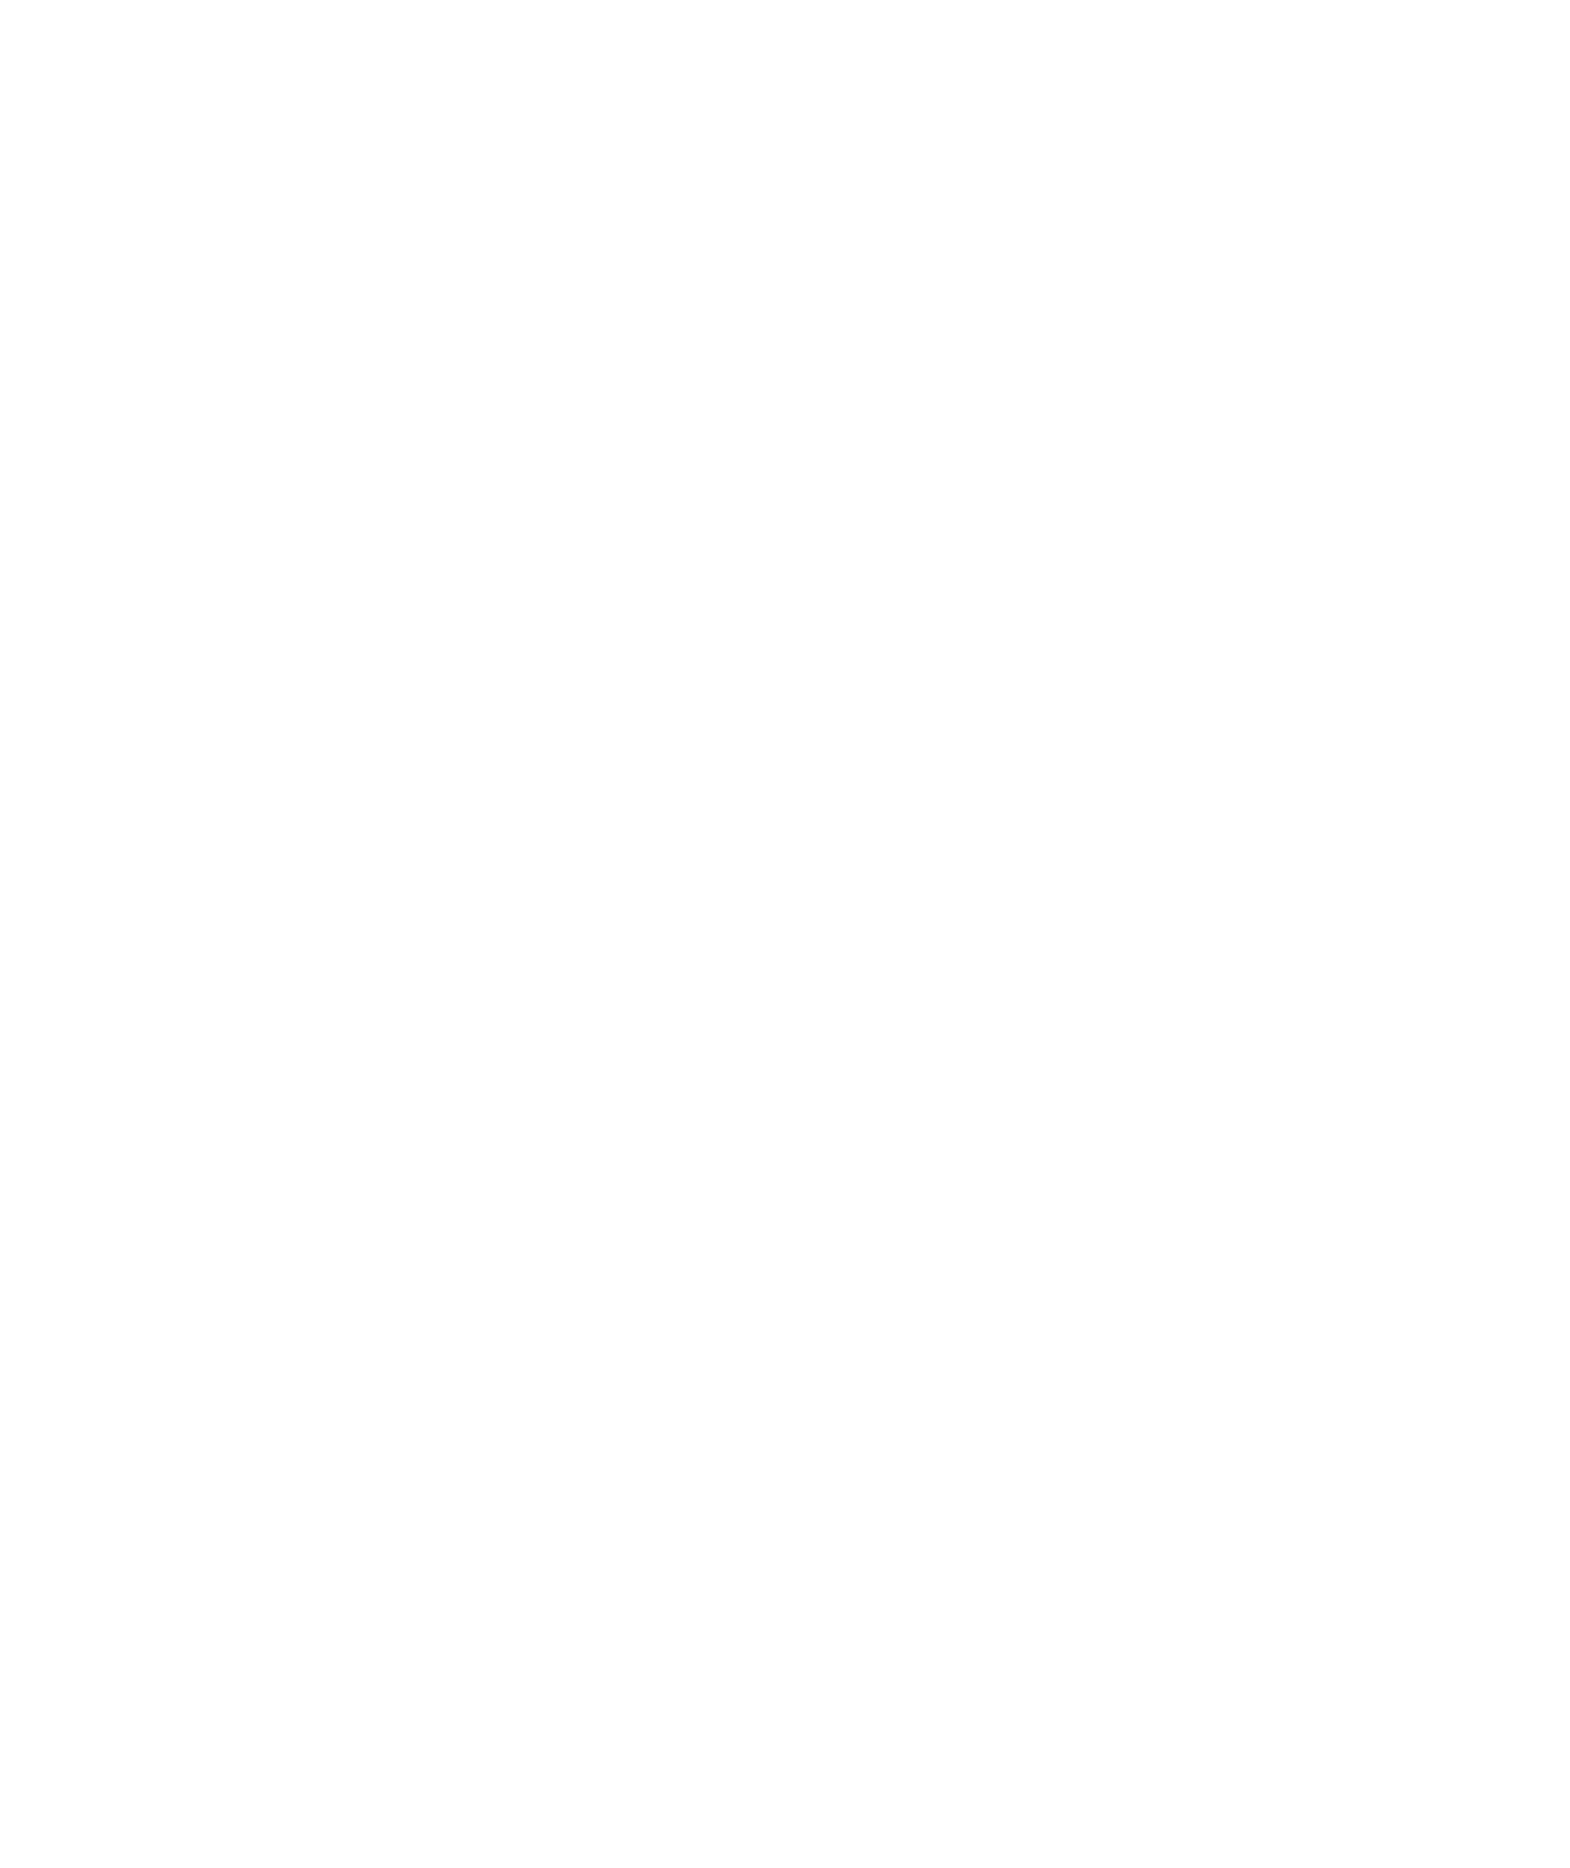

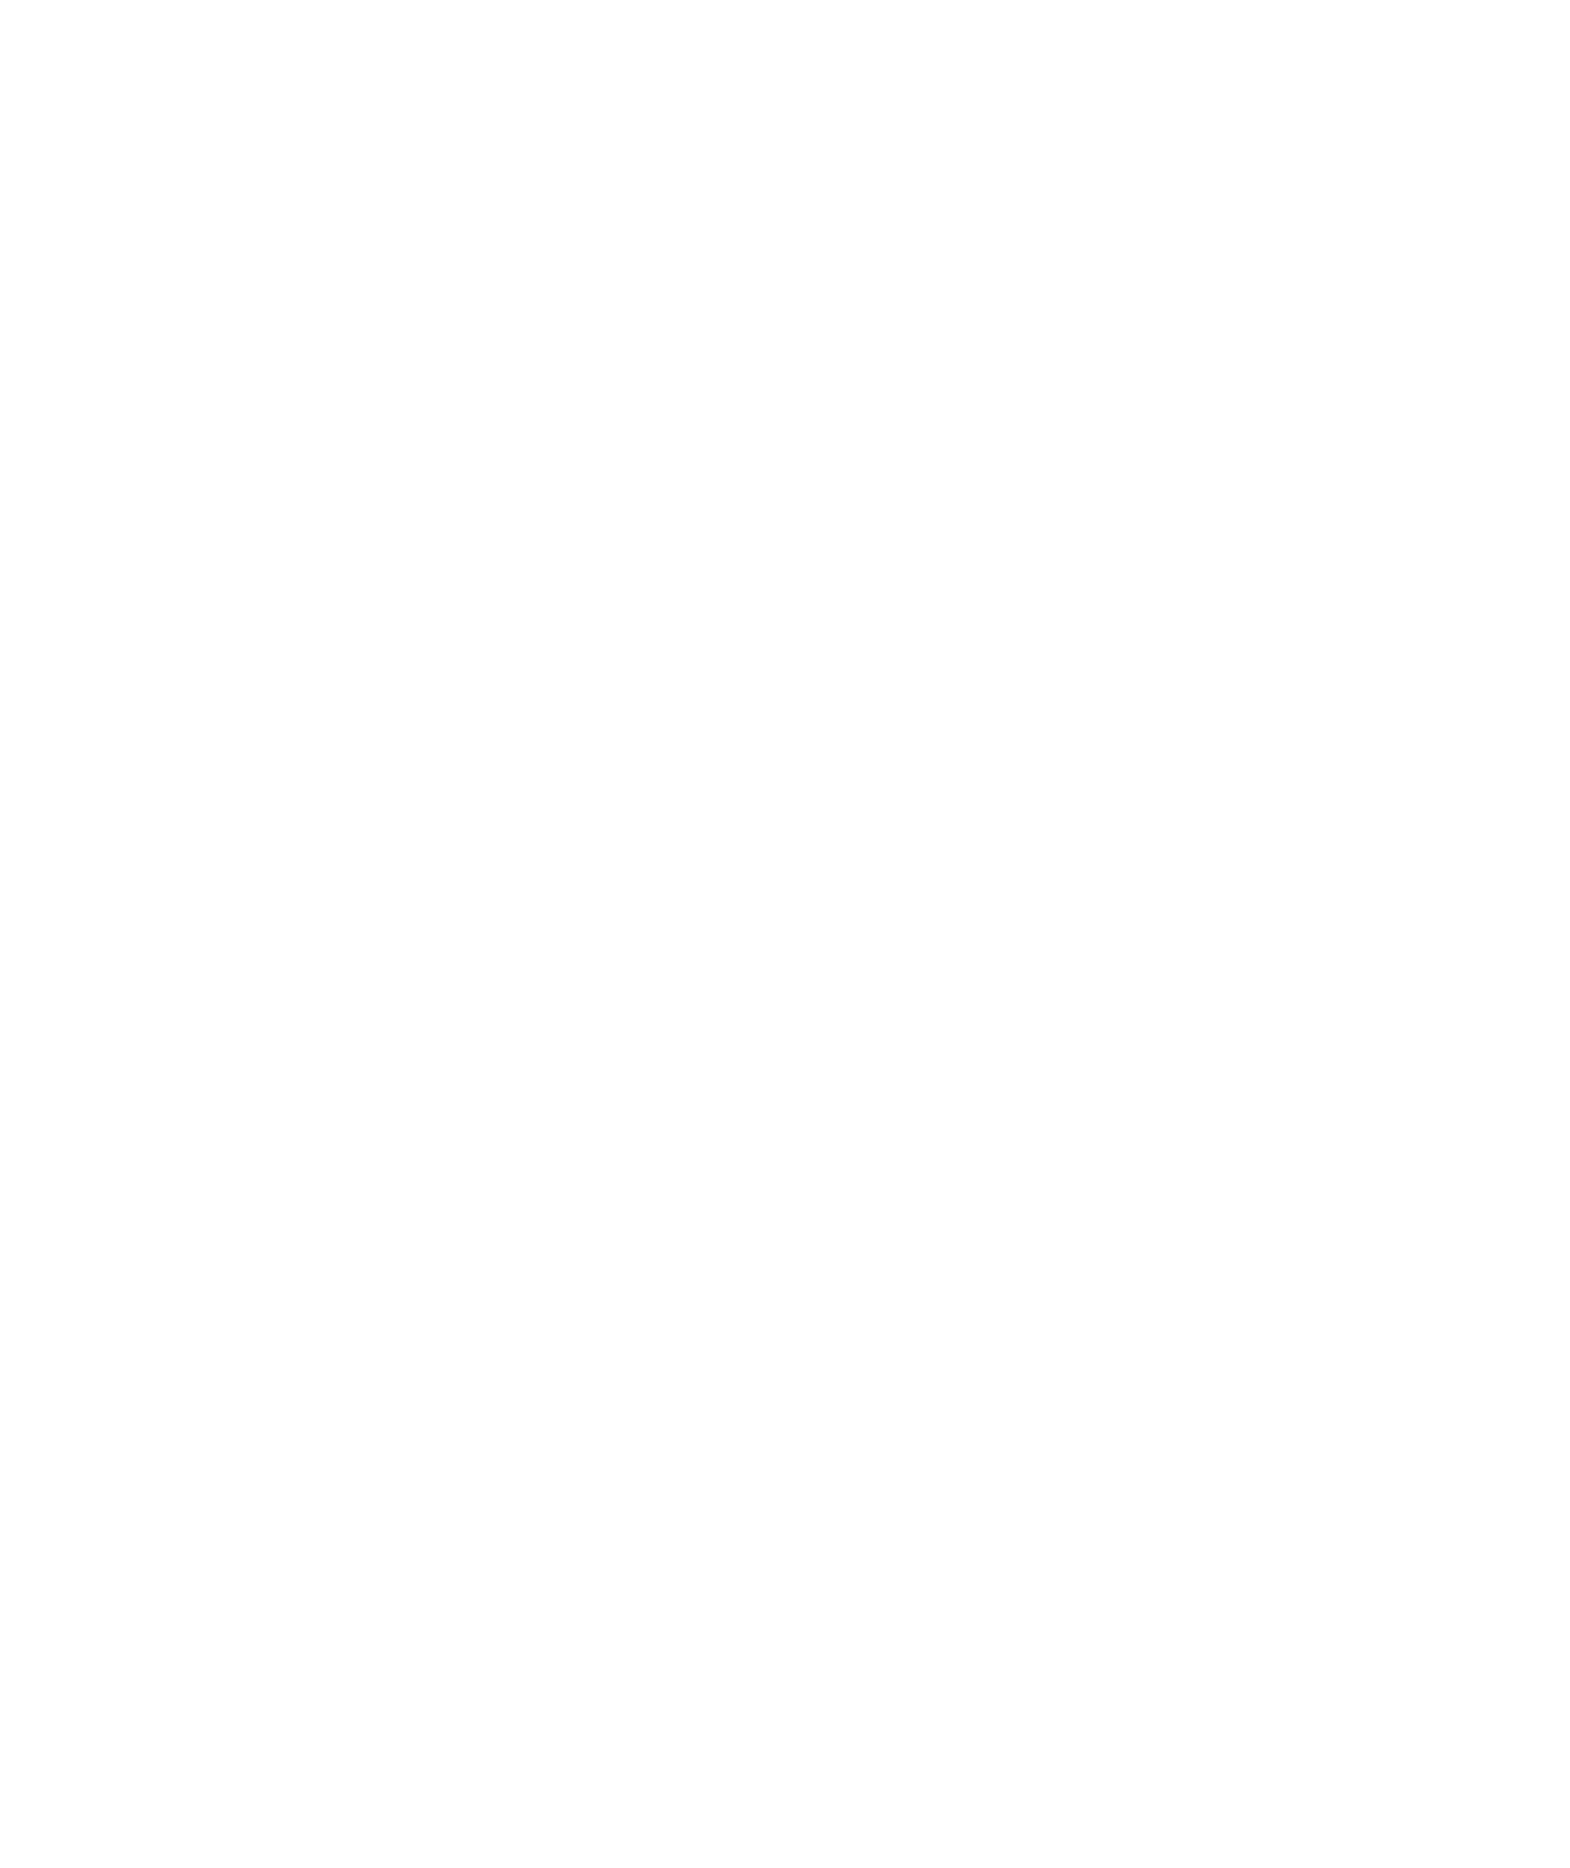

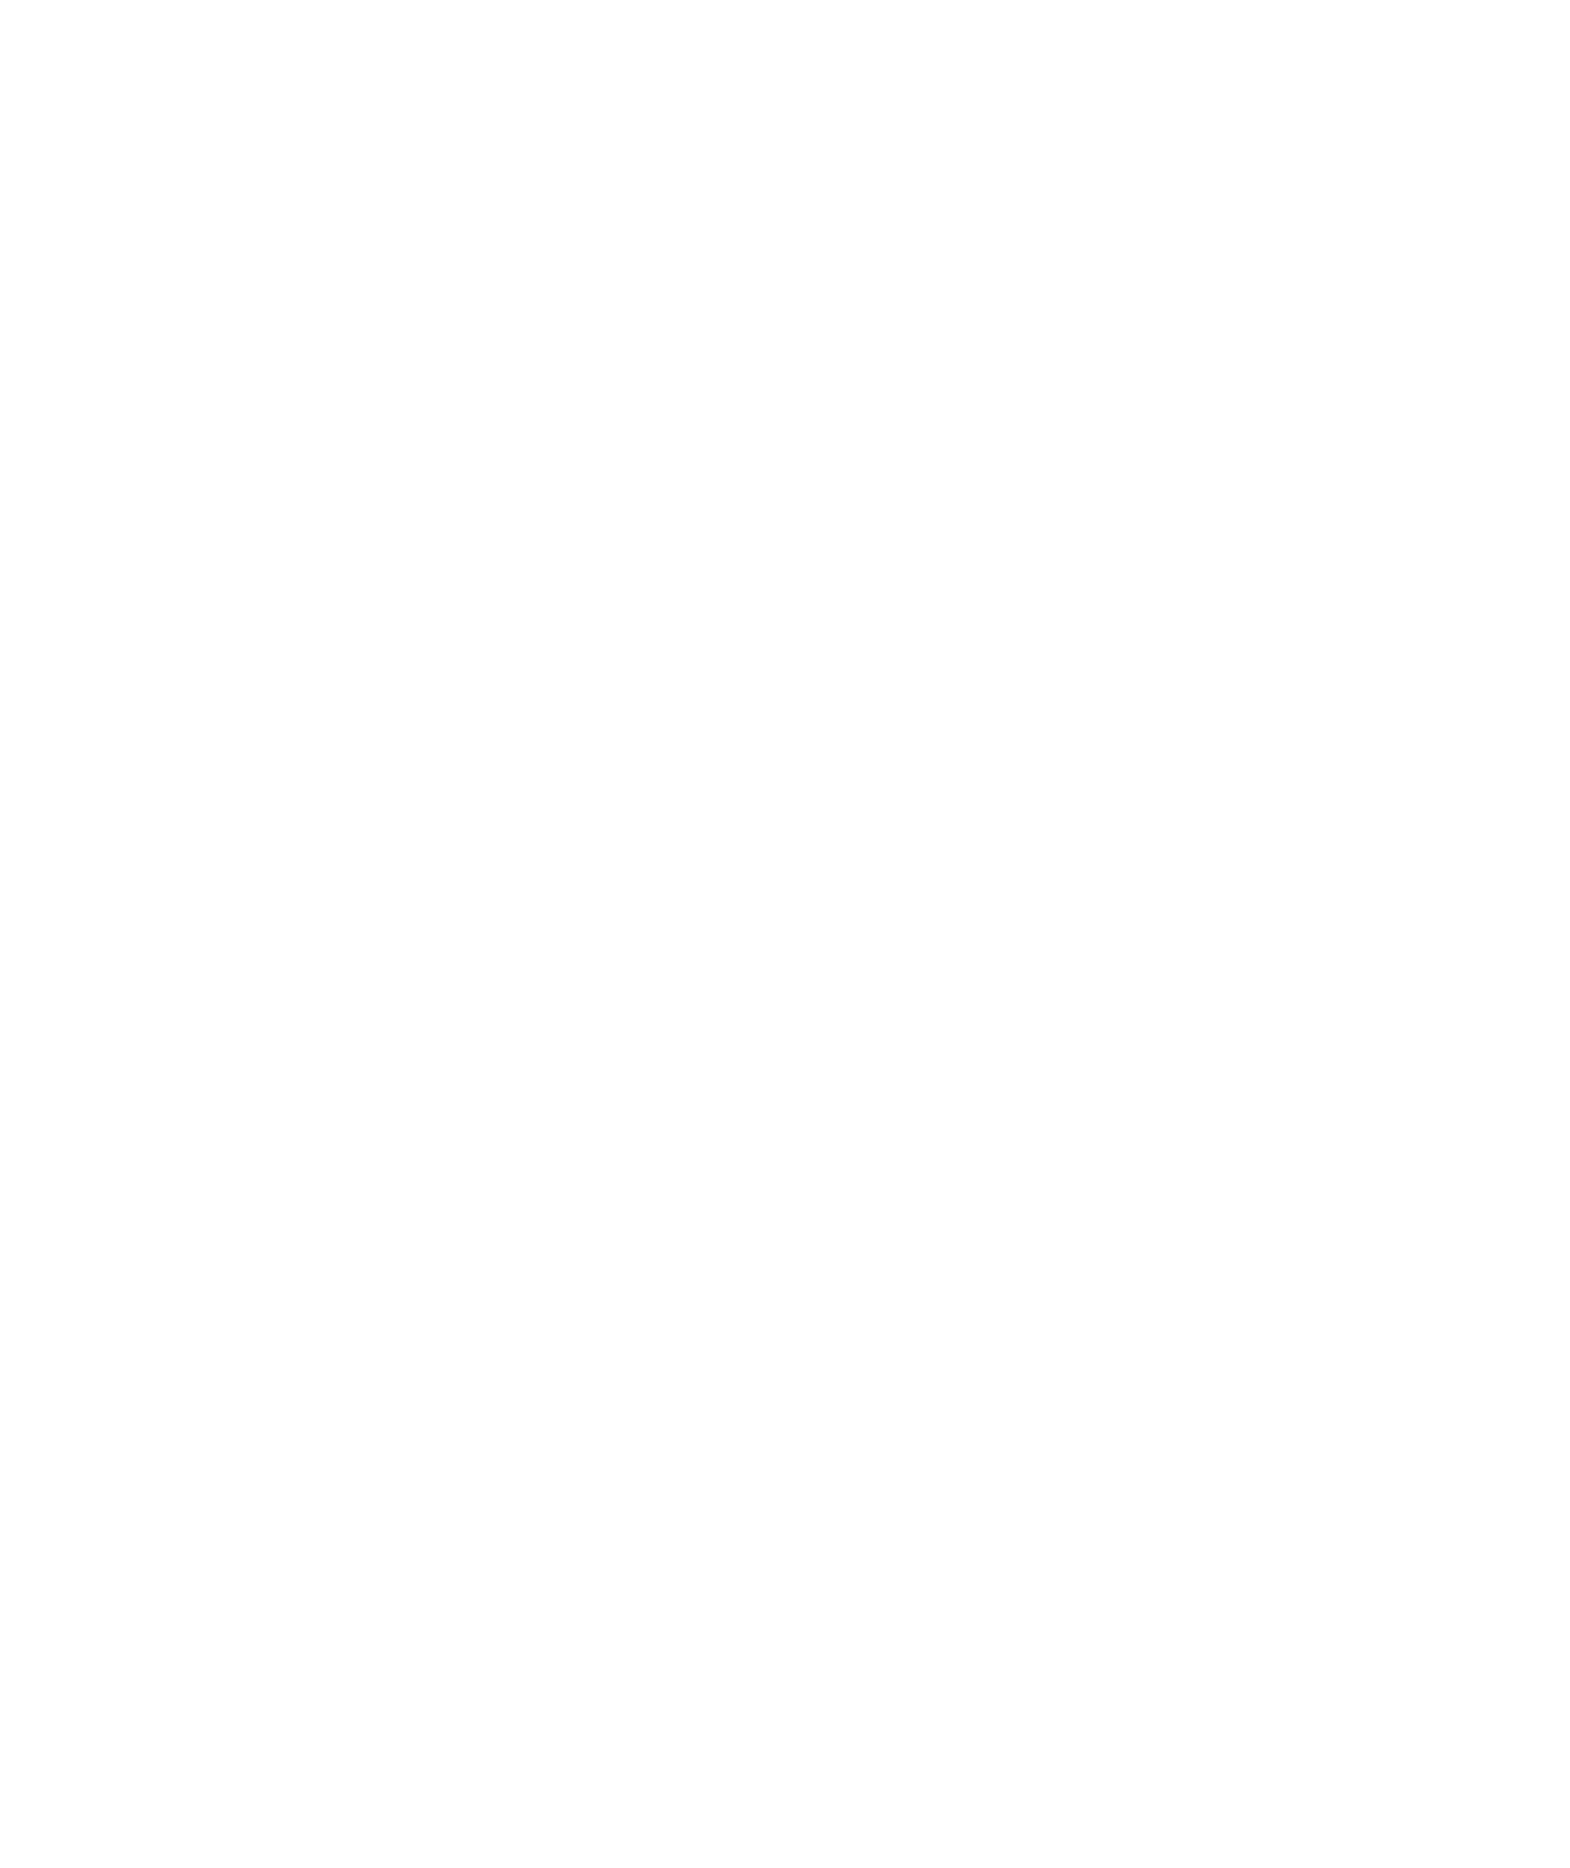

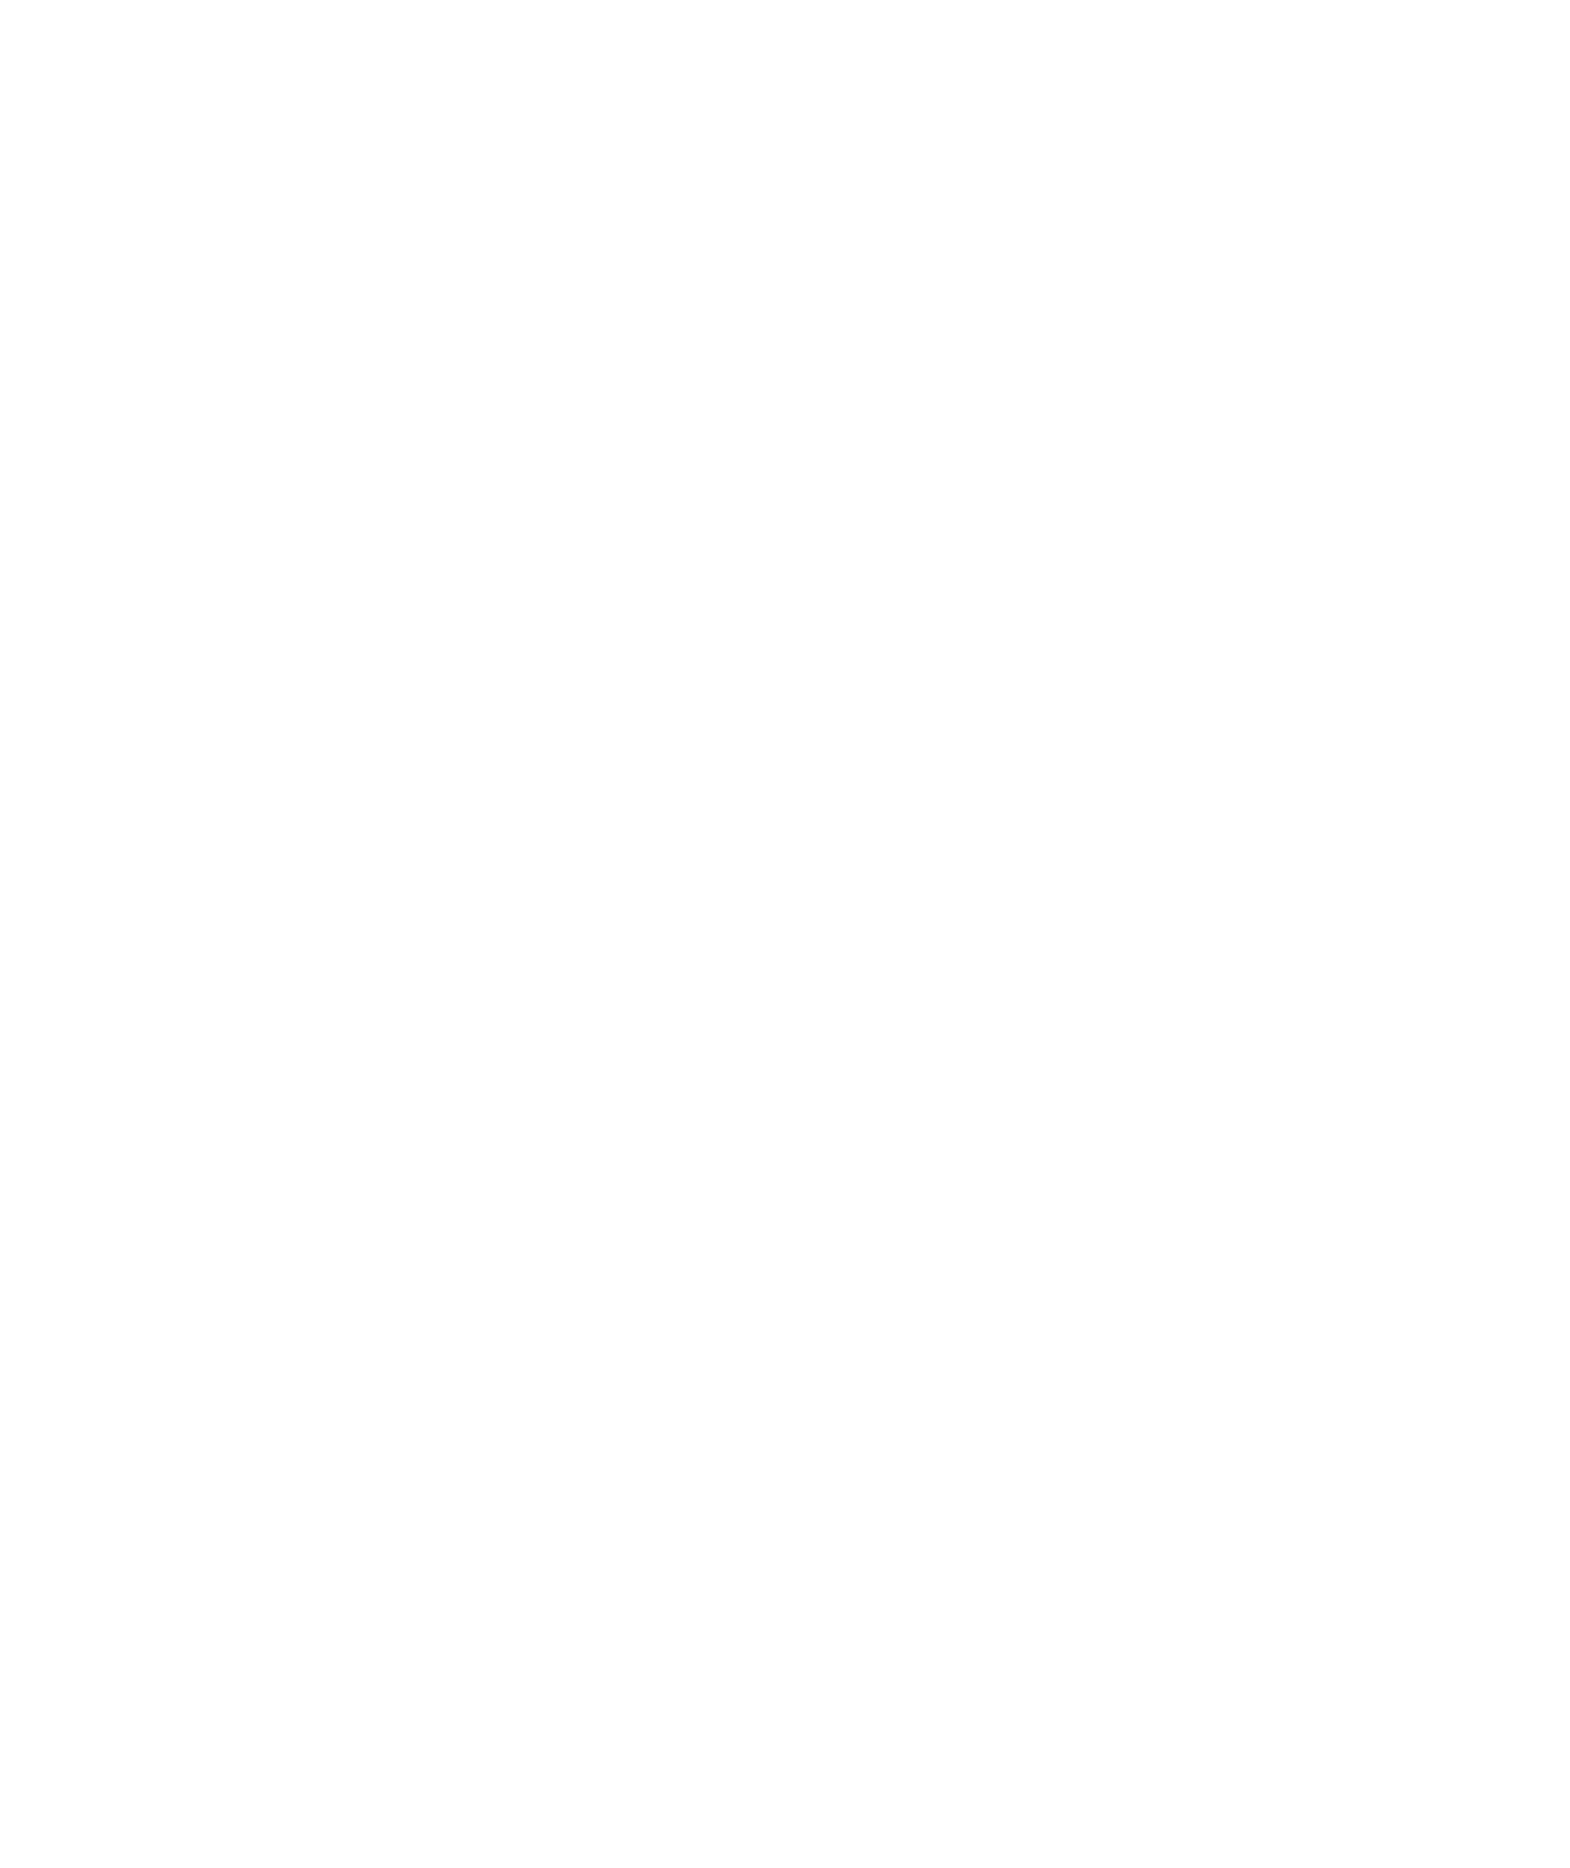

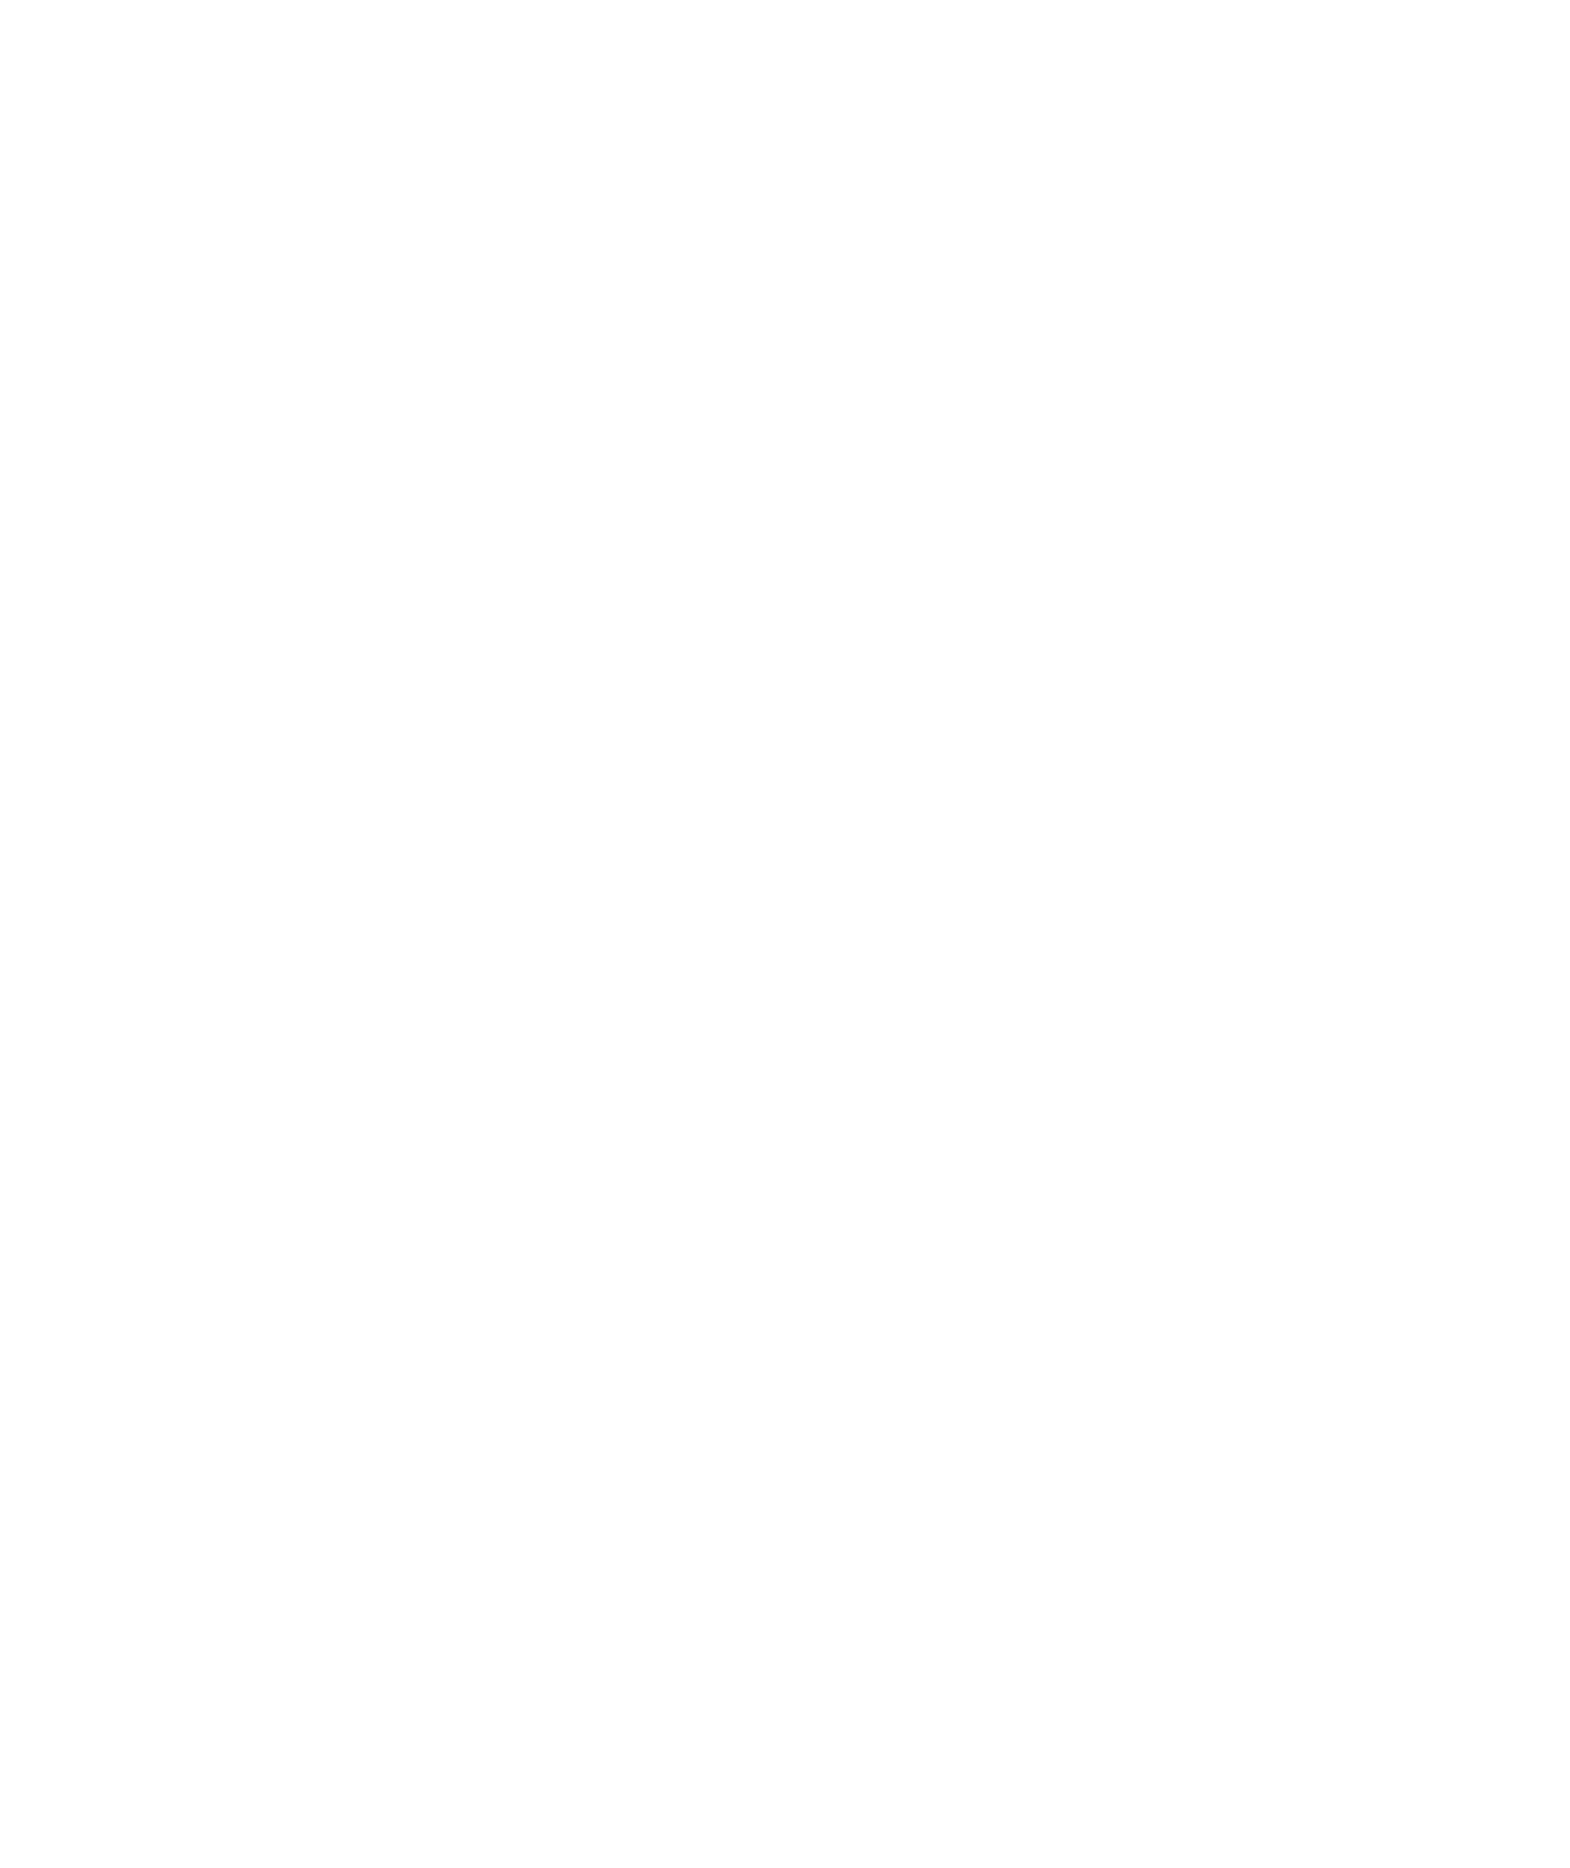

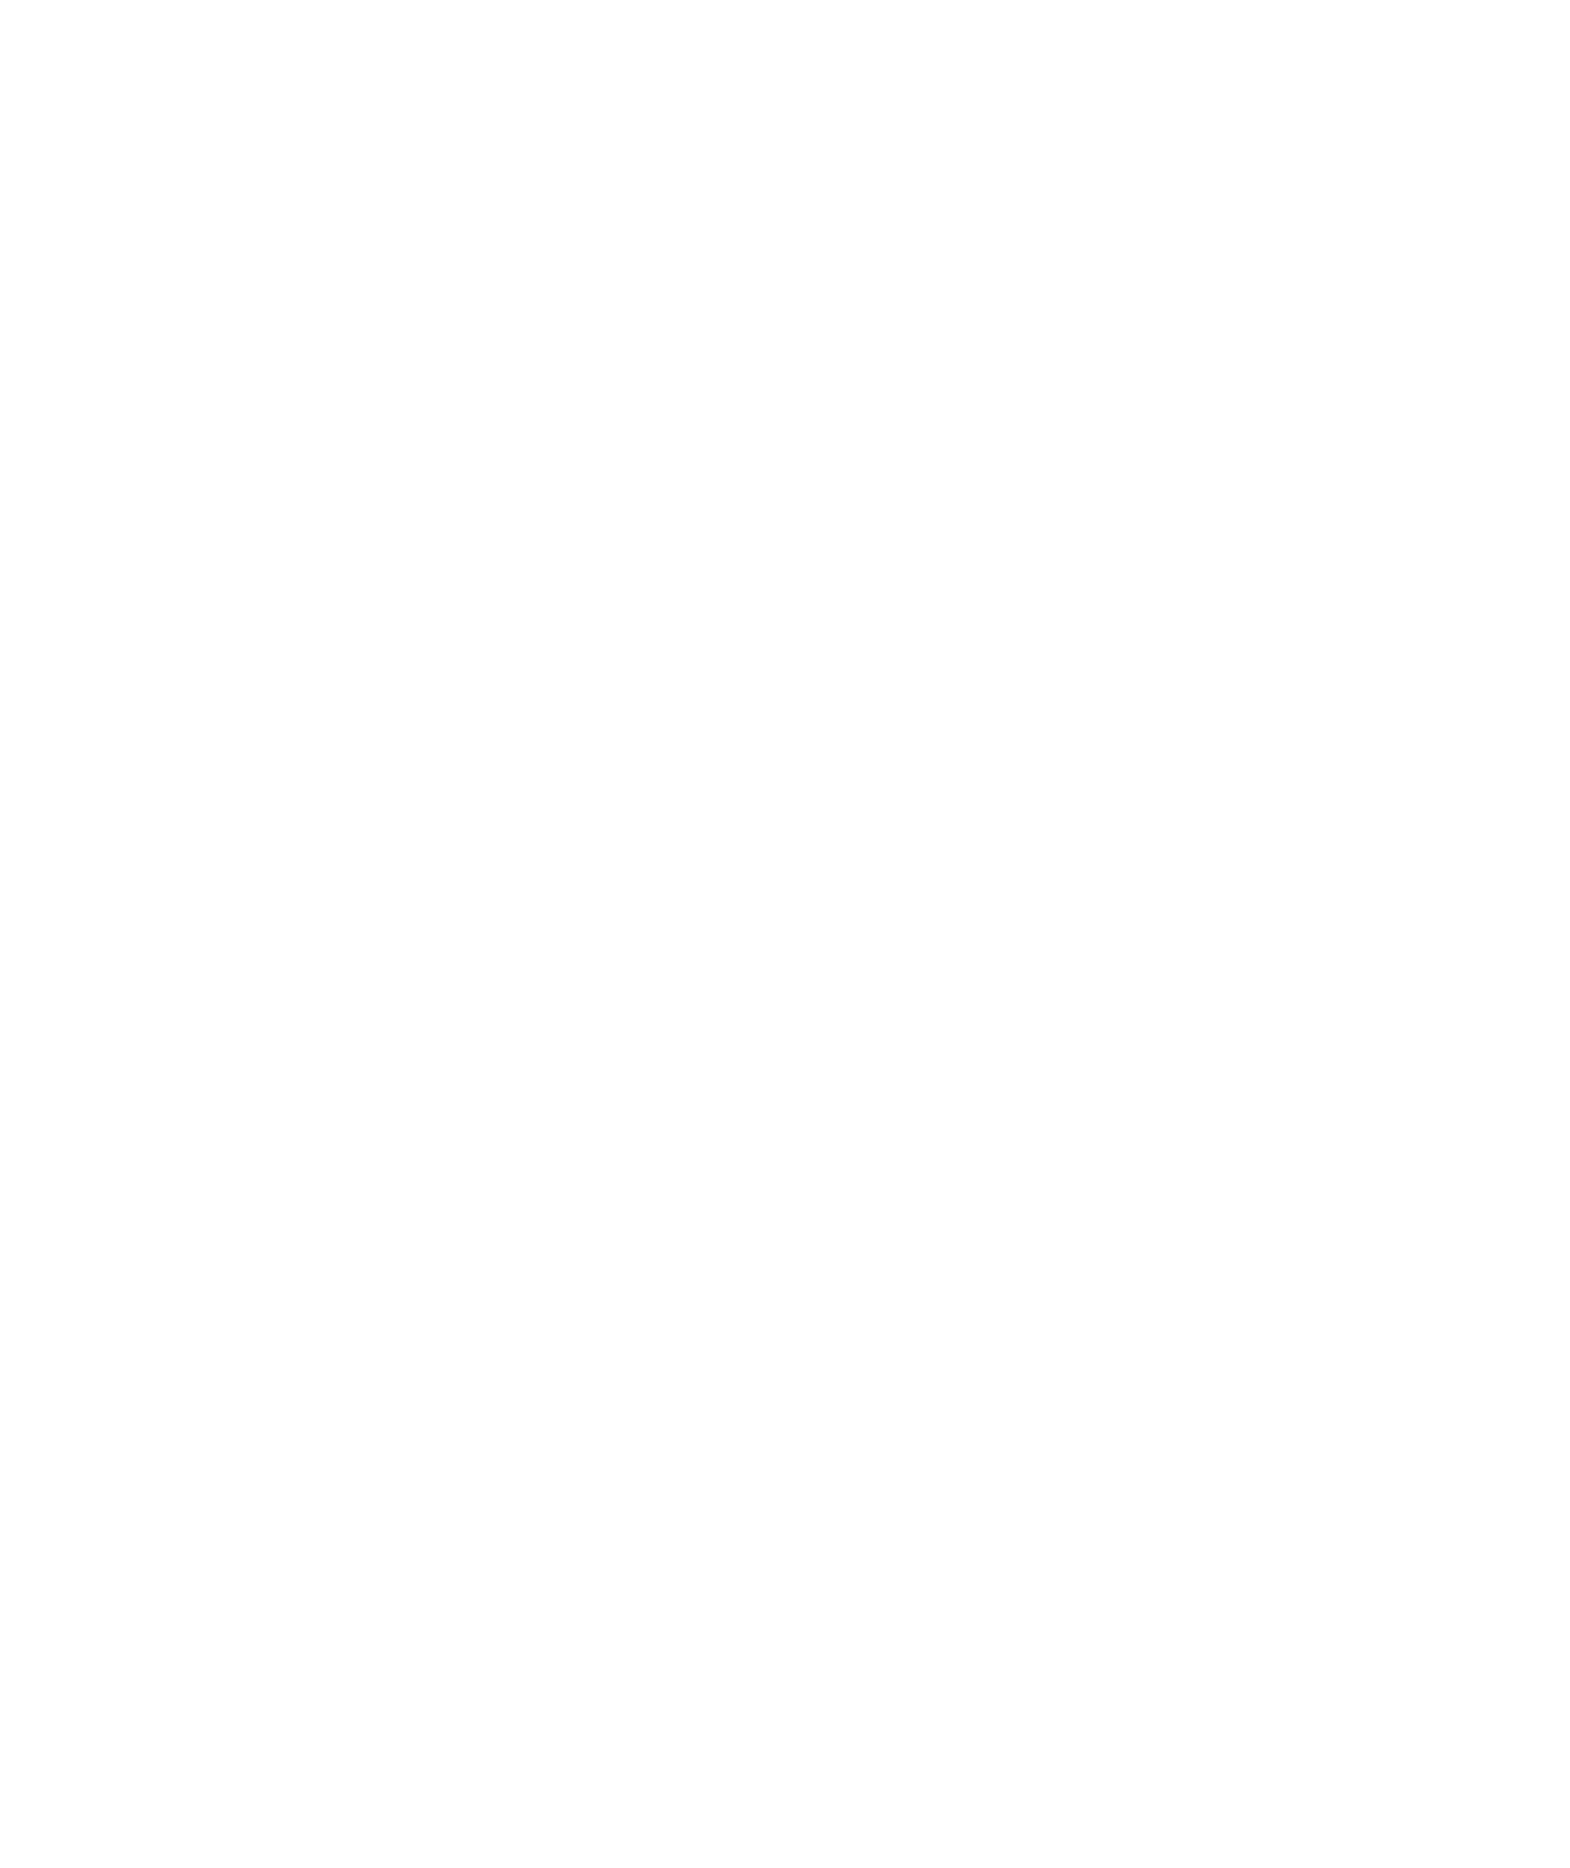

In [21]:
t = time.time()

for x_true, path, label in data_loader:
    epoch_idx += 1

    #for x_real, _ in train_loader:
    
    x_true=x_true.to(device)

    mu_real, logvar, c_real = fvae(x_true, encode_only=True)
    print(c_real)
    
    recon_img=dis_evaluator.predict_image(c_real)
    recon_img=torch.stack(recon_img)
    mu_gen, logvar_gen, c_gen=fvae(recon_img, encode_only=True)
    
    mu_real_All.append(mu_real.detach().cpu())
    mu_gen_All.append(mu_gen.detach().cpu())
    
    
    mu, c_lat=dis_evaluator.predict_latent(x_true)
    Traverse=1
    if Traverse==True:
        if epoch_idx < 50:
            
            travN =  epoch_idx
            travN_dir = os.path.join(travN_MainDir, str(travN))
            #print('checkpoint_dir',checkpoint_dir)
            # Create missing directories
            if not os.path.exists(travN_dir):
                os.makedirs(travN_dir)
                
            c_lat_sample=c_lat
            z_sample=ztest[0]
            #c_lat_sample=c_lat_sample.unsqueeze(0)
            z_sample=z_sample.unsqueeze(0)
            travN
            ncol=dis_evaluator.traverse_c1z1(travN, z_sample, c_lat_sample, save='True', save_type='idgan', TravImRet='False', cmap='viridis')

## Sorting the feature tables according to order generated in the ImageGenerator 
    label1.append(label)
    label2.append(path)
    # do stuff
elapsed = time.time() - t
print('Time taken to complete testing this dataset=')
print(elapsed)

In [22]:
label1=np.hstack(label1)
label2=np.hstack(label2)

mu_real_All=np.vstack(mu_real_All)
LatentZ=pd.DataFrame(mu_real_All)
#LatentZ.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Latent_LCtry.csv')
LabelAll=pd.DataFrame(label2)
#LabelAll.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Label_Liv.csv')



In [ ]:
sns.set(font_scale = 5)

#data_real=np.hstack((embedding, labelAll[:]))
df1 = pd.DataFrame(embedding, columns=['col1','col2'])
df2 = pd.DataFrame(label1, columns=['ClassLabels1'])
df3 = pd.DataFrame(label2, columns=['ClassLabels2'])
df_F=pd.concat([df1, df2, df3],axis=1)

In [157]:
df1

,col1,col2
0,-0.459713,9.496161
1,-2.730209,2.440987
2,-2.882473,5.612378
3,-0.283723,7.891653
4,-2.833555,4.959247
...,...,...
5992,10.437751,8.151132
5993,10.173785,7.786873
5994,12.653445,7.862051
5995,12.909408,7.644068


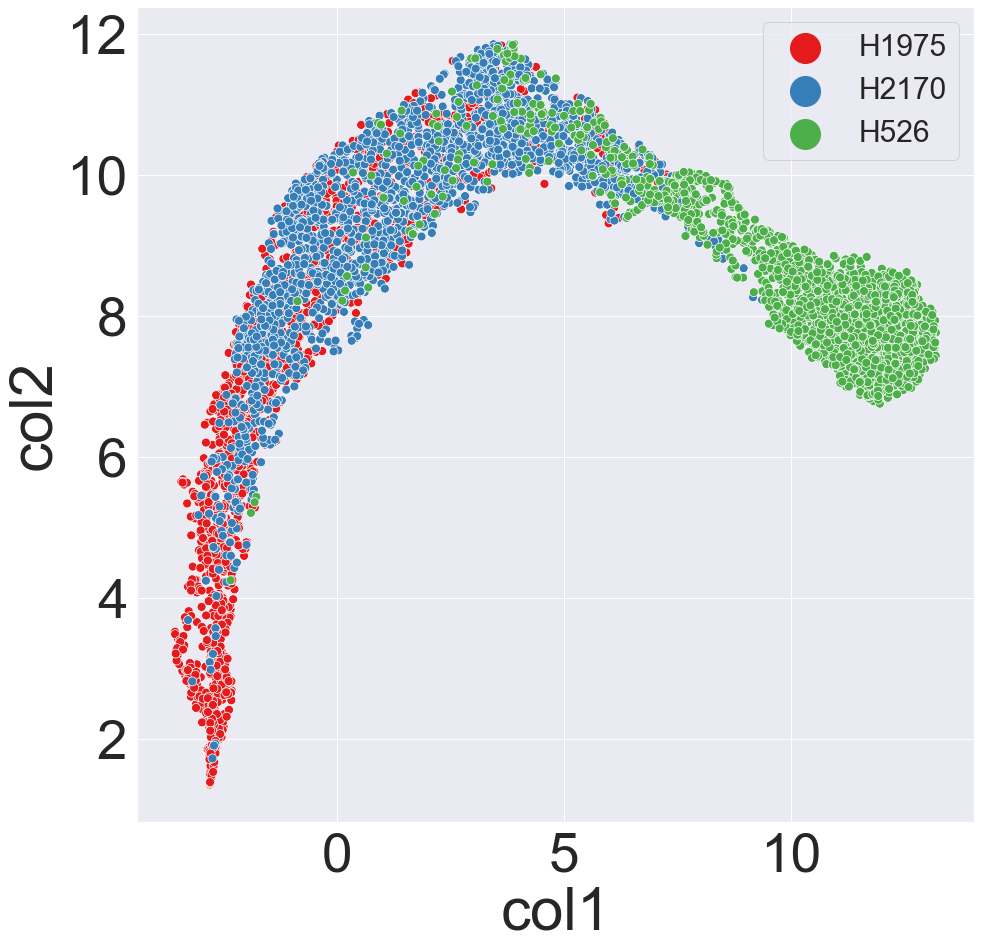

In [159]:
plt.figure(figsize=(15,15))
#plt.axis('off')
sns.scatterplot(data=df_F, x="col1", y="col2", s=80, hue="ClassLabels1", palette=('Set1'))
plt.legend(markerscale=5, fontsize=30)